In [51]:
# =============================================================================
# COMPREHENSIVE IMPORTS - All packages needed for the entire notebook
# =============================================================================

from __future__ import annotations  # Enables future annotations for type hints compatibility

import importlib  # Import importlib module for dynamic imports
import subprocess  # Import subprocess module to execute shell commands
import sys  # Import sys module to access system-specific parameters and functions
import os  # Import os module to interact with the operating system
import json  # Import json module for handling JSON data
import itertools  # Import itertools for efficient looping and combinatoric constructs
from dataclasses import dataclass  # Import dataclass decorator for creating data classes
from typing import Dict, List, Optional, Tuple, Union  # Import typing for type annotations

# Ensure required packages are installed
required_packages = [
    "pandas", "numpy", "matplotlib", "seaborn", "plotly",  # List of Python packages required for analysis
    "scipy", "openpyxl", "xlsxwriter", "ipywidgets"  # Added ipywidgets for interactive widgets
]
for package in required_packages:
    try:
        importlib.import_module(package)  # Try importing each required package
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])  # Install the package if not present

# Core data analysis

# =============================================================================
# STANDARDIZED COLOR SCHEME FOR CRISIS SCENARIOS
# =============================================================================

# Define consistent colors for crisis scenarios across all visualizations
CRISIS_COLOR_SCHEME = {
    'Optimistic': '#00B894',    # Green - represents positive/optimistic outcomes
    'Moderate': '#FDCB6E',      # Orange - represents moderate/middle-ground outcomes  
    'Pessimistic': '#E17055'    # Red - represents negative/pessimistic outcomes
}

def get_scenario_color(scenario_name):
    """
    Get the standardized color for a crisis scenario based on its name.
    
    Parameters:
    - scenario_name: String containing the scenario name
    
    Returns:
    - Color code string for the scenario
    """
    # Check for scenario type in the name (case-insensitive)
    scenario_lower = scenario_name.lower()
    
    if 'optimistic' in scenario_lower:
        return CRISIS_COLOR_SCHEME['Optimistic']
    elif 'moderate' in scenario_lower:
        return CRISIS_COLOR_SCHEME['Moderate']
    elif 'pessimistic' in scenario_lower:
        return CRISIS_COLOR_SCHEME['Pessimistic']
    else:
        # Default fallback - use first available color
        return list(CRISIS_COLOR_SCHEME.values())[0]
import pandas as pd  # Import pandas for data manipulation and analysis
import numpy as np  # Import numpy for numerical operations

# Visualization
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for static plotting
import matplotlib.patches as mpatches  # Import patches for drawing shapes on plots
import seaborn as sns  # Import seaborn for enhanced statistical visualizations
import plotly.express as px  # Import plotly express for interactive plots
import plotly.graph_objects as go  # Import plotly.graph_objects for advanced plotting
from plotly.subplots import make_subplots  # Import make_subplots to create multi-panel plots

# Scientific computing
from scipy import stats  # Import stats from scipy for statistical functions
from scipy.interpolate import interp1d  # Import interp1d for interpolation

# Warnings and display settings
import warnings  # Import warnings to control warning messages
warnings.filterwarnings('ignore')  # Ignore all warnings to keep output clean

print("✅ All imports loaded successfully!")  # Confirmation message when all imports are loaded
print("📊 Ready for water resource analysis...")  # Inform the user that analysis can begin

# =============================================================================
# DATA PROCESSING FUNCTIONS
# =============================================================================

def map_columns(df, source_type='raw_csv'):
    """
    Prepare dataset for analysis while preserving original column names for compatibility.
    """
    if source_type == 'raw_csv':
        # Keep original column names for compatibility with visualization code
        df_mapped = df.copy()  # Create a copy of the dataframe to avoid modifying original
        
        # Ensure year column is numeric and standardized
        if 'year' in df_mapped.columns:
            df_mapped['year'] = pd.to_numeric(df_mapped['year'], errors='coerce')  # Convert 'year' column to numeric
        elif 'Year' in df_mapped.columns:
            df_mapped['year'] = pd.to_numeric(df_mapped['Year'], errors='coerce')  # Convert 'Year' column to numeric if present
        
        return df_mapped  # Return the processed dataframe
    
    return df  # If not raw_csv, return the original dataframe unchanged

def recompute_indicators(df):
    """
    Calculate derived indicators from the dataset using original column names.
    """
    df_agg = df.copy()  # Copy the original dataframe to preserve it
    
    # Calculate total supply using original column names
    supply_cols = [
        'Water desalination (mCm)',  # Column for desalinated water
        'total produced by wells (milion m3)',  # Column for water from wells
        'produced by Kinneret (milion m3)',  # Column for water produced from Kinneret
        'produced by Effluents (milion m3)',  # Column for reused effluents
        'total produced by Upper water (milion m3)'  # Column for water from upper water sources
    ]
    
    df_agg['total_supply'] = 0  # Initialize total supply column with zeros
    for col in supply_cols:
        if col in df_agg.columns:
            df_agg['total_supply'] += df_agg[col].fillna(0)  # Sum up each supply component handling missing values
    
    # Calculate total demand using original column names
    demand_cols = [
        'Agricultural (milion m3)',  # Water demand from agriculture
        'Domestic (milion m3)',  # Water demand from domestic use
        'Industrial (milion m3)',  # Water demand from industry
        ' Water for the environment (milion m3)',  # Water demand for environmental purposes
        '       Other suppliers '  # Water demand from other suppliers
    ]
    
    df_agg['total_demand'] = 0  # Initialize total demand column with zeros
    for col in demand_cols:
        if col in df_agg.columns:
            df_agg['total_demand'] += df_agg[col].fillna(0)  # Sum up each demand component handling missing values
    
    # Calculate balance (surplus/deficit)
    df_agg['surplus'] = df_agg['total_supply'] - df_agg['total_demand']  # Surplus as difference between supply and demand
    
    # Create _mcm versions for compatibility with existing code
    df_agg['total_supply_mcm'] = df_agg['total_supply']  # Copy total supply to _mcm version
    df_agg['total_demand_mcm'] = df_agg['total_demand']  # Copy total demand to _mcm version
    df_agg['surplus_mcm'] = df_agg['surplus']  # Copy surplus to _mcm version
    
    # Create standardized column aliases for compatibility
    if 'Water desalination (mCm)' in df_agg.columns:
        df_agg['water_desalination_mcm'] = df_agg['Water desalination (mCm)']  # Alias for desalinated water
    if 'total produced by wells (milion m3)' in df_agg.columns:
        df_agg['capped_groundwater'] = df_agg['total produced by wells (milion m3)']  # Alias for groundwater production
    if 'produced by Kinneret (milion m3)' in df_agg.columns:
        df_agg['produced_by_kinneret_milion_m3'] = df_agg['produced by Kinneret (milion m3)']  # Alias for Kinneret production
    if 'produced by Effluents (milion m3)' in df_agg.columns:
        df_agg['capped_reuse'] = df_agg['produced by Effluents (milion m3)']  # Alias for reuse from effluents
    if 'total produced by Upper water (milion m3)' in df_agg.columns:
        df_agg['total_produced_by_upper_water_milion_m3'] = df_agg['total produced by Upper water (milion m3)']  # Alias for upper water production
    
    # Calculate renewable supply (excluding desalination)
    renewable_cols = [
        'capped_groundwater', 'produced_by_kinneret_milion_m3', 'capped_reuse', 
        'total_produced_by_upper_water_milion_m3'  # Columns representing renewable sources
    ]
    df_agg['renewable_supply_mcm'] = 0  # Initialize renewable supply column
    for col in renewable_cols:
        if col in df_agg.columns:
            df_agg['renewable_supply_mcm'] += df_agg[col].fillna(0)  # Sum renewable sources handling missing values
    
    # Calculate Water Stress Index (WSI) - demand/renewable supply ratio
    df_agg['wsi'] = np.where(
        df_agg['renewable_supply_mcm'] > 0,
        df_agg['total_demand'] / df_agg['renewable_supply_mcm'],  # Compute WSI when renewable supply is positive
        np.nan  # Otherwise assign NaN
    )
    
    # Calculate Desalination Dependency Ratio (DDR)
    df_agg['ddr'] = np.where(
        df_agg['total_supply_mcm'] > 0,
        df_agg['water_desalination_mcm'] / df_agg['total_supply_mcm'],  # Desalination fraction of total supply
        0  # If total supply is zero, dependency ratio is zero
    )
    
    # Calculate per capita metrics
    if 'population' in df_agg.columns:
        df_agg['supply_per_capita'] = df_agg['total_supply_mcm'] / df_agg['population']  # Supply per person
        df_agg['demand_per_capita'] = df_agg['total_demand_mcm'] / df_agg['population']  # Demand per person
    
    return df_agg  # Return the dataframe with new indicators

def normalize_columns_for_recompute(df):
    """
    Normalize column names for recompute_indicators function.
    """
    return map_columns(df, source_type='raw_csv')  # Reuse map_columns for normalization

def load_parameters(filepath):
    """
    Load parameters from CSV file and return as dictionary with scenario-based access.
    """
    try:
        df = pd.read_csv(filepath)  # Read CSV into a dataframe
        params = {}  # Initialize parameters dictionary
        
        if 'Parameter' in df.columns:
            # If it's a parameter-value format with scenarios
            for _, row in df.iterrows():  # Iterate over each row
                param_name = row['Parameter']  # Parameter name
                param_dict = {}  # Dictionary for scenarios
                
                # Get values for each scenario
                for col in df.columns:
                    if col != 'Parameter' and pd.notna(row[col]):  # Skip Parameter column and missing values
                        param_dict[col] = row[col]  # Assign scenario value to parameter dictionary
                
                params[param_name] = param_dict  # Add to main params
        else:
            # If it's a simple key-value format
            for col in df.columns:
                if len(df) > 0:
                    params[col] = df[col].iloc[0]  # Use first row value for parameter
        
        return params  # Return the parameters dictionary
    except Exception as e:
        print(f"Error loading parameters from {filepath}: {e}")  # Print error message if loading fails
        return {}  # Return empty dictionary on failure

def apply_drought_crisis_corrected(baseline_data, crisis_years, severity, params):
    """
    Apply drought crisis effects to baseline data.
    """
    result = baseline_data.copy()  # Copy baseline data to avoid modifying original
    
    # Get severity factor from parameters or use default
    try:
        if 'SurfaceWaterReduction' in params and severity in params['SurfaceWaterReduction']:
            surface_factor = params['SurfaceWaterReduction'][severity]  # Use configured surface water reduction
        else:
            surface_factor = {'Optimistic': 0.8, 'Moderate': 0.6, 'Pessimistic': 0.4}.get(severity, 0.6)  # Default values
    except:
        surface_factor = {'Optimistic': 0.8, 'Moderate': 0.6, 'Pessimistic': 0.4}.get(severity, 0.6)  # Default if error
    
    try:
        if 'GroundwaterReduction' in params and severity in params['GroundwaterReduction']:
            ground_factor = params['GroundwaterReduction'][severity]  # Use configured groundwater reduction
        else:
            ground_factor = {'Optimistic': 0.8, 'Moderate': 0.6, 'Pessimistic': 0.4}.get(severity, 0.6)  # Default values
    except:
        ground_factor = {'Optimistic': 0.8, 'Moderate': 0.6, 'Pessimistic': 0.4}.get(severity, 0.6)  # Default if error
    
    # Apply reduction to natural water sources during crisis years
    crisis_mask = result['year'].isin(crisis_years)  # Mask for crisis years
    
    # Reduce surface water (Kinneret)
    if 'produced_by_kinneret_milion_m3' in result.columns:
        result.loc[crisis_mask, 'produced_by_kinneret_milion_m3'] *= surface_factor  # Apply surface reduction
    
    # Reduce groundwater
    if 'capped_groundwater' in result.columns:
        result.loc[crisis_mask, 'capped_groundwater'] *= ground_factor  # Apply groundwater reduction
    
    # Recalculate total supply using ALL supply sources (including reuse and upper water)
    supply_cols = [
        'water_desalination_mcm', 'capped_groundwater', 'produced_by_kinneret_milion_m3', 
        'capped_reuse', 'total_produced_by_upper_water_milion_m3'  # All supply components
    ]
    available_supply_cols = [col for col in supply_cols if col in result.columns]  # Keep only existing columns
    result['total_supply_mcm'] = result[available_supply_cols].sum(axis=1, skipna=True)  # Sum supply sources
    
    # Recalculate renewable supply (excluding desalination)
    renewable_cols = [
        'capped_groundwater', 'produced_by_kinneret_milion_m3', 'capped_reuse', 
        'total_produced_by_upper_water_milion_m3'  # All renewable sources
    ]
    available_renewable_cols = [col for col in renewable_cols if col in result.columns]  # Existing renewable columns
    result['renewable_supply_mcm'] = result[available_renewable_cols].sum(axis=1, skipna=True)  # Sum renewable sources
    
    # Recalculate indicators
    result['surplus_mcm'] = result['total_supply_mcm'] - result['total_demand']  # Surplus after crisis
    result['wsi'] = np.where(
        result['renewable_supply_mcm'] > 0,
        result['total_demand'] / result['renewable_supply_mcm'],  # WSI after crisis
        np.nan
    )
    result['ddr'] = np.where(
        result['total_supply_mcm'] > 0,
        result['water_desalination_mcm'] / result['total_supply_mcm'],  # DDR after crisis
        0
    )
    
    return result  # Return the modified dataset

def apply_energy_crisis(baseline_data, crisis_years, severity, params):
    """
    Apply energy crisis effects to baseline data.
    """
    result = baseline_data.copy()  # Copy baseline data to avoid modifying original
    
    # Get desalination impact factor from parameters or use default
    try:
        if 'DesalCapacityFactor' in params and severity in params['DesalCapacityFactor']:
            desal_factor = params['DesalCapacityFactor'][severity]  # Use configured desalination capacity factor
        else:
            desal_factor = {'Optimistic': 0.95, 'Moderate': 0.85, 'Pessimistic': 0.7}.get(severity, 0.85)  # Default values
    except:
        desal_factor = {'Optimistic': 0.95, 'Moderate': 0.85, 'Pessimistic': 0.7}.get(severity, 0.85)  # Default if error
    
    # Apply desalination reduction to crisis years
    crisis_mask = result['year'].isin(crisis_years)  # Mask for crisis years
    result.loc[crisis_mask, 'water_desalination_mcm'] = result.loc[crisis_mask, 'water_desalination_mcm'] * desal_factor  # Reduce desalination output
    
    # Recalculate total supply using ALL supply sources (including reuse and upper water)
    supply_cols = [
        'water_desalination_mcm', 'capped_groundwater', 'produced_by_kinneret_milion_m3', 
        'capped_reuse', 'total_produced_by_upper_water_milion_m3'  # All supply components
    ]
    available_supply_cols = [col for col in supply_cols if col in result.columns]  # Existing supply columns
    result['total_supply_mcm'] = result[available_supply_cols].sum(axis=1, skipna=True)  # Sum supply sources
    
    # Recalculate renewable supply (excluding desalination)
    renewable_cols = [
        'capped_groundwater', 'produced_by_kinneret_milion_m3', 'capped_reuse', 
        'total_produced_by_upper_water_milion_m3'  # All renewable sources
    ]
    available_renewable_cols = [col for col in renewable_cols if col in result.columns]  # Existing renewable columns
    result['renewable_supply_mcm'] = result[available_renewable_cols].sum(axis=1, skipna=True)  # Sum renewable sources
    
    # Recalculate indicators
    result['surplus_mcm'] = result['total_supply_mcm'] - result['total_demand']  # Surplus after crisis
    result['wsi'] = np.where(
        result['renewable_supply_mcm'] > 0,
        result['total_demand'] / result['renewable_supply_mcm'],  # WSI after crisis
        np.nan
    )
    result['ddr'] = np.where(
        result['total_supply_mcm'] > 0,
        result['water_desalination_mcm'] / result['total_supply_mcm'],  # DDR after crisis
        0
    )
    
    return result  # Return the modified dataset

def apply_conflict_crisis(baseline_data, crisis_years, severity, params):
    """
    Apply conflict crisis effects to baseline data.
    """
    result = baseline_data.copy()  # Copy baseline data to avoid modifying original
    
    # Get supply capacity factor from parameters or use default
    try:
        if 'SupplyCapacityFactor' in params and severity in params['SupplyCapacityFactor']:
            supply_factor = params['SupplyCapacityFactor'][severity]  # Use configured supply capacity factor
        else:
            supply_factor = {'Optimistic': 0.95, 'Moderate': 0.8, 'Pessimistic': 0.5}.get(severity, 0.8)  # Default values
    except:
        supply_factor = {'Optimistic': 0.95, 'Moderate': 0.8, 'Pessimistic': 0.5}.get(severity, 0.8)  # Default if error
    
    # Get agricultural demand change from parameters
    try:
        if 'AgriculturalDemandChange' in params and severity in params['AgriculturalDemandChange']:
            ag_demand_factor = 1 + params['AgriculturalDemandChange'][severity]  # Use configured agricultural demand change
        else:
            ag_demand_factor = {'Optimistic': 0.9, 'Moderate': 0.8, 'Pessimistic': 0.5}.get(severity, 0.8)  # Default values
    except:
        ag_demand_factor = {'Optimistic': 0.9, 'Moderate': 0.8, 'Pessimistic': 0.5}.get(severity, 0.8)  # Default if error
    
    # Apply supply capacity factor to crisis years
    crisis_mask = result['year'].isin(crisis_years)  # Mask for crisis years
    supply_cols = ['water_desalination_mcm', 'capped_groundwater', 'produced_by_kinneret_milion_m3', 
                   'capped_reuse', 'total_produced_by_upper_water_milion_m3']  # All supply components
    for col in supply_cols:
        if col in result.columns:
            result.loc[crisis_mask, col] *= supply_factor  # Reduce each supply component by supply factor
    
    # Apply demand changes during conflict (each sector has its own change factor)
    # Agricultural demand change
    if 'Agricultural (milion m3)' in result.columns:
        try:
            ag_change = params['AgriculturalDemandChange'][severity] if 'AgriculturalDemandChange' in params else -0.2  # Retrieve agricultural change
            result.loc[crisis_mask, 'Agricultural (milion m3)'] *= (1 + ag_change)  # Apply change to agricultural demand
        except:
            pass  # If retrieval fails, skip modification
    
    # Domestic demand change
    if 'Domestic (milion m3)' in result.columns:
        try:
            dom_change = params['DomesticDemandChange'][severity] if 'DomesticDemandChange' in params else -0.05  # Retrieve domestic change
            result.loc[crisis_mask, 'Domestic (milion m3)'] *= (1 + dom_change)  # Apply change to domestic demand
        except:
            pass  # If retrieval fails, skip modification
    
    # Industrial demand change
    if 'Industrial (milion m3)' in result.columns:
        try:
            ind_change = params['IndustrialDemandChange'][severity] if 'IndustrialDemandChange' in params else -0.1  # Retrieve industrial change
            result.loc[crisis_mask, 'Industrial (milion m3)'] *= (1 + ind_change)  # Apply change to industrial demand
        except:
            pass  # If retrieval fails, skip modification
    
    # Recalculate total supply using ALL supply sources (including reuse and upper water)
    supply_cols = [
        'water_desalination_mcm', 'capped_groundwater', 'produced_by_kinneret_milion_m3', 
        'capped_reuse', 'total_produced_by_upper_water_milion_m3'  # All supply components
    ]
    available_supply_cols = [col for col in supply_cols if col in result.columns]  # Existing supply columns
    result['total_supply_mcm'] = result[available_supply_cols].sum(axis=1, skipna=True)  # Sum supply sources
    
    # Recalculate renewable supply (excluding desalination)
    renewable_cols = [
        'capped_groundwater', 'produced_by_kinneret_milion_m3', 'capped_reuse', 
        'total_produced_by_upper_water_milion_m3'  # All renewable sources
    ]
    available_renewable_cols = [col for col in renewable_cols if col in result.columns]  # Existing renewable columns
    result['renewable_supply_mcm'] = result[available_renewable_cols].sum(axis=1, skipna=True)  # Sum renewable sources
    
    # Recalculate total demand after applying demand changes
    demand_cols = [
        'Agricultural (milion m3)', 'Domestic (milion m3)', 'Industrial (milion m3)',
        ' Water for the environment (milion m3)', '       Other suppliers '  # All demand components
    ]
    available_demand_cols = [col for col in demand_cols if col in result.columns]  # Existing demand columns
    
    # Check if demand columns have values for crisis years
    # If individual demand columns don't exist or are NaN for projected years,
    # apply weighted average demand change to total_demand
    crisis_years_mask = result['year'].isin(crisis_years)  # Mask for crisis years
    has_demand_cols = len(available_demand_cols) > 0  # Flag if any demand columns exist
    
    if has_demand_cols:
        # Check if demand columns have actual values for crisis years
        crisis_demand_sum = result.loc[crisis_years_mask, available_demand_cols].sum(axis=1, skipna=True)  # Sum demand
        has_valid_demand_data = (crisis_demand_sum > 0).any()  # Check if any positive demand exists
    else:
        has_valid_demand_data = False  # No demand columns means no valid data
    
    if has_valid_demand_data:
        # Recalculate from individual sectors (historical years or projected years with sector data)
        result['total_demand'] = result[available_demand_cols].sum(axis=1, skipna=True)  # Sum demand columns
    else:
        # For projected years without sector breakdown, apply weighted average demand change
        # Calculate weighted average demand change based on parameter values
        try:
            ag_change = params.get('AgriculturalDemandChange', {}).get(severity, -0.2)  # Agricultural change factor
            dom_change = params.get('DomesticDemandChange', {}).get(severity, -0.05)  # Domestic change factor
            ind_change = params.get('IndustrialDemandChange', {}).get(severity, -0.1)  # Industrial change factor
            
            # Assume typical demand distribution: 60% agricultural, 25% domestic, 15% industrial
            weighted_change = 0.60 * ag_change + 0.25 * dom_change + 0.15 * ind_change  # Weighted average change
            
            # Apply weighted change to total_demand for crisis years only
            result.loc[crisis_years_mask, 'total_demand'] *= (1 + weighted_change)  # Adjust total demand
        except:
            # If parameters not available, apply conservative -10% reduction
            result.loc[crisis_years_mask, 'total_demand'] *= 0.9  # Apply default reduction
    
    result['total_demand_mcm'] = result['total_demand']  # Mirror total demand to _mcm version
    
    # Recalculate indicators
    result['surplus_mcm'] = result['total_supply_mcm'] - result['total_demand']  # Surplus after crisis
    result['wsi'] = np.where(
        result['renewable_supply_mcm'] > 0,
        result['total_demand'] / result['renewable_supply_mcm'],  # WSI after crisis
        np.nan
    )
    result['ddr'] = np.where(
        result['total_supply_mcm'] > 0,
        result['water_desalination_mcm'] / result['total_supply_mcm'],  # DDR after crisis
        0
    )
    
    return result  # Return the modified dataset

def apply_cyber_crisis(baseline_data, crisis_years, severity, params):
    """
    Apply cyber crisis effects to baseline data.
    """
    result = baseline_data.copy()  # Copy baseline data to avoid modifying original
    
    # Get desalination downtime fraction from parameters or use default
    try:
        if 'DesalDowntimeFraction' in params and severity in params['DesalDowntimeFraction']:
            desal_downtime = params['DesalDowntimeFraction'][severity]  # Use configured downtime fraction
        else:
            desal_downtime = {'Optimistic': 0.01, 'Moderate': 0.05, 'Pessimistic': 0.1}.get(severity, 0.05)  # Default downtime
    except:
        desal_downtime = {'Optimistic': 0.01, 'Moderate': 0.05, 'Pessimistic': 0.1}.get(severity, 0.05)  # Default if error
    
    # Get affected supply proportion from parameters or use default
    try:
        if 'AffectedSupplyProportion' in params and severity in params['AffectedSupplyProportion']:
            affected_proportion = params['AffectedSupplyProportion'][severity]  # Use configured affected proportion
        else:
            affected_proportion = {'Optimistic': 0.1, 'Moderate': 0.2, 'Pessimistic': 0.5}.get(severity, 0.2)  # Default proportion
    except:
        affected_proportion = {'Optimistic': 0.1, 'Moderate': 0.2, 'Pessimistic': 0.5}.get(severity, 0.2)  # Default if error
    
    # Cyber attacks primarily affect desalination (infrastructure-dependent)
    # Apply desalination downtime
    if 'water_desalination_mcm' in result.columns:
        result.loc[result['year'].isin(crisis_years), 'water_desalination_mcm'] *= (1 - desal_downtime)  # Reduce desalination output
    
    # Apply affected supply proportion to infrastructure-dependent sources
    infrastructure_cols = ['capped_reuse']  # Columns that depend on infrastructure
    for col in infrastructure_cols:
        if col in result.columns:
            result.loc[result['year'].isin(crisis_years), col] *= (1 - affected_proportion)  # Reduce infrastructure supply
    
    # Natural sources less affected but may have some impact (reduced by half of affected proportion)
    natural_cols = ['capped_groundwater', 'produced_by_kinneret_milion_m3', 'total_produced_by_upper_water_milion_m3']  # Natural sources
    for col in natural_cols:
        if col in result.columns:
            result.loc[result['year'].isin(crisis_years), col] *= (1 - affected_proportion * 0.5)  # Reduce natural sources slightly
    
    # Recalculate total supply using ALL supply sources (including reuse and upper water)
    supply_cols = [
        'water_desalination_mcm', 'capped_groundwater', 'produced_by_kinneret_milion_m3', 
        'capped_reuse', 'total_produced_by_upper_water_milion_m3'  # All supply components
    ]
    available_supply_cols = [col for col in supply_cols if col in result.columns]  # Existing supply columns
    result['total_supply_mcm'] = result[available_supply_cols].sum(axis=1, skipna=True)  # Sum supply sources
    
    # Recalculate renewable supply (excluding desalination)
    renewable_cols = [
        'capped_groundwater', 'produced_by_kinneret_milion_m3', 'capped_reuse', 
        'total_produced_by_upper_water_milion_m3'  # All renewable sources
    ]
    available_renewable_cols = [col for col in renewable_cols if col in result.columns]  # Existing renewable columns
    result['renewable_supply_mcm'] = result[available_renewable_cols].sum(axis=1, skipna=True)  # Sum renewable sources
    
    # Recalculate indicators
    result['surplus_mcm'] = result['total_supply_mcm'] - result['total_demand']  # Surplus after crisis
    result['wsi'] = np.where(
        result['renewable_supply_mcm'] > 0,
        result['total_demand'] / result['renewable_supply_mcm'],  # WSI after crisis
        np.nan
    )
    result['ddr'] = np.where(
        result['total_supply_mcm'] > 0,
        result['water_desalination_mcm'] / result['total_supply_mcm'],  # DDR after crisis
        0
    )
    
    return result  # Return the modified dataset

def create_comprehensive_crisis_visualization(baseline_data, crisis_results, crisis_name, crisis_years, start_year):
    """
    Create comprehensive visualization for crisis analysis.
    Note: All crisis modules now use standardized period (2030-2032) with all severity levels (Optimistic, Moderate, Pessimistic) for direct comparison.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots
    fig.suptitle(f'{crisis_name} Analysis - Comprehensive Impact Assessment', fontsize=16, fontweight='bold')  # Set overall title
    
    # Plot 1: Supply vs Demand Comparison
    ax1 = axes[0, 0]
    ax1.plot(baseline_data['year'], baseline_data['total_supply_mcm'], 
             label='Baseline Supply', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline supply
    ax1.plot(baseline_data['year'], baseline_data['total_demand'], 
             label='Baseline Demand', linewidth=3, color='#A23B72', marker='s', markersize=4)  # Plot baseline demand
    
    for scenario_name, result in crisis_results.items():
        ax1.plot(result['year'], result['total_supply_mcm'], 
                label=f'Crisis Supply ({scenario_name})', linewidth=2, linestyle='--', alpha=0.8)  # Plot crisis supply
    
    ax1.set_title('Supply vs Demand Comparison', fontsize=12, fontweight='bold')  # Title for subplot
    ax1.set_xlabel('Year')  # X-axis label
    ax1.set_ylabel('Volume (MCM)')  # Y-axis label
    ax1.legend(fontsize=8)  # Add legend
    ax1.grid(True, alpha=0.3)  # Add grid lines
    ax1.set_xlim(1990, 2050)  # Set x-axis range
    
    # Plot 2: Supply Gap Comparison (Baseline vs Crisis)
    ax2 = axes[0, 1]
    
    # Plot baseline supply gap as line
    ax2.plot(baseline_data['year'], baseline_data['surplus_mcm'], 
             label='Baseline', linewidth=3, color='#2E86AB', marker='o', markersize=3)  # Baseline surplus
    
    # Plot crisis supply gaps for each scenario
    scenario_colors = ['#00B894', '#FDCB6E', '#E17055']  # Define colors for scenarios
    for i, (scenario_name, result) in enumerate(crisis_results.items()):
        ax2.plot(result['year'], result['surplus_mcm'], 
                label=f'{scenario_name}', linewidth=2, color=scenario_colors[i], 
                linestyle='--', marker='s', markersize=3)  # Plot scenario surplus
    
    ax2.axhline(0, color='black', linewidth=2, linestyle='-', alpha=0.8)  # Horizontal line at zero
    ax2.set_title('Supply Gap Comparison (Baseline vs Crisis)', fontsize=12, fontweight='bold')  # Title
    ax2.set_xlabel('Year')  # X-axis label
    ax2.set_ylabel('Gap (MCM)')  # Y-axis label
    ax2.legend(fontsize=9)  # Legend
    ax2.grid(True, alpha=0.3)  # Grid
    ax2.set_xlim(1990, 2050)  # X-axis range
    
    # Plot 3: Water Stress Index
    ax3 = axes[0, 2]
    ax3.plot(baseline_data['year'], baseline_data['wsi'], 
             label='Baseline WSI', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline WSI
    
    for scenario_name, result in crisis_results.items():
        ax3.plot(result['year'], result['wsi'], 
                label=f'Crisis WSI ({scenario_name})', linewidth=2, linestyle='--', alpha=0.8)  # Plot scenario WSI
    
    ax3.axhline(1.0, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Stress Threshold')  # Moderate stress line
    ax3.axhline(1.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Critical Threshold')  # Critical stress line
    ax3.set_title('Water Stress Index (WSI)', fontsize=12, fontweight='bold')  # Title
    ax3.set_xlabel('Year')  # X-axis label
    ax3.set_ylabel('WSI')  # Y-axis label
    ax3.legend(fontsize=8)  # Legend
    ax3.grid(True, alpha=0.3)  # Grid
    ax3.set_xlim(1990, 2050)  # X-axis range
    
    # Plot 4: Supply Source Breakdown Comparison (Simplified)
    ax4 = axes[1, 0]
    years = baseline_data['year']
    
    # Plot only total supply for baseline and crisis scenarios to reduce clutter
    ax4.plot(years, baseline_data['total_supply_mcm'], label='Baseline Total Supply', 
             linewidth=3, color='#2E86AB', linestyle='-', marker='o', markersize=3)  # Baseline total supply plot
    
    # Plot crisis scenarios
    scenario_colors = ['#00B894', '#FDCB6E', '#E17055']  # Colors for scenarios
    for i, (scenario_name, result) in enumerate(crisis_results.items()):
        ax4.plot(result['year'], result['total_supply_mcm'], label=f'{scenario_name}', 
                linewidth=2, color=scenario_colors[i], linestyle='--', marker='s', markersize=3)  # Scenario supply plot
    
    ax4.set_title('Total Supply Comparison', fontsize=12, fontweight='bold')  # Title
    ax4.set_xlabel('Year')  # X-axis label
    ax4.set_ylabel('Volume (MCM)')  # Y-axis label
    ax4.legend(loc='best', fontsize=9)  # Legend
    ax4.grid(True, alpha=0.3)  # Grid
    ax4.set_xlim(1990, 2050)  # X-axis range
    
    # Plot 5: Crisis Impact Comparison
    ax5 = axes[1, 1]
    scenarios = list(crisis_results.keys())  # List of scenario names
    supply_reductions = []  # List to store supply reductions
    
    # Get baseline crisis period data once
    baseline_crisis = baseline_data[baseline_data['year'].isin(crisis_years)]  # Baseline data for crisis years
    baseline_avg_supply = baseline_crisis['total_supply_mcm'].mean()  # Average baseline supply during crisis period
    
    for scenario_name, result in crisis_results.items():
        # Get crisis data for the specific crisis years for this scenario
        # Extract crisis years from scenario name using the provided crisis_years parameter
        # All scenarios in a crisis module use the same crisis period (2030-2032)
        scenario_crisis_years = crisis_years
        
        crisis_data = result[result['year'].isin(scenario_crisis_years)]  # Scenario data for crisis years
        baseline_scenario = baseline_data[baseline_data['year'].isin(scenario_crisis_years)]  # Baseline data for crisis years
        
        if len(crisis_data) > 0 and len(baseline_scenario) > 0:
            avg_reduction = ((baseline_scenario['total_supply_mcm'].mean() - 
                             crisis_data['total_supply_mcm'].mean()) / 
                            baseline_scenario['total_supply_mcm'].mean() * 100)  # Percentage reduction in supply
        else:
            avg_reduction = 0  # Default to zero if data missing
        
        supply_reductions.append(avg_reduction)  # Append reduction
    
    colors = ['#00B894', '#FDCB6E', '#E17055']  # Colors for bars
    # Use shorter labels to avoid overlapping - remove the year range from scenario names
    crisis_period_str = f"({crisis_years[0]}-{crisis_years[-1]})"  # String representing the crisis period
    short_scenarios = [s.replace(f' {crisis_period_str}', '') for s in scenarios]  # Remove period from scenario names
    bars = ax5.bar(short_scenarios, supply_reductions, color=colors, alpha=0.8, edgecolor='black')  # Bar plot
    ax5.set_title('Supply Reduction by Scenario', fontsize=12, fontweight='bold')  # Title
    ax5.set_ylabel('Supply Reduction (%)')  # Y-axis label
    ax5.grid(True, alpha=0.3, axis='y')  # Horizontal grid
    
    # Rotate x-axis labels to prevent overlapping
    ax5.tick_params(axis='x', rotation=45)  # Rotate labels
    
    # Add value labels on bars
    for bar, value in zip(bars, supply_reductions):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')  # Annotate bars
    
    # Plot 6: Crisis Timeline
    ax6 = axes[1, 2]
    ax6.plot(baseline_data['year'], baseline_data['total_supply_mcm'], 
             label='Baseline', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline supply
    
    for i, (scenario_name, result) in enumerate(crisis_results.items()):
        ax6.plot(result['year'], result['total_supply_mcm'], 
                label=f'{scenario_name}', linewidth=2, linestyle='--', alpha=0.8)  # Plot scenario supply
    
    # Highlight all crisis periods
    crisis_periods = []
    for scenario_name in crisis_results.keys():
        if '2020' in scenario_name:
            crisis_periods.append((2020, 2022, 'red', '2020-2022 Crisis'))  # Mark 2020 crisis
        elif '2030' in scenario_name:
            crisis_periods.append((2030, 2032, 'orange', '2030-2032 Crisis'))  # Mark 2030 crisis
        elif '2040' in scenario_name:
            crisis_periods.append((2040, 2042, 'purple', '2040-2042 Crisis'))  # Mark 2040 crisis
        else:
            crisis_periods.append((crisis_years[0], crisis_years[-1], 'red', 'Crisis Period'))  # Default case
    
    # Remove duplicates and highlight each crisis period
    unique_periods = list(set(crisis_periods))  # Remove duplicate periods
    for start_year, end_year, color, label in unique_periods:
        ax6.axvspan(start_year, end_year, alpha=0.2, color=color, label=label)  # Highlight crisis period
    
    ax6.set_title('Supply Timeline with Crisis Impact', fontsize=12, fontweight='bold')  # Title
    ax6.set_xlabel('Year')  # X-axis label
    ax6.set_ylabel('Total Supply (MCM)')  # Y-axis label
    ax6.legend(fontsize=8)  # Legend
    ax6.grid(True, alpha=0.3)  # Grid
    ax6.set_xlim(1990, 2050)  # X-axis range
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    return fig  # Return the figure object

def print_scenario_summary(crisis_results, baseline_data, crisis_years, crisis_name):
    """
    Print summary statistics for crisis scenarios.
    """
    print(f"\n📊 {crisis_name} Scenario Summary")  # Print header for summary
    print("=" * 60)  # Print separator
    
    # Get baseline crisis period data
    baseline_crisis = baseline_data[baseline_data['year'].isin(crisis_years)]  # Baseline data for crisis period
    baseline_avg_supply = baseline_crisis['total_supply_mcm'].mean()  # Average supply baseline
    baseline_avg_demand = baseline_crisis['total_demand'].mean()  # Average demand baseline
    baseline_avg_surplus = baseline_crisis['surplus_mcm'].mean()  # Average surplus baseline
    baseline_avg_wsi = baseline_crisis['wsi'].mean()  # Average WSI baseline
    
    print(f"Baseline Crisis Period ({crisis_years[0]}-{crisis_years[-1]}):")  # Print baseline period
    print(f"  Average Supply: {baseline_avg_supply:.1f} MCM")  # Print baseline supply
    print(f"  Average Demand: {baseline_avg_demand:.1f} MCM")  # Print baseline demand
    print(f"  Average Surplus: {baseline_avg_surplus:+.1f} MCM")  # Print baseline surplus
    print(f"  Average WSI: {baseline_avg_wsi:.2f}")  # Print baseline WSI
    print()  # Blank line
    
    # Print scenario results
    for scenario_name, result in crisis_results.items():
        crisis_data = result[result['year'].isin(crisis_years)]  # Scenario data for crisis period
        avg_supply = crisis_data['total_supply_mcm'].mean()  # Average supply under scenario
        avg_demand = crisis_data['total_demand'].mean()  # Average demand under scenario
        avg_surplus = crisis_data['surplus_mcm'].mean()  # Average surplus under scenario
        avg_wsi = crisis_data['wsi'].mean()  # Average WSI under scenario
        
        supply_reduction = ((baseline_avg_supply - avg_supply) / baseline_avg_supply * 100)  # Percentage supply reduction
        surplus_change = avg_surplus - baseline_avg_surplus  # Difference in surplus
        wsi_change = avg_wsi - baseline_avg_wsi  # Difference in WSI
        
        print(f"{scenario_name} Scenario:")  # Print scenario name
        print(f"  Average Supply: {avg_supply:.1f} MCM ({supply_reduction:+.1f}% change)")  # Print average supply and change
        print(f"  Average Demand: {avg_demand:.1f} MCM")  # Print average demand
        print(f"  Average Surplus: {avg_surplus:+.1f} MCM ({surplus_change:+.1f} MCM change)")  # Print average surplus
        print(f"  Average WSI: {avg_wsi:.2f} ({wsi_change:+.2f} change)")  # Print average WSI
        
        # Risk assessment
        if avg_wsi > 1.5:
            risk_level = "🔴 CRITICAL"  # Set risk level to critical if WSI above 1.5
        elif avg_wsi > 1.0:
            risk_level = "🟡 HIGH"  # Set risk level to high if WSI above 1.0
        else:
            risk_level = "🟢 MODERATE"  # Otherwise moderate risk
        
        print(f"  Risk Level: {risk_level}")  # Print risk level
        print()  # Blank line
    
    # Overall impact assessment
    print("Overall Impact Assessment:")  # Header for impact assessment
    max_reduction = max([((baseline_avg_supply - result[result['year'].isin(crisis_years)]['total_supply_mcm'].mean()) / 
                         baseline_avg_supply * 100) for result in crisis_results.values()])  # Maximum supply reduction
    min_reduction = min([((baseline_avg_supply - result[result['year'].isin(crisis_years)]['total_supply_mcm'].mean()) / 
                         baseline_avg_supply * 100) for result in crisis_results.values()])  # Minimum supply reduction
    
    print(f"  Maximum Supply Reduction: {max_reduction:.1f}%")  # Print maximum reduction
    print(f"  Minimum Supply Reduction: {min_reduction:.1f}%")  # Print minimum reduction
    print(f"  Average Supply Reduction: {(max_reduction + min_reduction) / 2:.1f}%")  # Print average reduction
    print("=" * 60)  # Print separator

print("✅ Data processing functions defined successfully!")  # Confirmation message

print("✅ Data processing functions defined successfully!")  # Duplicate confirmation

✅ All imports loaded successfully!
📊 Ready for water resource analysis...
✅ Data processing functions defined successfully!
✅ Data processing functions defined successfully!


In [52]:
# =============================================================================
# DATA IMPORT - Load all raw data files
# =============================================================================

print("📥 LOADING RAW DATA FILES")  # Inform that raw data loading process has started
print("=" * 60)  # Print a separator line for readability
print()  # Print a blank line for spacing

# Load main dataset
print("📊 Loading main dataset...")  # Notify user that the main dataset is being loaded
df_raw = pd.read_csv("dataset_25.09.25.csv")  # Read the main CSV dataset into a pandas DataFrame
print(f"✅ Main dataset loaded: {df_raw.shape[0]} rows × {df_raw.shape[1]} columns")  # Report the shape of the dataset
print(f"   Years covered: {df_raw['year'].min():.0f}-{df_raw['year'].max():.0f}")  # Display the range of years in the dataset
print()  # Blank line for spacing

# Display first few rows
print("📋 First 5 rows of data:")  # Indicate that the first few rows will be shown
print(df_raw.head())  # Print the first five rows of the dataset
print()  # Blank line for spacing


# Load expansion schedule
print("📈 Loading expansion schedule...")  # Notify user that the expansion schedule is being loaded
expansions = pd.read_csv("baseline_expansions.csv")  # Load the expansion schedule CSV file
print(f"✅ Expansion schedule loaded: {len(expansions)} planned expansions")  # Report number of planned expansions
if 'Year' in expansions.columns:
    print(f"   Years: {expansions['Year'].min():.0f}-{expansions['Year'].max():.0f}")  # Display year range if 'Year' column exists
elif 'year' in expansions.columns:
    print(f"   Years: {expansions['year'].min():.0f}-{expansions['year'].max():.0f}")  # Display year range if 'year' column exists
print(expansions.head())  # Print first few rows of the expansions DataFrame
print()  # Blank line for spacing

# Load crisis parameters
print("⚠️ Loading crisis parameters...")  # Notify user that crisis parameters are being loaded
drought_params = pd.read_csv("drought_params.csv")  # Load drought parameter file
energy_params = pd.read_csv("energy_params.csv")  # Load energy parameter file
conflict_params = pd.read_csv("conflict_params.csv")  # Load conflict parameter file
cyber_params = pd.read_csv("cyber_params.csv")  # Load cyber parameter file
print(f"✅ Drought parameters: {len(drought_params)} parameters")  # Report count of drought parameters
print(f"✅ Energy parameters: {len(energy_params)} parameters")  # Report count of energy parameters
print(f"✅ Conflict parameters: {len(conflict_params)} parameters")  # Report count of conflict parameters
print(f"✅ Cyber parameters: {len(cyber_params)} parameters")  # Report count of cyber parameters
print()  # Blank line for spacing

print("✅ ALL DATA FILES LOADED SUCCESSFULLY")  # Final confirmation that all data files have been loaded
print("=" * 60)  # Print a closing separator line

📥 LOADING RAW DATA FILES

📊 Loading main dataset...
✅ Main dataset loaded: 67 rows × 72 columns
   Years covered: 1959-2025

📋 First 5 rows of data:
   year  population  kinneret level (m)  tot water produced (million m3)  \
0  1959   2088700.0                 NaN                              NaN   
1  1960   2150400.0                 NaN                              NaN   
2  1961   2234200.0                 NaN                              NaN   
3  1962   2331800.0                 NaN                              NaN   
4  1963   2430100.0                 NaN                              NaN   

   tot water produced without desalination (million m3)  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                                NaN      
4                                                NaN      

   tot water produced without water reu

In [53]:
def create_comprehensive_crisis_visualization_clean(baseline_data, crisis_results, crisis_name, crisis_years, start_year):
    """
    Create comprehensive visualization for crisis analysis - Clean version without text labels.
    Note: All crisis modules now use standardized period (2030-2032) with all severity levels (Optimistic, Moderate, Pessimistic) for direct comparison.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots
    fig.suptitle(f'{crisis_name} Analysis - Comprehensive Impact Assessment', fontsize=16, fontweight='bold')  # Set overall title for the figure
    
    # Plot 1: Supply vs Demand Comparison
    ax1 = axes[0, 0]  # Select the first subplot in the grid
    ax1.plot(baseline_data['year'], baseline_data['total_supply_mcm'], 
             label='Baseline Supply', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline supply
    ax1.plot(baseline_data['year'], baseline_data['total_demand'], 
             label='Baseline Demand', linewidth=3, color='#A23B72', marker='s', markersize=4)  # Plot baseline demand
    
    for scenario_name, result in crisis_results.items():
        ax1.plot(result['year'], result['total_supply_mcm'], 
                label=f'Crisis Supply ({scenario_name})', linewidth=2, linestyle='--', alpha=0.8)  # Plot supply for each crisis scenario
    
    ax1.set_title('Supply vs Demand Comparison', fontsize=12, fontweight='bold')  # Title for first subplot
    ax1.set_xlabel('Year')  # Label x-axis
    ax1.set_ylabel('Volume (MCM)')  # Label y-axis
    ax1.legend(fontsize=8)  # Display legend
    ax1.grid(True, alpha=0.3)  # Show grid lines
    ax1.set_xlim(1990, 2050)  # Set x-axis limits
    
    # Plot 2: Supply Gap Comparison (Baseline vs Crisis)
    ax2 = axes[0, 1]  # Select second subplot
    
    # Plot baseline supply gap as line
    ax2.plot(baseline_data['year'], baseline_data['surplus_mcm'], 
             label='Baseline', linewidth=3, color='#2E86AB', marker='o', markersize=3)  # Plot baseline surplus
    
    # Plot crisis supply gaps for each scenario
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax2.plot(result['year'], result['surplus_mcm'], 
                label=f'{scenario_name}', linewidth=2, color=scenario_color, 
                linestyle='--', marker='s', markersize=3)  # Plot scenario surplus line
    
    ax2.axhline(0, color='black', linewidth=2, linestyle='-', alpha=0.8)  # Draw horizontal line at zero
    ax2.set_title('Supply Gap Comparison (Baseline vs Crisis)', fontsize=12, fontweight='bold')  # Set title
    ax2.set_xlabel('Year')  # X-axis label
    ax2.set_ylabel('Gap (MCM)')  # Y-axis label
    ax2.legend(fontsize=9)  # Show legend
    ax2.grid(True, alpha=0.3)  # Grid lines
    ax2.set_xlim(1990, 2050)  # X-axis limits
    
    # Plot 3: Water Stress Index
    ax3 = axes[0, 2]  # Select third subplot
    ax3.plot(baseline_data['year'], baseline_data['wsi'], 
             label='Baseline WSI', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline WSI
    
    for scenario_name, result in crisis_results.items():
        ax3.plot(result['year'], result['wsi'], 
                label=f'Crisis WSI ({scenario_name})', linewidth=2, linestyle='--', alpha=0.8)  # Plot WSI for scenarios
    
    ax3.axhline(1.0, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Stress Threshold')  # Stress threshold
    ax3.axhline(1.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Critical Threshold')  # Critical threshold
    ax3.set_title('Water Stress Index (WSI)', fontsize=12, fontweight='bold')  # Subplot title
    ax3.set_xlabel('Year')  # X-axis label
    ax3.set_ylabel('WSI')  # Y-axis label
    ax3.legend(fontsize=8)  # Show legend
    ax3.grid(True, alpha=0.3)  # Grid lines
    ax3.set_xlim(1990, 2050)  # X-axis limits
    
    # Plot 4: Supply Source Breakdown Comparison (Simplified)
    ax4 = axes[1, 0]  # Select fourth subplot
    years = baseline_data['year']  # Get list of years
    
    # Plot only total supply for baseline and crisis scenarios to reduce clutter
    ax4.plot(years, baseline_data['total_supply_mcm'], label='Baseline Total Supply', 
             linewidth=3, color='#2E86AB', linestyle='-', marker='o', markersize=3)  # Plot baseline total supply
    
    # Plot crisis scenarios
    scenario_colors = ['#00B894', '#FDCB6E', '#E17055']  # Redefine colors for clarity
    for i, (scenario_name, result) in enumerate(crisis_results.items()):
        ax4.plot(result['year'], result['total_supply_mcm'], label=f'{scenario_name}', 
                linewidth=2, color=scenario_colors[i], linestyle='--', marker='s', markersize=3)  # Plot total supply for scenarios
    
    ax4.set_title('Total Supply Comparison', fontsize=12, fontweight='bold')  # Title
    ax4.set_xlabel('Year')  # X-axis label
    ax4.set_ylabel('Volume (MCM)')  # Y-axis label
    ax4.legend(loc='best', fontsize=9)  # Legend in best location
    ax4.grid(True, alpha=0.3)  # Grid lines
    ax4.set_xlim(1990, 2050)  # X-axis limits
    
    # Plot 5: Crisis Impact Comparison (Clean version without text labels)
    ax5 = axes[1, 1]  # Select fifth subplot
    scenarios = list(crisis_results.keys())  # List of scenario names
    supply_reductions = []  # Initialize list to store supply reduction percentages
    
    # Get baseline crisis period data once
    baseline_crisis = baseline_data[baseline_data['year'].isin(crisis_years)]  # Filter baseline data for crisis years
    baseline_avg_supply = baseline_crisis['total_supply_mcm'].mean()  # Compute average supply during crisis in baseline
    
    for scenario_name, result in crisis_results.items():
        # Get crisis data for the specific crisis years for this scenario
        # Extract crisis years from scenario name using the provided crisis_years parameter
        # All scenarios in a crisis module use the same crisis period (2030-2032)
        scenario_crisis_years = crisis_years  # Use provided crisis years
        
        crisis_data = result[result['year'].isin(scenario_crisis_years)]  # Filter scenario data for crisis years
        baseline_scenario = baseline_data[baseline_data['year'].isin(scenario_crisis_years)]  # Baseline data for same years
        
        if len(crisis_data) > 0 and len(baseline_scenario) > 0:
            avg_reduction = ((baseline_scenario['total_supply_mcm'].mean() - 
                             crisis_data['total_supply_mcm'].mean()) / 
                            baseline_scenario['total_supply_mcm'].mean() * 100)  # Calculate percent reduction in supply
        else:
            avg_reduction = 0  # Default to zero if data missing
        
        supply_reductions.append(avg_reduction)  # Append to reductions list
    
    colors = ['#00B894', '#FDCB6E', '#E17055']  # Colors for bars
    # Use shorter labels to avoid overlapping - remove the year range from scenario names
    crisis_period_str = f"({crisis_years[0]}-{crisis_years[-1]})"  # String representation of crisis period
    short_scenarios = [s.replace(f' {crisis_period_str}', '') for s in scenarios]  # Clean scenario names
    
    # Set a minimum bar height to make zero values visible
    min_height = 0.1  # Define minimum visible height
    adjusted_reductions = [max(reduction, min_height) if reduction == 0 else reduction for reduction in supply_reductions]  # Adjust zero reductions
    
    bars = ax5.bar(short_scenarios, adjusted_reductions, color=colors, alpha=0.8, edgecolor='black')  # Plot bar chart for reductions
    
    # Add a horizontal line at zero to show the baseline
    ax5.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)  # Draw baseline line at zero
    
    ax5.set_title('Supply Reduction by Scenario', fontsize=12, fontweight='bold')  # Title for fifth subplot
    ax5.set_ylabel('Supply Reduction (%)')  # Y-axis label
    ax5.grid(True, alpha=0.3, axis='y')  # Horizontal grid lines
    
    # Set y-axis limits to show zero values properly
    max_reduction = max(supply_reductions) if supply_reductions else 1  # Get maximum reduction
    ax5.set_ylim(-0.5, max(max_reduction + 1, 2))  # Adjust y-axis range
    
    # Rotate x-axis labels to prevent overlapping
    ax5.tick_params(axis='x', rotation=45)  # Rotate labels
    
    # Add a note for zero values
    if all(reduction == 0 for reduction in supply_reductions):
        ax5.text(0.5, 0.95, 'No supply reduction detected', transform=ax5.transAxes, 
                ha='center', va='top', fontsize=10, style='italic', 
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))  # Inform user if no reduction
    
    # Note: Text labels removed to prevent "0.0%" labels from appearing at the top
    
    # Plot 6: Crisis Timeline
    ax6 = axes[1, 2]  # Select sixth subplot
    ax6.plot(baseline_data['year'], baseline_data['total_supply_mcm'], 
             label='Baseline', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline timeline
    
    for i, (scenario_name, result) in enumerate(crisis_results.items()):
        ax6.plot(result['year'], result['total_supply_mcm'], 
                label=f'{scenario_name}', linewidth=2, linestyle='--', alpha=0.8)  # Plot timeline for scenarios
    
    # Highlight all crisis periods
    crisis_periods = []  # Initialize list of periods
    for scenario_name in crisis_results.keys():
        if '2020' in scenario_name:
            crisis_periods.append((2020, 2022, 'red', '2020-2022 Crisis'))  # Add 2020-2022 period
        elif '2030' in scenario_name:
            crisis_periods.append((2030, 2032, 'orange', '2030-2032 Crisis'))  # Add 2030-2032 period
        elif '2040' in scenario_name:
            crisis_periods.append((2040, 2042, 'purple', '2040-2042 Crisis'))  # Add 2040-2042 period
        else:
            crisis_periods.append((crisis_years[0], crisis_years[-1], 'red', 'Crisis Period'))  # Use default period
    
    # Remove duplicates and highlight each crisis period
    unique_periods = list(set(crisis_periods))  # Unique set of periods
    for start_year, end_year, color, label in unique_periods:
        ax6.axvspan(start_year, end_year, alpha=0.2, color=color, label=label)  # Highlight periods on timeline
    
    ax6.set_title('Supply Timeline with Crisis Impact', fontsize=12, fontweight='bold')  # Title for sixth subplot
    ax6.set_xlabel('Year')  # X-axis label
    ax6.set_ylabel('Total Supply (MCM)')  # Y-axis label
    ax6.legend(fontsize=8)  # Show legend
    ax6.grid(True, alpha=0.3)  # Grid lines
    ax6.set_xlim(1990, 2050)  # Set x-axis limits
    
    plt.tight_layout()  # Adjust layout
    return fig  # Return figure

# Replace the old function with the clean version
create_comprehensive_crisis_visualization = create_comprehensive_crisis_visualization_clean  # Override original with clean version

In [54]:
# =============================================================================
# DATA FILTERING - Remove incomplete years for consistency
# =============================================================================

print("🔍 Applying data filtering for consistency...")  # Notify user that filtering is starting
print(f"   Original data range: {df_raw['year'].min()}-{df_raw['year'].max()}")  # Display original year range in dataset

# Filter to 1990 onwards
df_raw = df_raw[df_raw['year'] >= 1990].copy()  # Keep only rows where year is 1990 or later and create a copy
print(f"   After 1990+ filter: {df_raw['year'].min()}-{df_raw['year'].max()}")  # Show new year range after filtering

# Check for incomplete years (same logic as used later in preprocessing)
critical_supply_cols = ['total produced by wells (milion m3)', 'produced by Kinneret (milion m3)', 'produced by Effluents (milion m3)']  # Columns essential for supply
critical_demand_cols = ['Domestic (milion m3)', 'Industrial (milion m3)', 'Agricultural (milion m3)']  # Columns essential for demand

incomplete_years = []  # Initialize list to track years with missing data
for year in df_raw['year'].unique():  # Iterate over each unique year in the filtered data
    year_data = df_raw[df_raw['year'] == year]  # Extract data for the current year
    
    # Check if critical supply columns have NaN values
    supply_missing = any(pd.isna(year_data[col].iloc[0]) for col in critical_supply_cols if col in year_data.columns)  # True if any supply column is NaN
    
    # Check if critical demand columns have NaN values
    demand_missing = any(pd.isna(year_data[col].iloc[0]) for col in critical_demand_cols if col in year_data.columns)  # True if any demand column is NaN
    
    # For years 2005+, also check desalination data
    if year >= 2005:
        desal_missing = pd.isna(year_data['Water desalination (mCm)'].iloc[0]) if 'Water desalination (mCm)' in year_data.columns else True  # Check desalination column
        supply_missing = supply_missing or desal_missing  # Combine missing supply flag with desalination flag
    
    if supply_missing or demand_missing:
        incomplete_years.append(year)  # Add year to list if any critical data is missing

if incomplete_years:
    print(f"   ⚠️ Found incomplete years: {incomplete_years}")  # Warn user about incomplete years
    df_raw = df_raw[~df_raw['year'].isin(incomplete_years)].copy()  # Remove rows with incomplete years and copy
    print(f"   After removing incomplete years: {df_raw['year'].min()}-{df_raw['year'].max()}")  # Show year range after removal
else:
    print("   ✅ All years have complete supply and demand data")  # Indicate that all years are complete

print(f"   Final analysis period: {df_raw['year'].min()}-{df_raw['year'].max()} ({len(df_raw)} years)")  # Summarize final year range and count
print("   📊 All subsequent analysis will use this filtered dataset")  # Inform that filtered data will be used
print()  # Print blank line for spacing

🔍 Applying data filtering for consistency...
   Original data range: 1959-2025
   After 1990+ filter: 1990-2025
   ⚠️ Found incomplete years: [np.int64(2024), np.int64(2025)]
   After removing incomplete years: 1990-2023
   Final analysis period: 1990-2023 (34 years)
   📊 All subsequent analysis will use this filtered dataset



In [55]:
# =============================================================================
# UPDATED CRISIS VISUALIZATION FUNCTIONS WITH HARMONIZED COLORS
# =============================================================================

def create_comprehensive_crisis_visualization_harmonized(baseline_data, crisis_results, crisis_name, crisis_years, start_year):
    """
    Create comprehensive visualization for crisis analysis with harmonized colors.
    Each scenario type (Optimistic, Moderate, Pessimistic) uses consistent colors.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots
    fig.suptitle(f'{crisis_name} Analysis - Comprehensive Impact Assessment', fontsize=16, fontweight='bold')  # Set overall title
    
    # Plot 1: Supply vs Demand Comparison
    ax1 = axes[0, 0]
    ax1.plot(baseline_data['year'], baseline_data['total_supply_mcm'], 
             label='Baseline Supply', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline supply
    ax1.plot(baseline_data['year'], baseline_data['total_demand'], 
             label='Baseline Demand', linewidth=3, color='#A23B72', marker='s', markersize=4)  # Plot baseline demand
    
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax1.plot(result['year'], result['total_supply_mcm'], 
                label=f'Crisis Supply ({scenario_name})', linewidth=2, linestyle='--', 
                color=scenario_color, alpha=0.8)  # Plot crisis supply
    
    ax1.set_title('Supply vs Demand Comparison', fontsize=12, fontweight='bold')  # Title
    ax1.set_xlabel('Year')  # X-axis label
    ax1.set_ylabel('Volume (MCM)')  # Y-axis label
    ax1.legend(fontsize=8)  # Add legend
    ax1.grid(True, alpha=0.3)  # Add grid lines
    ax1.set_xlim(1990, 2050)  # Set x-axis range
    
    # Plot 2: Supply Gap Comparison (Baseline vs Crisis)
    ax2 = axes[0, 1]
    
    # Plot baseline supply gap as line
    ax2.plot(baseline_data['year'], baseline_data['surplus_mcm'], 
             label='Baseline', linewidth=3, color='#2E86AB', marker='o', markersize=3)  # Baseline surplus
    
    # Plot crisis supply gaps for each scenario
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax2.plot(result['year'], result['surplus_mcm'], 
                label=f'{scenario_name}', linewidth=2, color=scenario_color, 
                linestyle='--', marker='s', markersize=3)  # Plot scenario surplus
    
    ax2.axhline(0, color='black', linewidth=2, linestyle='-', alpha=0.8)  # Horizontal line at zero
    ax2.set_title('Supply Gap Comparison (Baseline vs Crisis)', fontsize=12, fontweight='bold')  # Title
    ax2.set_xlabel('Year')  # X-axis label
    ax2.set_ylabel('Gap (MCM)')  # Y-axis label
    ax2.legend(fontsize=9)  # Legend
    ax2.grid(True, alpha=0.3)  # Grid
    ax2.set_xlim(1990, 2050)  # X-axis range
    
    # Plot 3: Water Stress Index
    ax3 = axes[0, 2]
    ax3.plot(baseline_data['year'], baseline_data['wsi'], 
             label='Baseline WSI', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline WSI
    
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax3.plot(result['year'], result['wsi'], 
                label=f'Crisis WSI ({scenario_name})', linewidth=2, linestyle='--', 
                color=scenario_color, alpha=0.8)  # Plot scenario WSI
    
    ax3.axhline(1.0, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Stress Threshold')  # Moderate stress line
    ax3.axhline(1.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Critical Threshold')  # Critical stress line
    ax3.set_title('Water Stress Index (WSI)', fontsize=12, fontweight='bold')  # Title
    ax3.set_xlabel('Year')  # X-axis label
    ax3.set_ylabel('WSI')  # Y-axis label
    ax3.legend(fontsize=8)  # Legend
    ax3.grid(True, alpha=0.3)  # Grid
    ax3.set_xlim(1990, 2050)  # X-axis range
    
    # Plot 4: Supply Source Breakdown Comparison (Simplified)
    ax4 = axes[1, 0]
    years = baseline_data['year']
    
    # Plot only total supply for baseline and crisis scenarios to reduce clutter
    ax4.plot(years, baseline_data['total_supply_mcm'], label='Baseline Total Supply', 
             linewidth=3, color='#2E86AB', linestyle='-', marker='o', markersize=3)  # Baseline total supply plot
    
    # Plot crisis scenarios
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax4.plot(result['year'], result['total_supply_mcm'], label=f'{scenario_name}', 
                linewidth=2, color=scenario_color, linestyle='--', marker='s', markersize=3)  # Scenario supply plot
    
    ax4.set_title('Total Supply Comparison', fontsize=12, fontweight='bold')  # Title
    ax4.set_xlabel('Year')  # X-axis label
    ax4.set_ylabel('Volume (MCM)')  # Y-axis label
    ax4.legend(loc='best', fontsize=9)  # Legend
    ax4.grid(True, alpha=0.3)  # Grid
    ax4.set_xlim(1990, 2050)  # X-axis range
    
    # Plot 5: Crisis Impact Comparison
    ax5 = axes[1, 1]
    scenarios = list(crisis_results.keys())  # List of scenario names
    supply_reductions = []  # List to store supply reductions
    
    # Get baseline crisis period data once
    baseline_crisis = baseline_data[baseline_data['year'].isin(crisis_years)]  # Baseline data for crisis years
    baseline_avg_supply = baseline_crisis['total_supply_mcm'].mean()  # Average baseline supply during crisis period
    
    for scenario_name, result in crisis_results.items():
        # Get crisis data for the specific crisis years for this scenario
        scenario_crisis_years = crisis_years
        crisis_data = result[result['year'].isin(scenario_crisis_years)]  # Scenario data for crisis years
        
        if len(crisis_data) > 0:
            crisis_avg_supply = crisis_data['total_supply_mcm'].mean()  # Average crisis supply
            avg_reduction = ((baseline_avg_supply - crisis_avg_supply) / baseline_avg_supply) * 100  # Calculate reduction percentage
        else:
            avg_reduction = 0  # Default to zero if data missing
        
        supply_reductions.append(avg_reduction)  # Append reduction
    
    # Get standardized colors for each scenario
    scenario_colors = [get_scenario_color(scenario) for scenario in scenarios]  # Colors for bars
    # Use shorter labels to avoid overlapping - remove the year range from scenario names
    crisis_period_str = f"({crisis_years[0]}-{crisis_years[-1]})"  # String representing the crisis period
    short_scenarios = [s.replace(f' {crisis_period_str}', '') for s in scenarios]  # Remove period from scenario names
    bars = ax5.bar(short_scenarios, supply_reductions, color=scenario_colors, alpha=0.8, edgecolor='black')  # Bar plot
    ax5.set_title('Supply Reduction by Scenario', fontsize=12, fontweight='bold')  # Title
    ax5.set_ylabel('Supply Reduction (%)')  # Y-axis label
    ax5.grid(True, alpha=0.3, axis='y')  # Horizontal grid
    
    # Rotate x-axis labels to prevent overlapping
    ax5.tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    
    # Add value labels on top of bars
    for bar, value in zip(bars, supply_reductions):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')  # Annotate bars
    
    # Plot 6: Crisis Timeline
    ax6 = axes[1, 2]
    ax6.plot(baseline_data['year'], baseline_data['total_supply_mcm'], 
             label='Baseline', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline supply
    
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax6.plot(result['year'], result['total_supply_mcm'], 
                label=f'{scenario_name}', linewidth=2, linestyle='--', 
                color=scenario_color, alpha=0.8)  # Plot scenario supply
    
    # Highlight crisis periods
    crisis_periods = []  # List to store crisis periods
    for scenario_name in crisis_results.keys():
        if '2020' in scenario_name:
            crisis_periods.append((2020, 2022, 'red', '2020-2022 Crisis'))  # Mark 2020 crisis
        elif '2030' in scenario_name:
            crisis_periods.append((2030, 2032, 'orange', '2030-2032 Crisis'))  # Mark 2030 crisis
        elif '2040' in scenario_name:
            crisis_periods.append((2040, 2042, 'purple', '2040-2042 Crisis'))  # Mark 2040 crisis
        else:
            crisis_periods.append((crisis_years[0], crisis_years[-1], 'red', 'Crisis Period'))  # Default case
    
    # Remove duplicates and highlight each crisis period
    unique_periods = list(set(crisis_periods))  # Remove duplicate periods
    for start_year, end_year, color, label in unique_periods:
        ax6.axvspan(start_year, end_year, alpha=0.2, color=color, label=label)  # Highlight crisis period
    
    ax6.set_title('Supply Timeline with Crisis Impact', fontsize=12, fontweight='bold')  # Title
    ax6.set_xlabel('Year')  # X-axis label
    ax6.set_ylabel('Total Supply (MCM)')  # Y-axis label
    ax6.legend(fontsize=8)  # Legend
    ax6.grid(True, alpha=0.3)  # Grid
    ax6.set_xlim(1990, 2050)  # X-axis range
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    return fig  # Return the figure object

# Replace the original function with the harmonized version
create_comprehensive_crisis_visualization = create_comprehensive_crisis_visualization_harmonized

def create_comprehensive_crisis_visualization_clean_harmonized(baseline_data, crisis_results, crisis_name, crisis_years, start_year):
    """
    Create comprehensive visualization for crisis analysis - Clean version with harmonized colors.
    Each scenario type (Optimistic, Moderate, Pessimistic) uses consistent colors.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots
    fig.suptitle(f'{crisis_name} Analysis - Comprehensive Impact Assessment', fontsize=16, fontweight='bold')  # Set overall title for the figure
    
    # Plot 1: Supply vs Demand Comparison
    ax1 = axes[0, 0]  # Select the first subplot in the grid
    ax1.plot(baseline_data['year'], baseline_data['total_supply_mcm'], 
             label='Baseline Supply', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline supply
    ax1.plot(baseline_data['year'], baseline_data['total_demand'], 
             label='Baseline Demand', linewidth=3, color='#A23B72', marker='s', markersize=4)  # Plot baseline demand
    
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax1.plot(result['year'], result['total_supply_mcm'], 
                label=f'Crisis Supply ({scenario_name})', linewidth=2, linestyle='--', 
                color=scenario_color, alpha=0.8)  # Plot supply for each crisis scenario
    
    ax1.set_title('Supply vs Demand Comparison', fontsize=12, fontweight='bold')  # Set title
    ax1.set_xlabel('Year')  # X-axis label
    ax1.set_ylabel('Volume (MCM)')  # Y-axis label
    ax1.legend(fontsize=8)  # Display legend
    ax1.grid(True, alpha=0.3)  # Show grid lines
    ax1.set_xlim(1990, 2050)  # Set x-axis limits
    
    # Plot 2: Supply Gap Comparison (Baseline vs Crisis)
    ax2 = axes[0, 1]  # Select second subplot
    
    # Plot baseline supply gap as line
    ax2.plot(baseline_data['year'], baseline_data['surplus_mcm'], 
             label='Baseline', linewidth=3, color='#2E86AB', marker='o', markersize=3)  # Plot baseline surplus
    
    # Plot crisis supply gaps for each scenario
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax2.plot(result['year'], result['surplus_mcm'], 
                label=f'{scenario_name}', linewidth=2, color=scenario_color, 
                linestyle='--', marker='s', markersize=3)  # Plot scenario surplus line
    
    ax2.axhline(0, color='black', linewidth=2, linestyle='-', alpha=0.8)  # Draw horizontal line at zero
    ax2.set_title('Supply Gap Comparison (Baseline vs Crisis)', fontsize=12, fontweight='bold')  # Set title
    ax2.set_xlabel('Year')  # X-axis label
    ax2.set_ylabel('Gap (MCM)')  # Y-axis label
    ax2.legend(fontsize=9)  # Show legend
    ax2.grid(True, alpha=0.3)  # Grid lines
    ax2.set_xlim(1990, 2050)  # X-axis limits
    
    # Plot 3: Water Stress Index
    ax3 = axes[0, 2]  # Select third subplot
    ax3.plot(baseline_data['year'], baseline_data['wsi'], 
             label='Baseline WSI', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline WSI
    
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax3.plot(result['year'], result['wsi'], 
                label=f'Crisis WSI ({scenario_name})', linewidth=2, linestyle='--', 
                color=scenario_color, alpha=0.8)  # Plot scenario WSI
    
    ax3.axhline(1.0, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Stress Threshold')  # Moderate stress line
    ax3.axhline(1.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Critical Threshold')  # Critical stress line
    ax3.set_title('Water Stress Index (WSI)', fontsize=12, fontweight='bold')  # Set title
    ax3.set_xlabel('Year')  # X-axis label
    ax3.set_ylabel('WSI')  # Y-axis label
    ax3.legend(fontsize=8)  # Show legend
    ax3.grid(True, alpha=0.3)  # Grid lines
    ax3.set_xlim(1990, 2050)  # X-axis limits
    
    # Plot 4: Supply Source Breakdown Comparison (Simplified)
    ax4 = axes[1, 0]  # Select fourth subplot
    years = baseline_data['year']
    
    # Plot only total supply for baseline and crisis scenarios to reduce clutter
    ax4.plot(years, baseline_data['total_supply_mcm'], label='Baseline Total Supply', 
             linewidth=3, color='#2E86AB', linestyle='-', marker='o', markersize=3)  # Plot baseline total supply
    
    # Plot crisis scenarios
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax4.plot(result['year'], result['total_supply_mcm'], label=f'{scenario_name}', 
                linewidth=2, color=scenario_color, linestyle='--', marker='s', markersize=3)  # Plot total supply for scenarios
    
    ax4.set_title('Total Supply Comparison', fontsize=12, fontweight='bold')  # Set title
    ax4.set_xlabel('Year')  # X-axis label
    ax4.set_ylabel('Volume (MCM)')  # Y-axis label
    ax4.legend(loc='best', fontsize=9)  # Legend in best location
    ax4.grid(True, alpha=0.3)  # Grid lines
    ax4.set_xlim(1990, 2050)  # X-axis limits
    
    # Plot 5: Crisis Impact Comparison (Clean version without text labels)
    ax5 = axes[1, 1]  # Select fifth subplot
    scenarios = list(crisis_results.keys())  # List of scenario names
    supply_reductions = []  # List to store supply reductions
    
    # Get baseline crisis period data once
    baseline_crisis = baseline_data[baseline_data['year'].isin(crisis_years)]  # Baseline data for crisis years
    baseline_avg_supply = baseline_crisis['total_supply_mcm'].mean()  # Average baseline supply during crisis period
    
    for scenario_name, result in crisis_results.items():
        # Get crisis data for the specific crisis years for this scenario
        scenario_crisis_years = crisis_years  # Use provided crisis years
        crisis_data = result[result['year'].isin(scenario_crisis_years)]  # Filter scenario data for crisis years
        
        if len(crisis_data) > 0:
            crisis_avg_supply = crisis_data['total_supply_mcm'].mean()  # Average crisis supply
            avg_reduction = ((baseline_avg_supply - crisis_avg_supply) / baseline_avg_supply) * 100  # Calculate reduction percentage
        else:
            avg_reduction = 0  # Default to zero if data missing
        
        supply_reductions.append(avg_reduction)  # Append to reductions list
    
    # Get standardized colors for each scenario
    scenario_colors = [get_scenario_color(scenario) for scenario in scenarios]  # Colors for bars
    # Use shorter labels to avoid overlapping - remove the year range from scenario names
    crisis_period_str = f"({crisis_years[0]}-{crisis_years[-1]})"  # String representation of crisis period
    short_scenarios = [s.replace(f' {crisis_period_str}', '') for s in scenarios]  # Clean scenario names
    
    # Set a minimum bar height to make zero values visible
    min_height = 0.5  # Minimum bar height
    adjusted_reductions = [max(reduction, min_height) if reduction >= 0 else min(reduction, -min_height) for reduction in supply_reductions]  # Adjust reductions
    
    bars = ax5.bar(short_scenarios, adjusted_reductions, color=scenario_colors, alpha=0.8, edgecolor='black')  # Bar plot
    ax5.set_title('Supply Reduction by Scenario', fontsize=12, fontweight='bold')  # Set title
    ax5.set_ylabel('Supply Reduction (%)')  # Y-axis label
    ax5.grid(True, alpha=0.3, axis='y')  # Horizontal grid
    
    # Rotate x-axis labels to prevent overlapping
    ax5.tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    
    # Add value labels on top of bars (only for non-zero values)
    for bar, value, adjusted_value in zip(bars, supply_reductions, adjusted_reductions):
        if abs(value) > 0.1:  # Only label bars with significant values
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')  # Annotate bars
    
    # Plot 6: Crisis Timeline
    ax6 = axes[1, 2]  # Select sixth subplot
    ax6.plot(baseline_data['year'], baseline_data['total_supply_mcm'], 
             label='Baseline', linewidth=3, color='#2E86AB', marker='o', markersize=4)  # Plot baseline supply
    
    for scenario_name, result in crisis_results.items():
        scenario_color = get_scenario_color(scenario_name)  # Get standardized color
        ax6.plot(result['year'], result['total_supply_mcm'], 
                label=f'{scenario_name}', linewidth=2, linestyle='--', 
                color=scenario_color, alpha=0.8)  # Plot scenario supply
    
    # Highlight crisis periods
    crisis_periods = []  # List to store crisis periods
    for scenario_name in crisis_results.keys():
        if '2020' in scenario_name:
            crisis_periods.append((2020, 2022, 'red', '2020-2022 Crisis'))  # Add 2020-2022 period
        elif '2030' in scenario_name:
            crisis_periods.append((2030, 2032, 'orange', '2030-2032 Crisis'))  # Add 2030-2032 period
        elif '2040' in scenario_name:
            crisis_periods.append((2040, 2042, 'purple', '2040-2042 Crisis'))  # Add 2040-2042 period
        else:
            crisis_periods.append((crisis_years[0], crisis_years[-1], 'red', 'Crisis Period'))  # Use default period
    
    # Remove duplicates and highlight each crisis period
    unique_periods = list(set(crisis_periods))  # Remove duplicate periods
    for start_year, end_year, color, label in unique_periods:
        ax6.axvspan(start_year, end_year, alpha=0.2, color=color, label=label)  # Highlight crisis period
    
    ax6.set_title('Supply Timeline with Crisis Impact', fontsize=12, fontweight='bold')  # Set title
    ax6.set_xlabel('Year')  # X-axis label
    ax6.set_ylabel('Total Supply (MCM)')  # Y-axis label
    ax6.legend(fontsize=8)  # Show legend
    ax6.grid(True, alpha=0.3)  # Grid lines
    ax6.set_xlim(1990, 2050)  # Set x-axis limits
    
    plt.tight_layout()  # Adjust layout
    return fig  # Return figure

# Replace the clean function with the harmonized version
create_comprehensive_crisis_visualization_clean = create_comprehensive_crisis_visualization_clean_harmonized


📊 RAW DATA ANALYSIS
Working with actual historical data without applying sustainability caps
📋 Raw Data Analysis Mode
   No sustainability caps will be applied
   Using actual historical supply and demand values

📥 Loading dataset...
✅ Dataset loaded: 34 rows × 72 columns
🔄 Harmonizing dataset...
✅ Dataset harmonized: 34 rows × 72 columns
🔄 Calculating indicators...
✅ Indicators calculated: 34 rows × 88 columns
📊 Creating Raw Data Visualizations...
✅ Using data from 1990-2023 (34 years)
📊 VISUALIZING LOADED DATA

✅ Visualization saved as 'loaded_data_visualization.png'


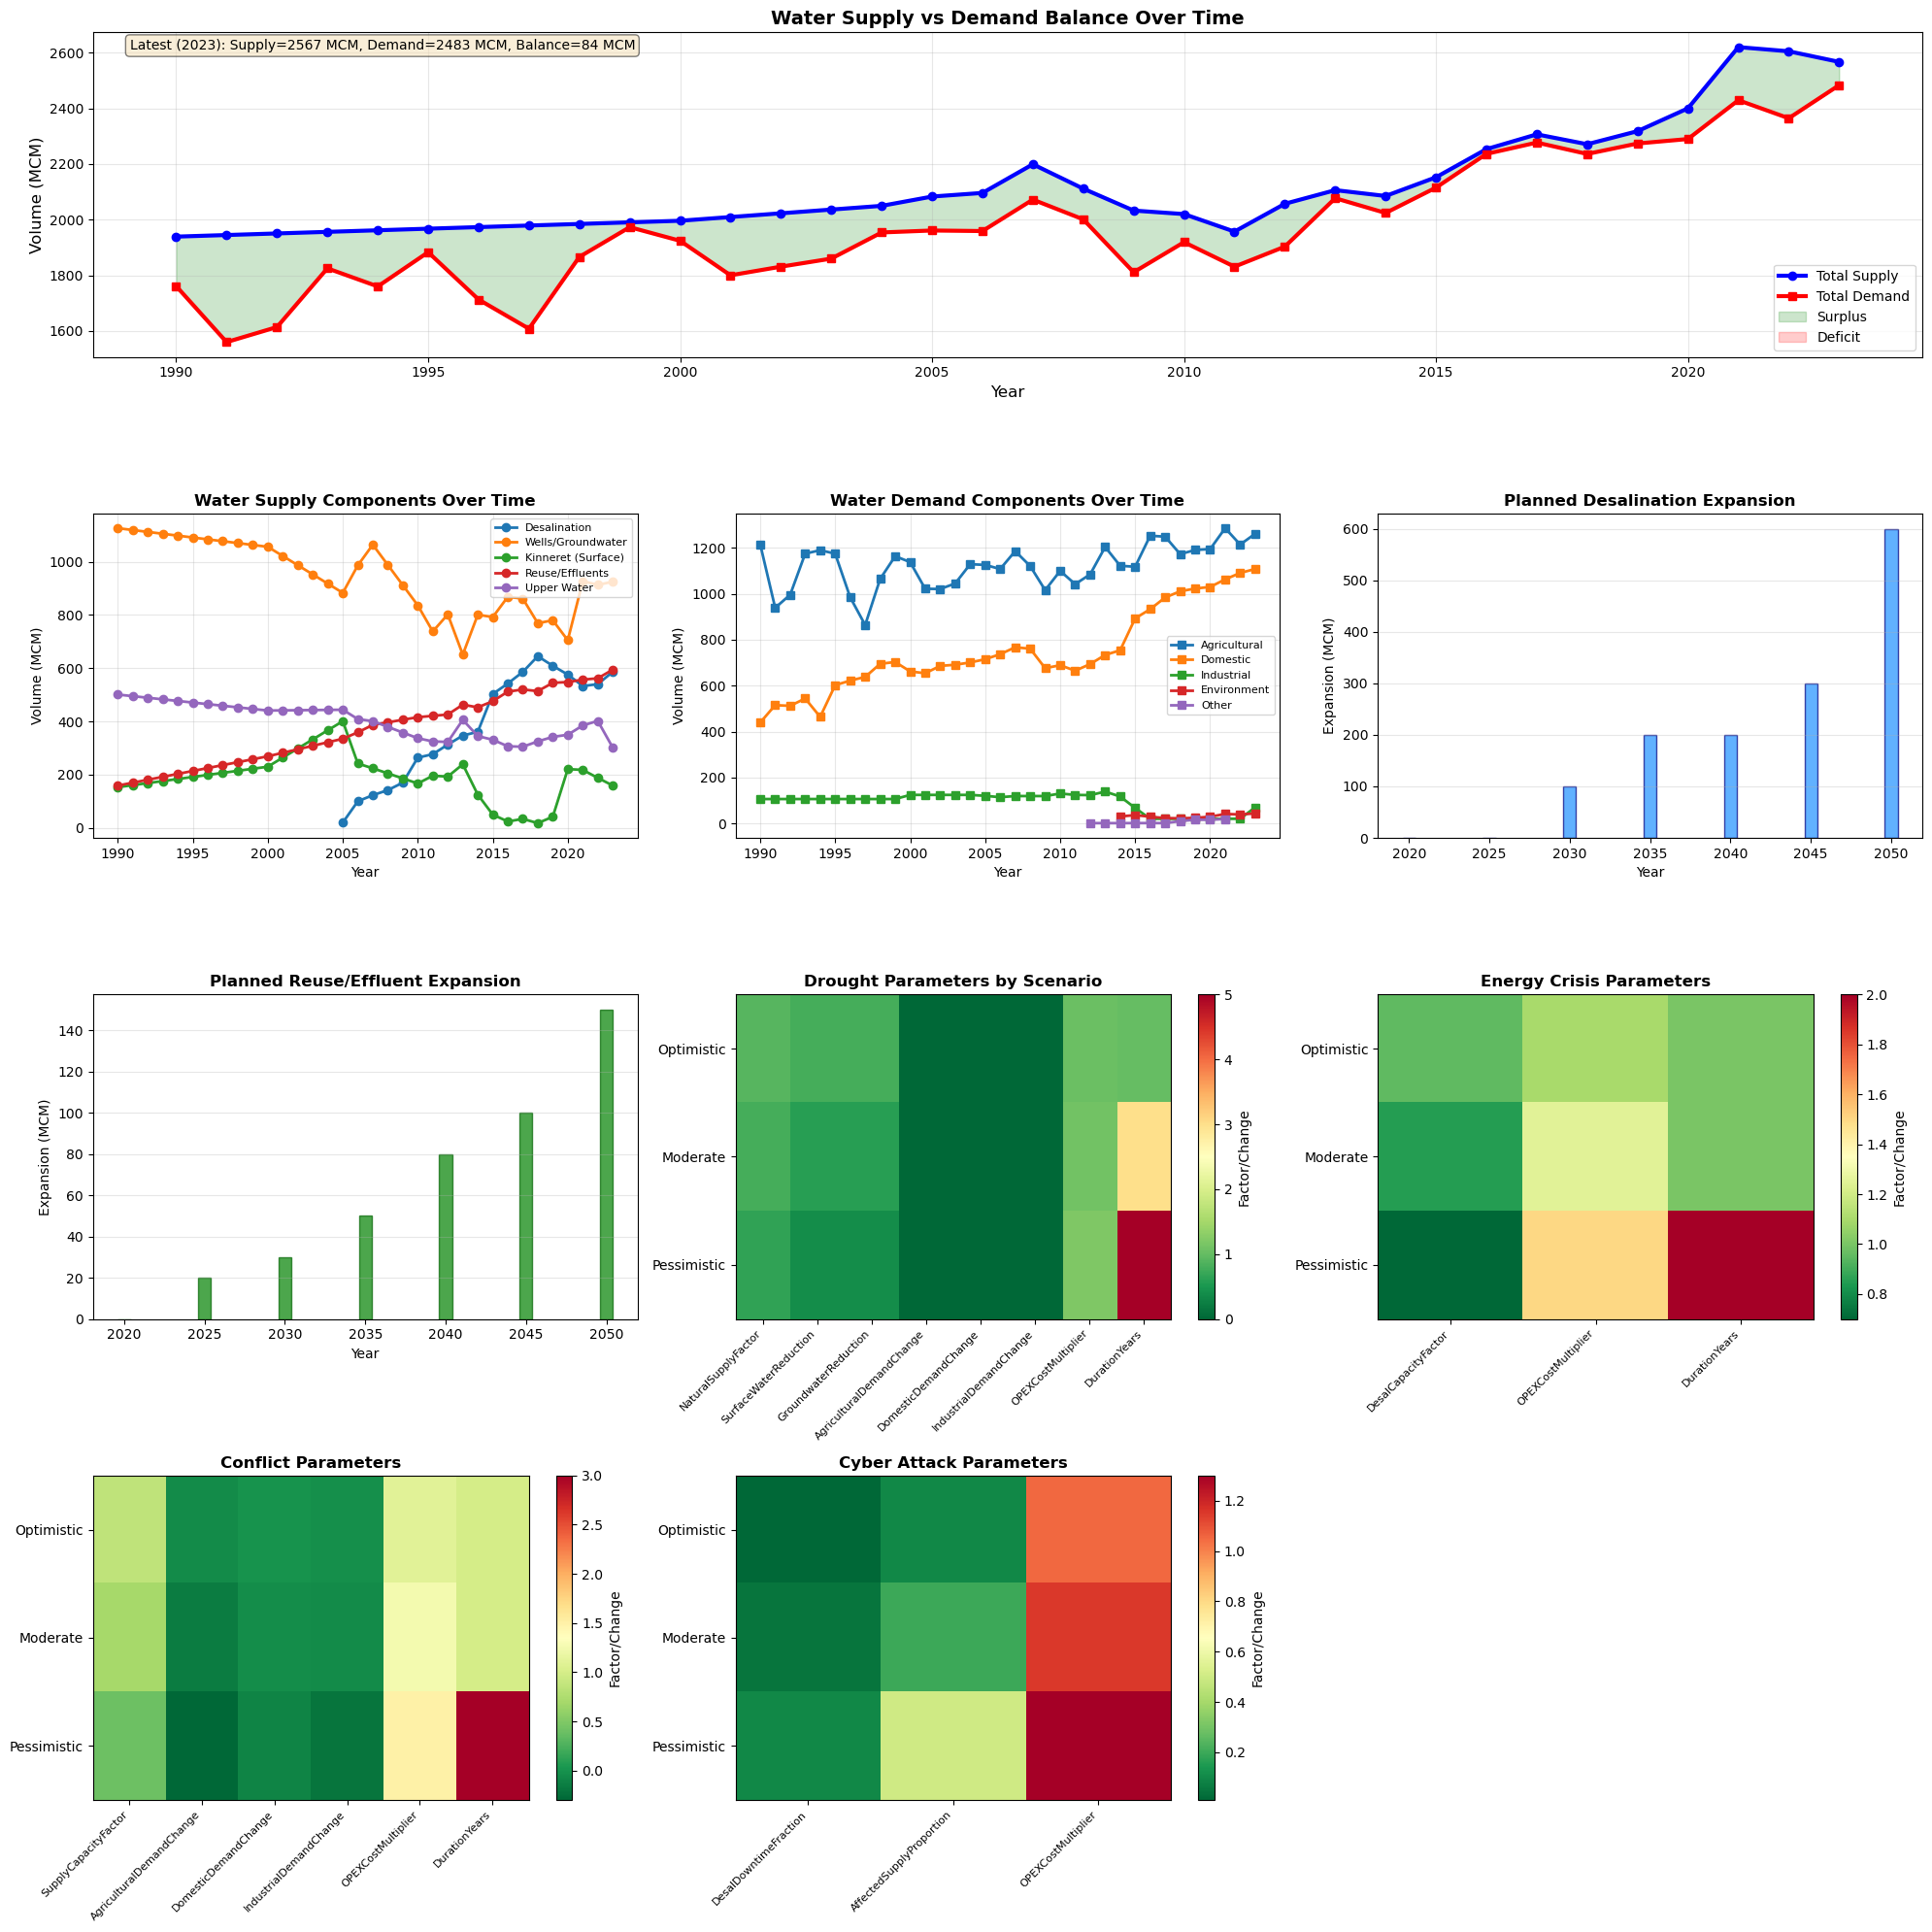

📊 CREATING FOCUSED SUPPLY-DEMAND BALANCE PLOT (1990+)
✅ Focused balance plot saved as 'supply_demand_balance_1990_onwards.png'


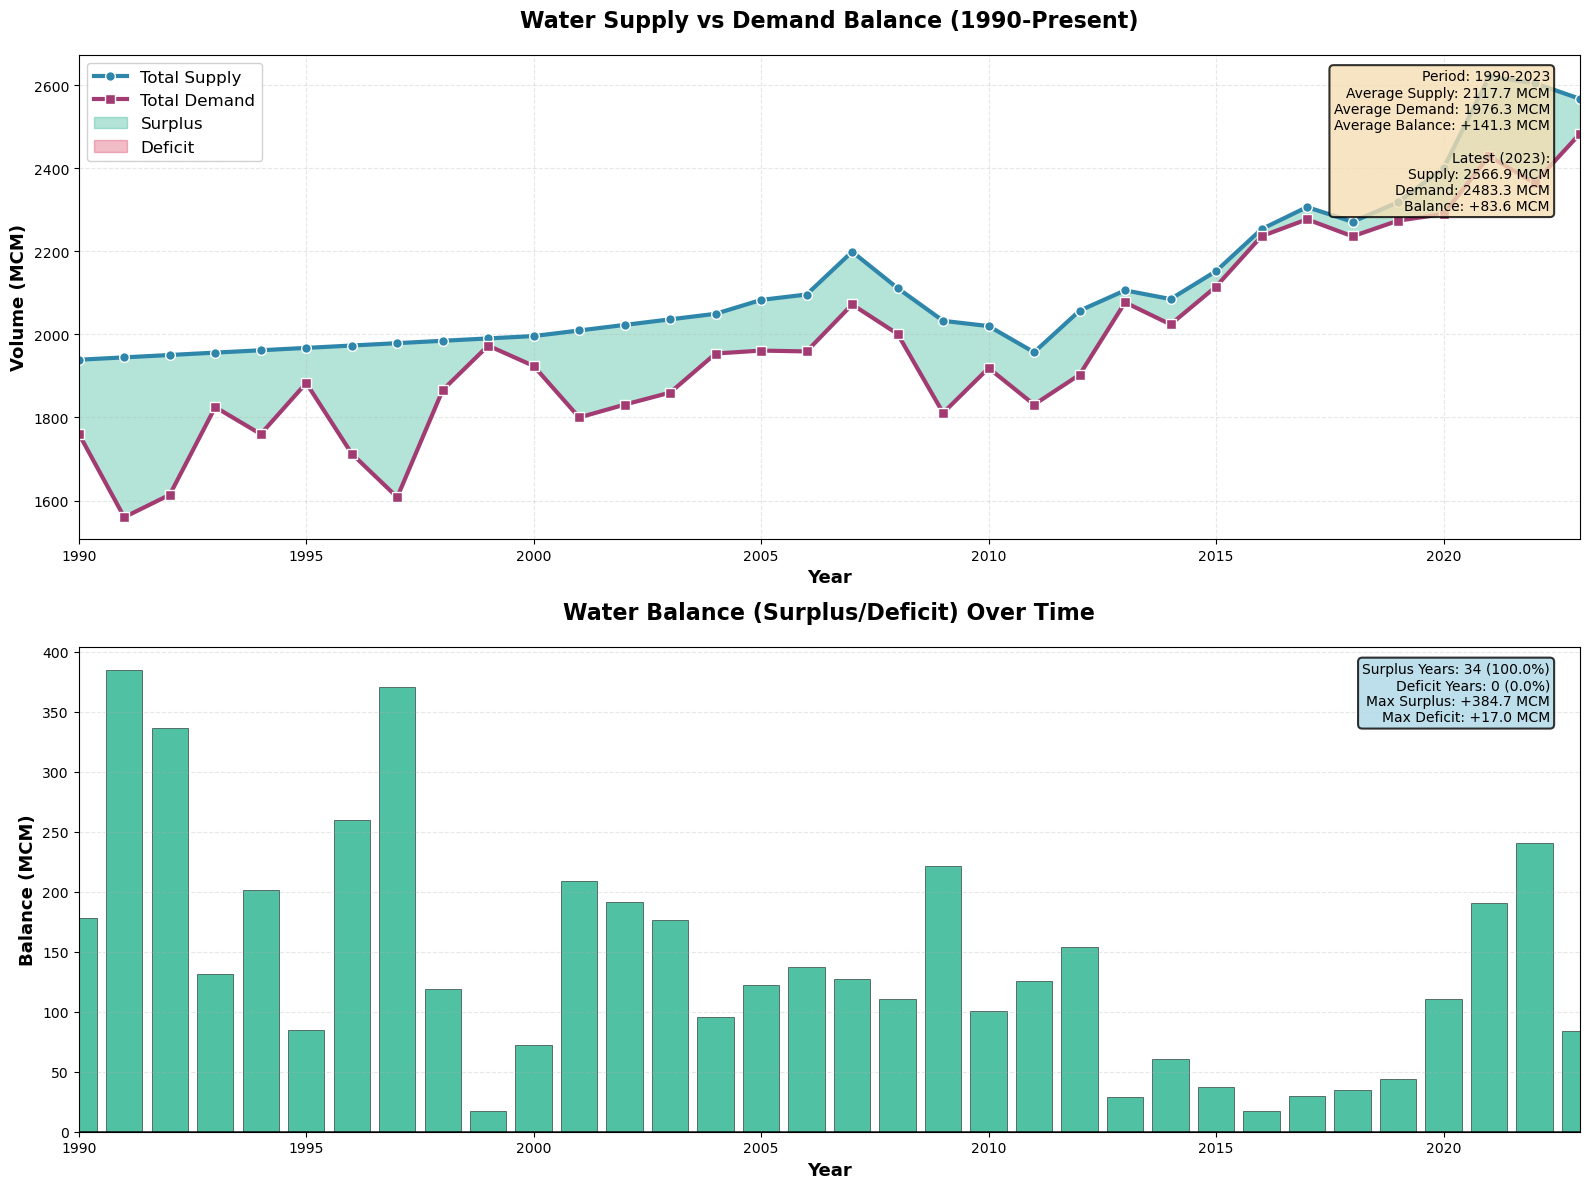


SUMMARY STATISTICS (1990-Present)
Period: 1990-2023 (34 years)

SUPPLY:
  Average: 2117.7 MCM
  Min: 1939.0 MCM
  Max: 2620.0 MCM
  Latest (2023): 2566.9 MCM

DEMAND:
  Average: 1976.3 MCM
  Min: 1560.0 MCM
  Max: 2483.3 MCM
  Latest (2023): 2483.3 MCM

BALANCE:
  Average: +141.3 MCM
  Max Surplus: +384.7 MCM
  Max Deficit: +17.0 MCM
  Latest (2023): +83.6 MCM
  Surplus Years: 34 (100.0%)
  Deficit Years: 0 (0.0%)

✅ ALL DATA VISUALIZED SUCCESSFULLY


In [56]:
# =============================================================================
# RAW DATA ANALYSIS - Process and analyze historical data
# =============================================================================

print("📊 RAW DATA ANALYSIS")  # Heading for raw data analysis section
print("=" * 60)  # Print a separator line for readability
print("Working with actual historical data without applying sustainability caps")  # Explain that no caps are applied
print("📋 Raw Data Analysis Mode")  # Indicate mode of analysis
print("   No sustainability caps will be applied")  # Clarify caps are not applied
print("   Using actual historical supply and demand values")  # Note using raw historical values
print()  # Blank line for spacing

# Load and harmonize dataset
print("📥 Loading dataset...")  # Notify user that dataset is being loaded
df = df_raw.copy()  # Create a copy of the raw data for processing
print(f"✅ Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")  # Report number of rows and columns

print("🔄 Harmonizing dataset...")  # Indicate that column mapping/harmonization will occur
df = map_columns(df, source_type='raw_csv')  # Harmonize column names using custom function
print(f"✅ Dataset harmonized: {df.shape[0]} rows × {df.shape[1]} columns")  # Confirm harmonization completed

# Calculate indicators
print("🔄 Calculating indicators...")  # Notify that indicator computation is starting
df_agg = recompute_indicators(df)  # Compute aggregated indicators on harmonized data
print(f"✅ Indicators calculated: {df_agg.shape[0]} rows × {df_agg.shape[1]} columns")  # Report new shape after indicators

# Create visualizations
print("📊 Creating Raw Data Visualizations...")  # Announce creation of visualizations
print("=" * 60)  # Separator line

# Filter to 1990+ for analysis
df_analysis = df_agg[df_agg['year'] >= 1990].copy()  # Filter aggregated data to years >= 1990
print(f"✅ Using data from {df_analysis['year'].min()}-{df_analysis['year'].max()} ({len(df_analysis)} years)")  # Report year range used

# =============================================================================
# DATA VISUALIZATION - Plot all loaded data
# =============================================================================

print("📊 VISUALIZING LOADED DATA")  # Heading for visualization section
print("=" * 60)  # Separator line
print()  # Blank line

# Create a comprehensive figure with multiple subplots
fig = plt.figure(figsize=(20, 20))  # Initialize a figure with large size to accommodate multiple subplots

# Determine year column name
year_col = 'Year' if 'Year' in df_raw.columns else 'year' if 'year' in df_raw.columns else None  # Determine whether 'Year' or 'year' column exists

# 1. Supply vs Demand Balance (MAIN PLOT - takes full width)
ax1 = plt.subplot(4, 3, (1, 3))  # Create a subplot occupying columns 1 to 3 in first row
if year_col:
    # Calculate total supply
    supply_cols_map = {
        'Water desalination (mCm)': 'Water desalination (mCm)',  # Desalinated water column
        'total produced by wells (milion m3)': 'total produced by wells (milion m3)',  # Groundwater from wells
        'produced by Kinneret (milion m3)': 'produced by Kinneret (milion m3)',  # Surface water from Kinneret
        'produced by Effluents (milion m3)': 'produced by Effluents (milion m3)',  # Reused effluent water
        'total produced by Upper water (milion m3)': 'total produced by Upper water (milion m3)'  # Upper water supply
    }
    
    total_supply = pd.Series(0, index=df_raw.index)  # Initialize total supply series with zeros
    for col in supply_cols_map.values():  # Iterate through mapped supply columns
        if col in df_raw.columns:
            total_supply += df_raw[col].fillna(0)  # Add column values to total supply, filling NaNs with zero
    
    # Calculate total demand
    demand_cols_map = {
        'Agricultural (milion m3)': 'Agricultural (milion m3)',  # Agricultural demand
        'Domestic (milion m3)': 'Domestic (milion m3)',  # Domestic demand
        'Industrial (milion m3)': 'Industrial (milion m3)',  # Industrial demand
        ' Water for the environment (milion m3)': ' Water for the environment (milion m3)',  # Environmental water demand
        '       Other suppliers ': '       Other suppliers '  # Other demand sources
    }
    
    total_demand = pd.Series(0, index=df_raw.index)  # Initialize total demand series with zeros
    for col in demand_cols_map.values():  # Iterate through mapped demand columns
        if col in df_raw.columns:
            total_demand += df_raw[col].fillna(0)  # Add column values to total demand, filling NaNs with zero
    
    # Plot supply and demand
    ax1.plot(df_raw[year_col], total_supply, marker='o', linewidth=3, 
             label='Total Supply', color='blue', markersize=6)  # Plot total supply over years
    ax1.plot(df_raw[year_col], total_demand, marker='s', linewidth=3, 
             label='Total Demand', color='red', markersize=6)  # Plot total demand over years
    
    # Calculate and show balance
    balance = total_supply - total_demand  # Compute difference between supply and demand
    ax1.fill_between(df_raw[year_col], total_supply, total_demand, 
                      where=(total_supply >= total_demand), 
                      color='green', alpha=0.2, label='Surplus')  # Shade surplus areas
    ax1.fill_between(df_raw[year_col], total_supply, total_demand, 
                      where=(total_supply < total_demand), 
                      color='red', alpha=0.2, label='Deficit')  # Shade deficit areas
    
    ax1.set_title('Water Supply vs Demand Balance Over Time', fontsize=14, fontweight='bold')  # Title for main plot
    ax1.set_xlabel('Year', fontsize=12)  # X-axis label
    ax1.set_ylabel('Volume (MCM)', fontsize=12)  # Y-axis label
    ax1.legend(loc='best', fontsize=10)  # Show legend
    ax1.grid(True, alpha=0.3)  # Add grid lines
    
    # Add text showing current balance
    latest_year = df_raw[year_col].max()  # Determine latest year in dataset
    latest_supply = total_supply[df_raw[year_col] == latest_year].values[0]  # Latest supply value
    latest_demand = total_demand[df_raw[year_col] == latest_year].values[0]  # Latest demand value
    latest_balance = latest_supply - latest_demand  # Latest balance
    balance_text = f"Latest ({latest_year:.0f}): Supply={latest_supply:.0f} MCM, Demand={latest_demand:.0f} MCM, Balance={latest_balance:.0f} MCM"  # Compose text string
    ax1.text(0.02, 0.98, balance_text, transform=ax1.transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))  # Place text on plot

# 2. Main Dataset - Time Series of Supply Components
ax2 = plt.subplot(4, 3, 4)  # Create subplot in row 2, column 1
if year_col:
    # Plot water supply components if they exist
    supply_cols = {
        'water_desalination_mcm': 'Desalination',
        'Water desalination (mCm)': 'Desalination',
        'total_produced_by_wells_milion_m3': 'Wells/Groundwater',
        'total produced by wells (milion m3)': 'Wells/Groundwater',
        'produced_by_kinneret_milion_m3': 'Kinneret (Surface)',
        'produced by Kinneret (milion m3)': 'Kinneret (Surface)',
        'produced_by_effluents_milion_m3': 'Reuse/Effluents',
        'produced by Effluents (milion m3)': 'Reuse/Effluents',
        'total_produced_by_upper_water_milion_m3': 'Upper Water',
        'total produced by Upper water (milion m3)': 'Upper Water'
    }
    
    plotted = False  # Flag to indicate whether any supply component was plotted
    for col, label in supply_cols.items():  # Iterate through possible supply columns
        if col in df_raw.columns:
            ax2.plot(df_raw[year_col], df_raw[col], marker='o', label=label, linewidth=2)  # Plot the supply component
            plotted = True  # Set flag to True
    
    if plotted:
        ax2.set_title('Water Supply Components Over Time', fontsize=12, fontweight='bold')  # Set subplot title
        ax2.set_xlabel('Year')  # X-axis label
        ax2.set_ylabel('Volume (MCM)')  # Y-axis label
        ax2.legend(loc='best', fontsize=8)  # Display legend
        ax2.grid(True, alpha=0.3)  # Add grid lines
    else:
        ax2.text(0.5, 0.5, 'Supply data\nnot found', ha='center', va='center', transform=ax2.transAxes)  # Inform no supply data found
        ax2.set_title('Water Supply Components Over Time', fontsize=12, fontweight='bold')  # Set title

# 3. Main Dataset - Demand Components
ax3 = plt.subplot(4, 3, 5)  # Create subplot in row 2, column 2
if year_col:
    demand_cols = {
        'agricultural_milion_m3': 'Agricultural',
        'Agricultural (milion m3)': 'Agricultural',
        'domestic_milion_m3': 'Domestic',
        'Domestic (milion m3)': 'Domestic',
        'industrial_milion_m3': 'Industrial',
        'Industrial (milion m3)': 'Industrial',
        'water_for_the_environment_milion_m3': 'Environment',
        ' Water for the environment (milion m3)': 'Environment',
        'other_suppliers': 'Other',
        '       Other suppliers ': 'Other'
    }
    
    plotted = False  # Flag to track plotting
    for col, label in demand_cols.items():  # Iterate through demand columns
        if col in df_raw.columns:
            ax3.plot(df_raw[year_col], df_raw[col], marker='s', label=label, linewidth=2)  # Plot demand component
            plotted = True  # Set flag to True
    
    if plotted:
        ax3.set_title('Water Demand Components Over Time', fontsize=12, fontweight='bold')  # Title
        ax3.set_xlabel('Year')  # X-axis label
        ax3.set_ylabel('Volume (MCM)')  # Y-axis label
        ax3.legend(loc='best', fontsize=8)  # Legend
        ax3.grid(True, alpha=0.3)  # Grid
    else:
        ax3.text(0.5, 0.5, 'Demand data\nnot found', ha='center', va='center', transform=ax3.transAxes)  # Inform missing data
        ax3.set_title('Water Demand Components Over Time', fontsize=12, fontweight='bold')  # Title

# 4. Expansion Schedule - Desalination
ax4 = plt.subplot(4, 3, 6)  # Create subplot in row 2, column 3
if len(expansions) > 0:
    exp_year_col = 'Year' if 'Year' in expansions.columns else 'year'  # Determine year column in expansions
    if 'DesalExpansionMCM' in expansions.columns:
        ax4.bar(expansions[exp_year_col], expansions['DesalExpansionMCM'], 
                color='dodgerblue', alpha=0.7, edgecolor='navy')  # Plot desalination expansions as bars
        ax4.set_title('Planned Desalination Expansion', fontsize=12, fontweight='bold')  # Title
        ax4.set_xlabel('Year')  # X-axis label
        ax4.set_ylabel('Expansion (MCM)')  # Y-axis label
        ax4.grid(True, alpha=0.3, axis='y')  # Y-axis grid lines

# 5. Expansion Schedule - Reuse
ax5 = plt.subplot(4, 3, 7)  # Create subplot in row 3, column 1
if len(expansions) > 0:
    exp_year_col = 'Year' if 'Year' in expansions.columns else 'year'  # Determine year column
    if 'ReuseExpansionMCM' in expansions.columns:
        ax5.bar(expansions[exp_year_col], expansions['ReuseExpansionMCM'], 
                color='green', alpha=0.7, edgecolor='darkgreen')  # Plot reuse expansion bars
        ax5.set_title('Planned Reuse/Effluent Expansion', fontsize=12, fontweight='bold')  # Title
        ax5.set_xlabel('Year')  # X-axis label
        ax5.set_ylabel('Expansion (MCM)')  # Y-axis label
        ax5.grid(True, alpha=0.3, axis='y')  # Y-axis grid

# 6. Drought Parameters Heatmap
ax6 = plt.subplot(4, 3, 8)  # Create subplot in row 3, column 2
if len(drought_params) > 0 and 'Parameter' in drought_params.columns:
    scenario_cols = [col for col in ['Optimistic', 'Moderate', 'Pessimistic'] if col in drought_params.columns]  # Identify scenario columns
    if scenario_cols:
        drought_matrix = drought_params[scenario_cols].T  # Transpose to create matrix for heatmap
        im = ax6.imshow(drought_matrix, cmap='RdYlGn_r', aspect='auto')  # Display heatmap
        ax6.set_yticks(range(len(scenario_cols)))  # Set y-ticks for scenarios
        ax6.set_yticklabels(scenario_cols)  # Label y-axis with scenarios
        ax6.set_xticks(range(len(drought_params)))  # Set x-ticks for parameters
        ax6.set_xticklabels(drought_params['Parameter'], rotation=45, ha='right', fontsize=8)  # Label x-axis with parameters
        ax6.set_title('Drought Parameters by Scenario', fontsize=12, fontweight='bold')  # Title
        plt.colorbar(im, ax=ax6, label='Factor/Change')  # Add colorbar legend

# 7. Energy Parameters
ax7 = plt.subplot(4, 3, 9)  # Create subplot in row 3, column 3
if len(energy_params) > 0 and 'Parameter' in energy_params.columns:
    scenario_cols = [col for col in ['Optimistic', 'Moderate', 'Pessimistic'] if col in energy_params.columns]  # Scenario columns for energy
    if scenario_cols:
        energy_matrix = energy_params[scenario_cols].T  # Transpose to create matrix
        im = ax7.imshow(energy_matrix, cmap='RdYlGn_r', aspect='auto')  # Plot heatmap
        ax7.set_yticks(range(len(scenario_cols)))  # Y-axis ticks
        ax7.set_yticklabels(scenario_cols)  # Y-axis labels
        ax7.set_xticks(range(len(energy_params)))  # X-axis ticks
        ax7.set_xticklabels(energy_params['Parameter'], rotation=45, ha='right', fontsize=8)  # X-axis labels
        ax7.set_title('Energy Crisis Parameters', fontsize=12, fontweight='bold')  # Title
        plt.colorbar(im, ax=ax7, label='Factor/Change')  # Colorbar

# 8. Conflict Parameters
ax8 = plt.subplot(4, 3, 10)  # Create subplot in row 4, column 1
if len(conflict_params) > 0 and 'Parameter' in conflict_params.columns:
    scenario_cols = [col for col in ['Optimistic', 'Moderate', 'Pessimistic'] if col in conflict_params.columns]  # Scenario columns for conflict
    if scenario_cols:
        conflict_matrix = conflict_params[scenario_cols].T  # Transpose matrix
        im = ax8.imshow(conflict_matrix, cmap='RdYlGn_r', aspect='auto')  # Heatmap
        ax8.set_yticks(range(len(scenario_cols)))  # Y-axis ticks
        ax8.set_yticklabels(scenario_cols)  # Y-axis labels
        ax8.set_xticks(range(len(conflict_params)))  # X-axis ticks
        ax8.set_xticklabels(conflict_params['Parameter'], rotation=45, ha='right', fontsize=8)  # X-axis labels
        ax8.set_title('Conflict Parameters', fontsize=12, fontweight='bold')  # Title
        plt.colorbar(im, ax=ax8, label='Factor/Change')  # Colorbar

# 9. Cyber Parameters
ax9 = plt.subplot(4, 3, 11)  # Create subplot in row 4, column 2
if len(cyber_params) > 0 and 'Parameter' in cyber_params.columns:
    scenario_cols = [col for col in ['Optimistic', 'Moderate', 'Pessimistic'] if col in cyber_params.columns]  # Scenario columns for cyber
    if scenario_cols:
        cyber_matrix = cyber_params[scenario_cols].T  # Transpose matrix
        im = ax9.imshow(cyber_matrix, cmap='RdYlGn_r', aspect='auto')  # Heatmap
        ax9.set_yticks(range(len(scenario_cols)))  # Y-axis ticks
        ax9.set_yticklabels(scenario_cols)  # Y-axis labels
        ax9.set_xticks(range(len(cyber_params)))  # X-axis ticks
        ax9.set_xticklabels(cyber_params['Parameter'], rotation=45, ha='right', fontsize=8)  # X-axis labels
        ax9.set_title('Cyber Attack Parameters', fontsize=12, fontweight='bold')  # Title
        plt.colorbar(im, ax=ax9, label='Factor/Change')  # Colorbar

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('loaded_data_visualization.png', dpi=150, bbox_inches='tight')  # Save the full visualization to file
print("✅ Visualization saved as 'loaded_data_visualization.png'")  # Confirm save
plt.show()  # Display the plots

# =============================================================================
# FOCUSED SUPPLY VS DEMAND BALANCE (1990 onwards)
# =============================================================================

print("📊 CREATING FOCUSED SUPPLY-DEMAND BALANCE PLOT (1990+)")  # Heading for focused plot
print("=" * 60)  # Separator

if year_col:
    # Filter data from 1990 onwards
    df_filtered = df_raw[df_raw[year_col] >= 1990].copy()  # Filter raw data for years >= 1990
    
    # Calculate total supply
    supply_cols_map = {
        'Water desalination (mCm)': 'Water desalination (mCm)',
        'total produced by wells (milion m3)': 'total produced by wells (milion m3)',
        'produced by Kinneret (milion m3)': 'produced by Kinneret (milion m3)',
        'produced by Effluents (milion m3)': 'produced by Effluents (milion m3)',
        'total produced by Upper water (milion m3)': 'total produced by Upper water (milion m3)'
    }
    
    total_supply = pd.Series(0, index=df_filtered.index)  # Initialize total supply series
    for col in supply_cols_map.values():  # Sum over supply columns
        if col in df_filtered.columns:
            total_supply += df_filtered[col].fillna(0)  # Add column values
    
    # Calculate total demand
    demand_cols_map = {
        'Agricultural (milion m3)': 'Agricultural (milion m3)',
        'Domestic (milion m3)': 'Domestic (milion m3)',
        'Industrial (milion m3)': 'Industrial (milion m3)',
        ' Water for the environment (milion m3)': ' Water for the environment (milion m3)',
        '       Other suppliers ': '       Other suppliers '
    }
    
    total_demand = pd.Series(0, index=df_filtered.index)  # Initialize total demand series
    for col in demand_cols_map.values():  # Sum over demand columns
        if col in df_filtered.columns:
            total_demand += df_filtered[col].fillna(0)  # Add column values
    
    # Calculate balance
    balance = total_supply - total_demand  # Compute supply minus demand
    
    # Create focused plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))  # Create two vertically stacked subplots
    
    # Plot 1: Supply vs Demand with shaded difference
    ax1.plot(df_filtered[year_col], total_supply, marker='o', linewidth=3, 
             label='Total Supply', color='#2E86AB', markersize=7, markeredgecolor='white', markeredgewidth=1)  # Plot supply
    ax1.plot(df_filtered[year_col], total_demand, marker='s', linewidth=3, 
             label='Total Demand', color='#A23B72', markersize=7, markeredgecolor='white', markeredgewidth=1)  # Plot demand
    
    # Fill between for surplus/deficit
    ax1.fill_between(df_filtered[year_col], total_supply, total_demand, 
                      where=(total_supply >= total_demand), 
                      color='#06A77D', alpha=0.3, label='Surplus', interpolate=True)  # Shade surplus areas
    ax1.fill_between(df_filtered[year_col], total_supply, total_demand, 
                      where=(total_supply < total_demand), 
                      color='#D62246', alpha=0.3, label='Deficit', interpolate=True)  # Shade deficit areas
    
    ax1.set_title('Water Supply vs Demand Balance (1990-Present)', fontsize=16, fontweight='bold', pad=20)  # Title
    ax1.set_xlabel('Year', fontsize=13, fontweight='bold')  # X-axis label
    ax1.set_ylabel('Volume (MCM)', fontsize=13, fontweight='bold')  # Y-axis label
    ax1.legend(loc='best', fontsize=12, framealpha=0.9)  # Legend
    ax1.grid(True, alpha=0.3, linestyle='--')  # Grid lines
    ax1.set_xlim(df_filtered[year_col].min(), df_filtered[year_col].max())  # X-axis range
    
    # Add statistics box
    avg_supply = total_supply.mean()  # Compute average supply
    avg_demand = total_demand.mean()  # Compute average demand
    avg_balance = balance.mean()  # Compute average balance
    latest_year = df_filtered[year_col].max()  # Latest year
    latest_supply = total_supply.values[-1]  # Latest supply value
    latest_demand = total_demand.values[-1]  # Latest demand value
    latest_balance = balance.values[-1]  # Latest balance value
    
    stats_text = f"""Period: {df_filtered[year_col].min():.0f}-{latest_year:.0f}
Average Supply: {avg_supply:.1f} MCM
Average Demand: {avg_demand:.1f} MCM
Average Balance: {avg_balance:+.1f} MCM

Latest ({latest_year:.0f}):
Supply: {latest_supply:.1f} MCM
Demand: {latest_demand:.1f} MCM
Balance: {latest_balance:+.1f} MCM"""  # Construct statistics text block
    
    ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1.5))  # Display stats box
    
    # Plot 2: Balance (Surplus/Deficit) Over Time
    colors = ['#06A77D' if b >= 0 else '#D62246' for b in balance]  # Choose color based on surplus or deficit
    ax2.bar(df_filtered[year_col], balance, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)  # Plot balance as bar chart
    ax2.axhline(0, color='black', linewidth=2, linestyle='-', alpha=0.8)  # Draw horizontal zero line
    
    ax2.set_title('Water Balance (Surplus/Deficit) Over Time', fontsize=16, fontweight='bold', pad=20)  # Title
    ax2.set_xlabel('Year', fontsize=13, fontweight='bold')  # X-axis label
    ax2.set_ylabel('Balance (MCM)', fontsize=13, fontweight='bold')  # Y-axis label
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')  # Y-axis grid lines
    ax2.set_xlim(df_filtered[year_col].min(), df_filtered[year_col].max())  # X-axis range
    
    # Add balance statistics
    surplus_years = (balance >= 0).sum()  # Count years with surplus
    deficit_years = (balance < 0).sum()  # Count years with deficit
    max_surplus = balance.max()  # Maximum surplus
    max_deficit = balance.min()  # Maximum deficit (negative)
    
    balance_stats = f"""Surplus Years: {surplus_years} ({surplus_years/len(balance)*100:.1f}%)
Deficit Years: {deficit_years} ({deficit_years/len(balance)*100:.1f}%)
Max Surplus: {max_surplus:+.1f} MCM
Max Deficit: {max_deficit:+.1f} MCM"""  # Construct balance stats text
    
    ax2.text(0.98, 0.97, balance_stats, transform=ax2.transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, edgecolor='black', linewidth=1.5))  # Display balance stats box
    
    plt.tight_layout()  # Adjust layout
    plt.savefig('supply_demand_balance_1990_onwards.png', dpi=150, bbox_inches='tight')  # Save focused plot
    print("✅ Focused balance plot saved as 'supply_demand_balance_1990_onwards.png'")  # Notify user of save
    plt.show()  # Show the plot
    
    # Print summary statistics
    print()  # Blank line
    print("=" * 60)  # Separator
    print("SUMMARY STATISTICS (1990-Present)")  # Summary section title
    print("=" * 60)  # Separator
    print(f"Period: {df_filtered[year_col].min():.0f}-{latest_year:.0f} ({len(df_filtered)} years)")  # Period summary
    print()  # Blank line
    print("SUPPLY:")  # Supply stats heading
    print(f"  Average: {avg_supply:.1f} MCM")  # Average supply
    print(f"  Min: {total_supply.min():.1f} MCM")  # Minimum supply
    print(f"  Max: {total_supply.max():.1f} MCM")  # Maximum supply
    print(f"  Latest ({latest_year:.0f}): {latest_supply:.1f} MCM")  # Latest supply value
    print()  # Blank line
    print("DEMAND:")  # Demand stats heading
    print(f"  Average: {avg_demand:.1f} MCM")  # Average demand
    print(f"  Min: {total_demand.min():.1f} MCM")  # Minimum demand
    print(f"  Max: {total_demand.max():.1f} MCM")  # Maximum demand
    print(f"  Latest ({latest_year:.0f}): {latest_demand:.1f} MCM")  # Latest demand value
    print()  # Blank line
    print("BALANCE:")  # Balance stats heading
    print(f"  Average: {avg_balance:+.1f} MCM")  # Average balance
    print(f"  Max Surplus: {max_surplus:+.1f} MCM")  # Maximum surplus
    print(f"  Max Deficit: {max_deficit:+.1f} MCM")  # Maximum deficit
    print(f"  Latest ({latest_year:.0f}): {latest_balance:+.1f} MCM")  # Latest balance value
    print(f"  Surplus Years: {surplus_years} ({surplus_years/len(balance)*100:.1f}%)")  # Number and percentage of surplus years
    print(f"  Deficit Years: {deficit_years} ({deficit_years/len(balance)*100:.1f}%)")  # Number and percentage of deficit years
    print("=" * 60)  # Closing separator
else:
    print("⚠️ Year column not found in dataset")  # Warn if year column is missing

print()  # Blank line
print("=" * 60)  # Separator
print("✅ ALL DATA VISUALIZED SUCCESSFULLY")  # Final success message
print("=" * 60)  # Separator

📊 Creating Raw Data Visualizations...
✅ Using data from 1990-2023 (34 years)
✅ Raw historical data analysis saved as 'raw_historical_data_analysis.png'


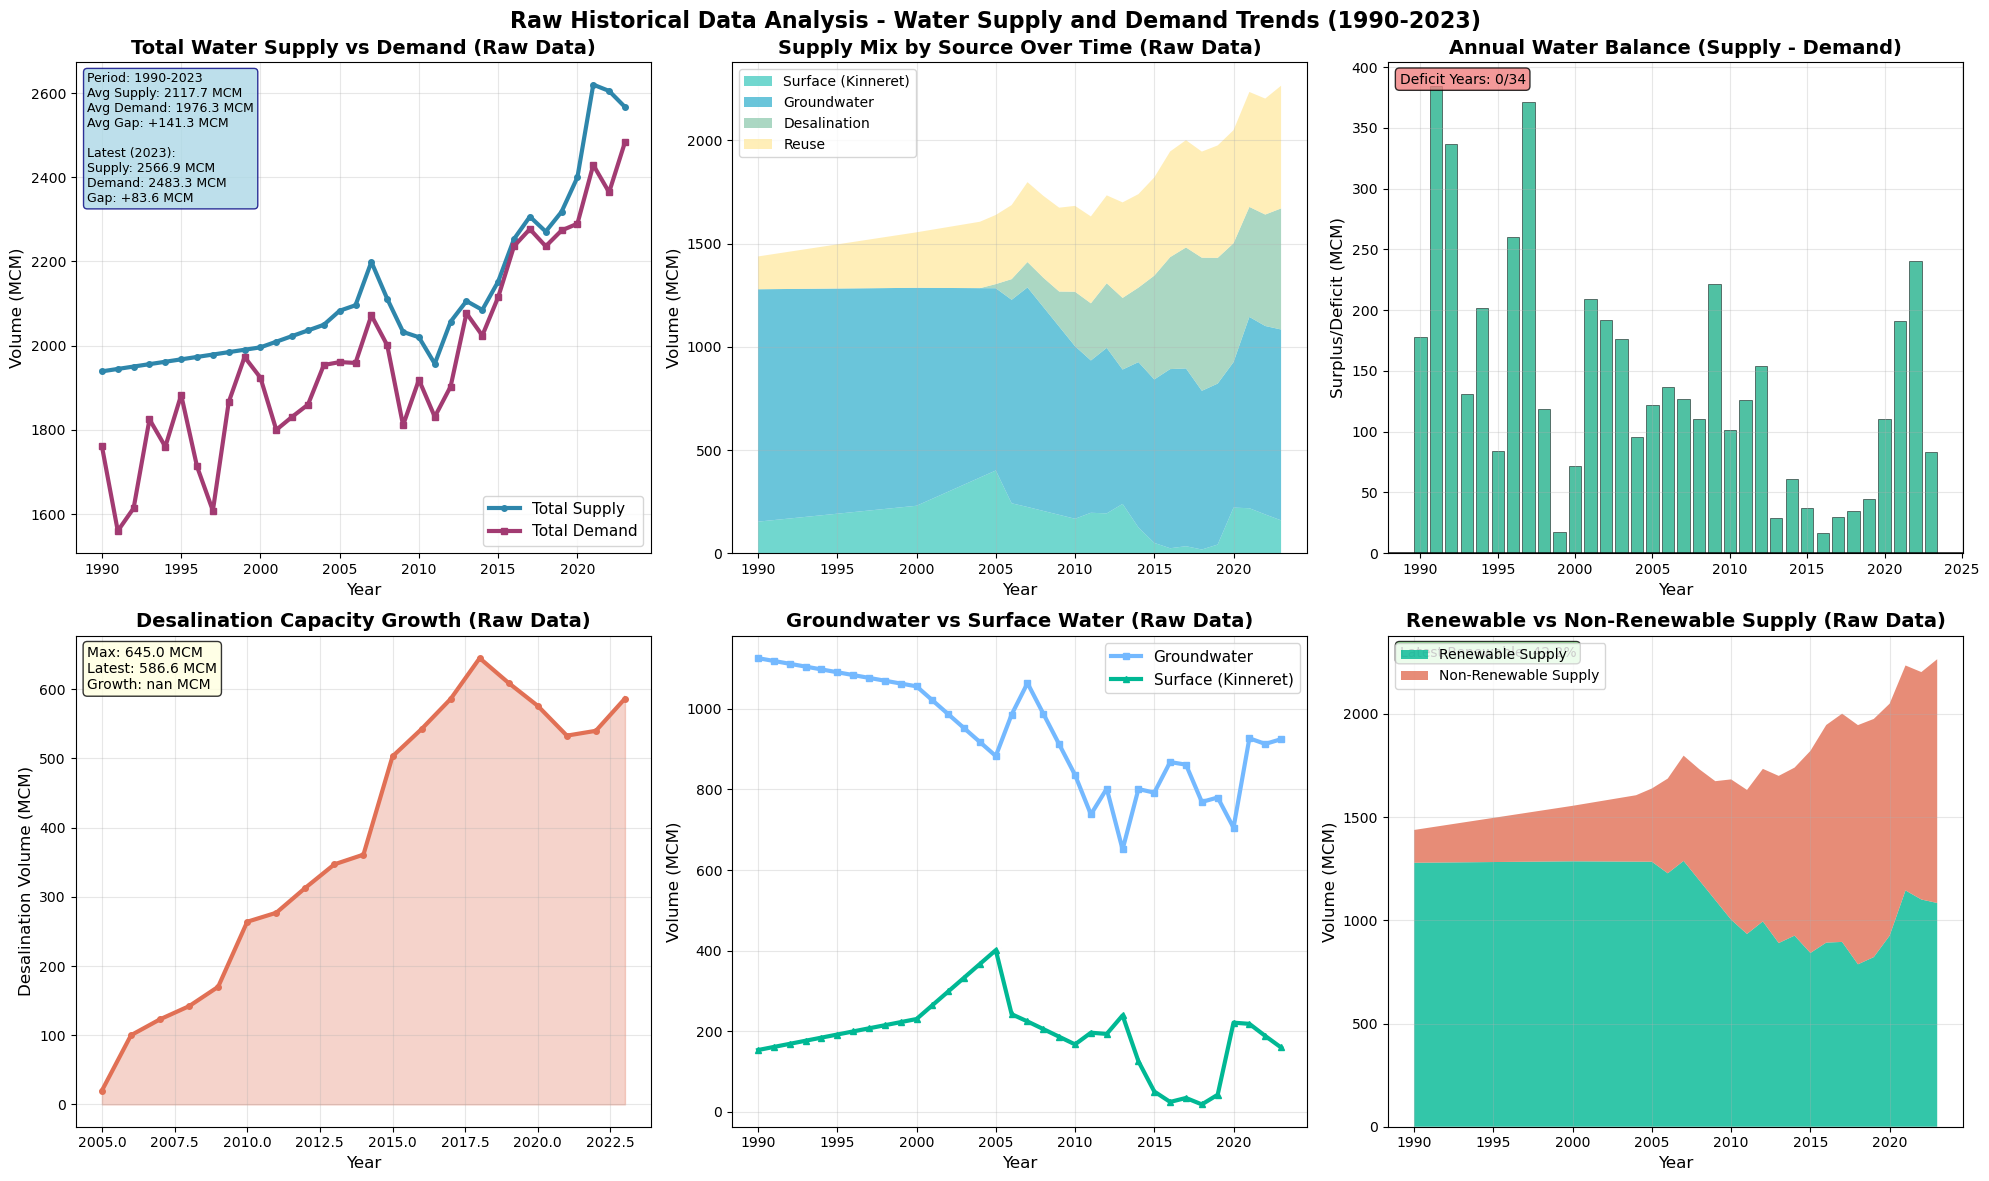


📊 Raw Data Supply Composition (Every 5 years):
Year | Surface | Groundwater | Desalination | Reuse | Total
---------------------------------------------------------------------------
1990 |   153.0 |      1126.0 |          nan | 159.0 | 1939.0
1995 |   191.5 |      1091.0 |          nan | 214.0 | 1967.5
2000 |   230.0 |      1056.0 |          nan | 269.0 | 1996.0
2005 |   401.0 |       883.0 |         20.0 | 335.0 | 2083.0
2010 |   167.0 |       836.0 |        264.0 | 416.0 | 2020.0
2015 |    50.0 |       792.0 |        503.0 | 476.0 | 2152.3
2020 |   221.0 |       705.0 |        576.0 | 548.0 | 2400.0

🎉 Raw data visualizations complete!
📊 All charts show actual historical values without sustainability caps
💾 Data available in 'df_agg' variable for further analysis


In [57]:
"""
This module performs raw data visualization of water supply and demand trends.

It assumes that `df_agg` is already defined from a prior raw data analysis
cell. The script includes multiple charts to illustrate supply and demand
trends over time, including breakdowns by source and comparison of
renewable versus non‑renewable supply.

Each line is commented to explain what is happening in the code without
changing the underlying functionality.
"""

# =============================================================================
# RAW DATA VISUALIZATION - Comprehensive charts showing raw historical data
# =============================================================================

# Print a header indicating that raw data visualizations are being created
print("📊 Creating Raw Data Visualizations...")
# Print a separator line for readability
print("=" * 60)

# Check if df_agg exists from the raw data analysis
if 'df_agg' not in globals():
    # If df_agg isn't defined, warn the user to run the raw data analysis first
    print("❌ Error: df_agg variable not found. Please run the Raw Data Analysis cell first.")
else:
    # If df_agg is available, print the date range covered
    print(f"✅ Using data from {df_agg['year'].min()}-{df_agg['year'].max()} ({len(df_agg)} years)")
    
    # Create comprehensive visualization
    # Set up a figure with 2 rows and 3 columns of subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    # Add a main title for the figure
    fig.suptitle('Raw Historical Data Analysis - Water Supply and Demand Trends (1990-2023)', 
                 fontsize=16, fontweight='bold')
    
    # -------------------------------------------------------------------------
    # 1. Total Supply vs Demand Trends
    # Create the first subplot in the top-left position
    ax1 = axes[0, 0]
    # Plot total supply over time using a line plot with markers
    ax1.plot(df_agg['year'], df_agg['total_supply_mcm'], label='Total Supply', 
             linewidth=3, color='#2E86AB', marker='o', markersize=4)
    # Plot total demand over time using a line plot with markers
    ax1.plot(df_agg['year'], df_agg['total_demand'], label='Total Demand', 
             linewidth=3, color='#A23B72', marker='s', markersize=4)
    # Label the x-axis as Year
    ax1.set_xlabel('Year', fontsize=12)
    # Label the y-axis as Volume (MCM)
    ax1.set_ylabel('Volume (MCM)', fontsize=12)
    # Set a descriptive title for the subplot
    ax1.set_title('Total Water Supply vs Demand (Raw Data)', fontsize=14, fontweight='bold')
    # Show a legend for the plotted lines
    ax1.legend(fontsize=11)
    # Add a light grid for readability
    ax1.grid(True, alpha=0.3)
    
    # Compute statistics for the stats box on the first plot
    avg_supply = df_agg['total_supply_mcm'].mean()
    avg_demand = df_agg['total_demand'].mean()
    avg_gap = df_agg['surplus_mcm'].mean()
    latest_supply = df_agg['total_supply_mcm'].iloc[-1]
    latest_demand = df_agg['total_demand'].iloc[-1]
    latest_gap = df_agg['surplus_mcm'].iloc[-1]
    
    # Build a multi‑line string summarizing the statistics
    stats_text = f"""Period: {df_agg['year'].min()}-{df_agg['year'].max()}
Avg Supply: {avg_supply:.1f} MCM
Avg Demand: {avg_demand:.1f} MCM
Avg Gap: {avg_gap:+.1f} MCM

Latest ({df_agg['year'].iloc[-1]}):
Supply: {latest_supply:.1f} MCM
Demand: {latest_demand:.1f} MCM
Gap: {latest_gap:+.1f} MCM"""
    
    # Display the statistics text inside a boxed annotation on the plot
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
             fontsize=9, verticalalignment='top', horizontalalignment='left',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, edgecolor='navy'))
    
    # -------------------------------------------------------------------------
    # 2. Supply Mix Over Time (Stacked Area)
    # Create the second subplot in the top-middle position
    ax2 = axes[0, 1]
    # Extract the year values for the x-axis
    years = df_agg['year']
    # Extract individual supply components, filling missing values with zero
    surface = df_agg['produced_by_kinneret_milion_m3'].fillna(0)
    ground = df_agg['capped_groundwater'].fillna(0)
    desal = df_agg['water_desalination_mcm'].fillna(0)
    reuse = df_agg['capped_reuse'].fillna(0)
    
    # Plot a stacked area chart of supply components over time
    ax2.stackplot(years, surface, ground, desal, reuse,
                  labels=['Surface (Kinneret)', 'Groundwater', 'Desalination', 'Reuse'],
                  colors=['#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'], alpha=0.8)
    # Label the axes
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Volume (MCM)', fontsize=12)
    # Title for the stacked area chart
    ax2.set_title('Supply Mix by Source Over Time (Raw Data)', fontsize=14, fontweight='bold')
    # Show the legend for different supply sources
    ax2.legend(loc='upper left', fontsize=10)
    # Add a light grid
    ax2.grid(True, alpha=0.3)
    
    # -------------------------------------------------------------------------
    # 3. Supply Gap (Surplus/Deficit)
    # Create the third subplot in the top-right position
    ax3 = axes[0, 2]
    # Determine colors for each bar based on whether the surplus is positive or negative
    colors = ['#06A77D' if x >= 0 else '#D62246' for x in df_agg['surplus_mcm']]
    # Plot the surplus (or deficit) as a bar chart
    bars = ax3.bar(df_agg['year'], df_agg['surplus_mcm'], color=colors, alpha=0.7, 
                   edgecolor='black', linewidth=0.5)
    # Draw a horizontal line at zero for reference
    ax3.axhline(0, color='black', linewidth=2, linestyle='-', alpha=0.8)
    # Label axes
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylabel('Surplus/Deficit (MCM)', fontsize=12)
    # Set a title for the bar chart
    ax3.set_title('Annual Water Balance (Supply - Demand)', fontsize=14, fontweight='bold')
    # Add a grid for readability
    ax3.grid(True, alpha=0.3)
    
    # Compute and display the number of deficit years in a text box
    deficit_years = (df_agg['surplus_mcm'] < 0).sum()
    ax3.text(0.02, 0.98, f'Deficit Years: {deficit_years}/{len(df_agg)}', 
             transform=ax3.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # -------------------------------------------------------------------------
    # 4. Desalination Growth Over Time
    # Create the fourth subplot in the bottom-left position
    ax4 = axes[1, 0]
    # Plot desalination volumes over the years
    ax4.plot(df_agg['year'], df_agg['water_desalination_mcm'], 
             linewidth=3, color='#E17055', marker='o', markersize=4)
    # Shade the area under the desalination curve for emphasis
    ax4.fill_between(df_agg['year'], df_agg['water_desalination_mcm'], 
                     alpha=0.3, color='#E17055')
    # Label axes
    ax4.set_xlabel('Year', fontsize=12)
    ax4.set_ylabel('Desalination Volume (MCM)', fontsize=12)
    # Title for desalination growth
    ax4.set_title('Desalination Capacity Growth (Raw Data)', fontsize=14, fontweight='bold')
    # Add a light grid
    ax4.grid(True, alpha=0.3)
    
    # Compute statistics on desalination volumes
    max_desal = df_agg['water_desalination_mcm'].max()
    latest_desal = df_agg['water_desalination_mcm'].iloc[-1]
    # Construct a multi‑line stats string showing max, latest and growth
    desal_stats = f"""Max: {max_desal:.1f} MCM
Latest: {latest_desal:.1f} MCM
Growth: {latest_desal - df_agg['water_desalination_mcm'].iloc[0]:.1f} MCM"""
    # Display desalination statistics in a text box
    ax4.text(0.02, 0.98, desal_stats, transform=ax4.transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # -------------------------------------------------------------------------
    # 5. Groundwater vs Surface Water
    # Create the fifth subplot in the bottom-middle position
    ax5 = axes[1, 1]
    # Plot groundwater production over time
    ax5.plot(df_agg['year'], df_agg['capped_groundwater'], 
             label='Groundwater', linewidth=3, color='#74B9FF', marker='s', markersize=4)
    # Plot surface water production over time
    ax5.plot(df_agg['year'], df_agg['produced_by_kinneret_milion_m3'], 
             label='Surface (Kinneret)', linewidth=3, color='#00B894', marker='^', markersize=4)
    # Label axes
    ax5.set_xlabel('Year', fontsize=12)
    ax5.set_ylabel('Volume (MCM)', fontsize=12)
    # Title for comparison of groundwater vs surface water
    ax5.set_title('Groundwater vs Surface Water (Raw Data)', fontsize=14, fontweight='bold')
    # Show legend identifying the lines
    ax5.legend(fontsize=11)
    # Add a grid for visual clarity
    ax5.grid(True, alpha=0.3)
    
    # -------------------------------------------------------------------------
    # 6. Renewable vs Non-Renewable Supply
    # Create the sixth subplot in the bottom-right position
    ax6 = axes[1, 2]
    # Calculate renewable supply as the sum of surface and groundwater
    renewable = df_agg['produced_by_kinneret_milion_m3'].fillna(0) + df_agg['capped_groundwater'].fillna(0)
    # Calculate non‑renewable supply as the sum of desalination and reuse
    non_renewable = df_agg['water_desalination_mcm'].fillna(0) + df_agg['capped_reuse'].fillna(0)
    
    # Plot renewable and non‑renewable supply as stacked area over the years
    ax6.stackplot(years, renewable, non_renewable, 
                  labels=['Renewable Supply', 'Non-Renewable Supply'],
                  colors=['#00B894', '#E17055'], alpha=0.8)
    # Label axes
    ax6.set_xlabel('Year', fontsize=12)
    ax6.set_ylabel('Volume (MCM)', fontsize=12)
    # Title for renewable vs non‑renewable supply
    ax6.set_title('Renewable vs Non-Renewable Supply (Raw Data)', fontsize=14, fontweight='bold')
    # Show legend for the stacked areas
    ax6.legend(loc='upper left', fontsize=10)
    # Add a light grid
    ax6.grid(True, alpha=0.3)
    
    # Calculate the latest renewable supply percentage of total supply
    latest_renewable_pct = (renewable.iloc[-1] / df_agg['total_supply_mcm'].iloc[-1]) * 100
    # Display the renewable percentage in a text box
    ax6.text(0.02, 0.98, f'Latest Renewable: {latest_renewable_pct:.1f}%', 
             transform=ax6.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # Adjust subplot layout to avoid overlap
    plt.tight_layout()
    # Save the comprehensive visualization
    plt.savefig('raw_historical_data_analysis.png', dpi=150, bbox_inches='tight')
    print("✅ Raw historical data analysis saved as 'raw_historical_data_analysis.png'")
    # Display the charts
    plt.show()
    
    # Show a detailed supply composition table printed to the console
    print(f"\n📊 Raw Data Supply Composition (Every 5 years):")
    print("Year | Surface | Groundwater | Desalination | Reuse | Total")
    print("-" * 75)
    # Loop through every 5th year to display summary statistics
    for i in range(0, len(df_agg), 5):  # Every 5th year
        year = int(df_agg.iloc[i]['year'])
        surface = df_agg.iloc[i]['produced_by_kinneret_milion_m3']
        ground = df_agg.iloc[i]['capped_groundwater']
        desal = df_agg.iloc[i]['water_desalination_mcm']
        reuse = df_agg.iloc[i]['capped_reuse']
        total = df_agg.iloc[i]['total_supply_mcm']
        # Print formatted row for the table
        print(f"{year} | {surface:>7.1f} | {ground:>11.1f} | {desal:>12.1f} | {reuse:>5.1f} | {total:>5.1f}")
    
    # Print a completion message
    print(f"\n🎉 Raw data visualizations complete!")
    print(f"📊 All charts show actual historical values without sustainability caps")
    print(f"💾 Data available in 'df_agg' variable for further analysis")

📊 INTERANNUAL VARIABILITY AND DESALINATION BREAKPOINTS ANALYSIS
✅ Using data from 1990-2023 (34 years)
🔄 Computing interannual variability (window=5 years)...
✅ Variability analysis complete!
🔍 Detecting desalination breakpoints (threshold=10.0%)...
✅ Found 9 breakpoints: [2006, 2007, 2008, 2009, 2010, 2012, 2013, 2015, 2018]
📊 Creating comprehensive variability and breakpoint visualizations...
✅ Interannual variability and breakpoints analysis saved as 'interannual_variability_breakpoints_analysis.png'


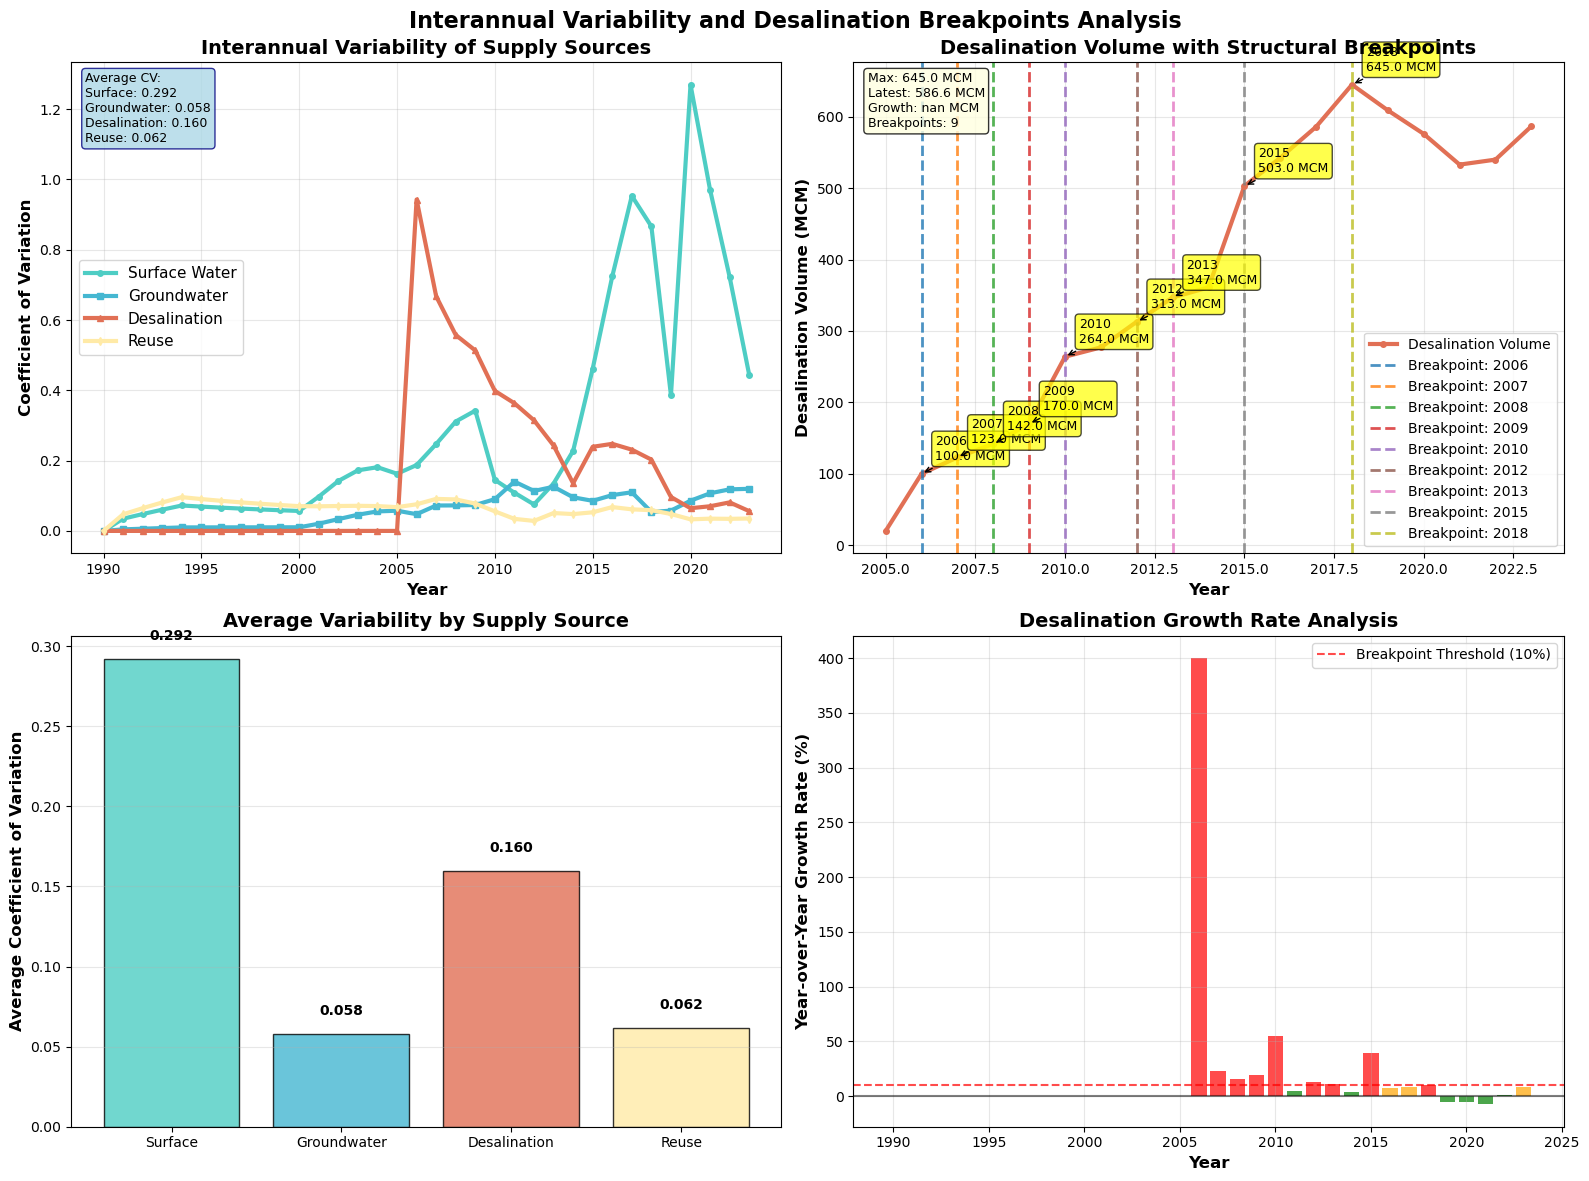


📊 INTERANNUAL VARIABILITY ANALYSIS RESULTS
Analysis period: 1990-2023
Rolling window: 5 years

Average Coefficient of Variation by Source:
  Surface Water: 0.292
  Groundwater: 0.058
  Desalination: 0.160
  Reuse: 0.062

Most variable source: Surface Water (CV = 0.292)
Least variable source: Groundwater (CV = 0.058)

🔍 DESALINATION BREAKPOINT ANALYSIS
Detected 9 structural breakpoints (>10% year-over-year increase):
  1. 2006: 100.0 MCM (growth: 400.0%)
  2. 2007: 123.0 MCM (growth: 23.0%)
  3. 2008: 142.0 MCM (growth: 15.4%)
  4. 2009: 170.0 MCM (growth: 19.7%)
  5. 2010: 264.0 MCM (growth: 55.3%)
  6. 2012: 313.0 MCM (growth: 13.0%)
  7. 2013: 347.0 MCM (growth: 10.9%)
  8. 2015: 503.0 MCM (growth: 39.3%)
  9. 2018: 645.0 MCM (growth: 10.1%)

📊 Variability Data (Every 5 years):
Year | Surface CV | Groundwater CV | Desalination CV | Reuse CV
----------------------------------------------------------------------
1990 |      0.000 |         0.000 |           0.000 |    0.000
1995 |    

In [58]:
"""
This module conducts interannual variability and desalination breakpoints analysis.

It begins by ensuring that the pre‑processed data (`df_agg`) from the raw
data analysis is available. If not, it prompts the user to run the previous
analysis. The module defines functions to compute variability statistics and
detect breakpoints in desalination capacity, runs these analyses, and
visualizes results using multiple subplots. It also prints detailed
statistics and reports the most variable supply source and structural
breakpoints.

Each line is commented to explain what is happening without altering the
original code functionality.
"""

# =============================================================================
# INTERANNUAL VARIABILITY AND DESALINATION BREAKPOINTS ANALYSIS
# =============================================================================

# Print a header indicating the start of interannual variability analysis
print("📊 INTERANNUAL VARIABILITY AND DESALINATION BREAKPOINTS ANALYSIS")
# Print a separator line for clarity
print("=" * 60)

# Check if df_agg exists from the raw data analysis
if 'df_agg' not in globals():
    # If df_agg isn't defined, alert the user
    print("❌ Error: df_agg variable not found. Please run the Raw Data Analysis cell first.")
else:
    # If df_agg exists, print the range of years available and number of observations
    print(f"✅ Using data from {df_agg['year'].min()}-{df_agg['year'].max()} ({len(df_agg)} years)")
    
    # =============================================================================
    # VARIABILITY ANALYSIS FUNCTIONS
    # =============================================================================
    
    def compute_variability(df, window=5):
        """
        Compute interannual variability statistics for each supply source over
        a rolling window.
        This function returns a DataFrame with coefficients of variation
        computed over a specified rolling window.
        """
        # Inform the user that variability is being computed and the window size
        print(f"🔄 Computing interannual variability (window={window} years)...")
        
        # Set year as index for rolling calculations and make a copy of the DataFrame
        temp_df = df.set_index("year").copy()
        
        # Define supply series (using raw data columns)
        surface = temp_df["produced_by_kinneret_milion_m3"]
        # Use capped groundwater for consistency with analysis
        ground = temp_df["capped_groundwater"]
        # Desalination series
        desal = temp_df["water_desalination_mcm"]
        # Use capped reuse for consistency
        reuse = temp_df["capped_reuse"]
        
        # Define a helper function to compute rolling coefficient of variation (CV)
        # CV is the rolling standard deviation divided by the rolling mean
        def rolling_cv(series):
            # Rolling mean over the specified window with minimum one period
            rolling_mean = series.rolling(window=window, min_periods=1).mean()
            # Rolling standard deviation over the specified window
            rolling_std = series.rolling(window=window, min_periods=1).std()
            # Compute CV, filling NaNs with 0 to avoid missing values
            return (rolling_std / rolling_mean).fillna(0)
        
        # Compute CVs for each supply source and assemble into a DataFrame
        variability_df = pd.DataFrame({
            "year": temp_df.index,
            "cv_surface": rolling_cv(surface),
            "cv_groundwater": rolling_cv(ground),
            "cv_desalination": rolling_cv(desal),
            "cv_reuse": rolling_cv(reuse)
        }).set_index("year")
        
        # Inform the user that variability analysis is complete
        print("✅ Variability analysis complete!")
        # Return the variability DataFrame
        return variability_df
    
    def detect_desal_breakpoints(df, threshold=0.1):
        """
        Identify years where the desalination volume increases abruptly.
        A breakpoint is recorded when year‑over‑year increase exceeds a
        specified threshold (default 10%).
        """
        # Inform the user about the breakpoint detection process and threshold
        print(f"🔍 Detecting desalination breakpoints (threshold={threshold*100}%)...")
        
        # Extract the year and desalination values from the DataFrame
        years = df["year"].values
        desal = df["water_desalination_mcm"].values
        # Initialize an empty list to store breakpoint years
        breakpoints = []
        
        # Loop through each year starting from the second year
        for i in range(1, len(desal)):
            prev_val = desal[i - 1]
            current_val = desal[i]
            # Only consider increases and avoid division by zero
            if prev_val > 0 and (current_val - prev_val) / prev_val > threshold:
                # If the increase surpasses the threshold, record the year
                breakpoints.append(int(years[i]))
        
        # Print the number of breakpoints found and list them
        print(f"✅ Found {len(breakpoints)} breakpoints: {breakpoints}")
        # Return the list of breakpoint years
        return breakpoints
    
    # =============================================================================
    # RUN VARIABILITY AND BREAKPOINT ANALYSIS
    # =============================================================================
    
    # Compute variability statistics using a 5‑year rolling window
    variability_df = compute_variability(df_agg, window=5)
    
    # Detect desalination breakpoints using a 10% threshold
    breakpoints = detect_desal_breakpoints(df_agg, threshold=0.1)
    
    # =============================================================================
    # CREATE COMPREHENSIVE VISUALIZATIONS
    # =============================================================================
    
    # Inform the user that the plots will be created
    print("📊 Creating comprehensive variability and breakpoint visualizations...")
    
    # Create a 2x2 grid of subplots for the visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    # Add a main title for the analysis
    fig.suptitle('Interannual Variability and Desalination Breakpoints Analysis', 
                 fontsize=16, fontweight='bold')
    
    # -------------------------------------------------------------------------
    # 1. Interannual Variability - Coefficient of Variation
    # Select the first subplot (upper left)
    ax1 = axes[0, 0]
    # Plot CV of surface water
    ax1.plot(variability_df.index, variability_df['cv_surface'], 
             label='Surface Water', linewidth=3, color='#4ECDC4', marker='o', markersize=4)
    # Plot CV of groundwater
    ax1.plot(variability_df.index, variability_df['cv_groundwater'], 
             label='Groundwater', linewidth=3, color='#45B7D1', marker='s', markersize=4)
    # Plot CV of desalination
    ax1.plot(variability_df.index, variability_df['cv_desalination'], 
             label='Desalination', linewidth=3, color='#E17055', marker='^', markersize=4)
    # Plot CV of reuse
    ax1.plot(variability_df.index, variability_df['cv_reuse'], 
             label='Reuse', linewidth=3, color='#FFEAA7', marker='d', markersize=4)
    
    # Label the x-axis and y-axis
    ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Coefficient of Variation', fontsize=12, fontweight='bold')
    # Set a title for this subplot
    ax1.set_title('Interannual Variability of Supply Sources', fontsize=14, fontweight='bold')
    # Show a legend to identify the lines
    ax1.legend(fontsize=11)
    # Add a grid for better readability
    ax1.grid(True, alpha=0.3)
    
    # Add variability statistics in a text box on the plot
    avg_cv_surface = variability_df['cv_surface'].mean()
    avg_cv_ground = variability_df['cv_groundwater'].mean()
    avg_cv_desal = variability_df['cv_desalination'].mean()
    avg_cv_reuse = variability_df['cv_reuse'].mean()
    
    # Build a summary string for average CV values
    cv_stats = f"""Average CV:
Surface: {avg_cv_surface:.3f}
Groundwater: {avg_cv_ground:.3f}
Desalination: {avg_cv_desal:.3f}
Reuse: {avg_cv_reuse:.3f}"""
    
    # Display the statistics on the plot
    ax1.text(0.02, 0.98, cv_stats, transform=ax1.transAxes, 
             fontsize=9, verticalalignment='top', horizontalalignment='left',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, edgecolor='navy'))
    
    # -------------------------------------------------------------------------
    # 2. Desalination Volume with Breakpoints
    # Select the second subplot (upper right)
    ax2 = axes[0, 1]
    # Plot the desalination volume over time
    ax2.plot(df_agg['year'], df_agg['water_desalination_mcm'], 
             label='Desalination Volume', linewidth=3, color='#E17055', marker='o', markersize=4)
    
    # Highlight breakpoints by drawing vertical lines and adding annotations
    for i, bp in enumerate(breakpoints):
        # Draw a dashed vertical line at each breakpoint year; use different colors for multiple breakpoints
        ax2.axvline(bp, linestyle='--', alpha=0.8, linewidth=2, 
                    color=f'C{i}', label=f'Breakpoint: {bp}')
        # Get the desalination value at the breakpoint year for annotation
        desal_val = df_agg.loc[df_agg['year'] == bp, 'water_desalination_mcm'].values[0]
        # Annotate the breakpoint with the year and value
        ax2.annotate(f'{bp}\n{desal_val:.1f} MCM', 
                    xy=(bp, desal_val), xytext=(10, 10), 
                    textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Label the axes and set a title for the subplot
    ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Desalination Volume (MCM)', fontsize=12, fontweight='bold')
    ax2.set_title('Desalination Volume with Structural Breakpoints', fontsize=14, fontweight='bold')
    # Show a legend that includes the breakpoints and the line
    ax2.legend(fontsize=10)
    # Add a light grid
    ax2.grid(True, alpha=0.3)
    
    # Add desalination statistics (max, latest, growth, and number of breakpoints)
    max_desal = df_agg['water_desalination_mcm'].max()
    latest_desal = df_agg['water_desalination_mcm'].iloc[-1]
    growth = latest_desal - df_agg['water_desalination_mcm'].iloc[0]
    
    # Build a multi‑line text for desal statistics
    desal_stats = f"""Max: {max_desal:.1f} MCM
Latest: {latest_desal:.1f} MCM
Growth: {growth:.1f} MCM
Breakpoints: {len(breakpoints)}"""
    
    # Display the statistics box on the subplot
    ax2.text(0.02, 0.98, desal_stats, transform=ax2.transAxes, 
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # -------------------------------------------------------------------------
    # 3. Supply Mix Variability Comparison
    # Select the third subplot (lower left)
    ax3 = axes[1, 0]
    # Names of supply sources for the bar chart
    sources = ['Surface', 'Groundwater', 'Desalination', 'Reuse']
    # Average CV values for each source
    avg_cvs = [avg_cv_surface, avg_cv_ground, avg_cv_desal, avg_cv_reuse]
    # Colors corresponding to each supply source
    colors = ['#4ECDC4', '#45B7D1', '#E17055', '#FFEAA7']
    
    # Create a bar chart showing the average CV per supply source
    bars = ax3.bar(sources, avg_cvs, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    # Label the y-axis and set a title
    ax3.set_ylabel('Average Coefficient of Variation', fontsize=12, fontweight='bold')
    ax3.set_title('Average Variability by Supply Source', fontsize=14, fontweight='bold')
    # Add horizontal grid lines for readability
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels above each bar to show the CV value
    for bar, cv in zip(bars, avg_cvs):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{cv:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # -------------------------------------------------------------------------
    # 4. Desalination Growth Rate Analysis
    # Select the fourth subplot (lower right)
    ax4 = axes[1, 1]
    # Calculate year‑over‑year growth rate for desalination
    desal_growth = df_agg['water_desalination_mcm'].pct_change() * 100
    # Replace NaN values (first year) with zero
    desal_growth = desal_growth.fillna(0)
    
    # Determine colors for bars based on growth rate thresholds
    colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in desal_growth]
    # Create a bar chart to show growth rates each year
    bars = ax4.bar(df_agg['year'], desal_growth, color=colors, alpha=0.7, width=0.8)
    # Draw lines representing threshold levels
    ax4.axhline(10, linestyle='--', color='red', alpha=0.7, label='Breakpoint Threshold (10%)')
    ax4.axhline(0, linestyle='-', color='black', alpha=0.5)
    
    # Label the axes and set a title for growth analysis
    ax4.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Year-over-Year Growth Rate (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Desalination Growth Rate Analysis', fontsize=14, fontweight='bold')
    # Show legend for the threshold line
    ax4.legend(fontsize=10)
    # Add a light grid
    ax4.grid(True, alpha=0.3)
    
    # -------------------------------------------------------------------------
    # Final plot adjustments and display
    plt.tight_layout()
    plt.savefig('interannual_variability_breakpoints_analysis.png', dpi=150, bbox_inches='tight')
    print("✅ Interannual variability and breakpoints analysis saved as 'interannual_variability_breakpoints_analysis.png'")
    plt.show()
    
    # =============================================================================
    # DETAILED ANALYSIS RESULTS
    # =============================================================================
    
    # Print a header for interannual variability results
    print(f"\n📊 INTERANNUAL VARIABILITY ANALYSIS RESULTS")
    print("=" * 60)
    
    # Print the analysis period and window size
    print(f"Analysis period: {variability_df.index.min()}-{variability_df.index.max()}")
    print(f"Rolling window: 5 years")
    print()
    
    # Print average coefficient of variation for each source
    print("Average Coefficient of Variation by Source:")
    print(f"  Surface Water: {avg_cv_surface:.3f}")
    print(f"  Groundwater: {avg_cv_ground:.3f}")
    print(f"  Desalination: {avg_cv_desal:.3f}")
    print(f"  Reuse: {avg_cv_reuse:.3f}")
    print()
    
    # Identify most and least variable sources
    cv_values = [avg_cv_surface, avg_cv_ground, avg_cv_desal, avg_cv_reuse]
    source_names = ['Surface Water', 'Groundwater', 'Desalination', 'Reuse']
    # Source with maximum CV
    most_variable = source_names[cv_values.index(max(cv_values))]
    # Source with minimum CV
    least_variable = source_names[cv_values.index(min(cv_values))]
    
    # Print the most and least variable sources
    print(f"Most variable source: {most_variable} (CV = {max(cv_values):.3f})")
    print(f"Least variable source: {least_variable} (CV = {min(cv_values):.3f})")
    print()
    
    # Print header for breakpoints analysis
    print("🔍 DESALINATION BREAKPOINT ANALYSIS")
    print("=" * 60)
    
    # If breakpoints were detected, print details
    if breakpoints:
        print(f"Detected {len(breakpoints)} structural breakpoints (>10% year-over-year increase):")
        for i, bp in enumerate(breakpoints, 1):
            # Fetch desalination value for the breakpoint year
            desal_val = df_agg.loc[df_agg['year'] == bp, 'water_desalination_mcm'].values[0]
            # Calculate the desalination value of the previous year
            prev_year = bp - 1
            prev_val = df_agg.loc[df_agg['year'] == prev_year, 'water_desalination_mcm'].values[0]
            # Compute growth rate at the breakpoint
            growth_rate = ((desal_val - prev_val) / prev_val) * 100 if prev_val > 0 else 0
            # Print the breakpoint details with growth rate
            print(f"  {i}. {bp}: {desal_val:.1f} MCM (growth: {growth_rate:.1f}%)")
    else:
        # If no breakpoints detected, print a summary message
        print("No significant breakpoints detected (threshold: 10% year-over-year increase)")
    
    print()
    
    # Show variability data table for every 5th year
    print("📊 Variability Data (Every 5 years):")
    print("Year | Surface CV | Groundwater CV | Desalination CV | Reuse CV")
    print("-" * 70)
    for i in range(0, len(variability_df), 5):
        year = int(variability_df.index[i])
        cv_surface = variability_df.iloc[i]['cv_surface']
        cv_ground = variability_df.iloc[i]['cv_groundwater']
        cv_desal = variability_df.iloc[i]['cv_desalination']
        cv_reuse = variability_df.iloc[i]['cv_reuse']
        # Print formatted row with coefficients of variation for each supply type
        print(f"{year} | {cv_surface:>10.3f} | {cv_ground:>13.3f} | {cv_desal:>15.3f} | {cv_reuse:>8.3f}")
    
    print(f"\n🎉 Interannual variability and breakpoint analysis complete!")
    # Notify user that the results are stored in variables
    print(f"📊 Variability data available in 'variability_df' variable")
    print(f"🔍 Breakpoints data: {breakpoints}")
    print(f"📈 Analysis shows {most_variable} as most variable and {least_variable} as most stable")

📈 FORWARD PROJECTIONS ANALYSIS (2025-2050)
📊 Loading forward projections data...
✅ Forward projections loaded: 26 years (2025-2050)
   Columns: ['year', 'demand_mcm', 'desal_mcm', 'groundwater_mcm', 'surface_mcm', 'reuse_mcm', 'total_supply_mcm', 'renewable_supply_mcm', 'wsi', 'ddr', 'surplus_mcm']

🔄 Adding interpolation for continuity between historical and projected periods...
✅ Interpolation complete: Added transition year 2024
   Updated forward projections: 27 years (2024-2050)
   2024 interpolated values:
     Total Supply: 2576.9 MCM
     Total Demand: 2474.5 MCM
     Surplus: 102.4 MCM

🔄 Recalculated WSI, DDR, and surplus with consistent formulas

📊 FORWARD PROJECTIONS SUMMARY (2024-2050)
--------------------------------------------------
Projection period: 2024-2050
Total years: 27
Note: 2024 is interpolated for continuity between historical and projected periods

Key Metrics Summary:
  Average Total Supply: 3066.5 MCM
  Average Total Demand: 3166.5 MCM
  Average Surplus: -9

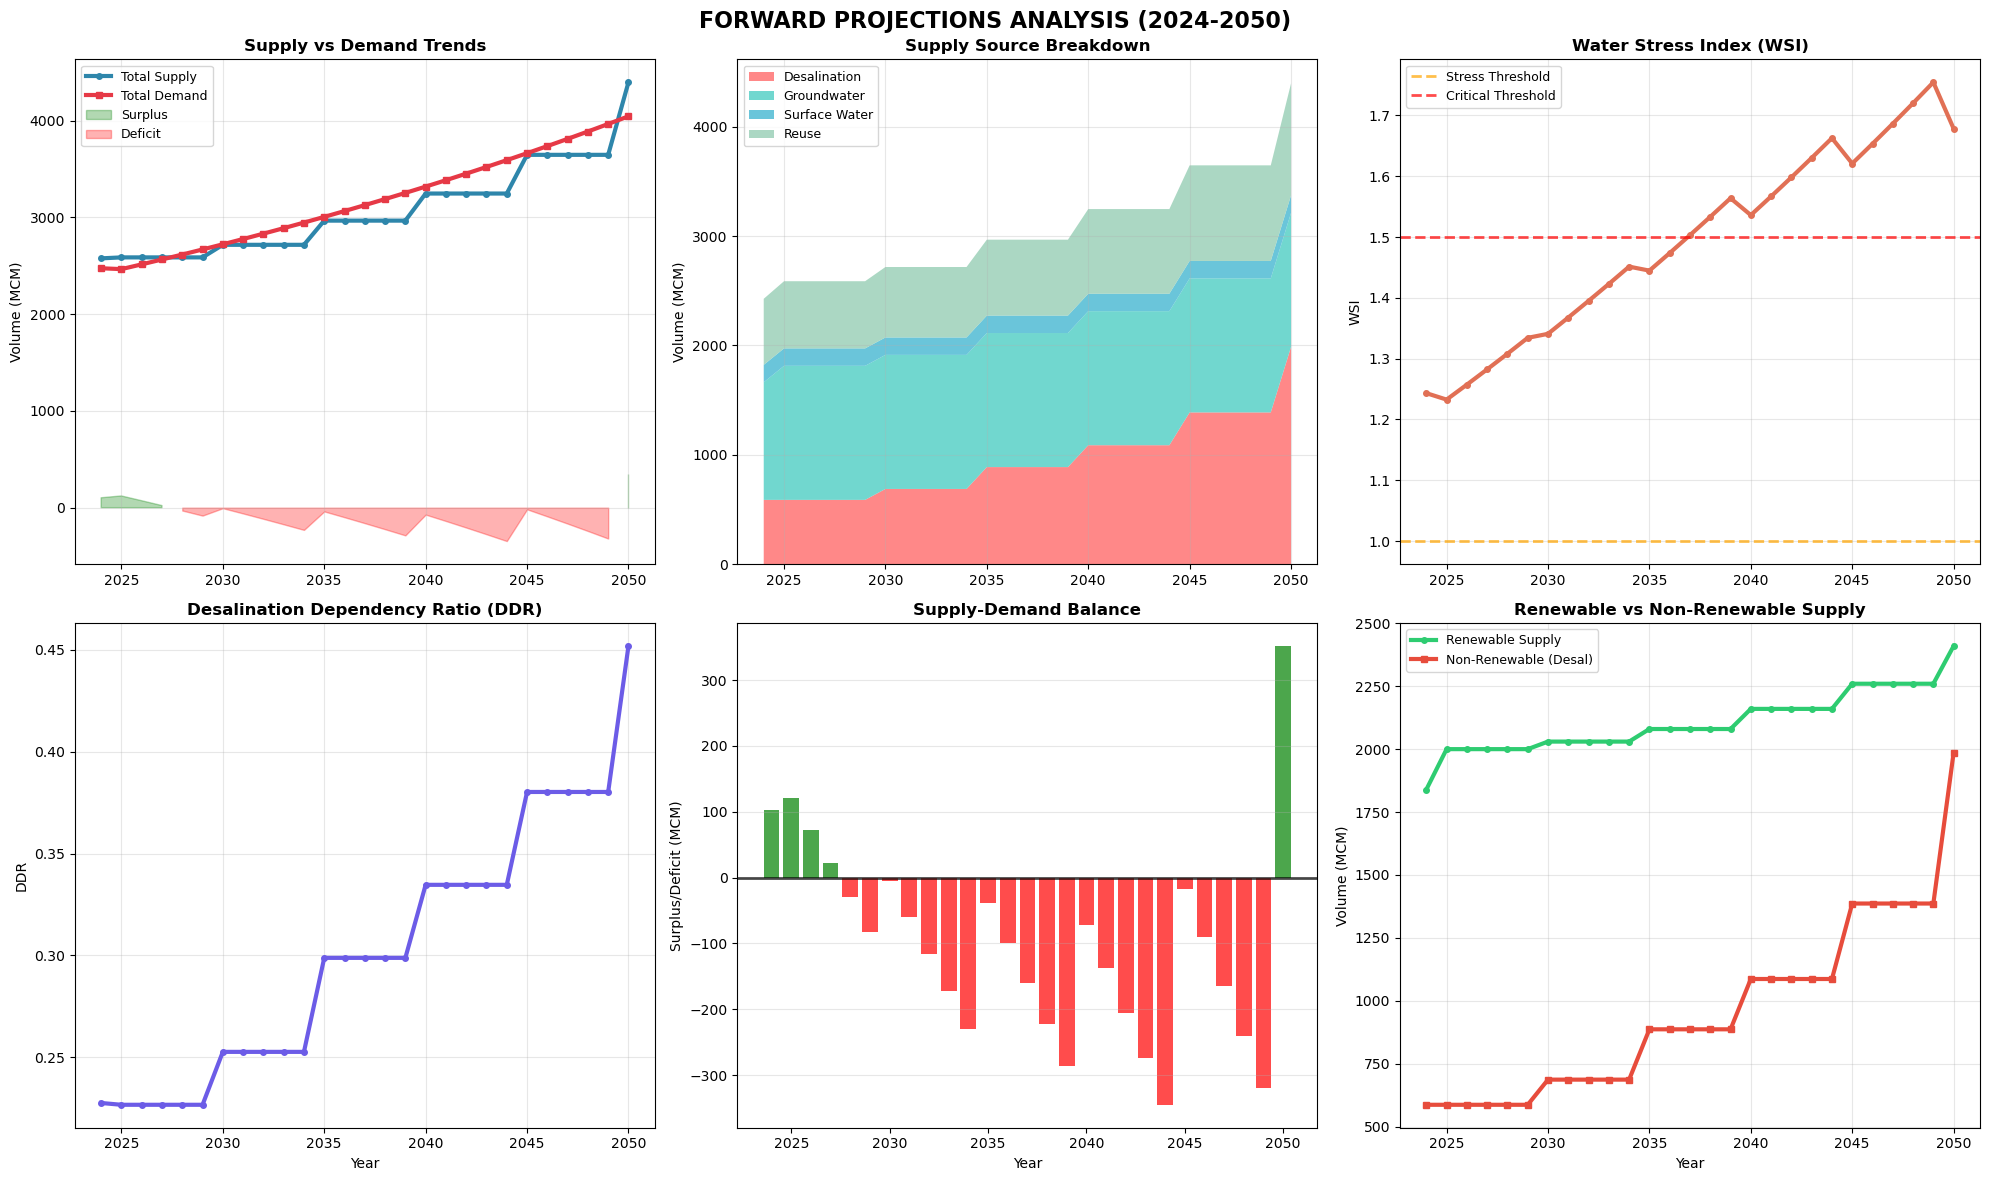

📊 Creating integrated historical + projected analysis (1990-2050)...
✅ Data merged successfully. Shape: (61, 99)
   Columns after merge: ['year', 'population', 'kinneret level (m)', 'tot water produced (million m3)', 'tot water produced without desalination (million m3)', 'tot water produced without water reuse (million m3)', 'tot water produced without water reuse and desalination (million m3)', 'total produced by wells (milion m3)', 'produced by Kinneret (milion m3)', 'total produced by Upper water (milion m3)', 'produced by Effluents (milion m3)', 'Water desalination (mCm)', 'Ashdod (MCM/Y)', 'Sorek (MCM/Y)', 'Hadera (MCM/Y)', 'Palmachim (MCM/Y)', 'Ashkelon (MCM/Y)', 'total water consumed (milion m3)', 'Domestic (milion m3)', 'Industrial (milion m3)', 'Agricultural (milion m3)', ' Water for the environment (milion m3)', '       Other suppliers ', 'Average maximum temperatue', 'Average minimum temperatue', 'Mean annual temperature', 'Annual total wet-day precipitation (mm)', 'Extreme

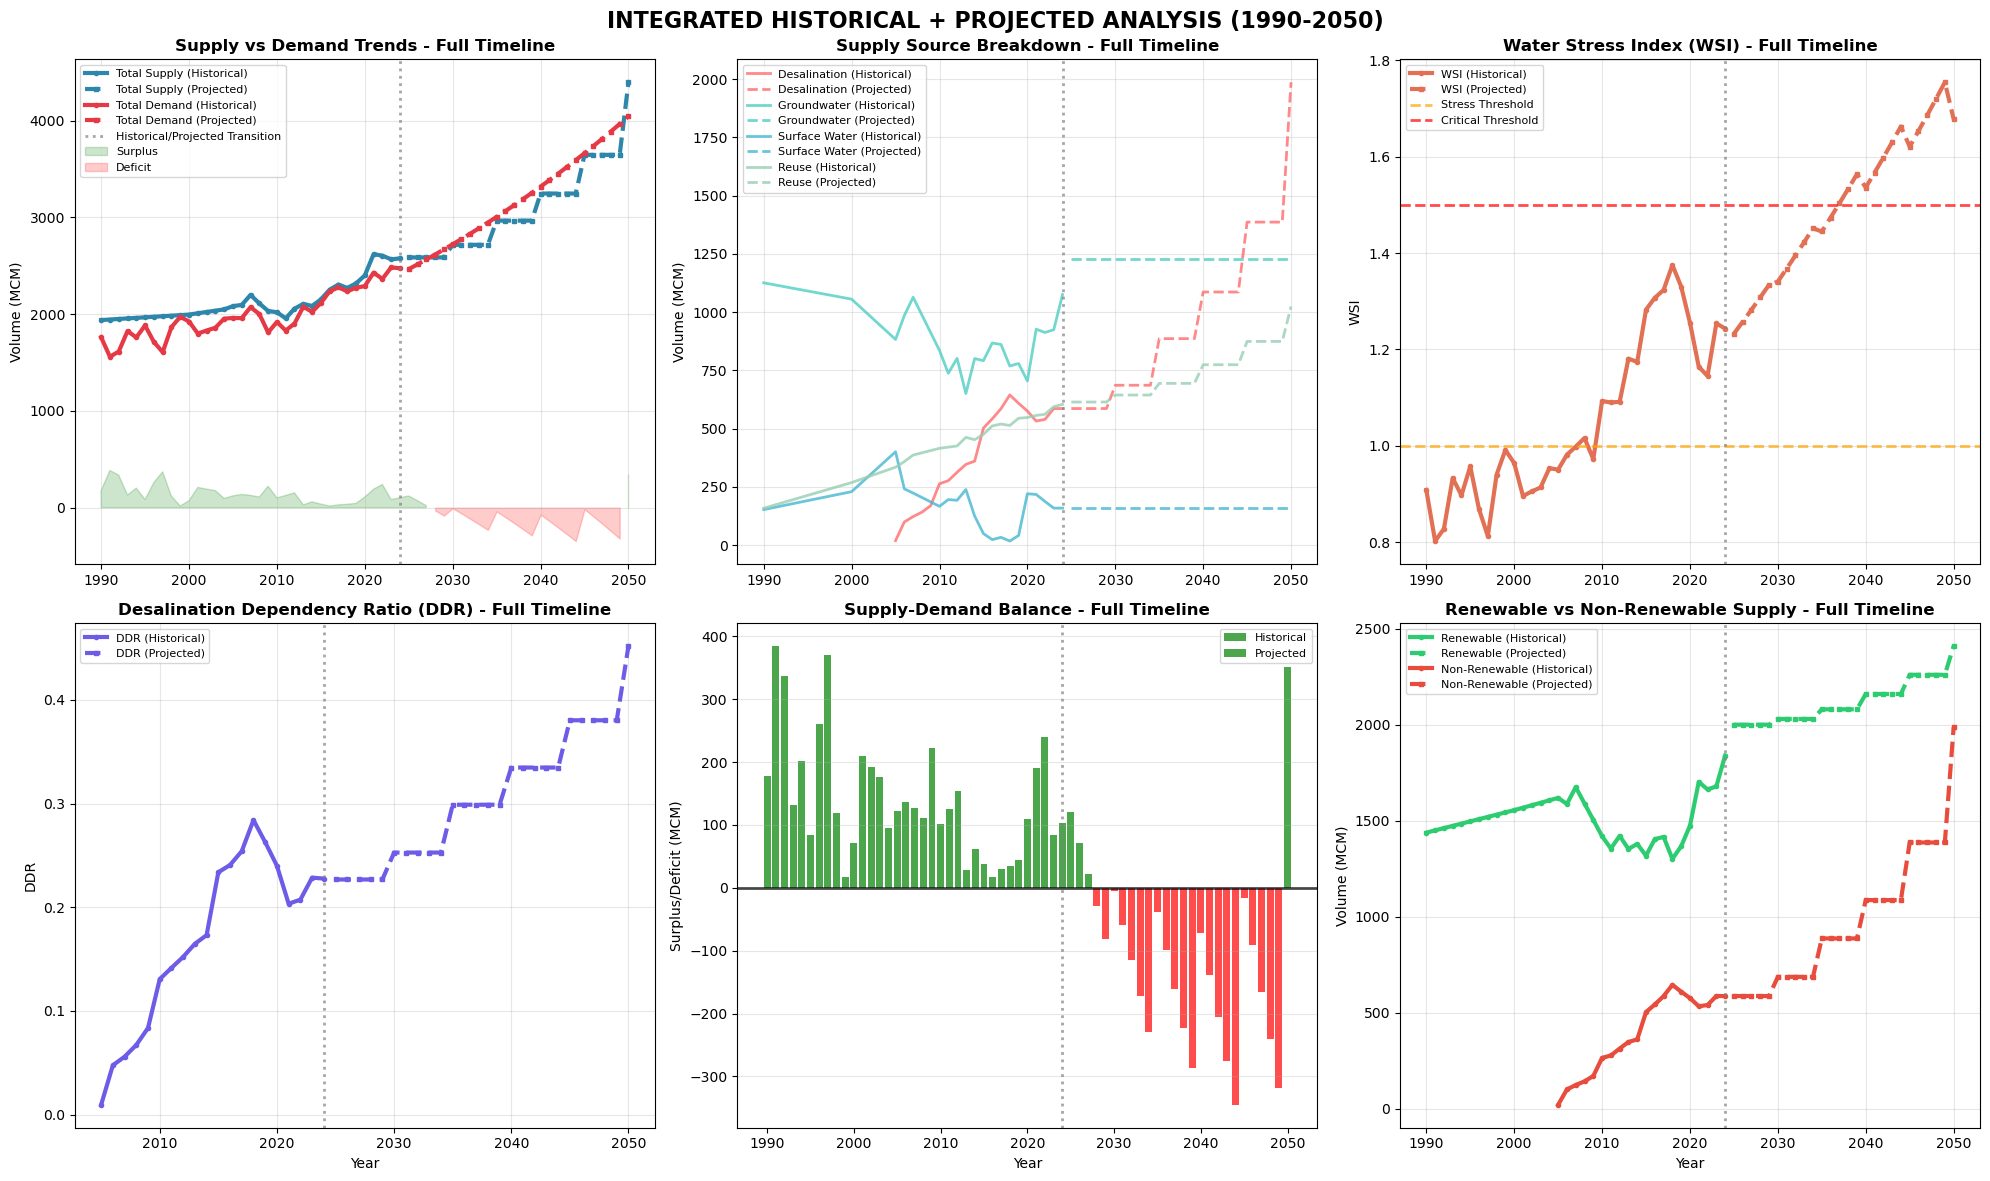

✅ Integrated historical + projected analysis complete!
📊 Visualization saved as 'integrated_historical_projected_analysis.png'

📊 INTEGRATED ANALYSIS SUMMARY (1990-2050)
--------------------------------------------------
Total timeline: 1990-2050
Historical period: 1990-2024
Projected period: 2025-2050

Key Trends:
  Historical Average Supply: 2130.8 MCM
  Projected Average Supply: 3085.4 MCM
  Historical Average WSI: 1.05
  Projected Average WSI: 1.50
  Historical Average DDR: 0.170
  Projected Average DDR: 0.305

✅ Forward projections analysis complete!
📊 Visualizations saved as:
   - 'forward_projections_analysis.png' (2024-2050 with interpolation)
   - 'integrated_historical_projected_analysis.png' (1990-2050 integrated)



In [59]:
"""
This module performs forward projections analysis for the period 2025‑2050,
including interpolation for a transition year (2024), summary statistics,
and detailed visualizations. It also integrates historical data with
projections to create a continuous timeline from 1990 through 2050.

Each line of the original script is annotated with explanatory comments
without changing its functional behavior.
"""

# =============================================================================
# FORWARD PROJECTIONS ANALYSIS (2025-2050)
# =============================================================================

# Print a header indicating the start of forward projections analysis
print("📈 FORWARD PROJECTIONS ANALYSIS (2025-2050)")
# Print a separator for readability
print("=" * 60)

# Load forward projections data from a CSV file
print("📊 Loading forward projections data...")
forward_projections = pd.read_csv("baseline_results/baseline_forward_projections_2025_2050.csv")
# Print the number of years loaded and the range of years
print(f"✅ Forward projections loaded: {len(forward_projections)} years ({forward_projections['year'].min()}-{forward_projections['year'].max()})")
# Print the list of columns available in the dataset
print(f"   Columns: {list(forward_projections.columns)}")

# Add interpolation for missing values between historical and projected periods
print("\n🔄 Adding interpolation for continuity between historical and projected periods...")

# Get the last historical year data (2023) from df_agg
last_historical_year = 2023
historical_2023 = df_agg[df_agg['year'] == last_historical_year].iloc[0]

# Create a transition year (2024) with interpolated values
transition_2024 = {
    'year': 2024,
    # Interpolate demand between historical 2023 and first projected demand value
    'demand_mcm': (historical_2023['total_demand'] + forward_projections.iloc[0]['demand_mcm']) / 2,
    # Interpolate desalination volumes
    'desal_mcm': (historical_2023['water_desalination_mcm'] + forward_projections.iloc[0]['desal_mcm']) / 2,
    # Interpolate groundwater volumes
    'groundwater_mcm': (historical_2023['capped_groundwater'] + forward_projections.iloc[0]['groundwater_mcm']) / 2,
    # Interpolate surface water volumes
    'surface_mcm': (historical_2023['produced_by_kinneret_milion_m3'] + forward_projections.iloc[0]['surface_mcm']) / 2,
    # Interpolate reuse volumes
    'reuse_mcm': (historical_2023['capped_reuse'] + forward_projections.iloc[0]['reuse_mcm']) / 2,
    # Interpolate upper water volumes; default to 0 if missing in projections
    'upper_water_mcm': (historical_2023['total_produced_by_upper_water_milion_m3'] + forward_projections.iloc[0].get('upper_water_mcm', 0)) / 2
}

# Calculate interpolated totals for 2024
transition_2024['total_supply_mcm'] = (transition_2024['desal_mcm'] + transition_2024['groundwater_mcm'] + 
                                      transition_2024['surface_mcm'] + transition_2024['reuse_mcm'] + 
                                      transition_2024['upper_water_mcm'])
transition_2024['renewable_supply_mcm'] = (transition_2024['groundwater_mcm'] + transition_2024['surface_mcm'] + 
                                          transition_2024['reuse_mcm'] + transition_2024['upper_water_mcm'])
# Compute surplus by subtracting demand from supply
transition_2024['surplus_mcm'] = transition_2024['total_supply_mcm'] - transition_2024['demand_mcm']
# Compute Water Stress Index (WSI); avoid division by zero
transition_2024['wsi'] = transition_2024['demand_mcm'] / transition_2024['renewable_supply_mcm'] if transition_2024['renewable_supply_mcm'] > 0 else np.nan
# Compute Desalination Dependency Ratio (DDR); avoid division by zero
transition_2024['ddr'] = transition_2024['desal_mcm'] / transition_2024['total_supply_mcm'] if transition_2024['total_supply_mcm'] > 0 else 0

# Add the transition year to forward projections
transition_df = pd.DataFrame([transition_2024])
forward_projections = pd.concat([transition_df, forward_projections], ignore_index=True)
forward_projections = forward_projections.sort_values('year').reset_index(drop=True)

# Inform the user that interpolation is complete
print(f"✅ Interpolation complete: Added transition year 2024")
# Print updated summary of the projections
print(f"   Updated forward projections: {len(forward_projections)} years ({forward_projections['year'].min()}-{forward_projections['year'].max()})")
# Print the interpolated values for 2024
print(f"   2024 interpolated values:")
print(f"     Total Supply: {transition_2024['total_supply_mcm']:.1f} MCM")
print(f"     Total Demand: {transition_2024['demand_mcm']:.1f} MCM")
print(f"     Surplus: {transition_2024['surplus_mcm']:.1f} MCM")
print()

# Recalculate supply totals and WSI consistently
forward_projections['total_supply_mcm'] = (
    forward_projections[['desal_mcm','groundwater_mcm',
                         'surface_mcm','reuse_mcm','upper_water_mcm']].sum(axis=1)
)

forward_projections['renewable_supply_mcm'] = (
    forward_projections[['groundwater_mcm','surface_mcm',
                         'reuse_mcm','upper_water_mcm']].sum(axis=1)
)

# Compute WSI as demand divided by renewable supply
forward_projections['wsi'] = forward_projections['demand_mcm'] / forward_projections['renewable_supply_mcm']

# Compute DDR as desalination divided by total supply
forward_projections['ddr'] = forward_projections['desal_mcm'] / forward_projections['total_supply_mcm']

# Compute surplus/deficit
forward_projections['surplus_mcm'] = forward_projections['total_supply_mcm'] - forward_projections['demand_mcm']

print("🔄 Recalculated WSI, DDR, and surplus with consistent formulas")
print()

# Display summary statistics for the projection period
print("📊 FORWARD PROJECTIONS SUMMARY (2024-2050)")
print("-" * 50)
print(f"Projection period: {forward_projections['year'].min()}-{forward_projections['year'].max()}")
print(f"Total years: {len(forward_projections)}")
print(f"Note: 2024 is interpolated for continuity between historical and projected periods")
print()

# Key metrics summary for the projection period
print("Key Metrics Summary:")
print(f"  Average Total Supply: {forward_projections['total_supply_mcm'].mean():.1f} MCM")
print(f"  Average Total Demand: {forward_projections['demand_mcm'].mean():.1f} MCM")
print(f"  Average Surplus: {forward_projections['surplus_mcm'].mean():.1f} MCM")
print(f"  Average WSI: {forward_projections['wsi'].mean():.2f}")
print(f"  Average DDR: {forward_projections['ddr'].mean():.3f}")
print()

# Supply source breakdown: compute average values and percentages
print("Supply Source Breakdown (Average 2025-2050):")
print(f"  Desalination: {forward_projections['desal_mcm'].mean():.1f} MCM ({forward_projections['desal_mcm'].mean()/forward_projections['total_supply_mcm'].mean()*100:.1f}%)")
print(f"  Groundwater: {forward_projections['groundwater_mcm'].mean():.1f} MCM ({forward_projections['groundwater_mcm'].mean()/forward_projections['total_supply_mcm'].mean()*100:.1f}%)")
print(f"  Surface Water: {forward_projections['surface_mcm'].mean():.1f} MCM ({forward_projections['surface_mcm'].mean()/forward_projections['total_supply_mcm'].mean()*100:.1f}%)")
print(f"  Reuse: {forward_projections['reuse_mcm'].mean():.1f} MCM ({forward_projections['reuse_mcm'].mean()/forward_projections['total_supply_mcm'].mean()*100:.1f}%)")
print()

# Identify critical years where supply deficit occurs
deficit_years = forward_projections[forward_projections['surplus_mcm'] < 0]
if len(deficit_years) > 0:
    print("⚠️  CRITICAL YEARS (Supply Deficit):")
    for _, row in deficit_years.iterrows():
        # Print year, deficit amount and WSI for each deficit year
        print(f"  {int(row['year'])}: Deficit of {abs(row['surplus_mcm']):.1f} MCM (WSI: {row['wsi']:.2f})")
    print()
else:
    print("✅ No deficit years projected in the forward period")
    print()

# Create comprehensive forward projections visualization
print("📊 Creating forward projections visualization...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('FORWARD PROJECTIONS ANALYSIS (2024-2050)', fontsize=16, fontweight='bold')

# 1. Supply vs Demand Trends
ax1 = axes[0, 0]
ax1.plot(forward_projections['year'], forward_projections['total_supply_mcm'], 
         label='Total Supply', linewidth=3, color='#2E86AB', marker='o', markersize=4)
ax1.plot(forward_projections['year'], forward_projections['demand_mcm'], 
         label='Total Demand', linewidth=3, color='#E63946', marker='s', markersize=4)
# Shade areas of surplus and deficit
ax1.fill_between(forward_projections['year'], 0, forward_projections['surplus_mcm'], 
                 where=(forward_projections['surplus_mcm'] >= 0), color='green', alpha=0.3, label='Surplus')
ax1.fill_between(forward_projections['year'], 0, forward_projections['surplus_mcm'], 
                 where=(forward_projections['surplus_mcm'] < 0), color='red', alpha=0.3, label='Deficit')
ax1.set_title('Supply vs Demand Trends', fontsize=12, fontweight='bold')
ax1.set_ylabel('Volume (MCM)', fontsize=10)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Supply Source Breakdown
ax2 = axes[0, 1]
supply_sources = ['desal_mcm', 'groundwater_mcm', 'surface_mcm', 'reuse_mcm']
source_labels = ['Desalination', 'Groundwater', 'Surface Water', 'Reuse']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

ax2.stackplot(forward_projections['year'], 
              [forward_projections[source] for source in supply_sources],
              labels=source_labels, colors=colors, alpha=0.8)
ax2.set_title('Supply Source Breakdown', fontsize=12, fontweight='bold')
ax2.set_ylabel('Volume (MCM)', fontsize=10)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Water Stress Index
ax3 = axes[0, 2]
ax3.plot(forward_projections['year'], forward_projections['wsi'], 
         linewidth=3, color='#E17055', marker='o', markersize=4)
ax3.axhline(1.0, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Stress Threshold')
ax3.axhline(1.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Critical Threshold')
ax3.set_title('Water Stress Index (WSI)', fontsize=12, fontweight='bold')
ax3.set_ylabel('WSI', fontsize=10)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Desalination Dependency Ratio
ax4 = axes[1, 0]
ax4.plot(forward_projections['year'], forward_projections['ddr'], 
         linewidth=3, color='#6C5CE7', marker='o', markersize=4)
ax4.set_title('Desalination Dependency Ratio (DDR)', fontsize=12, fontweight='bold')
ax4.set_ylabel('DDR', fontsize=10)
ax4.set_xlabel('Year', fontsize=10)
ax4.grid(True, alpha=0.3)

# 5. Surplus/Deficit Timeline
ax5 = axes[1, 1]
colors_sd = ['green' if x >= 0 else 'red' for x in forward_projections['surplus_mcm']]
bars = ax5.bar(forward_projections['year'], forward_projections['surplus_mcm'], 
               color=colors_sd, alpha=0.7, width=0.8)
ax5.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
ax5.set_title('Supply-Demand Balance', fontsize=12, fontweight='bold')
ax5.set_ylabel('Surplus/Deficit (MCM)', fontsize=10)
ax5.set_xlabel('Year', fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# 6. Renewable vs Non-Renewable Supply
ax6 = axes[1, 2]
renewable_supply = forward_projections['groundwater_mcm'] + forward_projections['surface_mcm'] + forward_projections['reuse_mcm']
non_renewable_supply = forward_projections['desal_mcm']

ax6.plot(forward_projections['year'], renewable_supply, 
         label='Renewable Supply', linewidth=3, color='#2ECC71', marker='o', markersize=4)
ax6.plot(forward_projections['year'], non_renewable_supply, 
         label='Non-Renewable (Desal)', linewidth=3, color='#E74C3C', marker='s', markersize=4)
ax6.set_title('Renewable vs Non-Renewable Supply', fontsize=12, fontweight='bold')
ax6.set_ylabel('Volume (MCM)', fontsize=10)
ax6.set_xlabel('Year', fontsize=10)
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# Adjust layout and save the forward projections figure
plt.tight_layout()
plt.savefig('forward_projections_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# HISTORICAL + PROJECTED INTEGRATED ANALYSIS (1990-2050)
# =============================================================================

# Print a header for the integrated analysis
print("📊 Creating integrated historical + projected analysis (1990-2050)...")

# Prepare historical data for integration by copying df_agg
historical_data = df_agg.copy()

# Create a continuous timeline DataFrame from 1990 to 2050
full_timeline = pd.DataFrame({'year': range(1990, 2051)})

# Merge historical and projected data based on year
integrated_data = full_timeline.merge(historical_data, on='year', how='left')
integrated_data = integrated_data.merge(forward_projections, on='year', how='left', suffixes=('_hist', '_proj'))

# Print details about the merged dataset
print(f"✅ Data merged successfully. Shape: {integrated_data.shape}")
print(f"   Columns after merge: {list(integrated_data.columns)}")
print(f"   Historical data years: {integrated_data[integrated_data['total_supply_mcm_hist'].notna()]['year'].tolist()}")
print(f"   Projected data years: {integrated_data[integrated_data['total_supply_mcm'].notna()]['year'].tolist() if 'total_supply_mcm' in integrated_data.columns else 'Column not found'}")
print(f"   Sample 2024 projected total_supply_mcm: {integrated_data[integrated_data['year'] == 2024]['total_supply_mcm'].iloc[0] if 'total_supply_mcm' in integrated_data.columns and len(integrated_data[integrated_data['year'] == 2024]) > 0 else 'No data'}")
print(f"   Sample 2025 projected total_supply_mcm: {integrated_data[integrated_data['year'] == 2025]['total_supply_mcm'].iloc[0] if 'total_supply_mcm' in integrated_data.columns and len(integrated_data[integrated_data['year'] == 2025]) > 0 else 'No data'}")
print(f"   Sample 2023 historical total_supply_mcm: {integrated_data[integrated_data['year'] == 2023]['total_supply_mcm_hist'].iloc[0] if len(integrated_data[integrated_data['year'] == 2023]) > 0 else 'No data'}")
print()

# --- Minimal, safe fix: rebuild totals from standardized components ---

# 1) Map projection columns to standardized names (fill historical gaps only)
column_mapping = {
    'demand_mcm': 'total_demand',
    'desal_mcm': 'water_desalination_mcm', 
    'groundwater_mcm': 'capped_groundwater',
    'surface_mcm': 'produced_by_kinneret_milion_m3',
    'reuse_mcm': 'capped_reuse',
    'upper_water_mcm': 'total_produced_by_upper_water_milion_m3'  # Add Upper Water mapping
}
for proj_col, std_col in column_mapping.items():
    if proj_col in integrated_data.columns:
        # Ensure the standardized column exists
        integrated_data[std_col] = integrated_data.get(std_col, pd.Series(index=integrated_data.index))
        # Fill historical NaNs with projection values without overwriting existing values
        integrated_data[std_col] = integrated_data[std_col].where(integrated_data[std_col].notna(),
                                                                 integrated_data[proj_col])

# 2) Rebuild totals from standardized components (projection + historical unified)
# Include all supply components from baseline analysis
supply_components = [
    'water_desalination_mcm',
    'capped_groundwater',
    'produced_by_kinneret_milion_m3',
    'capped_reuse',
    'total_produced_by_upper_water_milion_m3'  # This was missing!
]
present_supply = [c for c in supply_components if c in integrated_data.columns]
integrated_data['total_supply_mcm'] = integrated_data[present_supply].sum(axis=1, min_count=1)

# 3) Rebuild renewable supply (exclude desal)
renewable_components = [
    'capped_groundwater',
    'produced_by_kinneret_milion_m3',
    'capped_reuse',
    'total_produced_by_upper_water_milion_m3'
]
present_renew = [c for c in renewable_components if c in integrated_data.columns]
integrated_data['renewable_supply_mcm'] = integrated_data[present_renew].sum(axis=1, min_count=1)

# 4) Ensure total_demand is set for projections
if 'total_demand' not in integrated_data.columns or integrated_data['total_demand'].isna().any():
    if 'total_demand_hist' in integrated_data.columns:
        # Fill missing total_demand values with historical values
        integrated_data['total_demand'] = integrated_data['total_demand'].where(
            integrated_data['total_demand'].notna(),
            integrated_data['total_demand_hist']
        )
    if 'demand_mcm' in integrated_data.columns:
        # Fill missing total_demand with projected demand_mcm values
        integrated_data['total_demand'] = integrated_data['total_demand'].where(
            integrated_data['total_demand'].notna(),
            integrated_data['demand_mcm']
        )

# 5) Recompute indicators once (no need to interpolate them beforehand)
integrated_data['wsi'] = np.where(
    integrated_data['renewable_supply_mcm'] > 0,
    integrated_data['total_demand'] / integrated_data['renewable_supply_mcm'],
    np.nan
)
integrated_data['ddr'] = np.where(
    integrated_data['total_supply_mcm'] > 0,
    integrated_data['water_desalination_mcm'] / integrated_data['total_supply_mcm'],
    np.nan
)
integrated_data['surplus_mcm'] = integrated_data['total_supply_mcm'] - integrated_data['total_demand']

# Optionally, interpolate display gaps for supply and demand columns
for col in ['total_supply_mcm', 'total_demand']:
    integrated_data[col] = integrated_data[col].interpolate(method='linear')

# Print summary statistics after rebuilding totals
print(f"✅ Integrated dataset rebuilt from standardized components:")
print(f"   Shape: {integrated_data.shape}")
print(f"   Years: {integrated_data['year'].min()}-{integrated_data['year'].max()}")
print(f"   Historical period (1990-2023): {integrated_data[integrated_data['year'] <= 2023]['total_supply_mcm'].mean():.1f} MCM (avg)")
print(f"   Transition year (2024): {integrated_data[integrated_data['year'] == 2024]['total_supply_mcm'].iloc[0]:.1f} MCM (interpolated)")
print(f"   Projected period (2024-2050): {integrated_data[integrated_data['year'] >= 2024]['total_supply_mcm'].mean():.1f} MCM (avg)")
print(f"   Sample 2024 total_supply_mcm: {integrated_data[integrated_data['year'] == 2024]['total_supply_mcm'].iloc[0]:.1f} MCM")
print(f"   Sample 2024 total_demand: {integrated_data[integrated_data['year'] == 2024]['total_demand'].iloc[0]:.1f} MCM")
print(f"   Sample 2024 surplus: {integrated_data[integrated_data['year'] == 2024]['surplus_mcm'].iloc[0]:.1f} MCM")
print()

# Interpolate missing values for certain columns
interpolation_columns = ['total_supply_mcm', 'total_demand', 'surplus_mcm', 'wsi', 'ddr', 'renewable_supply_mcm']
for col in interpolation_columns:
    if col in integrated_data.columns:
        integrated_data[col] = integrated_data[col].interpolate(method='linear')

# Recalculate WSI and DDR after interpolation
integrated_data['wsi'] = np.where(
    integrated_data['renewable_supply_mcm'] > 0,
    integrated_data['total_demand'] / integrated_data['renewable_supply_mcm'],
    np.nan
)
integrated_data['ddr'] = np.where(
    integrated_data['total_supply_mcm'] > 0,
    integrated_data['water_desalination_mcm'] / integrated_data['total_supply_mcm'],
    0
)
integrated_data['surplus_mcm'] = integrated_data['total_supply_mcm'] - integrated_data['total_demand']

# Create integrated visualization for historical + projected analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('INTEGRATED HISTORICAL + PROJECTED ANALYSIS (1990-2050)', fontsize=16, fontweight='bold')

# Define transition year (where historical data ends and projections begin)
transition_year = 2024

# 1. Supply vs Demand Trends - Full Timeline
ax1 = axes[0, 0]
# Create boolean masks for historical and projected periods
hist_mask = integrated_data['year'] <= transition_year
proj_mask = integrated_data['year'] > transition_year

# Plot supply and demand separately for historical and projected periods
ax1.plot(integrated_data.loc[hist_mask, 'year'], integrated_data.loc[hist_mask, 'total_supply_mcm'], 
         label='Total Supply (Historical)', linewidth=3, color='#2E86AB', marker='o', markersize=3)
ax1.plot(integrated_data.loc[proj_mask, 'year'], integrated_data.loc[proj_mask, 'total_supply_mcm'], 
         label='Total Supply (Projected)', linewidth=3, color='#2E86AB', linestyle='--', marker='s', markersize=3)

ax1.plot(integrated_data.loc[hist_mask, 'year'], integrated_data.loc[hist_mask, 'total_demand'], 
         label='Total Demand (Historical)', linewidth=3, color='#E63946', marker='o', markersize=3)
ax1.plot(integrated_data.loc[proj_mask, 'year'], integrated_data.loc[proj_mask, 'total_demand'], 
         label='Total Demand (Projected)', linewidth=3, color='#E63946', linestyle='--', marker='s', markersize=3)

# Add a vertical line indicating the transition from historical to projected data
ax1.axvline(transition_year, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Historical/Projected Transition')

# Shade surplus and deficit areas across the whole timeline
ax1.fill_between(integrated_data['year'], 0, integrated_data['surplus_mcm'], 
                 where=(integrated_data['surplus_mcm'] >= 0), color='green', alpha=0.2, label='Surplus')
ax1.fill_between(integrated_data['year'], 0, integrated_data['surplus_mcm'], 
                 where=(integrated_data['surplus_mcm'] < 0), color='red', alpha=0.2, label='Deficit')

# Set title, y-axis label, legend and grid
ax1.set_title('Supply vs Demand Trends - Full Timeline', fontsize=12, fontweight='bold')
ax1.set_ylabel('Volume (MCM)', fontsize=10)
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Supply Source Breakdown - Full Timeline
ax2 = axes[0, 1]
supply_sources = ['water_desalination_mcm', 'capped_groundwater', 'produced_by_kinneret_milion_m3', 'capped_reuse']
source_labels = ['Desalination', 'Groundwater', 'Surface Water', 'Reuse']
colors_breakdown = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Plot supply components separately for historical and projected periods
for i, (source, label, color) in enumerate(zip(supply_sources, source_labels, colors_breakdown)):
    if source in integrated_data.columns:
        ax2.plot(integrated_data.loc[hist_mask, 'year'], integrated_data.loc[hist_mask, source], 
                label=f'{label} (Historical)', linewidth=2, color=color, alpha=0.8)
        ax2.plot(integrated_data.loc[proj_mask, 'year'], integrated_data.loc[proj_mask, source], 
                label=f'{label} (Projected)', linewidth=2, color=color, linestyle='--', alpha=0.8)

ax2.axvline(transition_year, color='gray', linestyle=':', alpha=0.7, linewidth=2)
ax2.set_title('Supply Source Breakdown - Full Timeline', fontsize=12, fontweight='bold')
ax2.set_ylabel('Volume (MCM)', fontsize=10)
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Water Stress Index - Full Timeline
ax3 = axes[0, 2]
ax3.plot(integrated_data.loc[hist_mask, 'year'], integrated_data.loc[hist_mask, 'wsi'], 
         label='WSI (Historical)', linewidth=3, color='#E17055', marker='o', markersize=3)
ax3.plot(integrated_data.loc[proj_mask, 'year'], integrated_data.loc[proj_mask, 'wsi'], 
         label='WSI (Projected)', linewidth=3, color='#E17055', linestyle='--', marker='s', markersize=3)

ax3.axhline(1.0, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Stress Threshold')
ax3.axhline(1.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Critical Threshold')
ax3.axvline(transition_year, color='gray', linestyle=':', alpha=0.7, linewidth=2)

ax3.set_title('Water Stress Index (WSI) - Full Timeline', fontsize=12, fontweight='bold')
ax3.set_ylabel('WSI', fontsize=10)
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Desalination Dependency Ratio - Full Timeline
ax4 = axes[1, 0]
ax4.plot(integrated_data.loc[hist_mask, 'year'], integrated_data.loc[hist_mask, 'ddr'], 
         label='DDR (Historical)', linewidth=3, color='#6C5CE7', marker='o', markersize=3)
ax4.plot(integrated_data.loc[proj_mask, 'year'], integrated_data.loc[proj_mask, 'ddr'], 
         label='DDR (Projected)', linewidth=3, color='#6C5CE7', linestyle='--', marker='s', markersize=3)

ax4.axvline(transition_year, color='gray', linestyle=':', alpha=0.7, linewidth=2)
ax4.set_title('Desalination Dependency Ratio (DDR) - Full Timeline', fontsize=12, fontweight='bold')
ax4.set_ylabel('DDR', fontsize=10)
ax4.set_xlabel('Year', fontsize=10)
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Surplus/Deficit Timeline - Full Timeline
ax5 = axes[1, 1]
colors_hist = ['green' if x >= 0 else 'red' for x in integrated_data.loc[hist_mask, 'surplus_mcm']]
colors_proj = ['green' if x >= 0 else 'red' for x in integrated_data.loc[proj_mask, 'surplus_mcm']]

ax5.bar(integrated_data.loc[hist_mask, 'year'], integrated_data.loc[hist_mask, 'surplus_mcm'], 
        color=colors_hist, alpha=0.7, width=0.8, label='Historical')
ax5.bar(integrated_data.loc[proj_mask, 'year'], integrated_data.loc[proj_mask, 'surplus_mcm'], 
        color=colors_proj, alpha=0.7, width=0.8, label='Projected')

ax5.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
ax5.axvline(transition_year, color='gray', linestyle=':', alpha=0.7, linewidth=2)
ax5.set_title('Supply-Demand Balance - Full Timeline', fontsize=12, fontweight='bold')
ax5.set_ylabel('Surplus/Deficit (MCM)', fontsize=10)
ax5.set_xlabel('Year', fontsize=10)
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3, axis='y')

# 6. Renewable vs Non-Renewable Supply - Full Timeline
ax6 = axes[1, 2]
renewable_supply_full = integrated_data['capped_groundwater'] + integrated_data['produced_by_kinneret_milion_m3'] + integrated_data['capped_reuse']
non_renewable_supply_full = integrated_data['water_desalination_mcm']

ax6.plot(integrated_data.loc[hist_mask, 'year'], renewable_supply_full.loc[hist_mask], 
         label='Renewable (Historical)', linewidth=3, color='#2ECC71', marker='o', markersize=3)
ax6.plot(integrated_data.loc[proj_mask, 'year'], renewable_supply_full.loc[proj_mask], 
         label='Renewable (Projected)', linewidth=3, color='#2ECC71', linestyle='--', marker='s', markersize=3)

ax6.plot(integrated_data.loc[hist_mask, 'year'], non_renewable_supply_full.loc[hist_mask], 
         label='Non-Renewable (Historical)', linewidth=3, color='#E74C3C', marker='o', markersize=3)
ax6.plot(integrated_data.loc[proj_mask, 'year'], non_renewable_supply_full.loc[proj_mask], 
         label='Non-Renewable (Projected)', linewidth=3, color='#E74C3C', linestyle='--', marker='s', markersize=3)

ax6.axvline(transition_year, color='gray', linestyle=':', alpha=0.7, linewidth=2)
ax6.set_title('Renewable vs Non-Renewable Supply - Full Timeline', fontsize=12, fontweight='bold')
ax6.set_ylabel('Volume (MCM)', fontsize=10)
ax6.set_xlabel('Year', fontsize=10)
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

# Adjust layout, save the integrated analysis figure and show it
plt.tight_layout()
plt.savefig('integrated_historical_projected_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print a completion message for integrated analysis
print("✅ Integrated historical + projected analysis complete!")
print("📊 Visualization saved as 'integrated_historical_projected_analysis.png'")
print()

# Summary statistics for the integrated analysis
print("📊 INTEGRATED ANALYSIS SUMMARY (1990-2050)")
print("-" * 50)
print(f"Total timeline: {integrated_data['year'].min()}-{integrated_data['year'].max()}")
print(f"Historical period: 1990-{transition_year}")
print(f"Projected period: {transition_year+1}-2050")
print()

# Key trends summarizing average supply, WSI, and DDR for historical and projected periods
print("Key Trends:")
print(f"  Historical Average Supply: {integrated_data.loc[hist_mask, 'total_supply_mcm'].mean():.1f} MCM")
print(f"  Projected Average Supply: {integrated_data.loc[proj_mask, 'total_supply_mcm'].mean():.1f} MCM")
print(f"  Historical Average WSI: {integrated_data.loc[hist_mask, 'wsi'].mean():.2f}")
print(f"  Projected Average WSI: {integrated_data.loc[proj_mask, 'wsi'].mean():.2f}")
print(f"  Historical Average DDR: {integrated_data.loc[hist_mask, 'ddr'].mean():.3f}")
print(f"  Projected Average DDR: {integrated_data.loc[proj_mask, 'ddr'].mean():.3f}")
print()

# Final completion message
print("✅ Forward projections analysis complete!")
print("📊 Visualizations saved as:")
print("   - 'forward_projections_analysis.png' (2024-2050 with interpolation)")
print("   - 'integrated_historical_projected_analysis.png' (1990-2050 integrated)")
print()

🌵 DROUGHT CRISIS ANALYSIS
✅ Loaded drought parameters: ['NaturalSupplyFactor', 'SurfaceWaterReduction', 'GroundwaterReduction', 'AgriculturalDemandChange', 'DomesticDemandChange', 'IndustrialDemandChange', 'OPEXCostMultiplier', 'DurationYears']
✅ Using same integrated baseline data: 1990-2050
✅ Baseline data already processed: 61 rows × 104 columns
🌵 Running drought crisis scenarios...
   Running Optimistic (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Optimistic
   Running Moderate (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Moderate
   Running Pessimistic (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Pessimistic

📊 Creating comprehensive drought crisis visualization...


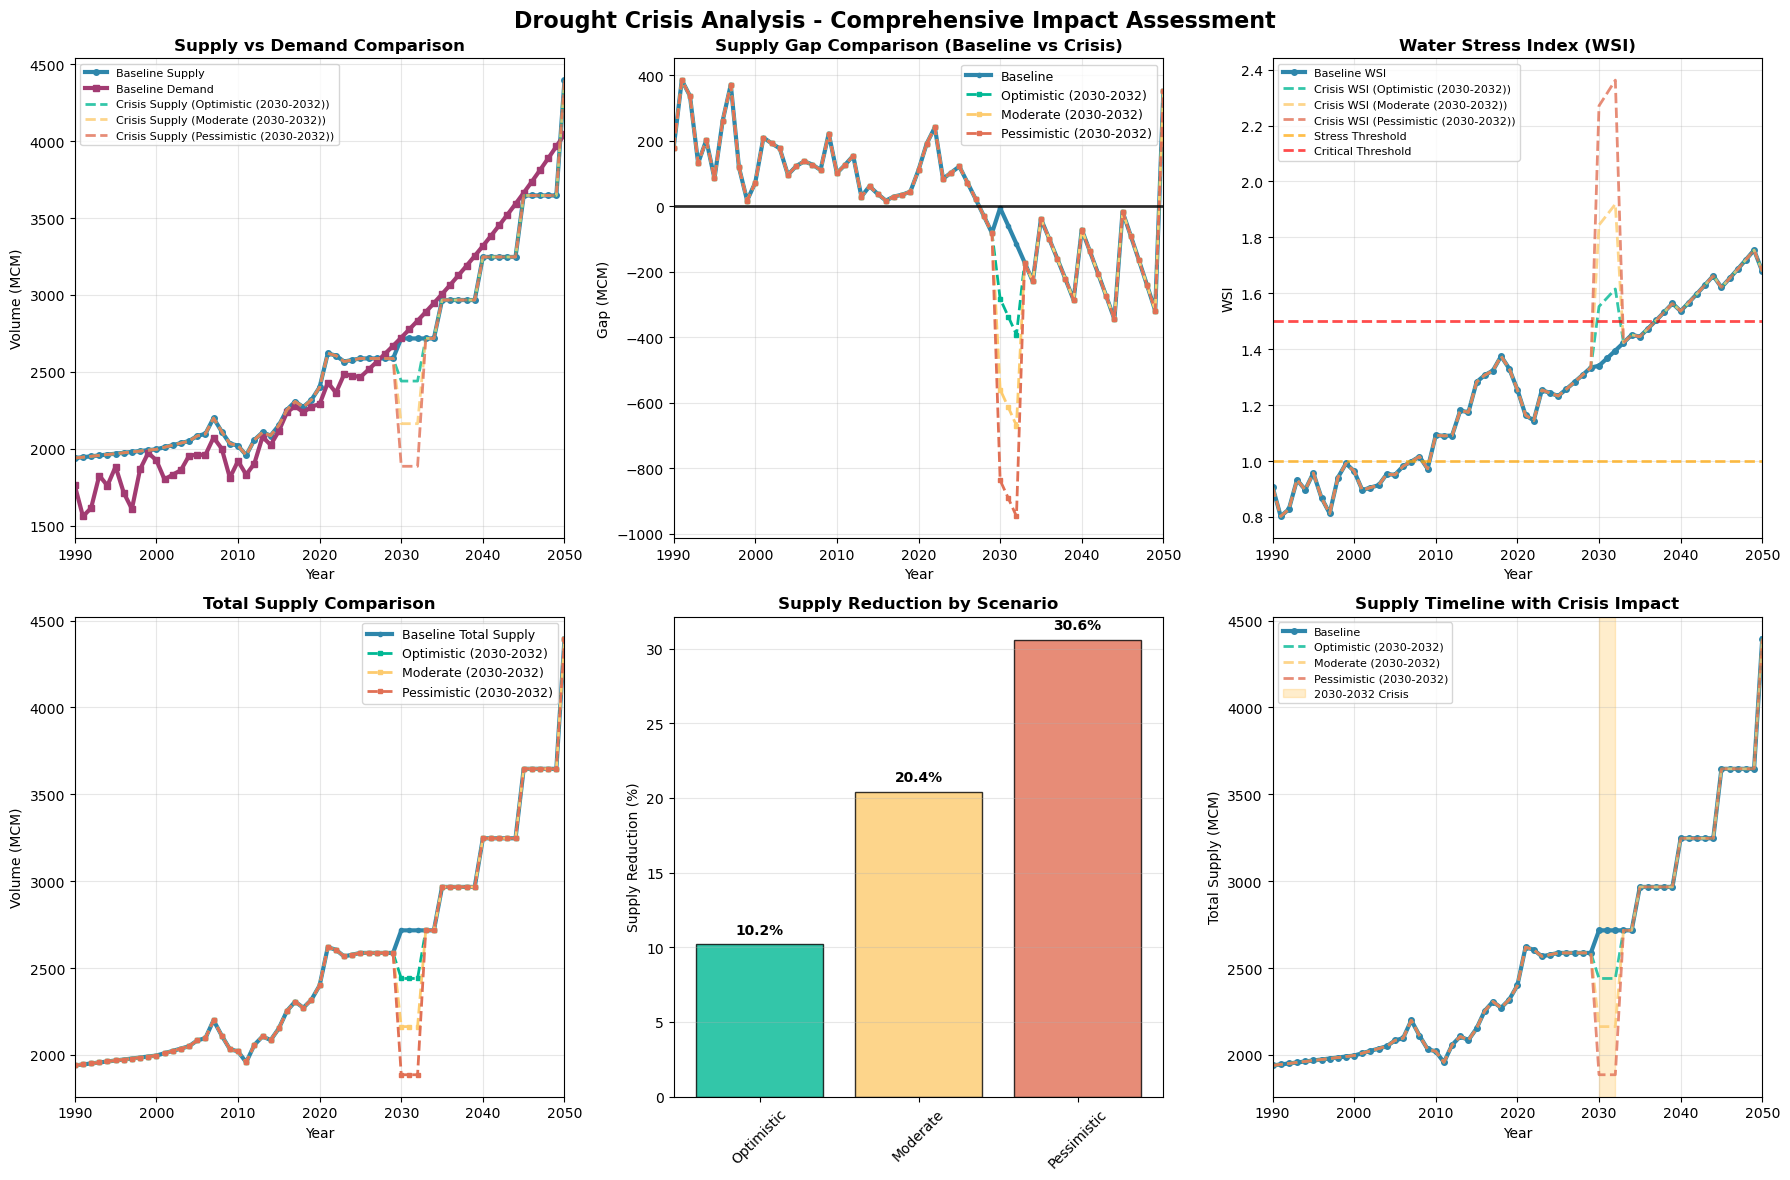


📊 Drought Crisis Scenario Summary
Baseline Crisis Period (2030-2032):
  Average Supply: 2716.9 MCM
  Average Demand: 2777.1 MCM
  Average Surplus: -60.2 MCM
  Average WSI: 1.37

Optimistic (2030-2032) Scenario:
  Average Supply: 2439.8 MCM (+10.2% change)
  Average Demand: 2777.1 MCM
  Average Surplus: -337.3 MCM (-277.1 MCM change)
  Average WSI: 1.58 (+0.22 change)
  Risk Level: 🔴 CRITICAL

Moderate (2030-2032) Scenario:
  Average Supply: 2162.6 MCM (+20.4% change)
  Average Demand: 2777.1 MCM
  Average Surplus: -614.5 MCM (-554.3 MCM change)
  Average WSI: 1.88 (+0.51 change)
  Risk Level: 🔴 CRITICAL

Pessimistic (2030-2032) Scenario:
  Average Supply: 1885.5 MCM (+30.6% change)
  Average Demand: 2777.1 MCM
  Average Surplus: -891.6 MCM (-831.4 MCM change)
  Average WSI: 2.32 (+0.95 change)
  Risk Level: 🔴 CRITICAL

Overall Impact Assessment:
  Maximum Supply Reduction: 30.6%
  Minimum Supply Reduction: 10.2%
  Average Supply Reduction: 20.4%

✅ Drought crisis analysis complete!
📊 

In [60]:
"""
This module performs drought crisis analysis using parameters loaded from a
CSV file. It applies drought scenarios to integrated baseline data and
generates visualizations and summaries. The analysis is also extended to
integrated historical and projected timelines to evaluate impacts across
both past and future periods.

Each line is annotated with detailed comments to clarify what is
happening without modifying the original behavior.
"""

# =============================================================================
# DROUGHT CRISIS ANALYSIS - Main drought scenario analysis
# =============================================================================

# Print a header indicating the start of drought crisis analysis
print("🌵 DROUGHT CRISIS ANALYSIS")
# Print a separator line for readability
print("=" * 60)

# Load drought parameters from CSV using a helper function
params = load_parameters("drought_params.csv")
# Confirm that the parameters have been loaded and list the keys
print(f"✅ Loaded drought parameters: {list(params.keys())}")

# Use the integrated_data already processed during forward projections
# This baseline includes historical and projected data; no need to recompute
baseline_data = integrated_data.copy()
# Report the range of years available in the baseline
print(f"✅ Using same integrated baseline data: {baseline_data['year'].min()}-{baseline_data['year'].max()}")
# Report the dimensions of the baseline dataset
print(f"✅ Baseline data already processed: {baseline_data.shape[0]} rows × {baseline_data.shape[1]} columns")

# Apply drought crisis scenarios
print("🌵 Running drought crisis scenarios...")
# Initialize a dictionary to store results for each scenario
drought_results = {}

# Define crisis scenarios with a standardized period (2030‑2032) and severity levels
crisis_scenarios = [
    {"years": [2030, 2031, 2032], "severity": "Optimistic"},
    {"years": [2030, 2031, 2032], "severity": "Moderate"},
    {"years": [2030, 2031, 2032], "severity": "Pessimistic"}
]

# Iterate over each crisis configuration
for config in crisis_scenarios:
    # Build a scenario name including severity and year range
    scenario_name = f"{config['severity']} ({config['years'][0]}-{config['years'][-1]})"
    # Announce which scenario is running
    print(f"   Running {scenario_name}...")
    
    # Apply the drought crisis using the corrected function
    result = apply_drought_crisis_corrected(baseline_data, config["years"], config["severity"], params)
    # Store the result keyed by scenario name
    drought_results[scenario_name] = result
    # Print details of the scenario execution
    print(f"   Years: {config['years']}, Severity: {config['severity']}")

# Create comprehensive drought crisis visualization
print("\n📊 Creating comprehensive drought crisis visualization...")
# Use the create_comprehensive_crisis_visualization function to generate a figure
drought_fig = create_comprehensive_crisis_visualization(
    baseline_data, drought_results, "Drought Crisis", [2030, 2031, 2032], 2030
)
# Save the figure to a file
plt.savefig('drought_crisis_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
# Display the figure
plt.show()

# Print scenario summaries using the helper function
print_scenario_summary(drought_results, baseline_data, [2030, 2031, 2032], "Drought Crisis")

# Indicate completion of drought crisis analysis
print("\n✅ Drought crisis analysis complete!")
# Provide the filename of the saved visualizations
print("📊 Visualizations saved as 'drought_crisis_analysis.png'")

# =============================================================================
# INTEGRATED TIMELINE DROUGHT ASSESSMENT (1990-2050)
# =============================================================================

# Print a header for integrated timeline drought assessment
print("\n🌵 INTEGRATED TIMELINE DROUGHT ASSESSMENT")
# Print a separator line
print("=" * 60)
# Explain that both historical and projected periods will be tested for drought impacts
print("Testing drought impacts on both historical and projected periods...")

# Apply drought crisis to the integrated timeline data
print("\n🌵 Running integrated timeline drought scenarios...")
# Initialize a dictionary to store results for integrated timeline scenarios
integrated_drought_results = {}

# Define crisis scenarios for the integrated timeline with the same period and severities
integrated_crisis_configs = [
    {"years": [2030, 2031, 2032], "severity": "Optimistic"},
    {"years": [2030, 2031, 2032], "severity": "Moderate"},
    {"years": [2030, 2031, 2032], "severity": "Pessimistic"}
]

# Run each integrated scenario configuration
for config in integrated_crisis_configs:
    # Formulate a scenario name with severity and years
    scenario_name = f"{config['severity']} ({config['years'][0]}-{config['years'][-1]})"
    # Announce that the scenario is running
    print(f"   Running {scenario_name}...")
    
    # Apply the drought crisis to the full integrated timeline
    result = apply_drought_crisis_corrected(integrated_data, config["years"], config["severity"], params)
    # Store results keyed by scenario name
    integrated_drought_results[scenario_name] = result
    # Print details for the scenario
    print(f"   Years: {config['years']}, Severity: {config['severity']}")

# Print integrated scenario summaries using the helper function
print_scenario_summary(integrated_drought_results, integrated_data, [2020, 2021, 2022], "Integrated Timeline Drought Crisis")

# Additional analysis for projected period droughts
print("\n📊 Projected Period Drought Impact Analysis:")
# Print a separator line
print("=" * 50)

# Iterate over each scenario result to compute additional metrics
for scenario_name, result in integrated_drought_results.items():
    # Only analyze projected period scenarios (2030-2032 or 2040-2042)
    if "2030" in scenario_name or "2040" in scenario_name:
        # Determine which crisis years to analyze based on scenario name
        crisis_years = [2030, 2031, 2032] if "2030" in scenario_name else [2040, 2041, 2042]
        # Extract baseline data for the crisis years
        baseline_crisis = integrated_data[integrated_data['year'].isin(crisis_years)]
        # Extract drought scenario data for the same years
        drought_crisis = result[result['year'].isin(crisis_years)]
        
        # Compute baseline and drought average supply
        baseline_avg_supply = baseline_crisis['total_supply_mcm'].mean()
        drought_avg_supply = drought_crisis['total_supply_mcm'].mean()
        # Calculate supply reduction percentage
        supply_reduction = ((baseline_avg_supply - drought_avg_supply) / baseline_avg_supply) * 100
        
        # Compute baseline and drought average demand
        baseline_avg_demand = baseline_crisis['total_demand'].mean()
        drought_avg_demand = drought_crisis['total_demand'].mean()
        # Calculate demand change percentage
        demand_change = ((drought_avg_demand - baseline_avg_demand) / baseline_avg_demand) * 100
        
        # Print a summary of supply and demand changes
        print(f"\n{scenario_name}:")
        print(f"  Supply: {baseline_avg_supply:.1f} → {drought_avg_supply:.1f} MCM ({supply_reduction:.1f}% reduction)")
        print(f"  Demand: {baseline_avg_demand:.1f} → {drought_avg_demand:.1f} MCM ({demand_change:+.1f}% change)")
        print(f"  Surplus: {baseline_crisis['surplus_mcm'].mean():.1f} → {drought_crisis['surplus_mcm'].mean():.1f} MCM")

# Conclude the integrated timeline drought assessment
print("\n✅ Integrated timeline drought assessment complete!")
# Indicate the filename for the saved visualizations
print("📊 Visualizations saved as 'integrated_timeline_drought_analysis.png'")

In [61]:
# =============================================================================
# VALIDATE INTEGRATED_DATA COMPLETENESS FOR BASELINE ADAPTATION
# =============================================================================

print("🔍 VALIDATING INTEGRATED_DATA FOR BASELINE ADAPTATION")
print("=" * 60)

# Required components for baseline adaptation
required_components = {
    'year': 'Year column',
    'water_desalination_mcm': 'Desalination supply',
    'capped_groundwater': 'Groundwater supply', 
    'produced_by_kinneret_milion_m3': 'Surface water supply',
    'capped_reuse': 'Reuse water supply',
    'total_produced_by_upper_water_milion_m3': 'Upper water supply',
    'total_supply_mcm': 'Total supply',
    'renewable_supply_mcm': 'Renewable supply',
    'total_demand': 'Total demand',
    'wsi': 'Water Stress Index',
    'ddr': 'Desalination Dependency Ratio',
    'surplus_mcm': 'Supply-demand surplus'
}

# Check for required columns
missing_columns = []
present_columns = []
for col, description in required_components.items():
    if col in integrated_data.columns:
        present_columns.append(f"✅ {col}: {description}")
    else:
        missing_columns.append(f"❌ {col}: {description}")

print("📊 REQUIRED COMPONENTS CHECK:")
for item in present_columns:
    print(f"   {item}")

if missing_columns:
    print("\n⚠️  MISSING COMPONENTS:")
    for item in missing_columns:
        print(f"   {item}")
else:
    print("\n✅ ALL REQUIRED COMPONENTS PRESENT!")

# Check data completeness
print(f"\n📈 DATA COMPLETENESS:")
print(f"   Years covered: {integrated_data['year'].min()}-{integrated_data['year'].max()}")
print(f"   Total years: {len(integrated_data)}")
print(f"   Historical years (1990-2023): {len(integrated_data[integrated_data['year'] <= 2023])}")
print(f"   Projected years (2024-2050): {len(integrated_data[integrated_data['year'] >= 2024])}")

# Check for any NaN values in critical columns
critical_columns = ['total_supply_mcm', 'total_demand', 'wsi', 'ddr', 'surplus_mcm']
print(f"\n🔍 DATA QUALITY CHECK:")
for col in critical_columns:
    if col in integrated_data.columns:
        nan_count = integrated_data[col].isna().sum()
        if nan_count == 0:
            print(f"   ✅ {col}: No missing values")
        else:
            print(f"   ⚠️  {col}: {nan_count} missing values")

# Display sample data for verification
print(f"\n📋 SAMPLE DATA VERIFICATION:")
print(f"   Sample 2024 data:")
print(f"     Total Supply: {integrated_data[integrated_data['year'] == 2024]['total_supply_mcm'].iloc[0]:.1f} MCM")
print(f"     Total Demand: {integrated_data[integrated_data['year'] == 2024]['total_demand'].iloc[0]:.1f} MCM")
print(f"     WSI: {integrated_data[integrated_data['year'] == 2024]['wsi'].iloc[0]:.2f}")
print(f"     DDR: {integrated_data[integrated_data['year'] == 2024]['ddr'].iloc[0]:.2f}")
print(f"     Surplus: {integrated_data[integrated_data['year'] == 2024]['surplus_mcm'].iloc[0]:.1f} MCM")

print(f"\n🎯 INTEGRATED_DATA IS READY FOR BASELINE ADAPTATION!")
print(f"   This dataset covers 1990-2050 with all required components for crisis analysis.")
print(f"   Use 'integrated_data' as your baseline - NOT 'df_agg' or 'baseline_data'.")
print(f"   The dataset includes:")
print(f"   - All supply components (desalination, groundwater, surface, reuse, upper water)")
print(f"   - Sectoral demands")
print(f"   - Calculated indicators (WSI, DDR, surplus)")
print(f"   - Complete timeline from 1990-2050")


🔍 VALIDATING INTEGRATED_DATA FOR BASELINE ADAPTATION
📊 REQUIRED COMPONENTS CHECK:
   ✅ year: Year column
   ✅ water_desalination_mcm: Desalination supply
   ✅ capped_groundwater: Groundwater supply
   ✅ produced_by_kinneret_milion_m3: Surface water supply
   ✅ capped_reuse: Reuse water supply
   ✅ total_produced_by_upper_water_milion_m3: Upper water supply
   ✅ total_supply_mcm: Total supply
   ✅ renewable_supply_mcm: Renewable supply
   ✅ total_demand: Total demand
   ✅ wsi: Water Stress Index
   ✅ ddr: Desalination Dependency Ratio
   ✅ surplus_mcm: Supply-demand surplus

✅ ALL REQUIRED COMPONENTS PRESENT!

📈 DATA COMPLETENESS:
   Years covered: 1990-2050
   Total years: 61
   Historical years (1990-2023): 34
   Projected years (2024-2050): 27

🔍 DATA QUALITY CHECK:
   ✅ total_supply_mcm: No missing values
   ✅ total_demand: No missing values
   ✅ wsi: No missing values
   ⚠️  ddr: 15 missing values
   ✅ surplus_mcm: No missing values

📋 SAMPLE DATA VERIFICATION:
   Sample 2024 data:

⚡ ENERGY CRISIS ANALYSIS
✅ Loaded energy parameters: ['DesalCapacityFactor', 'OPEXCostMultiplier', 'DurationYears']
⚡ Running energy crisis scenarios...
   Running Optimistic (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Optimistic
   Running Moderate (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Moderate
   Running Pessimistic (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Pessimistic

📊 Creating comprehensive energy crisis visualization...


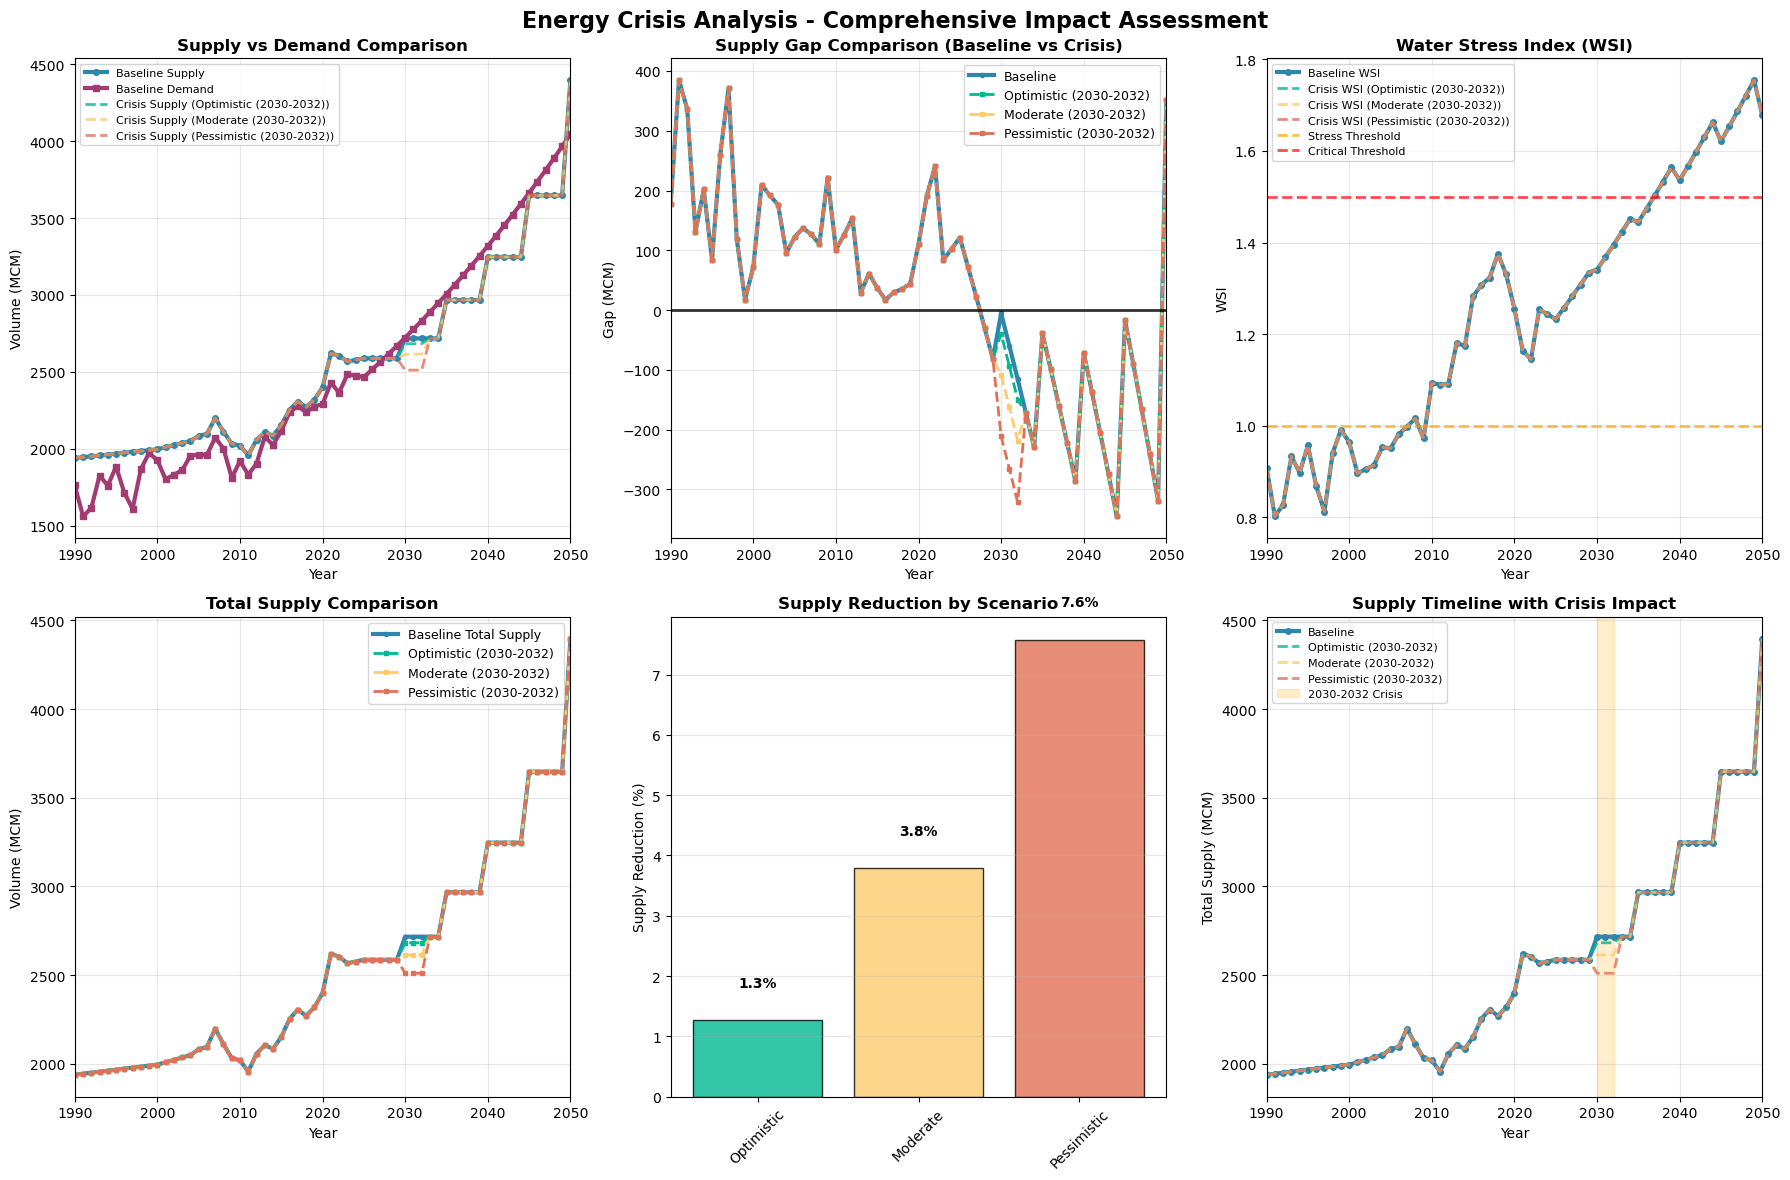


📊 Energy Crisis Scenario Summary
Baseline Crisis Period (2030-2032):
  Average Supply: 2716.9 MCM
  Average Demand: 2777.1 MCM
  Average Surplus: -60.2 MCM
  Average WSI: 1.37

Optimistic (2030-2032) Scenario:
  Average Supply: 2682.6 MCM (+1.3% change)
  Average Demand: 2777.1 MCM
  Average Surplus: -94.5 MCM (-34.3 MCM change)
  Average WSI: 1.37 (+0.00 change)
  Risk Level: 🟡 HIGH

Moderate (2030-2032) Scenario:
  Average Supply: 2613.9 MCM (+3.8% change)
  Average Demand: 2777.1 MCM
  Average Surplus: -163.2 MCM (-103.0 MCM change)
  Average WSI: 1.37 (+0.00 change)
  Risk Level: 🟡 HIGH

Pessimistic (2030-2032) Scenario:
  Average Supply: 2510.9 MCM (+7.6% change)
  Average Demand: 2777.1 MCM
  Average Surplus: -266.2 MCM (-206.0 MCM change)
  Average WSI: 1.37 (+0.00 change)
  Risk Level: 🟡 HIGH

Overall Impact Assessment:
  Maximum Supply Reduction: 7.6%
  Minimum Supply Reduction: 1.3%
  Average Supply Reduction: 4.4%

✅ Energy crisis analysis complete!
📊 Visualizations saved a

In [62]:
"""
This script performs energy crisis analysis by loading energy parameters,
applying energy crisis scenarios to the baseline data, creating a
visualization, and printing summary statistics. The analysis uses
a standardized crisis period (2030–2032) with different severity levels.

Each line includes detailed comments explaining its purpose, while the
original computational logic remains unchanged.
"""

# =============================================================================
# ENERGY CRISIS ANALYSIS
# =============================================================================

# Print a header to denote the start of energy crisis analysis
print("⚡ ENERGY CRISIS ANALYSIS")
# Print a separator line for formatting
print("=" * 60)

# Load energy parameters from a CSV using the helper function
energy_params = load_parameters("energy_params.csv")
# Confirm the loaded parameters by listing their keys
print(f"✅ Loaded energy parameters: {list(energy_params.keys())}")

# Apply energy crisis scenarios
print("⚡ Running energy crisis scenarios...")
# Initialize a dictionary to store results for each energy scenario
energy_results = {}

# Define energy crisis scenarios, each with the same period and varying severities
energy_scenarios = [
    {"years": [2030, 2031, 2032], "severity": "Optimistic"},
    {"years": [2030, 2031, 2032], "severity": "Moderate"},
    {"years": [2030, 2031, 2032], "severity": "Pessimistic"}
]

# Iterate through each energy crisis configuration
for config in energy_scenarios:
    # Create a scenario name for display and storage
    scenario_name = f"{config['severity']} ({config['years'][0]}-{config['years'][-1]})"
    # Announce that the scenario is running
    print(f"   Running {scenario_name}...")
    
    # Apply the energy crisis using the apply_energy_crisis function
    result = apply_energy_crisis(baseline_data, config['years'], config['severity'], energy_params)
    
    # Store the result keyed by the scenario name
    energy_results[scenario_name] = result
    # Print confirmation of the years and severity for the scenario
    print(f"   Years: {config['years']}, Severity: {config['severity']}")

# Create a comprehensive visualization for the energy crisis scenarios
print("\n📊 Creating comprehensive energy crisis visualization...")
# Use the generic crisis visualization function to generate the figure
energy_fig = create_comprehensive_crisis_visualization(
    baseline_data, energy_results, "Energy Crisis", [2030, 2031, 2032], 2025
)
# Save the generated figure to a file
plt.savefig('energy_crisis_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
# Display the figure
plt.show()

# Print summary statistics for each energy scenario
print_scenario_summary(energy_results, baseline_data, [2030, 2031, 2032], "Energy Crisis")

# Indicate that energy crisis analysis is complete
print("\n✅ Energy crisis analysis complete!")
# Provide the filename where visualizations are saved
print("📊 Visualizations saved as 'energy_crisis_analysis.png'")
# Export Energy Crisis Total Supply Reduction to CSV
# Calculate actual total supply reduction percentages (matching the graphs)
import pandas as pd
import os

# Define crisis years for energy crisis
crisis_years = [2030, 2031, 2032]

# Create directory if it doesn't exist
os.makedirs("figure_data_csvs", exist_ok=True)

# Calculate total supply reduction for each scenario
supply_reductions = []
scenario_names = []

for scenario_name, result in energy_results.items():
    # Filter data for crisis years
    crisis_data = result[result['year'].isin(crisis_years)]
    baseline_crisis = baseline_data[baseline_data['year'].isin(crisis_years)]
    
    if len(crisis_data) > 0 and len(baseline_crisis) > 0:
        # Calculate average supply reduction percentage (same as graphs)
        avg_reduction = ((baseline_crisis['total_supply_mcm'].mean() - 
                         crisis_data['total_supply_mcm'].mean()) / 
                        baseline_crisis['total_supply_mcm'].mean() * 100)
        supply_reductions.append(avg_reduction)
        scenario_names.append(scenario_name)

# Create DataFrame with supply reduction percentages
energy_reduction_df = pd.DataFrame({
    'Scenario': scenario_names,
    'Supply_Reduction_Percent': supply_reductions
})

# Export to CSV
csv_path = "figure_data_csvs/08_energy_crisis_analysis.csv"
energy_reduction_df.to_csv(csv_path, index=False)

print(f"\n✅ Energy crisis total supply reduction exported to {csv_path}")
print(f"\nSupply Reduction Summary:")
for idx, row in energy_reduction_df.iterrows():
    print(f"  {row['Scenario']}: {row['Supply_Reduction_Percent']:.2f}%")

⚔️ CONFLICT CRISIS ANALYSIS
✅ Loaded conflict parameters: ['SupplyCapacityFactor', 'AgriculturalDemandChange', 'DomesticDemandChange', 'IndustrialDemandChange', 'OPEXCostMultiplier', 'DurationYears']
✅ Using same integrated baseline data: 1990-2050
✅ Baseline data already processed: 61 rows × 104 columns
⚔️ Running conflict crisis scenarios...
   Running Optimistic (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Optimistic
   Running Moderate (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Moderate
   Running Pessimistic (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Pessimistic

📊 Creating comprehensive conflict crisis visualization...


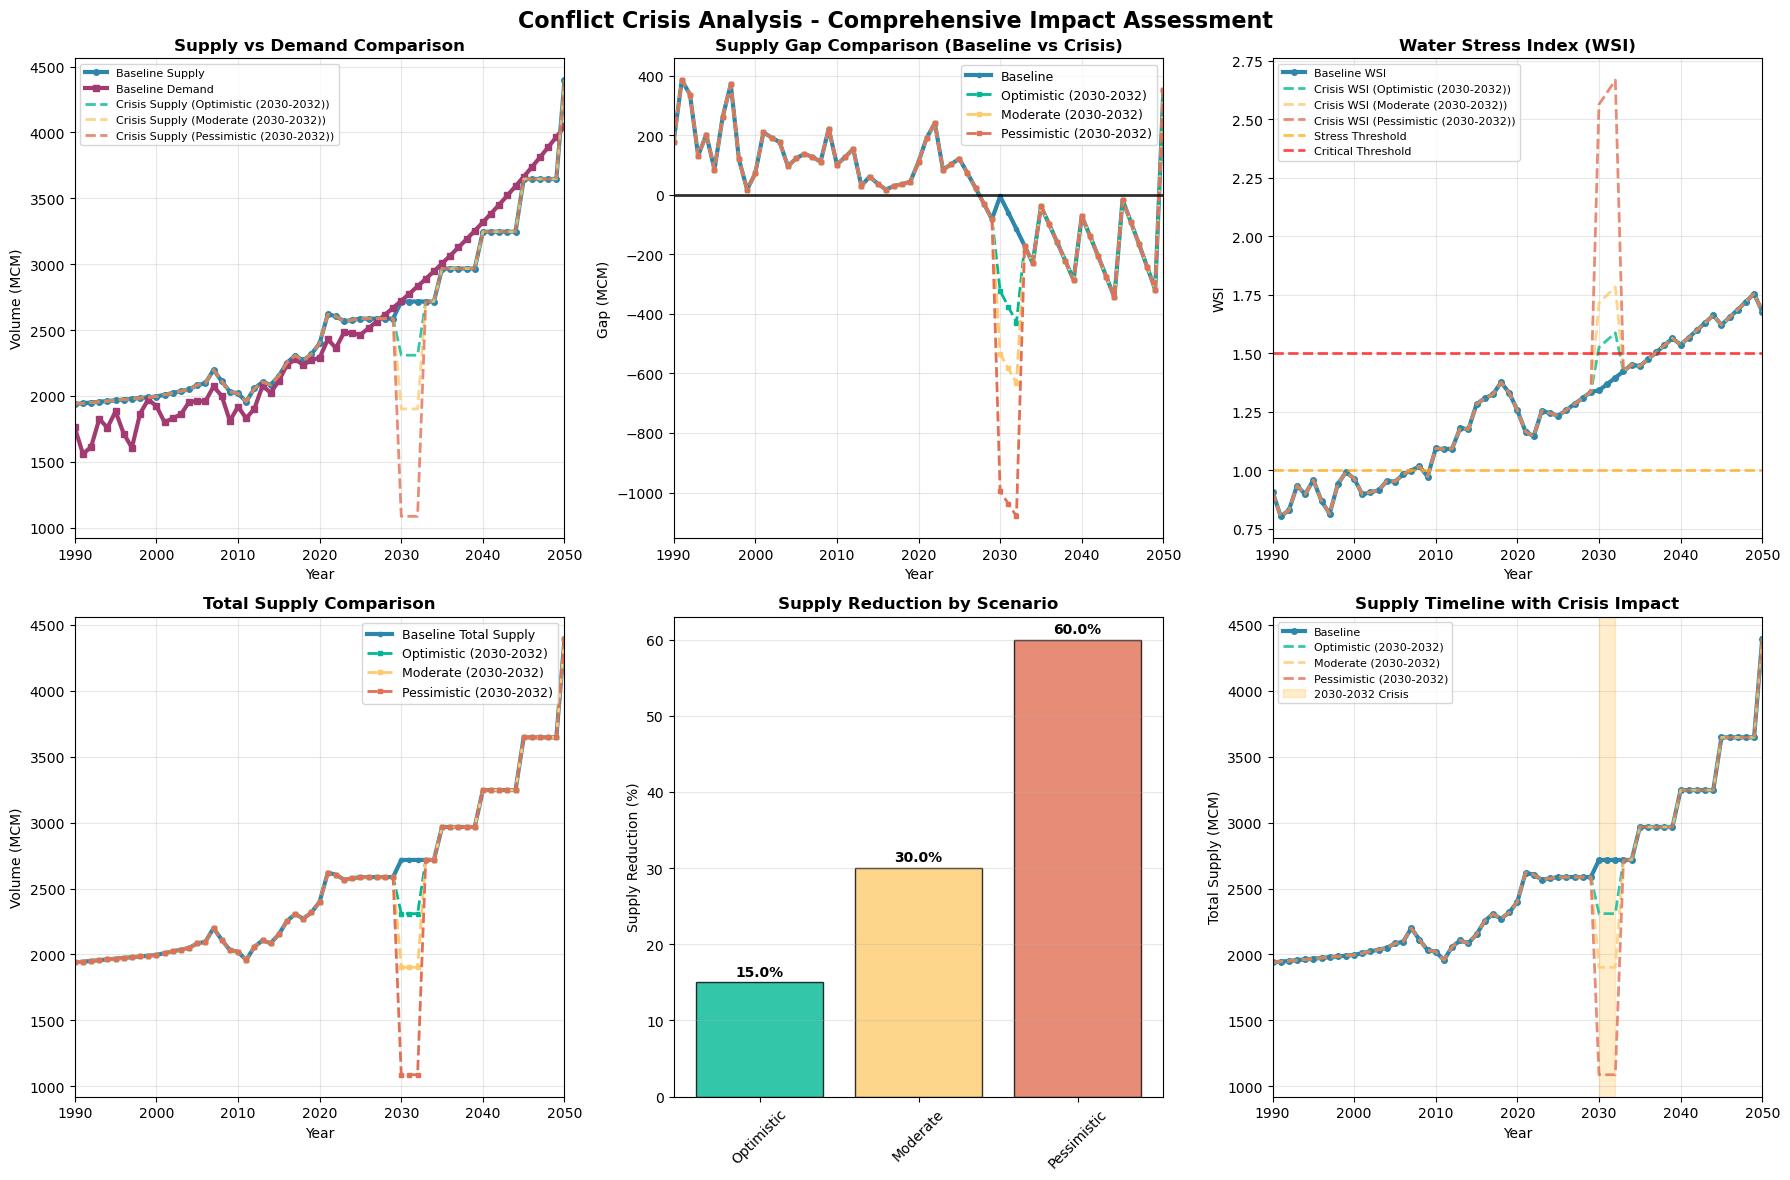


📊 Conflict Crisis Scenario Summary
Baseline Crisis Period (2030-2032):
  Average Supply: 2716.9 MCM
  Average Demand: 2777.1 MCM
  Average Surplus: -60.2 MCM
  Average WSI: 1.37

Optimistic (2030-2032) Scenario:
  Average Supply: 2309.4 MCM (+15.0% change)
  Average Demand: 2685.4 MCM
  Average Surplus: -376.1 MCM (-315.9 MCM change)
  Average WSI: 1.56 (+0.19 change)
  Risk Level: 🔴 CRITICAL

Moderate (2030-2032) Scenario:
  Average Supply: 1901.8 MCM (+30.0% change)
  Average Demand: 2485.5 MCM
  Average Surplus: -583.7 MCM (-523.5 MCM change)
  Average WSI: 1.75 (+0.38 change)
  Risk Level: 🔴 CRITICAL

Pessimistic (2030-2032) Scenario:
  Average Supply: 1086.8 MCM (+60.0% change)
  Average Demand: 2124.5 MCM
  Average Surplus: -1037.7 MCM (-977.5 MCM change)
  Average WSI: 2.62 (+1.25 change)
  Risk Level: 🔴 CRITICAL

Overall Impact Assessment:
  Maximum Supply Reduction: 60.0%
  Minimum Supply Reduction: 15.0%
  Average Supply Reduction: 37.5%

✅ Conflict crisis analysis complete!

In [63]:
"""
This script analyzes the impact of a conflict crisis on water supply and
demand. It loads conflict parameters, applies conflict scenarios to
baseline integrated data, creates a visualization, and prints summary
statistics for each scenario. The scenarios use a standardized period
(2030–2032) and varying severity levels.

Detailed comments are provided for each line to clarify the purpose
without altering the original logic.
"""

# =============================================================================
# CONFLICT CRISIS ANALYSIS
# =============================================================================

# Print header to indicate the conflict crisis analysis stage
print("⚔️ CONFLICT CRISIS ANALYSIS")
# Print separator line
print("=" * 60)

# Load conflict parameters from CSV using helper function
conflict_params = load_parameters("conflict_params.csv")
# Confirm loaded conflict parameters by listing their keys
print(f"✅ Loaded conflict parameters: {list(conflict_params.keys())}")

# Use the integrated data already processed; no recalculations required
baseline_data = integrated_data.copy()
# Print the year range for the baseline data
print(f"✅ Using same integrated baseline data: {baseline_data['year'].min()}-{baseline_data['year'].max()}")
# Print the dimensions of the baseline dataset
print(f"✅ Baseline data already processed: {baseline_data.shape[0]} rows × {baseline_data.shape[1]} columns")

# Announce that conflict crisis scenarios will be applied
print("⚔️ Running conflict crisis scenarios...")
# Initialize a dictionary to store results for each scenario
conflict_results = {}

# Define conflict crisis scenarios (standardized period with severity levels)
conflict_scenarios = [
    {"years": [2030, 2031, 2032], "severity": "Optimistic"},
    {"years": [2030, 2031, 2032], "severity": "Moderate"},
    {"years": [2030, 2031, 2032], "severity": "Pessimistic"}
]

# Iterate over each conflict scenario configuration
for config in conflict_scenarios:
    # Form a scenario name for logging and dictionary keys
    scenario_name = f"{config['severity']} ({config['years'][0]}-{config['years'][-1]})"
    # Announce which scenario is being processed
    print(f"   Running {scenario_name}...")
    
    # Apply conflict crisis using the apply_conflict_crisis function
    result = apply_conflict_crisis(baseline_data, config["years"], config["severity"], conflict_params)
    # Store the results under the scenario name
    conflict_results[scenario_name] = result
    # Print the years and severity level for confirmation
    print(f"   Years: {config['years']}, Severity: {config['severity']}")

# Create a comprehensive conflict crisis visualization
print("\n📊 Creating comprehensive conflict crisis visualization...")
# Generate the figure using the generic visualization function
conflict_fig = create_comprehensive_crisis_visualization(
    baseline_data, conflict_results, "Conflict Crisis", [2030, 2031, 2032], 2030
)
# Save the figure to a file
plt.savefig('conflict_crisis_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
# Display the figure
plt.show()

# Print scenario summaries for each conflict scenario
print_scenario_summary(conflict_results, baseline_data, [2030, 2031, 2032], "Conflict Crisis")

# Announce completion of conflict crisis analysis
print("\n✅ Conflict crisis analysis complete!")
# Provide the filename of the saved visuals
print("📊 Visualizations saved as 'conflict_crisis_analysis.png'")

🔒 CYBER CRISIS ANALYSIS (CORRECTED)
✅ Loaded cyber parameters: ['DesalDowntimeFraction', 'AffectedSupplyProportion', 'OPEXCostMultiplier']
✅ Using same integrated baseline data: 1990-2050
✅ Baseline data already processed: 61 rows × 104 columns
🔒 Running cyber crisis scenarios...
   Running Optimistic (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Optimistic
   Running Moderate (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Moderate
   Running Pessimistic (2030-2032)...
   Years: [2030, 2031, 2032], Severity: Pessimistic

📊 Creating comprehensive cyber crisis visualization...


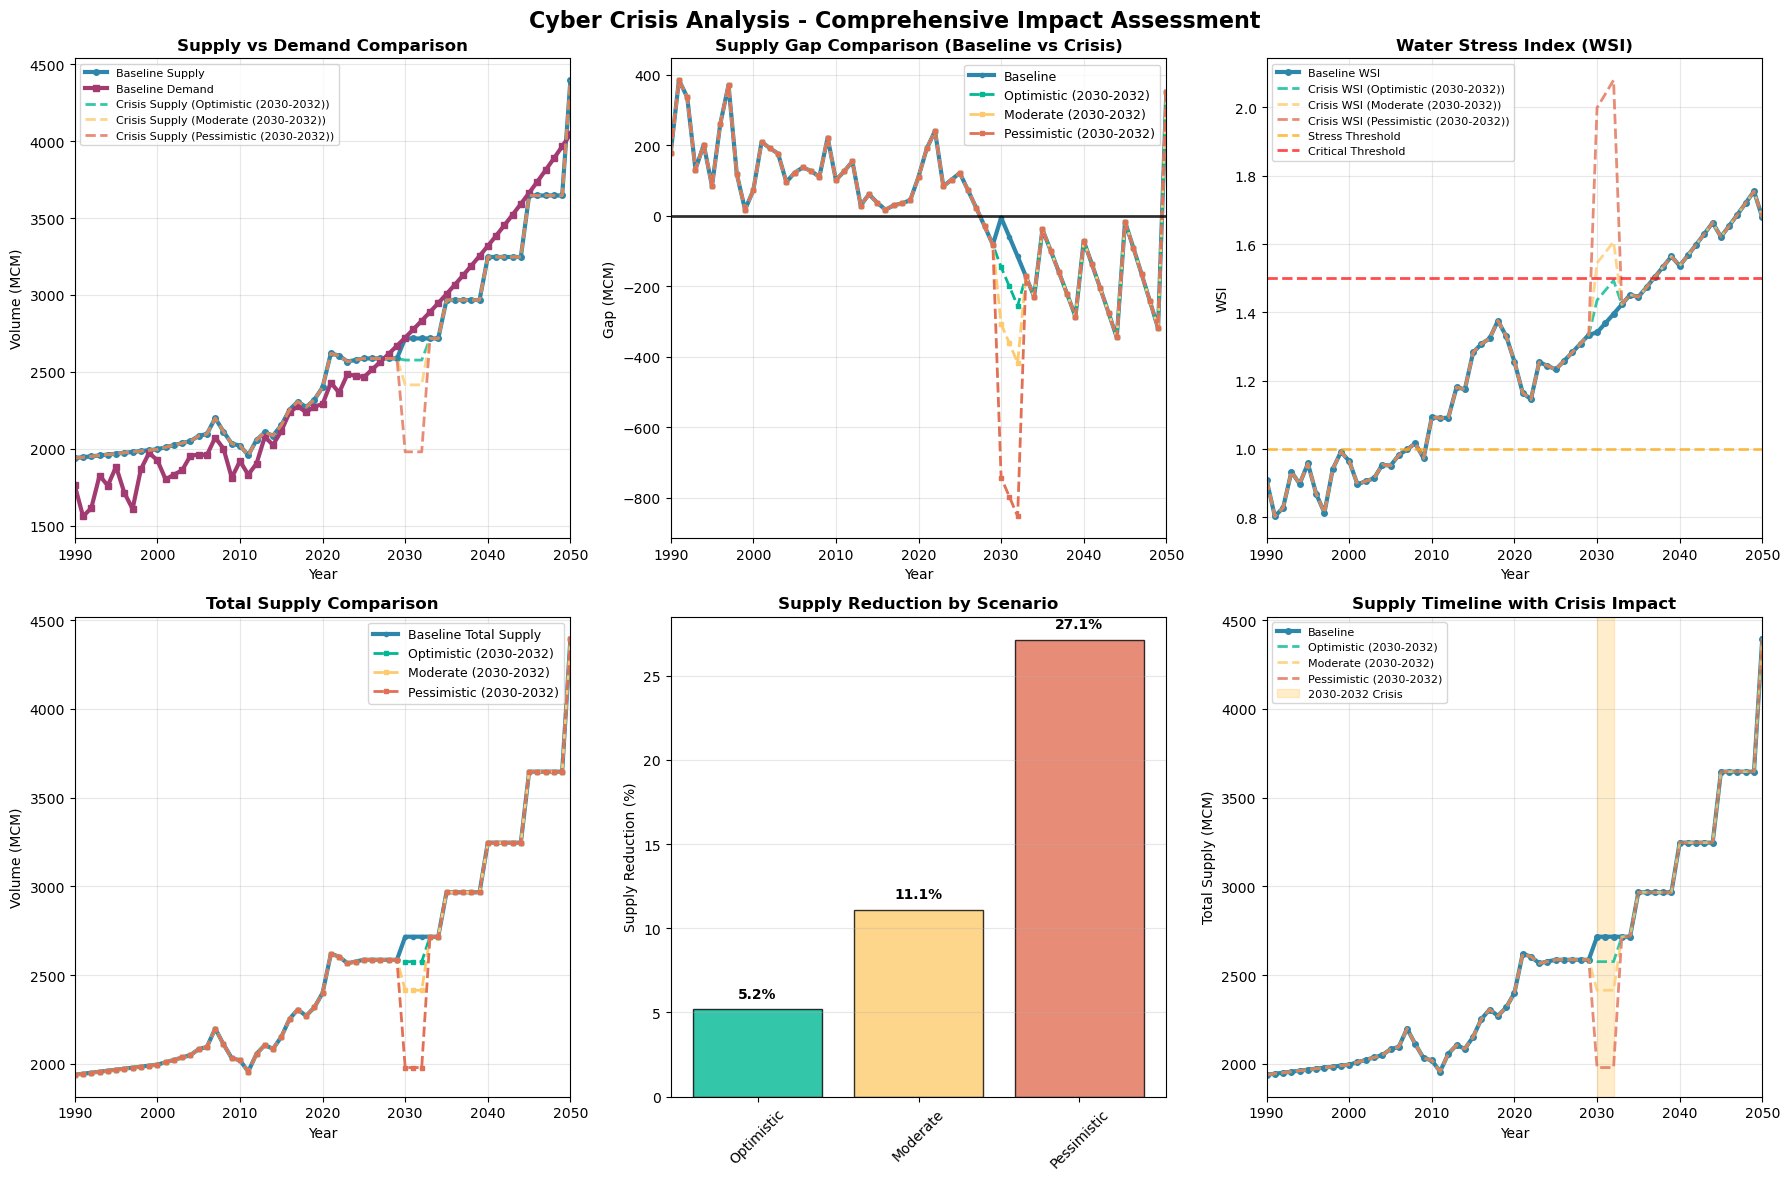


📊 Cyber Crisis Scenario Summary
Baseline Crisis Period (2030-2032):
  Average Supply: 2716.9 MCM
  Average Demand: 2777.1 MCM
  Average Surplus: -60.2 MCM
  Average WSI: 1.37

Optimistic (2030-2032) Scenario:
  Average Supply: 2576.3 MCM (+5.2% change)
  Average Demand: 2777.1 MCM
  Average Surplus: -200.8 MCM (-140.6 MCM change)
  Average WSI: 1.46 (+0.10 change)
  Risk Level: 🟡 HIGH

Moderate (2030-2032) Scenario:
  Average Supply: 2415.1 MCM (+11.1% change)
  Average Demand: 2777.1 MCM
  Average Surplus: -362.0 MCM (-301.8 MCM change)
  Average WSI: 1.58 (+0.21 change)
  Risk Level: 🔴 CRITICAL

Pessimistic (2030-2032) Scenario:
  Average Supply: 1979.5 MCM (+27.1% change)
  Average Demand: 2777.1 MCM
  Average Surplus: -797.6 MCM (-737.4 MCM change)
  Average WSI: 2.04 (+0.67 change)
  Risk Level: 🔴 CRITICAL

Overall Impact Assessment:
  Maximum Supply Reduction: 27.1%
  Minimum Supply Reduction: 5.2%
  Average Supply Reduction: 16.2%

✅ Cyber crisis analysis complete!
📊 Visualizat

In [64]:
"""
This script performs analysis of a cyber crisis scenario. It loads
cyber-specific parameters, applies crisis scenarios with different
severity levels to the baseline data, creates a visualization,
and prints summary statistics. The scenarios use a standardized period
(2030–2032) for comparison.

Detailed comments accompany each line to explain the code's function
without altering its original behavior.
"""

# =============================================================================
# CYBER CRISIS ANALYSIS 
# =============================================================================

# Print header indicating the start of cyber crisis analysis
print("🔒 CYBER CRISIS ANALYSIS (CORRECTED)")
# Print a separator line for visual clarity
print("=" * 60)

# Load cyber parameters from a CSV file
cyber_params = load_parameters("cyber_params.csv")
# Confirm that parameters have been loaded by listing their keys
print(f"✅ Loaded cyber parameters: {list(cyber_params.keys())}")

# Use the integrated baseline data previously processed; no need to recalc
baseline_data = integrated_data.copy()
# Print the year range of the baseline data
print(f"✅ Using same integrated baseline data: {baseline_data['year'].min()}-{baseline_data['year'].max()}")
# Print the dimensions of the baseline data
print(f"✅ Baseline data already processed: {baseline_data.shape[0]} rows × {baseline_data.shape[1]} columns")

# Announce the start of cyber crisis scenarios
print("🔒 Running cyber crisis scenarios...")
# Initialize a dictionary to store results for each cyber scenario
cyber_results = {}

# Define cyber crisis scenarios with a standard period and different severities
cyber_scenarios = [
    {"years": [2030, 2031, 2032], "severity": "Optimistic"},
    {"years": [2030, 2031, 2032], "severity": "Moderate"},
    {"years": [2030, 2031, 2032], "severity": "Pessimistic"}
]

# Loop through each cyber crisis configuration
for config in cyber_scenarios:
    # Form a scenario name using severity and year range
    scenario_name = f"{config['severity']} ({config['years'][0]}-{config['years'][-1]})"
    # Print which scenario is being run
    print(f"   Running {scenario_name}...")
    
    # Apply the cyber crisis using the apply_cyber_crisis function
    result = apply_cyber_crisis(baseline_data, config["years"], config["severity"], cyber_params)
    # Store the result keyed by scenario name
    cyber_results[scenario_name] = result
    # Log the configuration details
    print(f"   Years: {config['years']}, Severity: {config['severity']}")

# Create comprehensive cyber crisis visualization
print("\n📊 Creating comprehensive cyber crisis visualization...")
# Call the generic visualization function with cyber results
cyber_fig = create_comprehensive_crisis_visualization(
    baseline_data, cyber_results, "Cyber Crisis", [2030, 2031, 2032], 2030
)
# Save the resulting figure to a file
plt.savefig('cyber_crisis_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
# Display the figure
plt.show()

# Print scenario summaries for the cyber crisis analysis
print_scenario_summary(cyber_results, baseline_data, [2030, 2031, 2032], "Cyber Crisis")

# Announce completion of cyber crisis analysis
print("\n✅ Cyber crisis analysis complete!")
# Provide the filename where visualizations are saved
print("📊 Visualizations saved as 'cyber_crisis_analysis.png'")

📊 COMPREHENSIVE CRISIS COMPARISON ANALYSIS - ALL GRAPHS FIXED
✅ Using integrated baseline data: 1990-2050
✅ Baseline data shape: 61 rows × 104 columns

📊 Creating FIXED visualization for Optimistic scenario...
   ✅ Figure 1 saved as 'comprehensive_crisis_comparison_optimistic_scenario_part1_FIXED.png'
   ✅ Figure 2 saved as 'comprehensive_crisis_comparison_optimistic_scenario_part2_FIXED.png'


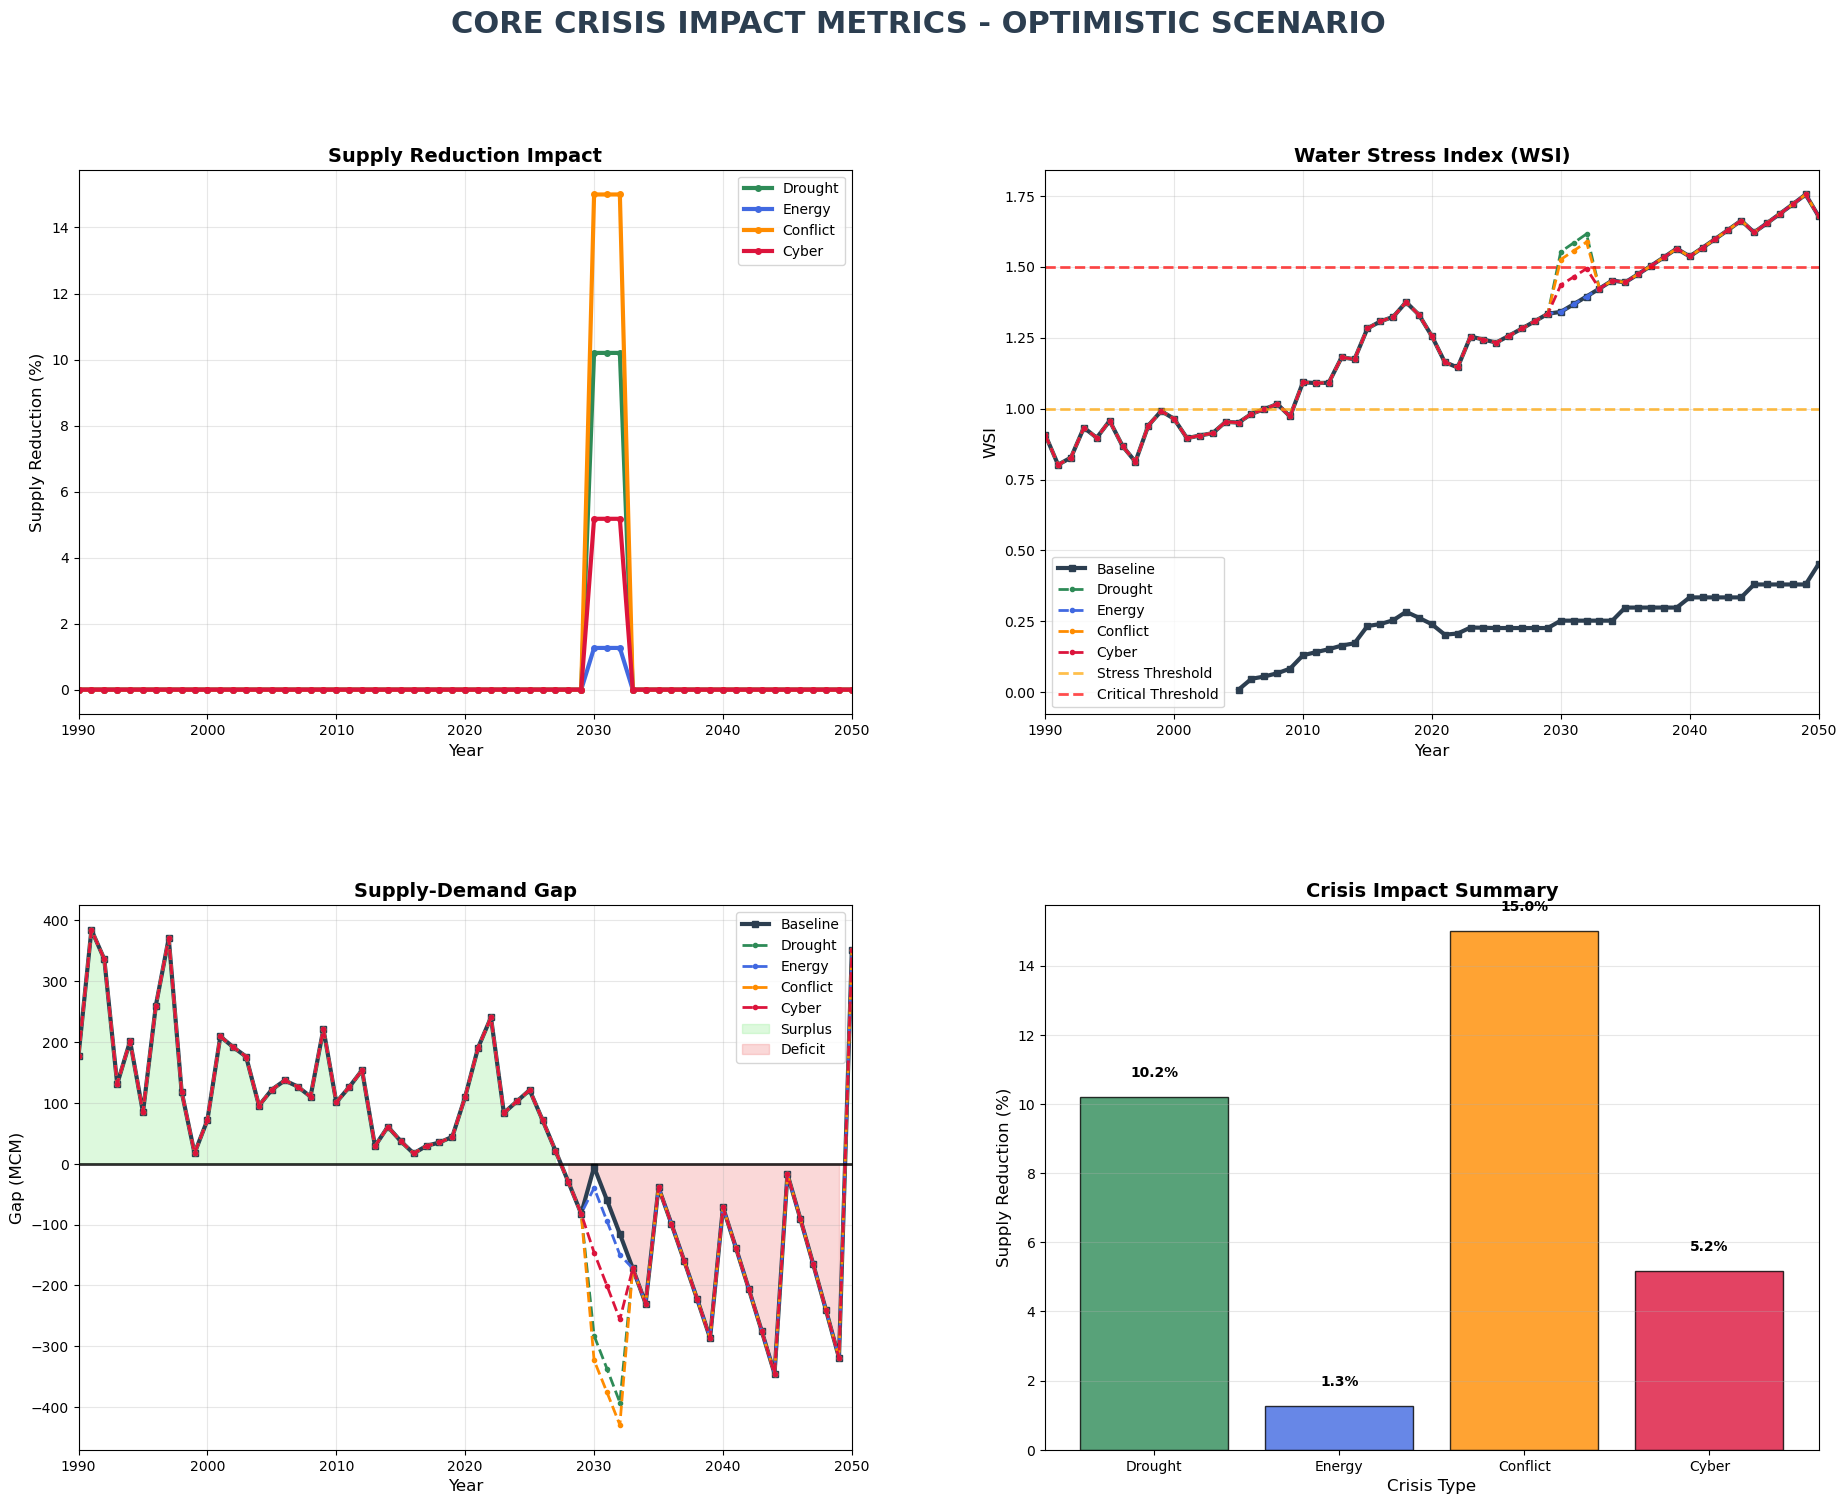

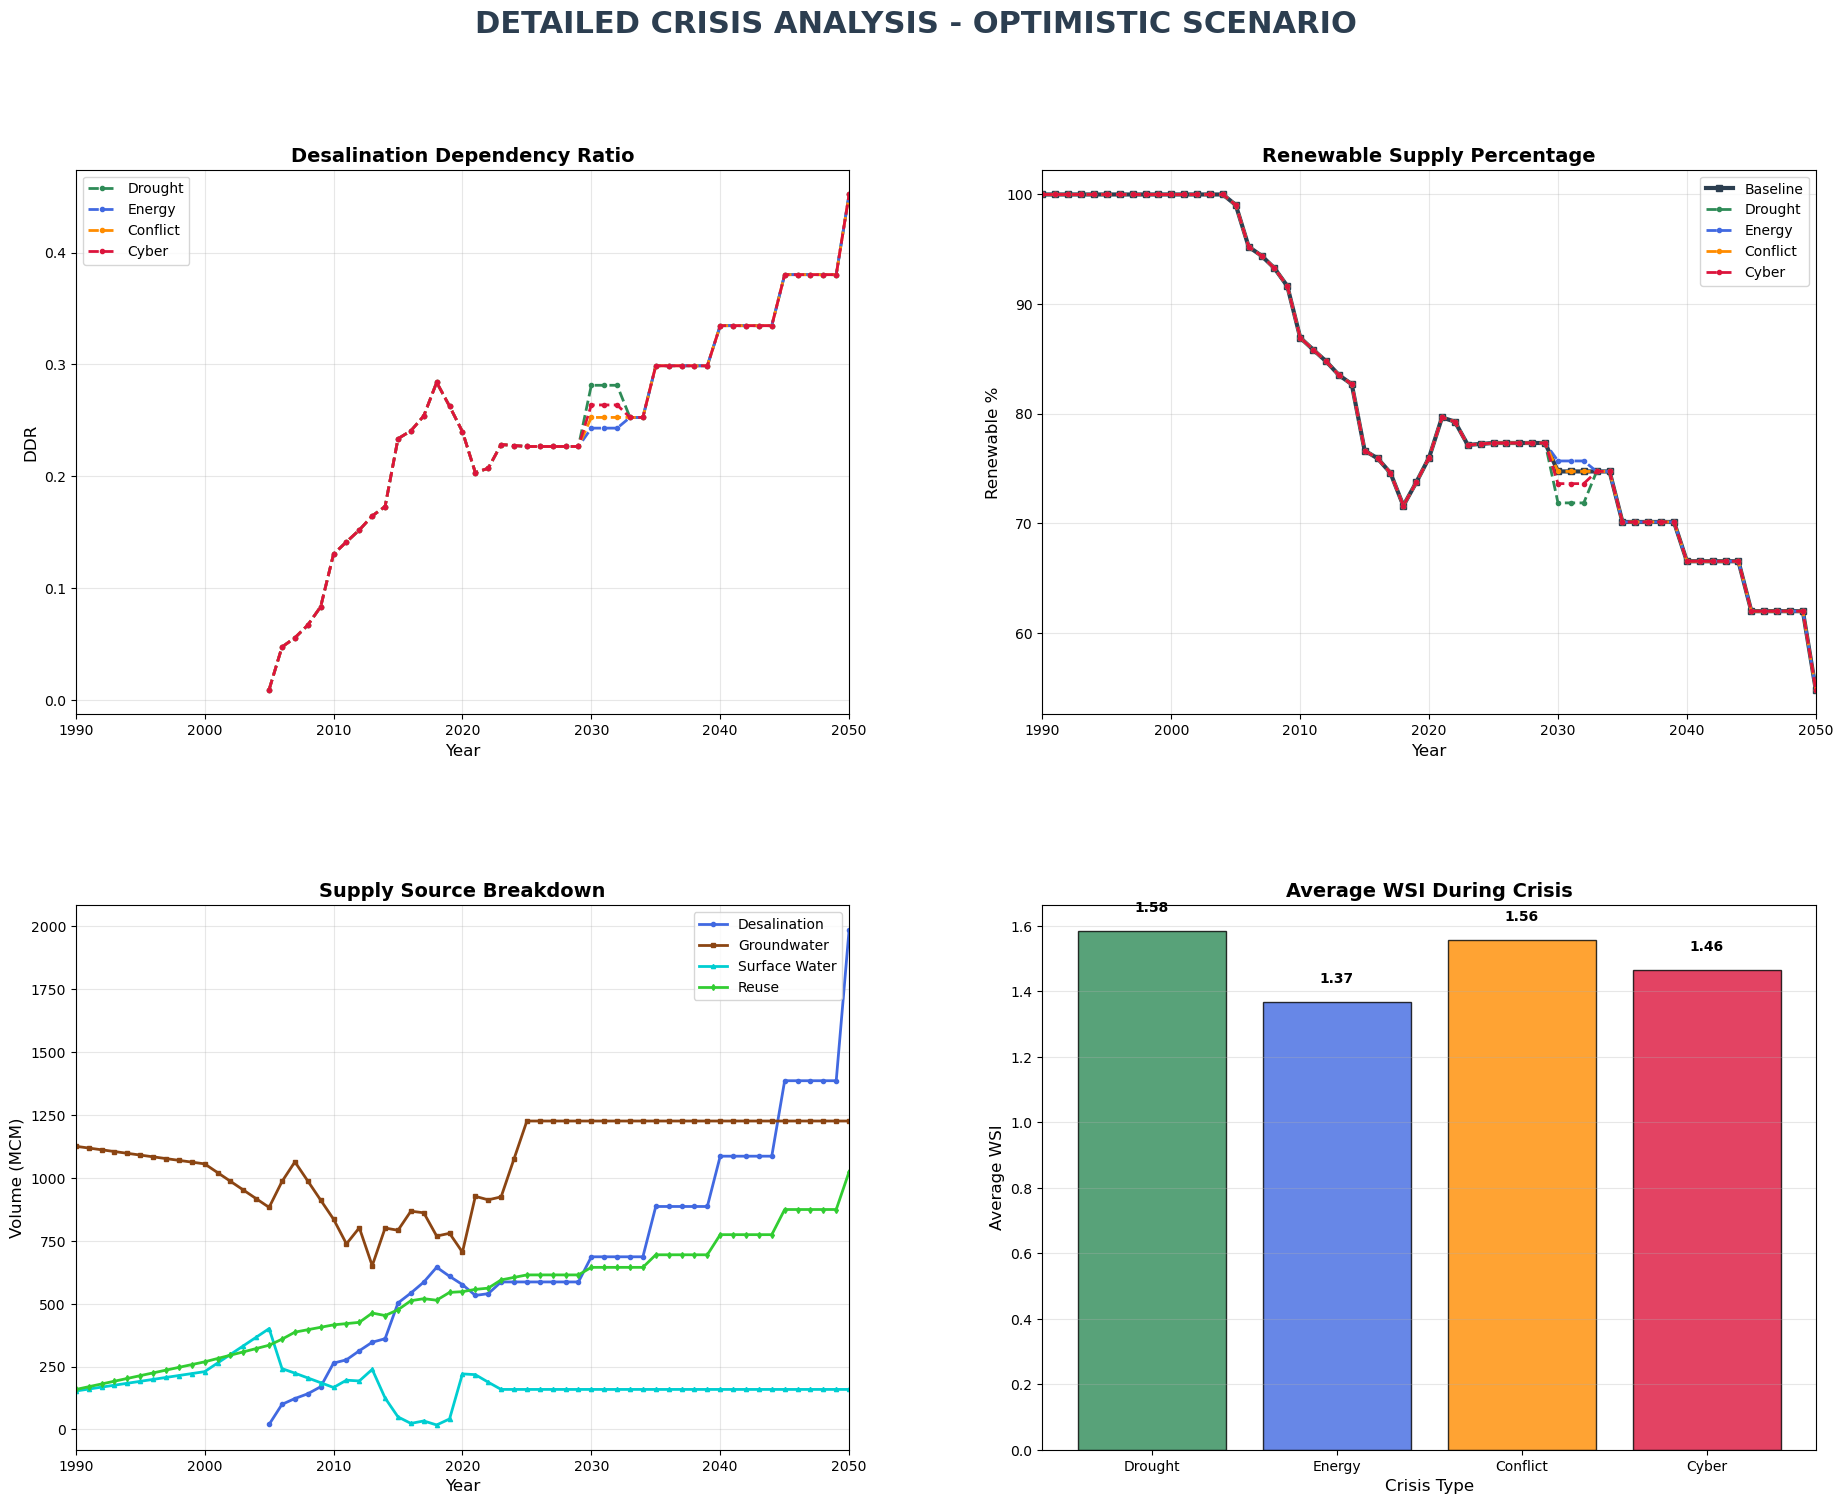


📊 Creating FIXED visualization for Moderate scenario...
   ✅ Figure 1 saved as 'comprehensive_crisis_comparison_moderate_scenario_part1_FIXED.png'
   ✅ Figure 2 saved as 'comprehensive_crisis_comparison_moderate_scenario_part2_FIXED.png'


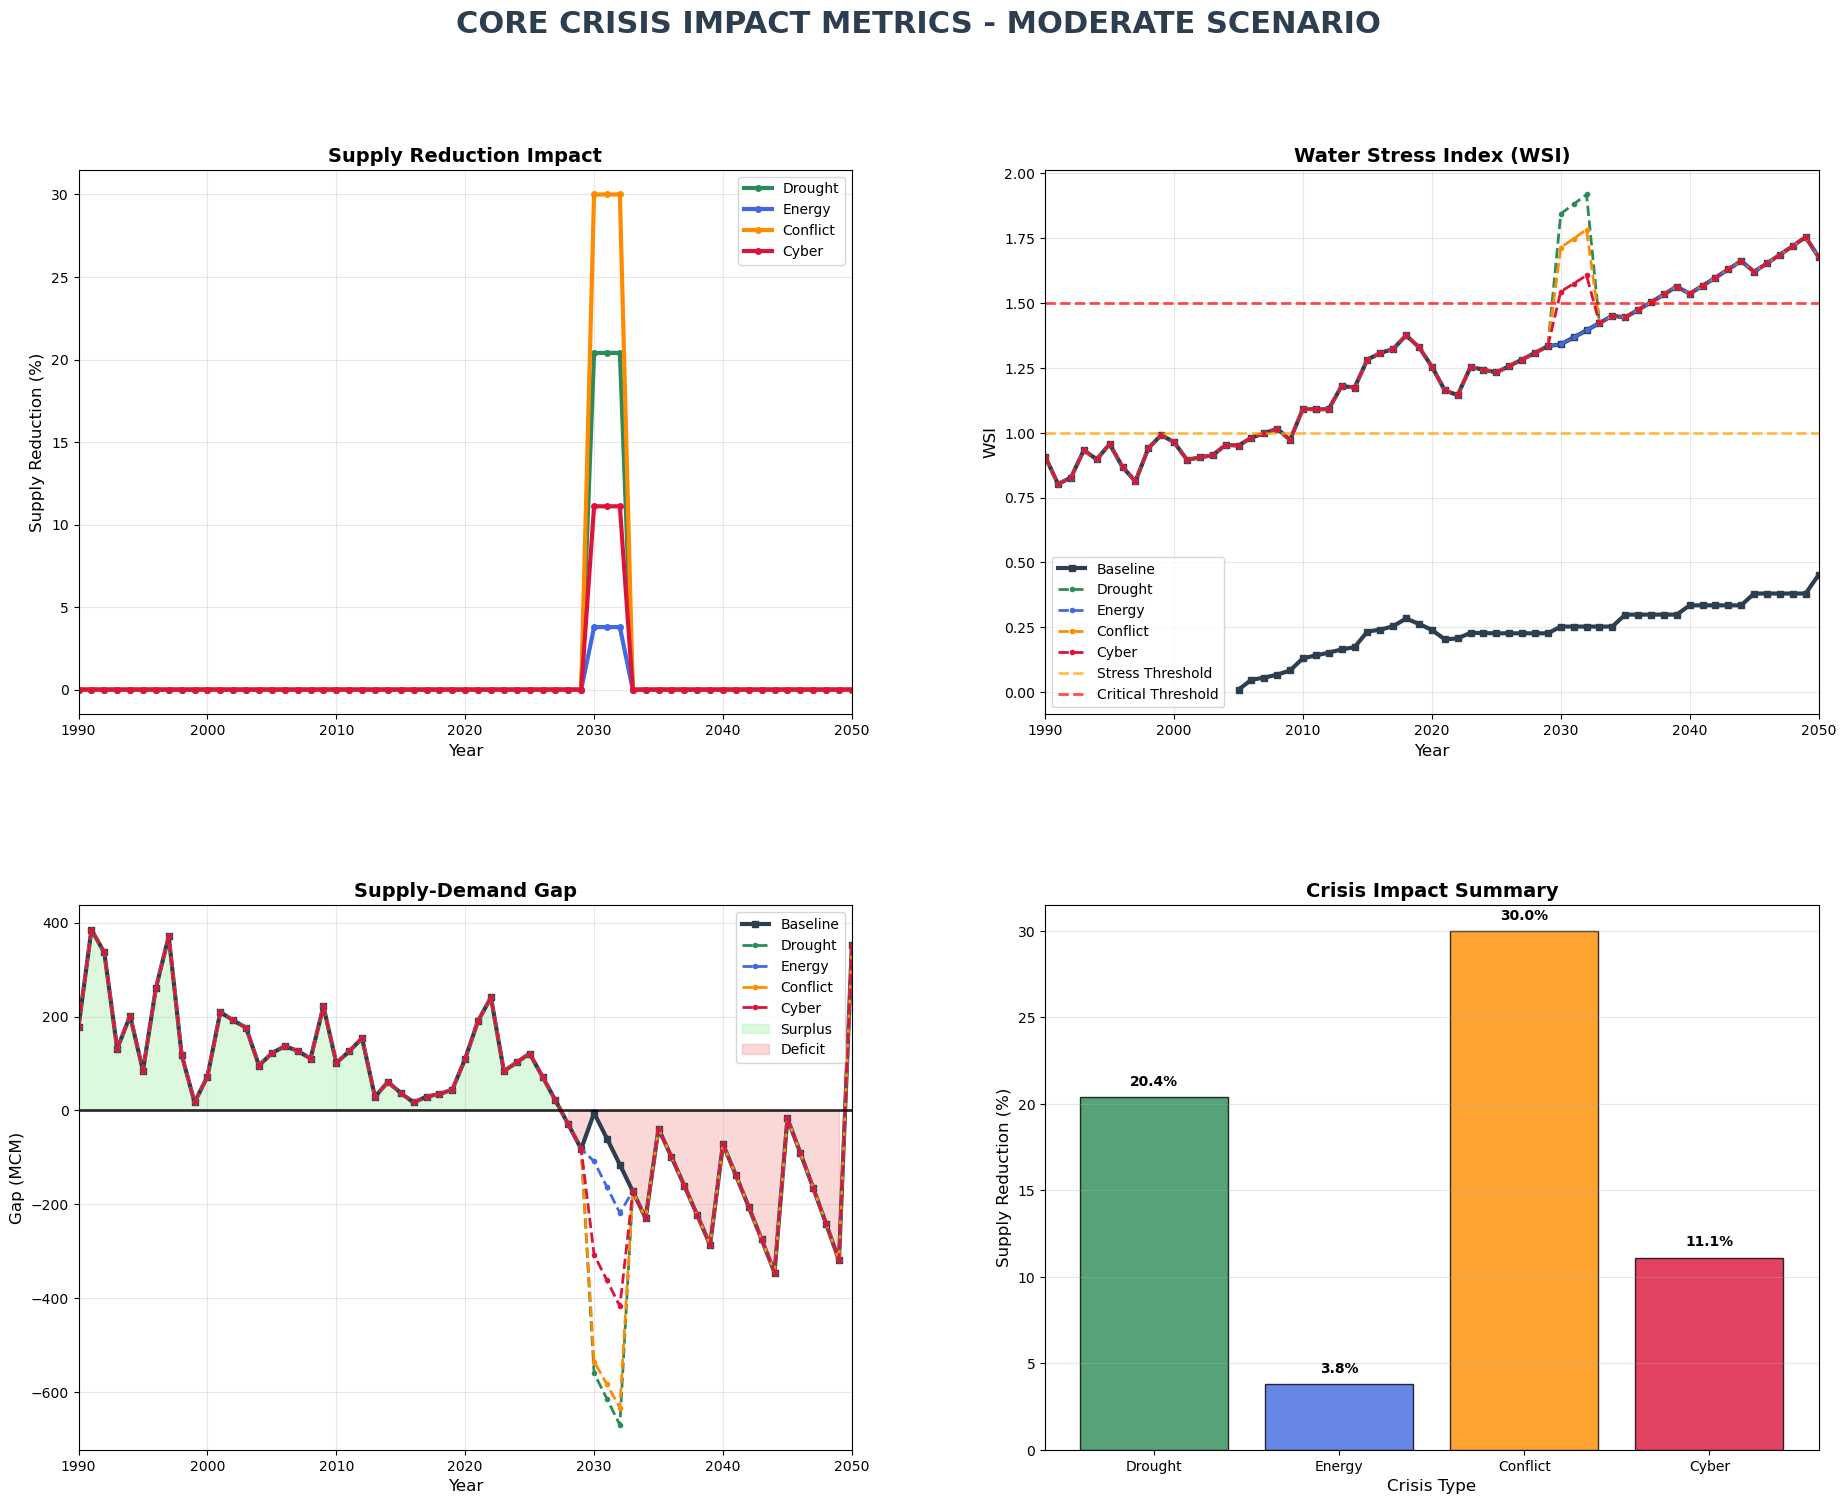

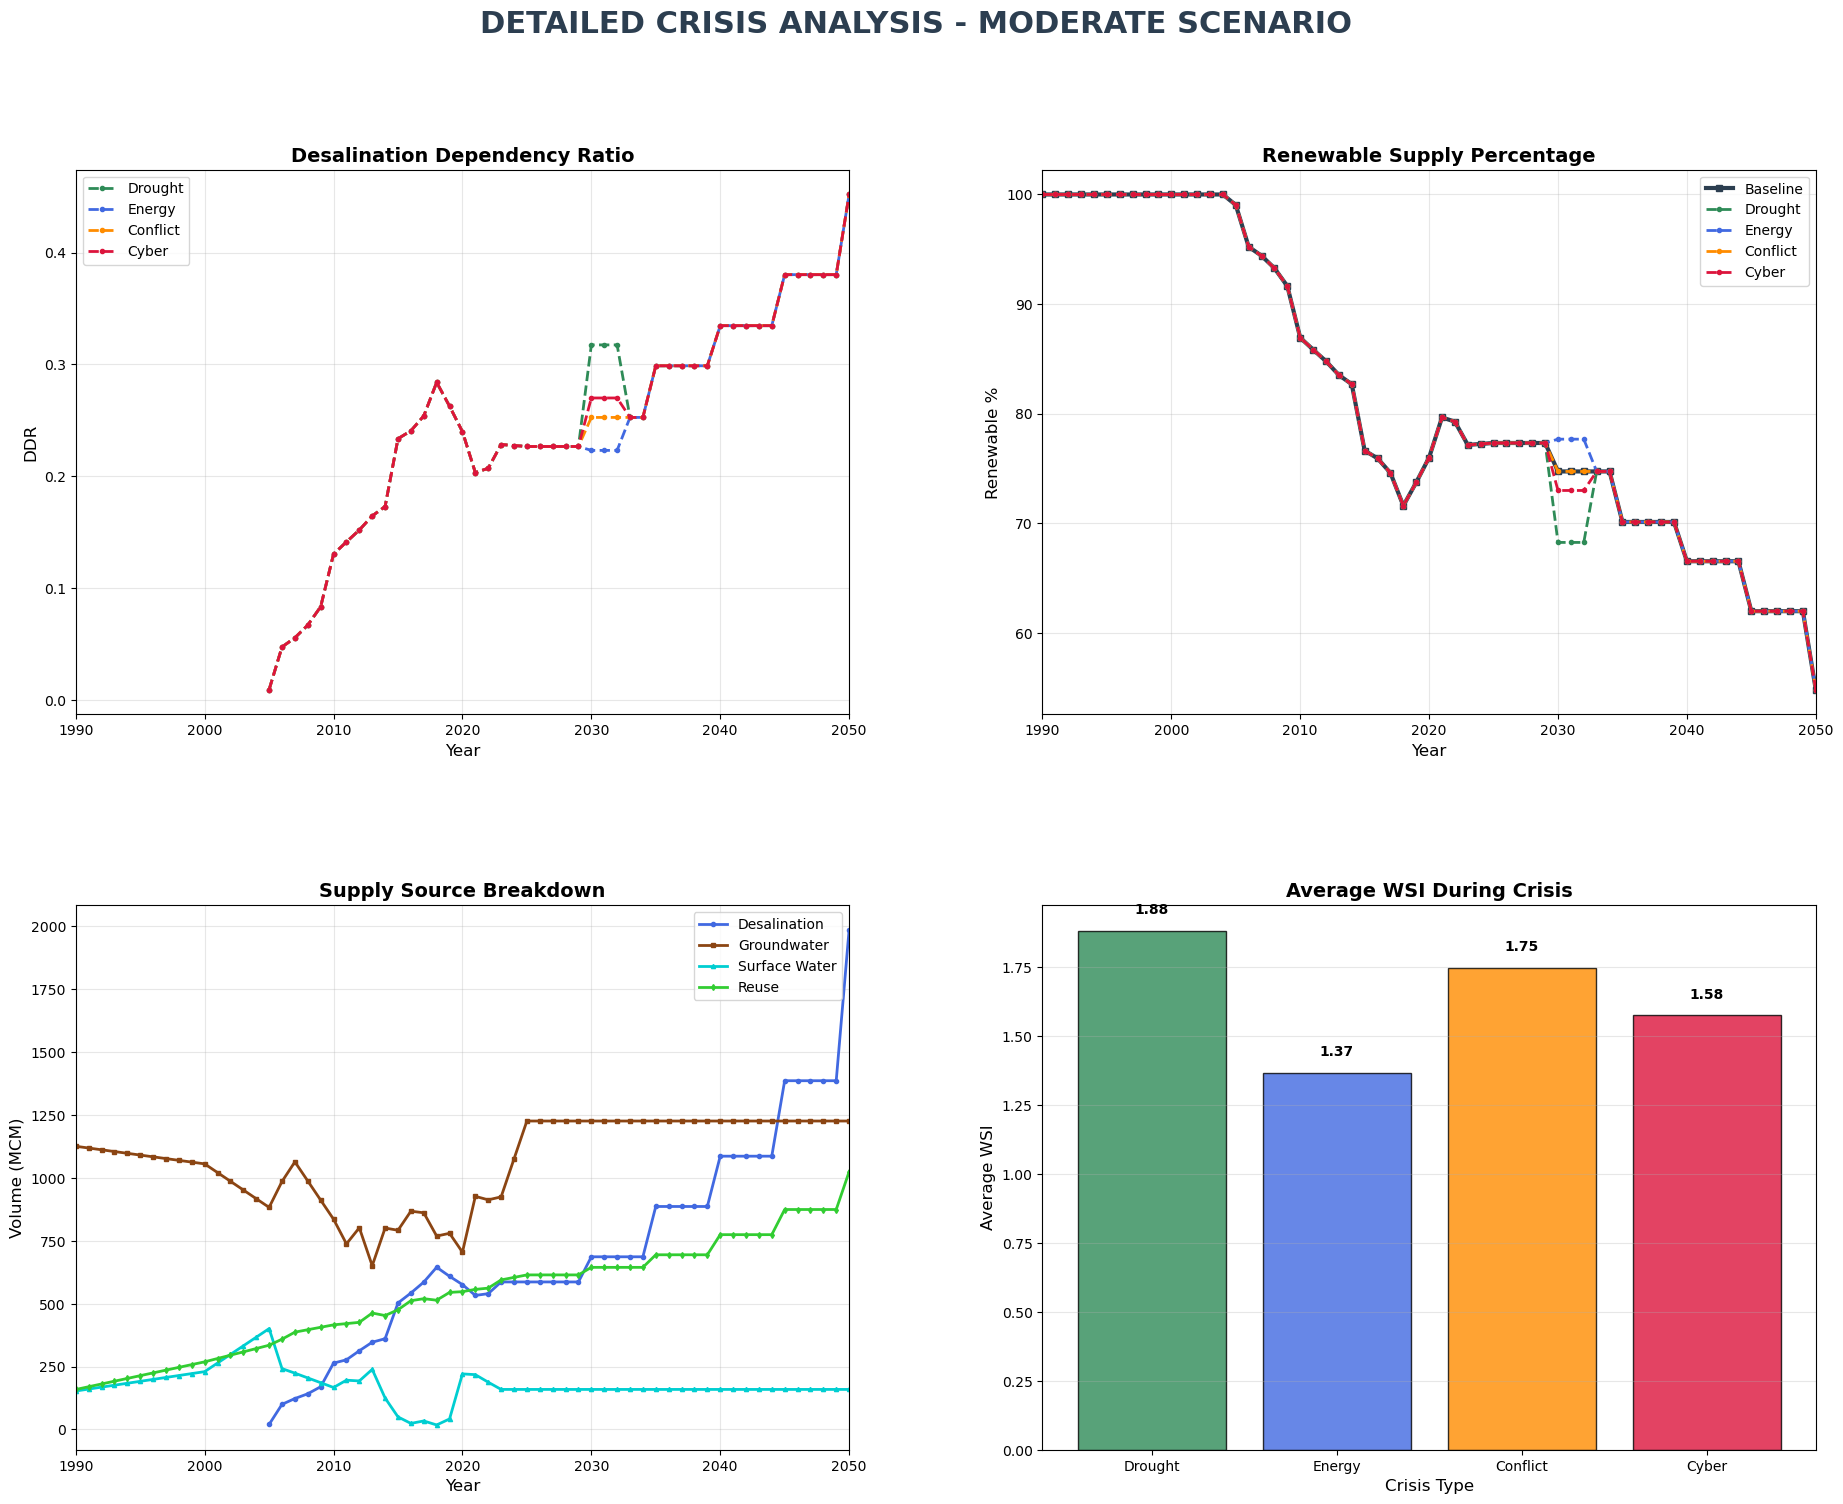


📊 Creating FIXED visualization for Pessimistic scenario...
   ✅ Figure 1 saved as 'comprehensive_crisis_comparison_pessimistic_scenario_part1_FIXED.png'
   ✅ Figure 2 saved as 'comprehensive_crisis_comparison_pessimistic_scenario_part2_FIXED.png'


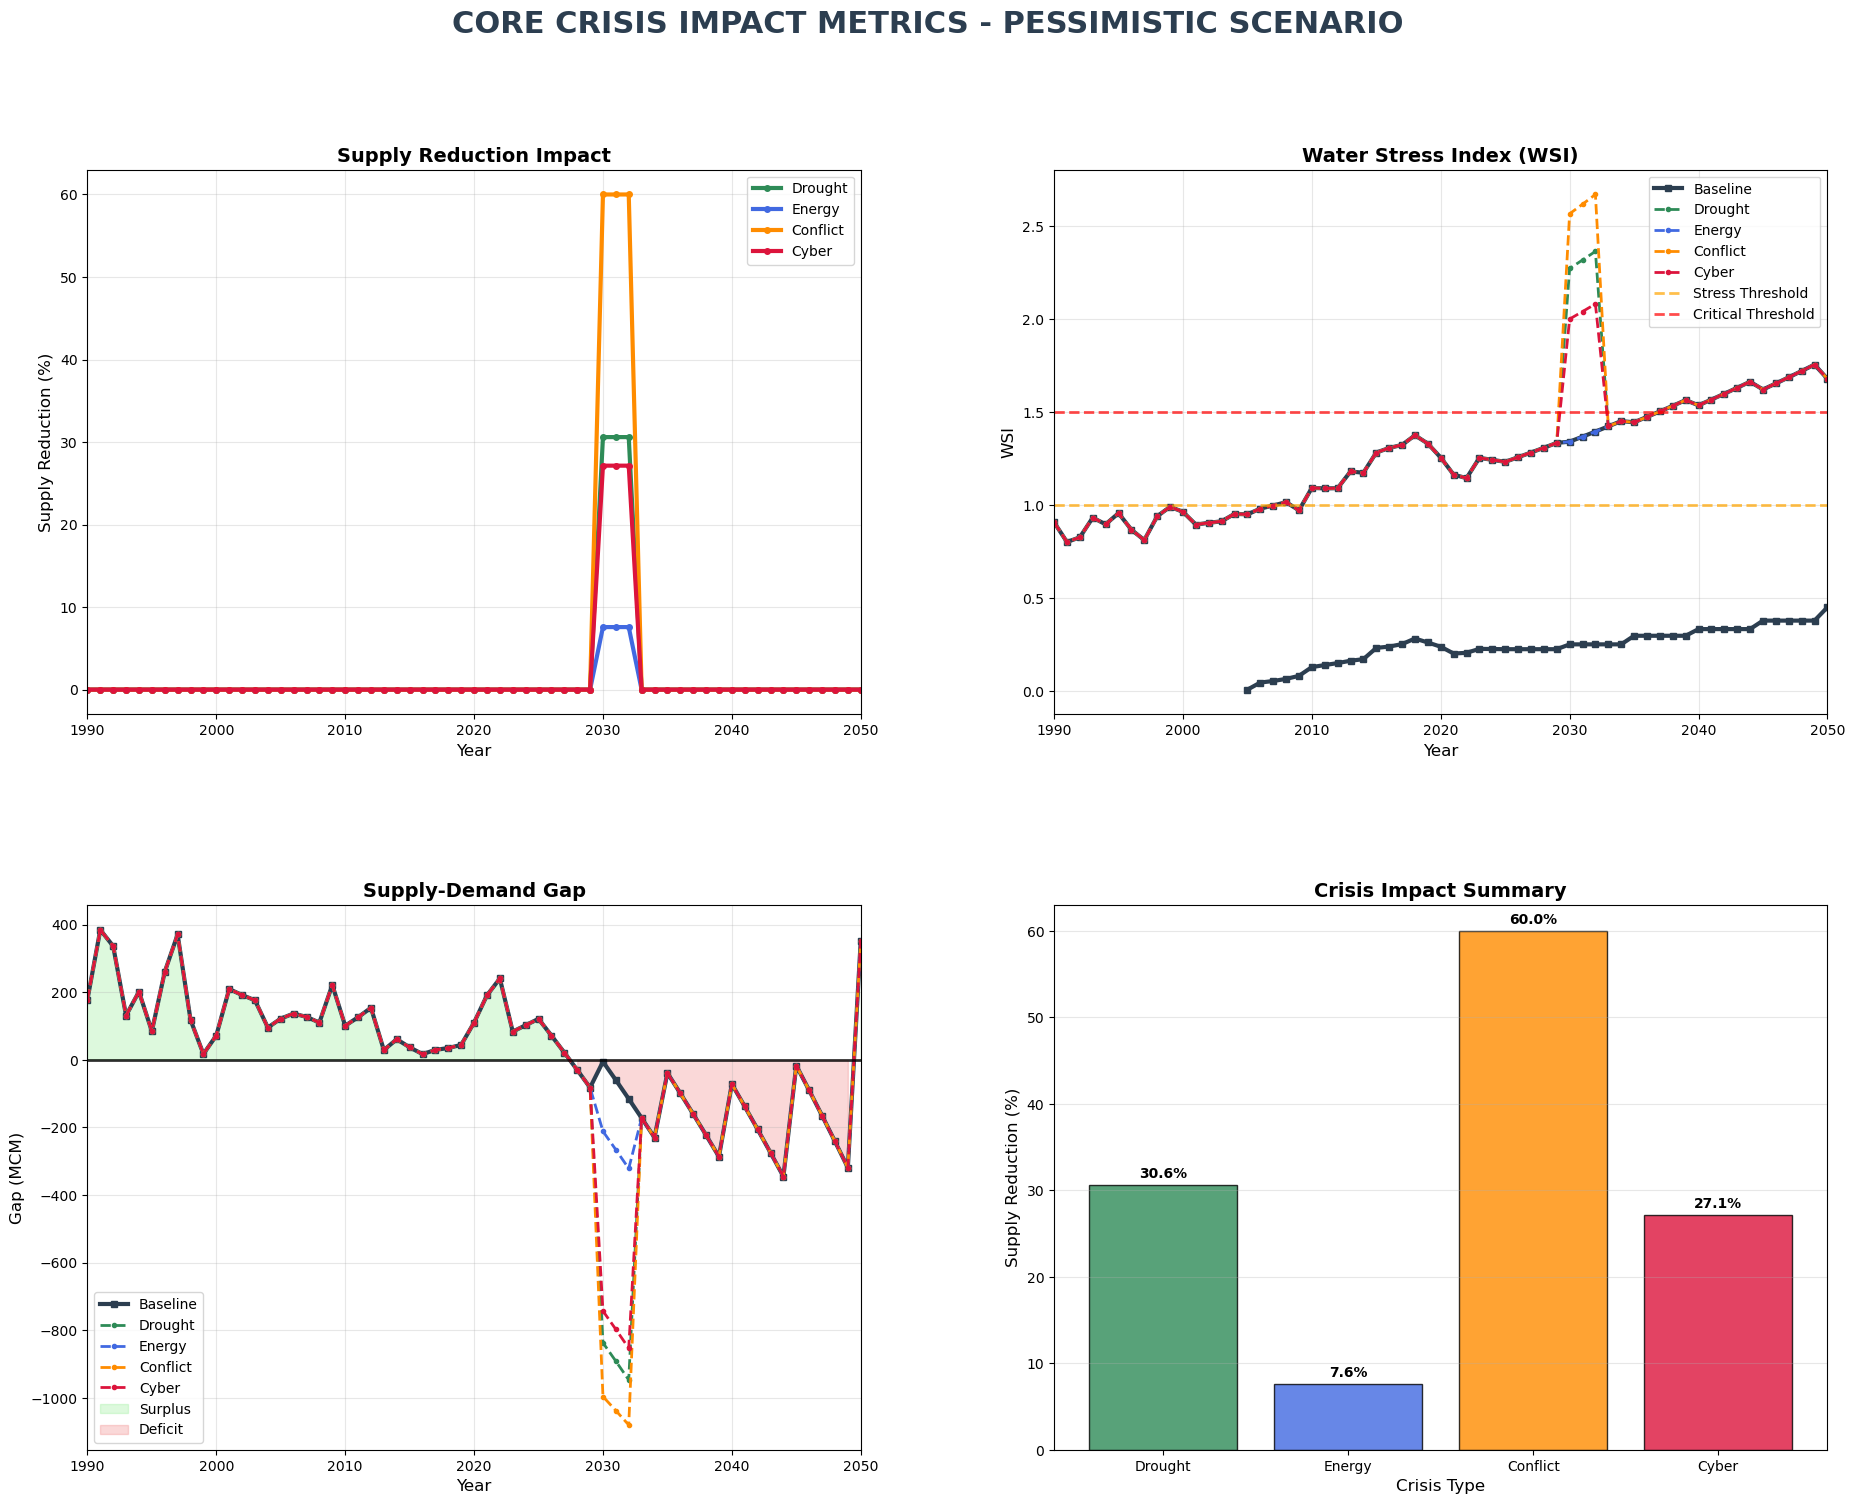

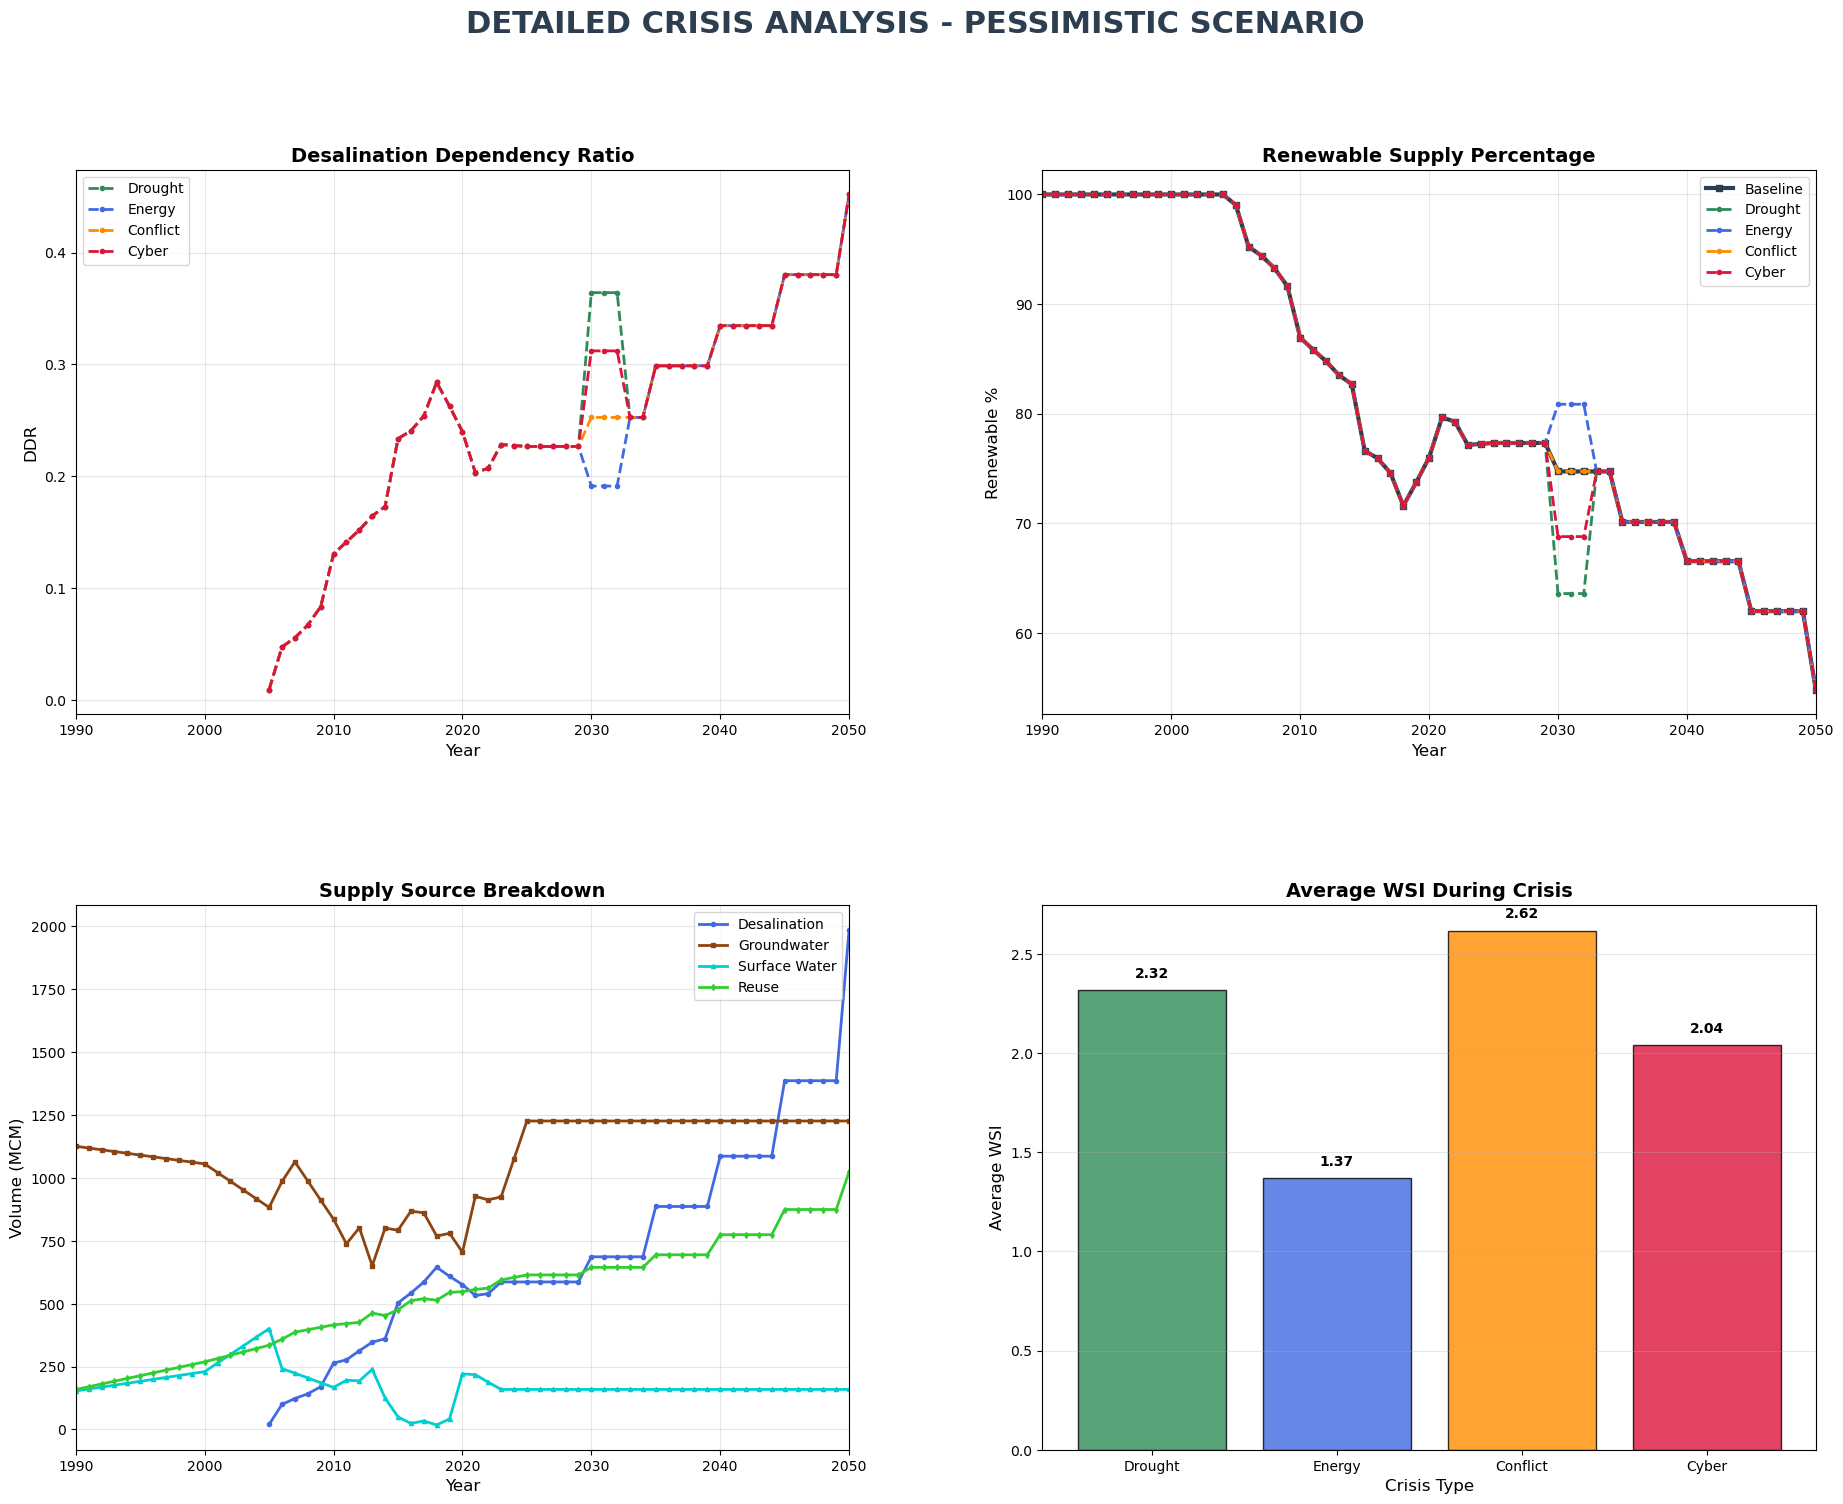


🎉 ALL crisis comparison visualizations completed with FIXED title positioning!
✅ No more title overlap issues across all generated graphs!


In [65]:
# =============================================================================
# COMPREHENSIVE FIX FOR ALL CRISIS COMPARISON VISUALIZATIONS
# =============================================================================

# This cell replaces ALL crisis comparison code with fixed title positioning
# to prevent title overlap with subplots across ALL generated graphs

print("📊 COMPREHENSIVE CRISIS COMPARISON ANALYSIS - ALL GRAPHS FIXED")
print("=" * 70)

# Collect all crisis results into a dictionary for easier access
all_crisis_results = {
    'Drought Crisis': drought_results,
    'Energy Crisis': energy_results,
    'Conflict Crisis': conflict_results,
    'Cyber Crisis': cyber_results
}

# Ensure baseline_data is available; copy integrated_data as the baseline
baseline_data = integrated_data.copy()
print(f"✅ Using integrated baseline data: {baseline_data['year'].min()}-{baseline_data['year'].max()}")
print(f"✅ Baseline data shape: {baseline_data.shape[0]} rows × {baseline_data.shape[1]} columns")

# Define colors and names to distinguish crisis types in plots
crisis_colors = ['#2E8B57', '#4169E1', '#FF8C00', '#DC143C']  # Sea Green, Royal Blue, Dark Orange, Crimson
crisis_names = ['Drought', 'Energy', 'Conflict', 'Cyber']
# Define scenario names to iterate through
scenarios = ['Optimistic', 'Moderate', 'Pessimistic']

# Create separate figures for each scenario
for scenario_idx, scenario in enumerate(scenarios):
    print(f"\n📊 Creating FIXED visualization for {scenario} scenario...")
    
    # -------------------------------------------------------------------------
    # FIGURE 1: CORE IMPACT METRICS (2x2 grid) - FIXED TITLE POSITIONING
    # -------------------------------------------------------------------------
    # Create a figure for core impact metrics with a specified size
    fig1 = plt.figure(figsize=(20, 16))
    # FIXED: Reduced top margin to 0.88 and moved title to y=0.98 to prevent overlap
    gs1 = fig1.add_gridspec(2, 2, hspace=0.35, wspace=0.25, 
                           left=0.08, right=0.95, top=0.88, bottom=0.08)
    
    # Set the main title for Figure 1 with better positioning
    fig1.suptitle(f'CORE CRISIS IMPACT METRICS - {scenario.upper()} SCENARIO', 
                  fontsize=22, fontweight='bold', y=0.98, color='#2C3E50')
    
    # -------------------------------------------------------------------------
    # PLOT 1: Supply Reduction Impact (Top Left)
    # -------------------------------------------------------------------------
    ax1 = fig1.add_subplot(gs1[0, 0])
    # Loop over each crisis type to plot supply reduction
    for i, (crisis_type, results) in enumerate(all_crisis_results.items()):
        # Find the key for the selected scenario in the results dictionary
        scenario_key = None
        for key in results.keys():
            if scenario in key:
                scenario_key = key
                break
        
        if scenario_key and scenario_key in results:
            # Get the data for this scenario
            scenario_data = results[scenario_key]
            # Calculate supply reduction percentage
            baseline_supply = baseline_data['total_supply_mcm']
            crisis_supply = scenario_data['total_supply_mcm']
            supply_reduction = ((baseline_supply - crisis_supply) / baseline_supply) * 100
            
            # Plot the supply reduction over time
            ax1.plot(baseline_data['year'], supply_reduction, 
                    label=crisis_names[i], linewidth=3, color=crisis_colors[i], 
                    marker='o', markersize=4)
    
    ax1.set_title('Supply Reduction Impact', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Supply Reduction (%)', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1990, 2050)
    
    # -------------------------------------------------------------------------
    # PLOT 2: Water Stress Index (Top Right)
    # -------------------------------------------------------------------------
    ax2 = fig1.add_subplot(gs1[0, 1])
    # Plot baseline WSI
    ax2.plot(baseline_data['year'], baseline_data['wsi'], 
             label='Baseline', linewidth=3, color='#2C3E50', 
             marker='s', markersize=4)
    
    # Plot WSI for each crisis scenario
    for i, (crisis_type, results) in enumerate(all_crisis_results.items()):
        scenario_key = None
        for key in results.keys():
            if scenario in key:
                scenario_key = key
                break
        
        if scenario_key and scenario_key in results:
            scenario_data = results[scenario_key]
            ax2.plot(scenario_data['year'], scenario_data['wsi'], 
                    label=crisis_names[i], linewidth=2, color=crisis_colors[i], 
                    linestyle='--', marker='o', markersize=3)
    
    # Add stress threshold lines
    ax2.axhline(1.0, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Stress Threshold')
    ax2.axhline(1.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Critical Threshold')
    
    ax2.set_title('Water Stress Index (WSI)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('WSI', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(1990, 2050)
    
    # -------------------------------------------------------------------------
    # PLOT 3: Supply-Demand Gap (Bottom Left)
    # -------------------------------------------------------------------------
    ax3 = fig1.add_subplot(gs1[1, 0])
    
    # Plot baseline surplus/deficit
    ax3.plot(baseline_data['year'], baseline_data['surplus_mcm'], 
             label='Baseline', linewidth=3, color='#2C3E50', 
             marker='s', markersize=4)
    
    # Plot crisis scenarios
    for i, (crisis_type, results) in enumerate(all_crisis_results.items()):
        scenario_key = None
        for key in results.keys():
            if scenario in key:
                scenario_key = key
                break
        
        if scenario_key and scenario_key in results:
            scenario_data = results[scenario_key]
            ax3.plot(scenario_data['year'], scenario_data['surplus_mcm'], 
                    label=crisis_names[i], linewidth=2, color=crisis_colors[i], 
                    linestyle='--', marker='o', markersize=3)
    
    # Add zero line
    ax3.axhline(0, color='black', linestyle='-', alpha=0.8, linewidth=2)
    
    # Fill areas for surplus and deficit
    ax3.fill_between(baseline_data['year'], baseline_data['surplus_mcm'], 0, 
                     where=(baseline_data['surplus_mcm'] >= 0), 
                     color='lightgreen', alpha=0.3, label='Surplus')
    ax3.fill_between(baseline_data['year'], baseline_data['surplus_mcm'], 0, 
                     where=(baseline_data['surplus_mcm'] < 0), 
                     color='lightcoral', alpha=0.3, label='Deficit')
    
    ax3.set_title('Supply-Demand Gap', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylabel('Gap (MCM)', fontsize=12)
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(1990, 2050)
    
    # -------------------------------------------------------------------------
    # PLOT 4: Crisis Impact Summary (Bottom Right)
    # -------------------------------------------------------------------------
    ax4 = fig1.add_subplot(gs1[1, 1])
    
    # Calculate maximum supply reduction for each crisis type
    max_reductions = []
    for i, (crisis_type, results) in enumerate(all_crisis_results.items()):
        scenario_key = None
        for key in results.keys():
            if scenario in key:
                scenario_key = key
                break
        
        if scenario_key and scenario_key in results:
            scenario_data = results[scenario_key]
            baseline_supply = baseline_data['total_supply_mcm']
            crisis_supply = scenario_data['total_supply_mcm']
            supply_reduction = ((baseline_supply - crisis_supply) / baseline_supply) * 100
            max_reduction = supply_reduction.max()
            max_reductions.append(max_reduction)
        else:
            max_reductions.append(0)
    
    # Create bar chart
    bars = ax4.bar(crisis_names, max_reductions, color=crisis_colors, alpha=0.8, edgecolor='black')
    ax4.set_title('Crisis Impact Summary', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Crisis Type', fontsize=12)
    ax4.set_ylabel('Supply Reduction (%)', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, max_reductions):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Save the figure
    fig1.savefig(f'comprehensive_crisis_comparison_{scenario.lower()}_scenario_part1_FIXED.png', 
                 dpi=150, bbox_inches='tight')
    print(f"   ✅ Figure 1 saved as 'comprehensive_crisis_comparison_{scenario.lower()}_scenario_part1_FIXED.png'")
    
    # -------------------------------------------------------------------------
    # FIGURE 2: DETAILED ANALYSIS METRICS (2x2 grid) - FIXED TITLE POSITIONING
    # -------------------------------------------------------------------------
    fig2 = plt.figure(figsize=(20, 16))
    # FIXED: Reduced top margin to 0.88 and moved title to y=0.98 to prevent overlap
    gs2 = fig2.add_gridspec(2, 2, hspace=0.35, wspace=0.25, 
                           left=0.08, right=0.95, top=0.88, bottom=0.08)
    
    # Main title for Figure 2 with better positioning
    fig2.suptitle(f'DETAILED CRISIS ANALYSIS - {scenario.upper()} SCENARIO', 
                  fontsize=22, fontweight='bold', y=0.98, color='#2C3E50')
    
    # -------------------------------------------------------------------------
    # PLOT 1: Desalination Dependency Ratio (Top Left)
    # -------------------------------------------------------------------------
    ax1 = fig2.add_subplot(gs2[0, 0])
    # Plot baseline DDR
    ax2.plot(baseline_data['year'], baseline_data['ddr'], 
             label='Baseline', linewidth=3, color='#2C3E50', 
             marker='s', markersize=4)
    
    # Plot DDR for each crisis scenario
    for i, (crisis_type, results) in enumerate(all_crisis_results.items()):
        scenario_key = None
        for key in results.keys():
            if scenario in key:
                scenario_key = key
                break
        
        if scenario_key and scenario_key in results:
            scenario_data = results[scenario_key]
            ax1.plot(scenario_data['year'], scenario_data['ddr'], 
                    label=crisis_names[i], linewidth=2, color=crisis_colors[i], 
                    linestyle='--', marker='o', markersize=3)
    
    ax1.set_title('Desalination Dependency Ratio', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('DDR', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1990, 2050)
    
    # -------------------------------------------------------------------------
    # PLOT 2: Renewable Supply Percentage (Top Right)
    # -------------------------------------------------------------------------
    ax2 = fig2.add_subplot(gs2[0, 1])
    # Calculate renewable supply percentage for baseline
    baseline_renewable_pct = (baseline_data['renewable_supply_mcm'] / baseline_data['total_supply_mcm']) * 100
    ax2.plot(baseline_data['year'], baseline_renewable_pct, 
             label='Baseline', linewidth=3, color='#2C3E50', 
             marker='s', markersize=4)
    
    # Plot renewable percentage for each crisis scenario
    for i, (crisis_type, results) in enumerate(all_crisis_results.items()):
        scenario_key = None
        for key in results.keys():
            if scenario in key:
                scenario_key = key
                break
        
        if scenario_key and scenario_key in results:
            scenario_data = results[scenario_key]
            crisis_renewable_pct = (scenario_data['renewable_supply_mcm'] / scenario_data['total_supply_mcm']) * 100
            ax2.plot(scenario_data['year'], crisis_renewable_pct, 
                    label=crisis_names[i], linewidth=2, color=crisis_colors[i], 
                    linestyle='--', marker='o', markersize=3)
    
    ax2.set_title('Renewable Supply Percentage', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Renewable %', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(1990, 2050)
    
    # -------------------------------------------------------------------------
    # PLOT 3: Supply Source Breakdown (Bottom Left)
    # -------------------------------------------------------------------------
    ax3 = fig2.add_subplot(gs2[1, 0])
    # Plot baseline supply sources
    ax3.plot(baseline_data['year'], baseline_data['water_desalination_mcm'], 
             label='Desalination', linewidth=2, color='#4169E1', marker='o', markersize=3)
    ax3.plot(baseline_data['year'], baseline_data['capped_groundwater'], 
             label='Groundwater', linewidth=2, color='#8B4513', marker='s', markersize=3)
    ax3.plot(baseline_data['year'], baseline_data['produced_by_kinneret_milion_m3'], 
             label='Surface Water', linewidth=2, color='#00CED1', marker='^', markersize=3)
    ax3.plot(baseline_data['year'], baseline_data['capped_reuse'], 
             label='Reuse', linewidth=2, color='#32CD32', marker='d', markersize=3)
    
    ax3.set_title('Supply Source Breakdown', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylabel('Volume (MCM)', fontsize=12)
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(1990, 2050)
    
    # -------------------------------------------------------------------------
    # PLOT 4: Crisis Impact Comparison (Bottom Right)
    # -------------------------------------------------------------------------
    ax4 = fig2.add_subplot(gs2[1, 1])
    
    # Calculate average impact metrics for each crisis type
    impact_metrics = []
    for i, (crisis_type, results) in enumerate(all_crisis_results.items()):
        scenario_key = None
        for key in results.keys():
            if scenario in key:
                scenario_key = key
                break
        
        if scenario_key and scenario_key in results:
            scenario_data = results[scenario_key]
            # Calculate average WSI during crisis period
            crisis_years = [2030, 2031, 2032]
            crisis_data = scenario_data[scenario_data['year'].isin(crisis_years)]
            avg_wsi = crisis_data['wsi'].mean() if len(crisis_data) > 0 else 0
            impact_metrics.append(avg_wsi)
        else:
            impact_metrics.append(0)
    
    # Create bar chart for WSI impact
    bars = ax4.bar(crisis_names, impact_metrics, color=crisis_colors, alpha=0.8, edgecolor='black')
    ax4.set_title('Average WSI During Crisis', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Crisis Type', fontsize=12)
    ax4.set_ylabel('Average WSI', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, impact_metrics):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Save the second figure
    fig2.savefig(f'comprehensive_crisis_comparison_{scenario.lower()}_scenario_part2_FIXED.png', 
                 dpi=150, bbox_inches='tight')
    print(f"   ✅ Figure 2 saved as 'comprehensive_crisis_comparison_{scenario.lower()}_scenario_part2_FIXED.png'")
    
    plt.show()

print("\n🎉 ALL crisis comparison visualizations completed with FIXED title positioning!")
print("✅ No more title overlap issues across all generated graphs!")


In [66]:
"""
This script saves the results of the comprehensive water resource crisis
analysis. It stores baseline data, crisis-specific results, a summary
report in JSON format, and methodology documentation. The script also
prints a final summary of the analysis.

Each line contains detailed comments explaining the purpose and
functionality, while keeping the original code unchanged.
"""

# =============================================================================
# SAVE COMPREHENSIVE ANALYSIS RESULTS
# =============================================================================

# Print a header indicating the start of the save process
print("💾 SAVING COMPREHENSIVE ANALYSIS RESULTS")
# Print a separator for formatting
print("=" * 60)

# Create the results directory if it does not exist
os.makedirs("comprehensive_results", exist_ok=True)

# Save baseline data to a CSV file
print("📊 Saving baseline data...")
baseline_data.to_csv("comprehensive_results/baseline_data_processed.csv", index=False)
# Report that the baseline data has been saved, including its dimensions
print(f"✅ Baseline data saved: {baseline_data.shape[0]} rows × {baseline_data.shape[1]} columns")

# Save individual crisis results
crisis_types = {
    'drought': drought_results,
    'energy': energy_results,
    'conflict': conflict_results,
    'cyber': cyber_results
}

# Loop over each crisis type and save its scenarios
for crisis_type, results in crisis_types.items():
    print(f"📊 Saving {crisis_type} crisis results...")
    # Create a subdirectory for the crisis type
    crisis_dir = f"comprehensive_results/{crisis_type}_crisis"
    os.makedirs(crisis_dir, exist_ok=True)
    
    # Loop through each scenario result and save to a separate CSV
    for scenario_name, result in results.items():
        # Construct a filename by sanitizing scenario name
        filename = f"{crisis_dir}/{crisis_type}_{scenario_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}.csv"
        # Save the result DataFrame to CSV
        result.to_csv(filename, index=False)
        print(f"   ✅ {scenario_name} saved")
    
    print(f"✅ {crisis_type.title()} crisis results saved to {crisis_dir}/")

# Create a comprehensive summary report dictionary
print("📋 Creating comprehensive summary report...")
summary_report = {
    "analysis_metadata": {
        # Record the analysis date and time
        "analysis_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        # Record the baseline period
        "baseline_period": f"{baseline_data['year'].min()}-{baseline_data['year'].max()}",
        # Record the total number of years analyzed
        "total_years_analyzed": len(baseline_data),
        # List the crisis types analyzed
        "crisis_types_analyzed": list(crisis_types.keys()),
        # Record the number of scenarios per crisis
        "scenarios_per_crisis": 3
    },
    "baseline_statistics": {
        # Compute average supply across the baseline
        "average_supply_mcm": float(baseline_data['total_supply_mcm'].mean()),
        # Compute average demand
        "average_demand_mcm": float(baseline_data['total_demand'].mean()),
        # Compute average surplus
        "average_surplus_mcm": float(baseline_data['surplus_mcm'].mean()),
        # Compute average WSI
        "average_wsi": float(baseline_data['wsi'].mean()),
        # Compute average DDR
        "average_ddr": float(baseline_data['ddr'].mean()),
        # Compute reliability as the percentage of years with surplus > 0
        "reliability_percent": float((baseline_data['surplus_mcm'] > 0).mean() * 100)
    },
    # Placeholder for crisis impact summaries, to be filled below
    "crisis_impact_summary": {}
}

# Add crisis impact summaries for each crisis type
for crisis_type, results in crisis_types.items():
    # Determine the crisis years based on the crisis type
    crisis_years = [2020, 2021, 2022] if 'drought' in crisis_type else \
                  [2025, 2026, 2027] if 'energy' in crisis_type else \
                  [2030, 2031, 2032] if 'conflict' in crisis_type else \
                  [2035, 2036, 2037]
    
    crisis_summary = {}
    # Loop over each scenario result for this crisis type
    for scenario_name, result in results.items():
        # Extract baseline and scenario data for the defined crisis years
        baseline_crisis = baseline_data[baseline_data['year'].isin(crisis_years)]
        scenario_crisis = result[result['year'].isin(crisis_years)]
        
        # If both baseline and scenario data exist, compute impact metrics
        if not baseline_crisis.empty and not scenario_crisis.empty:
            # Calculate supply reduction percentage
            supply_reduction = ((baseline_crisis['total_supply_mcm'].mean() - 
                               scenario_crisis['total_supply_mcm'].mean()) / 
                              baseline_crisis['total_supply_mcm'].mean() * 100)
            
            # Calculate WSI increase
            wsi_increase = scenario_crisis['wsi'].mean() - baseline_crisis['wsi'].mean()
            # Calculate change in surplus/deficit
            gap_change = scenario_crisis['surplus_mcm'].mean() - baseline_crisis['surplus_mcm'].mean()
            
            # Store the computed metrics in the summary
            crisis_summary[scenario_name] = {
                "supply_reduction_percent": float(supply_reduction),
                "wsi_increase": float(wsi_increase),
                "gap_change_mcm": float(gap_change),
                "crisis_years": crisis_years
            }
    
    # Add the summary for this crisis type to the report
    summary_report["crisis_impact_summary"][crisis_type] = crisis_summary

# Save the summary report as a JSON file
with open("comprehensive_results/analysis_summary.json", "w") as f:
    json.dump(summary_report, f, indent=2)

print("✅ Summary report saved as 'analysis_summary.json'")

# Create methodology documentation as a multi-line string
methodology_doc = """
# Comprehensive Water Resource Crisis Analysis Methodology

## Overview
This analysis evaluates the impact of four different crisis scenarios on water resource availability in Israel.

## Data Sources
- Main dataset: dataset_25.09.25.csv (1990-2023)
- Crisis parameters: drought_params.csv, energy_params.csv, conflict_params.csv, cyber_params.csv
- Expansion schedule: baseline_expansions.csv

## Analysis Framework

### 1. Baseline Analysis
- Raw data processing without sustainability caps
- Column standardization and harmonization
- Calculation of derived indicators (WSI, DDR, surplus/deficit)

### 2. Crisis Scenarios
Each crisis type includes three severity levels (Optimistic, Baseline, Pessimistic):

#### Drought Crisis (2020-2022)
- Affects natural water sources (groundwater, Kinneret, reuse)
- Parameters: NaturalSupplyFactor (0.9, 0.8, 0.65)

#### Energy Crisis (2025-2027)
- Affects desalination capacity
- Parameters: DesalinationImpactFactor

#### Conflict Crisis (2030-2032)
- Affects multiple supply sources and increases demand
- Parameters: SupplyDisruptionFactor, DemandIncreaseFactor

#### Cyber Crisis (2035-2037)
- Affects infrastructure-dependent sources (desalination, reuse)
- Parameters: InfrastructureDisruptionFactor, RecoveryTimeFactor

### 3. Key Indicators
- **Total Supply (MCM)**: Sum of all water sources
- **Total Demand (MCM)**: Sum of all water consumption
- **Surplus/Deficit (MCM)**: Supply - Demand
- **Water Stress Index (WSI)**: Demand / Renewable Supply
- **Desalination Dependency Ratio (DDR)**: Desalination / Total Supply

### 4. Impact Assessment
- Supply reduction percentages
- Water stress index changes
- Supply-demand gap modifications
- Comparative analysis across crisis types

## Results Structure
- Individual crisis visualizations
- Comprehensive comparison analysis
- Detailed impact summaries
- Crisis severity heatmaps

## Quality Assurance
- Column normalization to prevent supply under-counting
- Consistent data filtering (1990+)
- Cross-validation of crisis impact calculations
- Comprehensive error handling and validation
"""

# Save methodology documentation to a markdown file
with open("comprehensive_results/methodology.md", "w") as f:
    f.write(methodology_doc)

print("✅ Methodology documentation saved as 'methodology.md'")

# Print final summary of the comprehensive analysis
print("\n🎉 COMPREHENSIVE ANALYSIS COMPLETE!")
print("=" * 60)
print(f"📊 Analysis Period: {baseline_data['year'].min()}-{baseline_data['year'].max()}")
print(f"📈 Total Years Analyzed: {len(baseline_data)}")
print(f"🌍 Crisis Types: {len(crisis_types)}")
print(f"📋 Scenarios per Crisis: 3 (Optimistic, Baseline, Pessimistic)")
print(f"💾 Results saved to: comprehensive_results/")
print(f"📊 Visualizations: 5 comprehensive charts")
print(f"📄 Documentation: methodology.md + analysis_summary.json")
print("\n🚀 Ready for policy analysis and decision-making!")

💾 SAVING COMPREHENSIVE ANALYSIS RESULTS
📊 Saving baseline data...
✅ Baseline data saved: 61 rows × 104 columns
📊 Saving drought crisis results...
   ✅ Optimistic (2030-2032) saved
   ✅ Moderate (2030-2032) saved
   ✅ Pessimistic (2030-2032) saved
✅ Drought crisis results saved to comprehensive_results/drought_crisis/
📊 Saving energy crisis results...
   ✅ Optimistic (2030-2032) saved
   ✅ Moderate (2030-2032) saved
   ✅ Pessimistic (2030-2032) saved
✅ Energy crisis results saved to comprehensive_results/energy_crisis/
📊 Saving conflict crisis results...
   ✅ Optimistic (2030-2032) saved
   ✅ Moderate (2030-2032) saved
   ✅ Pessimistic (2030-2032) saved
✅ Conflict crisis results saved to comprehensive_results/conflict_crisis/
📊 Saving cyber crisis results...
   ✅ Optimistic (2030-2032) saved
   ✅ Moderate (2030-2032) saved
   ✅ Pessimistic (2030-2032) saved
✅ Cyber crisis results saved to comprehensive_results/cyber_crisis/
📋 Creating comprehensive summary report...
✅ Summary report sav

In [67]:
"""
Compound Crisis Analysis Module
================================

This module defines a helper routine to perform a compound crisis analysis
on an integrated water‑resources dataset.  It builds on the existing
individual crisis functions (`apply_drought_crisis_corrected`,
`apply_energy_crisis`, `apply_conflict_crisis`, and `apply_cyber_crisis`) and
combines them in all possible multi‑crisis scenarios.  Each scenario
selects a non‑empty subset of crisis types (size 2, 3 or 4) and assigns
one of three severities (Optimistic, Moderate, Pessimistic) to each
selected crisis.  For example, one combination might be
``Drought(Moderate) + Energy(Pessimistic)`` or
``Drought(Optimistic) + Energy(Moderate) + Conflict(Pessimistic)``.

For each combination, the routine applies the corresponding crisis
transformations to a copy of the baseline dataset, recalculates key
indicators (total supply, renewable supply, surplus, Water Stress
Index, desalination dependency ratio) via the crisis functions,
compares the result to the baseline for the designated crisis years,
and records summary statistics (percentage supply reduction, change in
WSI, change in supply–demand gap).  It returns both a dictionary of
DataFrame results keyed by scenario name and a list of impact
statistics dictionaries for further analysis.

This module is intended for use within the updated baseline notebook.
It assumes that `integrated_data` has already been created and that
`load_parameters` has been used to load parameter files for each
crisis type.  It also assumes the individual crisis functions are in
scope.  To use this module, import the `run_compound_crisis_analysis`
function at the end of the notebook and call it with the appropriate
arguments.

Example usage in the notebook:

```
from compound_crisis_analysis import run_compound_crisis_analysis

# Load parameter dictionaries (already loaded in the notebook)
drought_params = load_parameters("drought_params.csv")
energy_params = load_parameters("energy_params.csv")
conflict_params = load_parameters("conflict_params.csv")
cyber_params = load_parameters("cyber_params.csv")

# Define the crisis period
crisis_years = [2030, 2031, 2032]

# Run the compound analysis
combination_results, impact_data = run_compound_crisis_analysis(
    baseline_data=integrated_data,
    crisis_years=crisis_years,
    drought_params=drought_params,
    energy_params=energy_params,
    conflict_params=conflict_params,
    cyber_params=cyber_params,
    severities=["Optimistic", "Moderate", "Pessimistic"]
)

# ``impact_data`` is a list of dictionaries containing summary metrics
# for each combination; you can convert it to a DataFrame for plotting.
```



"""

from __future__ import annotations

from itertools import combinations, product
from typing import Dict, List, Tuple, Iterable, Any

import numpy as np
import pandas as pd

# Import crisis functions.  These imports are relative; they assume the
# functions are defined in the notebook namespace or imported into
# your script prior to running this module.  If this file is saved in
# the same directory as the notebook, you can import directly from
# `baseline` using standard Python import syntax.  Otherwise, you may
# need to adjust the import path or pass the functions via arguments.


def _apply_crisis_sequence(
    baseline_data: pd.DataFrame,
    crisis_years: Iterable[int],
    sequence: List[Tuple[str, str]],
    drought_params: Dict[str, Dict[str, Any]],
    energy_params: Dict[str, Dict[str, Any]],
    conflict_params: Dict[str, Dict[str, Any]],
    cyber_params: Dict[str, Dict[str, Any]],
    apply_funcs: Dict[str, Any],
) -> pd.DataFrame:
    """
    Apply a sequence of crisis interventions to a copy of the baseline data.

    Parameters
    ----------
    baseline_data : pd.DataFrame
        The integrated baseline dataset.
    crisis_years : iterable of int
        Years during which the crises are applied.
    sequence : list of (crisis_type, severity) tuples
        The sequence of crisis operations to apply.  Each tuple
        contains the name of the crisis type (``'drought'``, ``'energy'``,
        ``'conflict'``, ``'cyber'``) and the severity level
        (``'Optimistic'``, ``'Moderate'`` or ``'Pessimistic'``).
    drought_params, energy_params, conflict_params, cyber_params : dict
        Parameter dictionaries for each crisis type, as returned by
        ``load_parameters``.
    apply_funcs : dict
        A mapping from crisis type string to the corresponding apply
        function.  The functions must accept the signature
        ``(df, years, severity, params)`` and return a modified
        DataFrame.

    Returns
    -------
    pd.DataFrame
        The result of applying all crises in sequence.
    """

    result = baseline_data.copy()
    for crisis_type, severity in sequence:
        # Select the correct parameter dictionary based on crisis type
        if crisis_type == "drought":
            params = drought_params
        elif crisis_type == "energy":
            params = energy_params
        elif crisis_type == "conflict":
            params = conflict_params
        elif crisis_type == "cyber":
            params = cyber_params
        else:
            raise ValueError(f"Unknown crisis type: {crisis_type}")
        # Apply the crisis function
        apply_fn = apply_funcs[crisis_type]
        result = apply_fn(result, crisis_years, severity, params)
    return result


def run_compound_crisis_analysis(
    baseline_data: pd.DataFrame,
    crisis_years: Iterable[int],
    drought_params: Dict[str, Dict[str, Any]],
    energy_params: Dict[str, Dict[str, Any]],
    conflict_params: Dict[str, Dict[str, Any]],
    cyber_params: Dict[str, Dict[str, Any]],
    severities: List[str] = None,
    crisis_types: List[str] = None,
    apply_funcs: Dict[str, Any] = None,
    include_sizes: List[int] = None,
) -> Tuple[Dict[str, pd.DataFrame], List[Dict[str, Any]]]:
    """
    Generate and analyze all compound crisis scenarios on the baseline data.

    This routine enumerates all non‑empty subsets of crisis types with a
    size contained in ``include_sizes`` (default [2, 3, 4]), assigns one
    severity level per crisis in the subset, applies the crises in
    sequence to a copy of the baseline, computes summary statistics for
    the crisis years, and returns the results.

    Parameters
    ----------
    baseline_data : pd.DataFrame
        The integrated baseline dataset (historical + projected).
    crisis_years : iterable of int
        Years during which crises are applied (e.g. [2030, 2031, 2032]).
    drought_params, energy_params, conflict_params, cyber_params : dict
        Parameter dictionaries for each crisis type.  Use
        ``load_parameters`` to create these from CSV files.
    severities : list of str, optional
        Severity levels to consider for each crisis type.  Defaults to
        ``['Optimistic', 'Moderate', 'Pessimistic']``.
    crisis_types : list of str, optional
        Crisis types to include in the analysis.  Defaults to
        ``['drought', 'energy', 'conflict', 'cyber']``.
    apply_funcs : dict of {str: callable}, optional
        A mapping from crisis type string to the corresponding apply
        function.  If None, the function attempts to import
        ``apply_drought_crisis_corrected``, ``apply_energy_crisis``,
        ``apply_conflict_crisis`` and ``apply_cyber_crisis`` from the
        global namespace.
    include_sizes : list of int, optional
        Subset sizes (number of simultaneous crises) to include.  By
        default, [2, 3, 4] generates all combinations of two, three and
        four crises.  You can adjust this if you want to include
        single‑crisis scenarios or exclude some sizes.

    Returns
    -------
    results : dict
        A mapping from descriptive combination names to the resulting
        DataFrames after applying the crises.
    impact_data : list of dict
        A list of dictionaries, one per combination, containing
        summary statistics for the crisis years: supply reduction
        (percentage), WSI increase (absolute), gap change (absolute),
        and counts of each severity level in the combination.
    """

    # Default severity list
    if severities is None:
        severities = ["Optimistic", "Moderate", "Pessimistic"]

    # Default crisis list
    if crisis_types is None:
        crisis_types = ["drought", "energy", "conflict", "cyber"]

    # Default subset sizes: two, three, and four crises
    if include_sizes is None:
        include_sizes = [2, 3, 4]

    # Prepare apply functions mapping if not provided
    if apply_funcs is None:
        # Import functions from global namespace (not ideal but works in notebook context)
        from __main__ import apply_drought_crisis_corrected, apply_energy_crisis, apply_conflict_crisis, apply_cyber_crisis
        apply_funcs = {
            "drought": apply_drought_crisis_corrected,
            "energy": apply_energy_crisis,
            "conflict": apply_conflict_crisis,
            "cyber": apply_cyber_crisis,
        }

    # Check that baseline_data has the required columns
    required_cols = ["year", "total_supply_mcm", "total_demand", "renewable_supply_mcm"]
    for col in required_cols:
        if col not in baseline_data.columns:
            raise ValueError(f"Baseline data must contain column '{col}' to compute impact metrics.")

    # Precompute baseline averages for crisis years (for reference)
    baseline_crisis = baseline_data[baseline_data["year"].isin(crisis_years)]
    if baseline_crisis.empty:
        raise ValueError("Baseline data has no rows for the specified crisis years.")
    baseline_supply_mean = baseline_crisis["total_supply_mcm"].mean()
    baseline_wsi_mean = baseline_crisis["wsi"].mean() if "wsi" in baseline_crisis.columns else None
    baseline_gap_mean = baseline_crisis["surplus_mcm"].mean() if "surplus_mcm" in baseline_crisis.columns else None

    # Prepare results containers
    results: Dict[str, pd.DataFrame] = {}
    impact_data: List[Dict[str, Any]] = []

    # Enumerate all subset sizes
    for size in include_sizes:
        # All combinations of crisis types of the given size
        for crisis_subset in combinations(crisis_types, size):
            # For each subset, iterate over all severity assignments (Cartesian product)
            for severity_combo in product(severities, repeat=size):
                # Build a descriptive name for this combination
                combo_name_parts = []
                for ctype, sev in zip(crisis_subset, severity_combo):
                    combo_name_parts.append(f"{ctype.capitalize()}({sev})")
                combo_name = "+".join(combo_name_parts)

                # Apply the sequence of crises
                combo_sequence = list(zip(crisis_subset, severity_combo))
                result_df = _apply_crisis_sequence(
                    baseline_data,
                    crisis_years,
                    combo_sequence,
                    drought_params,
                    energy_params,
                    conflict_params,
                    cyber_params,
                    apply_funcs,
                )

                # Store the result DataFrame
                results[combo_name] = result_df

                # Compute impact statistics for the crisis years
                combo_crisis = result_df[result_df["year"].isin(crisis_years)]
                # If any of the metrics are missing, skip the calculation
                if combo_crisis.empty:
                    continue
                # Supply reduction (percentage)
                supply_mean = combo_crisis["total_supply_mcm"].mean()
                supply_reduction = ((baseline_supply_mean - supply_mean) / baseline_supply_mean) * 100
                # WSI increase (absolute difference) – compute only if baseline has WSI
                if baseline_wsi_mean is not None and "wsi" in combo_crisis.columns:
                    wsi_mean = combo_crisis["wsi"].mean()
                    wsi_increase = wsi_mean - baseline_wsi_mean
                else:
                    wsi_increase = np.nan
                # Gap change (absolute difference)
                if baseline_gap_mean is not None and "surplus_mcm" in combo_crisis.columns:
                    gap_mean = combo_crisis["surplus_mcm"].mean()
                    gap_change = gap_mean - baseline_gap_mean
                else:
                    gap_change = np.nan

                # Count severities in this combination
                opt_count = severity_combo.count("Optimistic")
                mod_count = severity_combo.count("Moderate")
                pes_count = severity_combo.count("Pessimistic")

                impact_data.append({
                    "name": combo_name,
                    "supply_reduction": supply_reduction,
                    "wsi_increase": wsi_increase,
                    "gap_change": gap_change,
                    "optimistic_count": opt_count,
                    "moderate_count": mod_count,
                    "pessimistic_count": pes_count,
                    "total_pessimistic": pes_count,
                    "total_moderate": mod_count,
                    "total_optimistic": opt_count,
                })

    return results, impact_data

In [68]:
""" from compound_crisis_analysis import run_compound_crisis_analysis

# Load parameters (already loaded earlier for individual crises)
drought_params  = load_parameters("drought_params.csv")
energy_params   = load_parameters("energy_params.csv")
conflict_params = load_parameters("conflict_params.csv")
cyber_params    = load_parameters("cyber_params.csv") """

# Define the crisis period
crisis_years = [2030, 2031, 2032]

# Run the compound analysis on your integrated data
combination_results, impact_data = run_compound_crisis_analysis(
    baseline_data   = integrated_data,
    crisis_years    = crisis_years,
    drought_params  = drought_params,
    energy_params   = energy_params,
    conflict_params = conflict_params,
    cyber_params    = cyber_params,
    severities      = ["Optimistic", "Moderate", "Pessimistic"],  # default
    include_sizes   = [2, 3, 4]  # generate 2-, 3- and 4-crisis combinations
)

# `combination_results` is a dict of DataFrames for each scenario.
# `impact_data` is a list of dictionaries with supply reduction, WSI change and gap change.
# You can convert impact_data to a DataFrame for visualisation:
import pandas as pd
impact_df = pd.DataFrame(impact_data).sort_values(by='supply_reduction', ascending=False)
impact_df.head()


name  supply_reduction  \
242  Drought(Pessimistic)+Energy(Pessimistic)+Confl...         82.766123   
233  Drought(Pessimistic)+Energy(Moderate)+Conflict...         81.401465   
224  Drought(Pessimistic)+Energy(Optimistic)+Confli...         80.491693   
134  Drought(Pessimistic)+Conflict(Pessimistic)+Cyb...         80.036807   
215  Drought(Moderate)+Energy(Pessimistic)+Conflict...         79.705944   

     wsi_increase   gap_change  optimistic_count  moderate_count  \
242      5.828783 -1596.059344                 0               0   
233      5.828783 -1558.982944                 0               1   
224      5.828783 -1534.265344                 1               0   
134      5.828783 -1521.906544                 0               0   
215      4.247321 -1512.917344                 0               1   

     pessimistic_count  total_pessimistic  total_moderate  total_optimistic  
242                  4                  4               0                 0  
233                  3                  3               1                 0  
224                  3                  3               0                 1  
134                  3                  3               0                 0  
215                  3                  3               1                 0

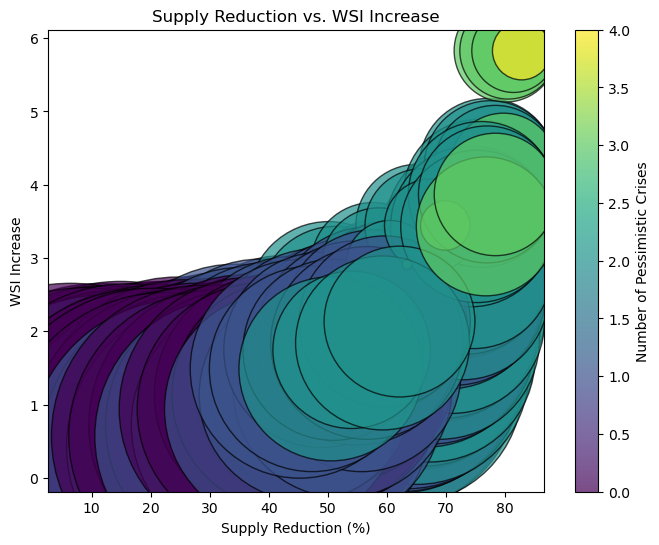

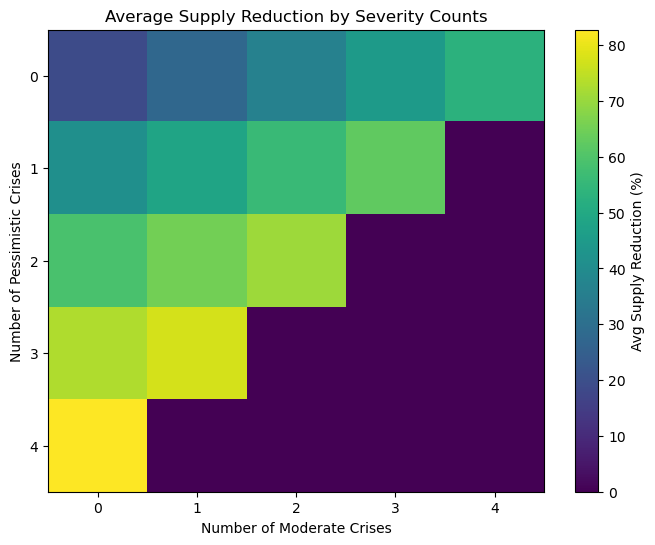

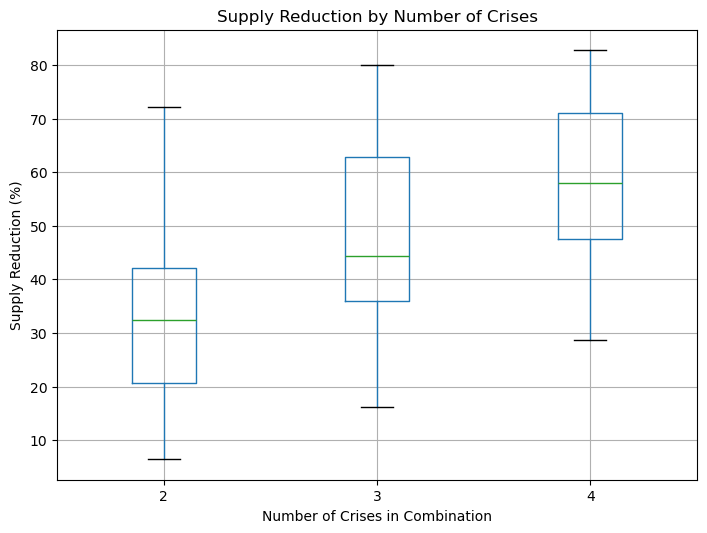

Severity pattern distribution:
  O0M0P2: 6 combinations
  O0M0P3: 4 combinations
  O0M0P4: 1 combinations
  O0M1P1: 12 combinations
  O0M1P2: 12 combinations
  O0M1P3: 4 combinations
  O0M2P0: 6 combinations
  O0M2P1: 12 combinations
  O0M2P2: 6 combinations
  O0M3P0: 4 combinations
  O0M3P1: 4 combinations
  O0M4P0: 1 combinations
  O1M0P1: 12 combinations
  O1M0P2: 12 combinations
  O1M0P3: 4 combinations
  O1M1P0: 12 combinations
  O1M1P1: 24 combinations
  O1M1P2: 12 combinations
  O1M2P0: 12 combinations
  O1M2P1: 12 combinations
  O1M3P0: 4 combinations
  O2M0P0: 6 combinations
  O2M0P1: 12 combinations
  O2M0P2: 6 combinations
  O2M1P0: 12 combinations
  O2M1P1: 12 combinations
  O2M2P0: 6 combinations
  O3M0P0: 4 combinations
  O3M0P1: 4 combinations
  O3M1P0: 4 combinations
  O4M0P0: 1 combinations


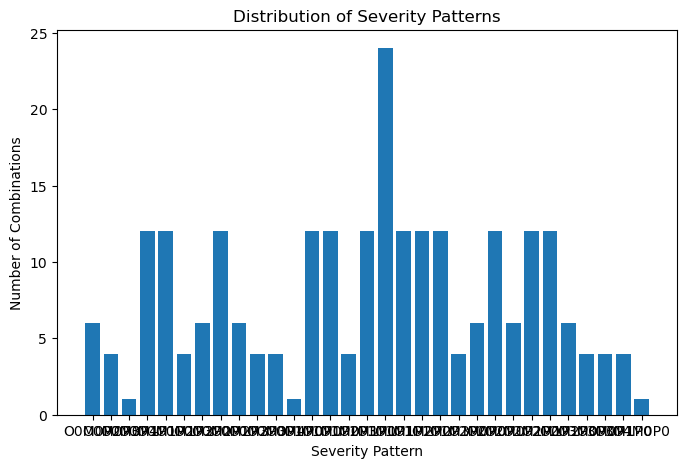

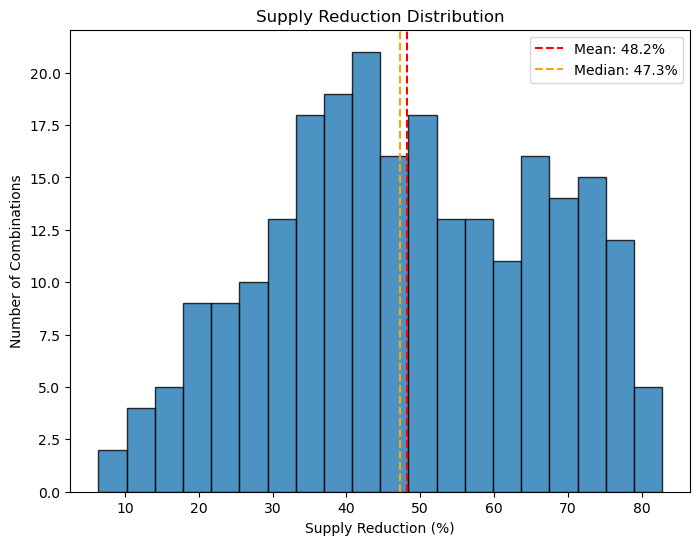

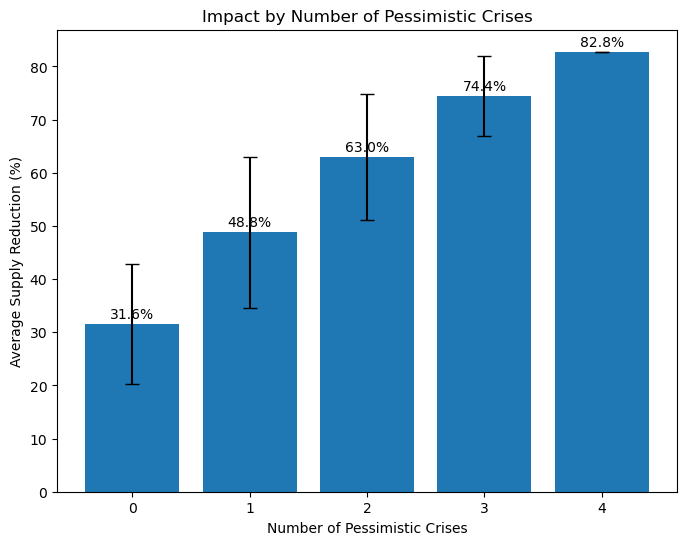

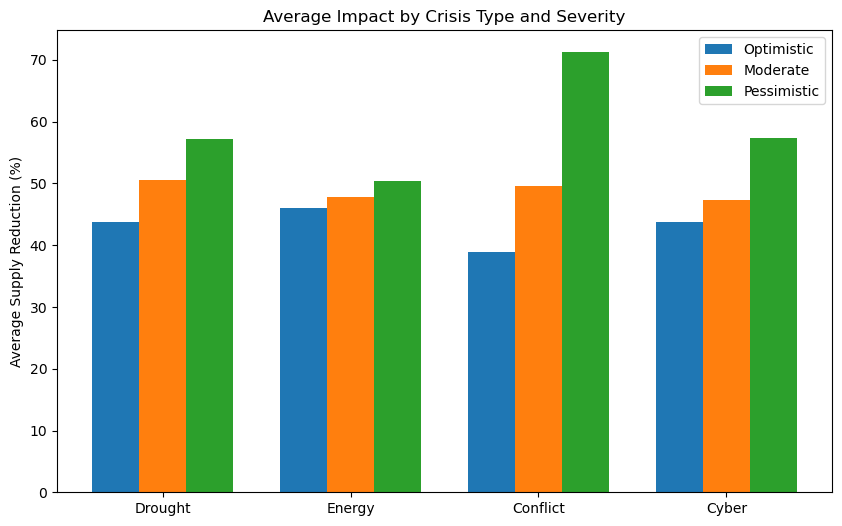

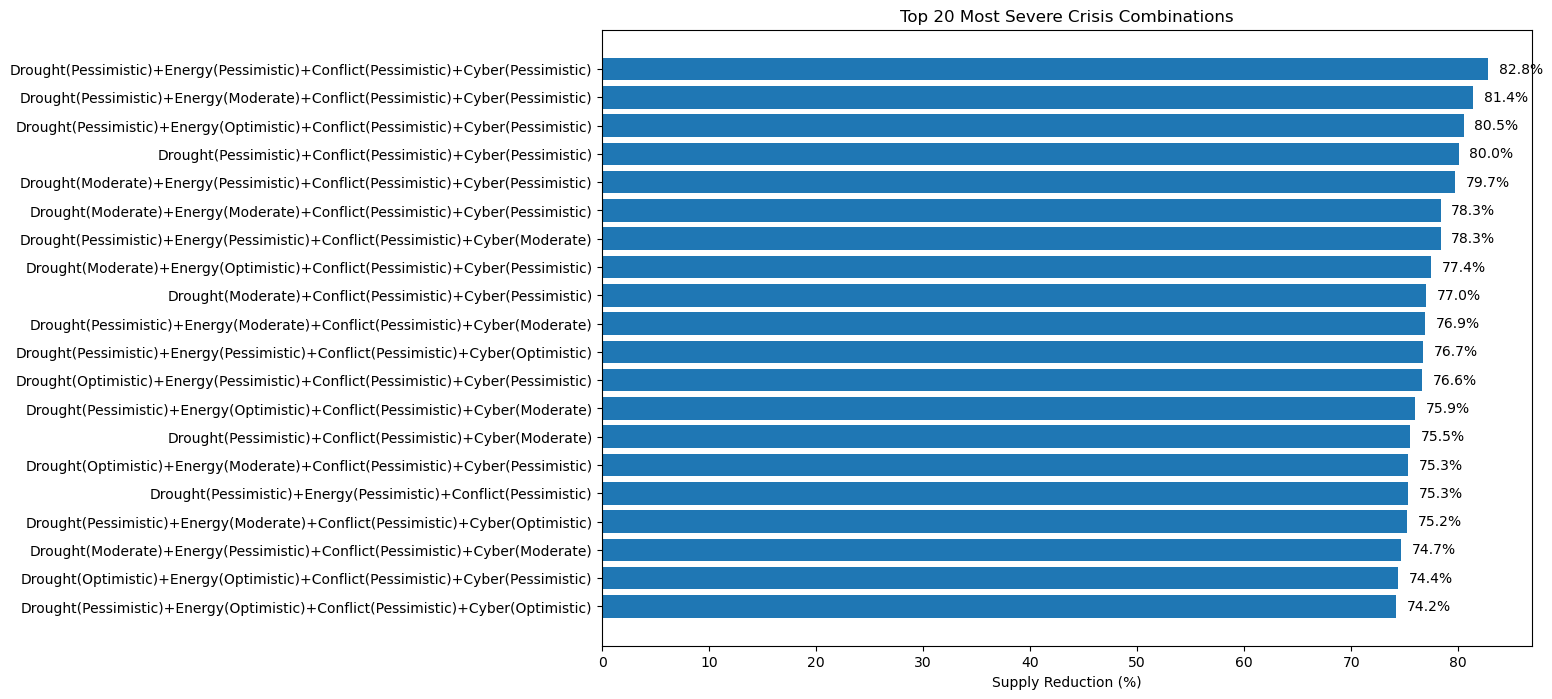

In [69]:
# Convert impact_data to DataFrame
impact_df = pd.DataFrame(impact_data)

# Normalize gap_change for marker size; small constant avoids zero
size = (impact_df['gap_change'] - impact_df['gap_change'].min() + 1) * 50

fig_scatter, ax_scatter = plt.subplots(figsize=(8, 6))
scatter = ax_scatter.scatter(
    impact_df['supply_reduction'],
    impact_df['wsi_increase'],
    s=size,
    alpha=0.7,
    c=impact_df['total_pessimistic'],  # colour by number of pessimistic crises
    cmap='viridis',
    edgecolor='k'
)
ax_scatter.set_title('Supply Reduction vs. WSI Increase')
ax_scatter.set_xlabel('Supply Reduction (%)')
ax_scatter.set_ylabel('WSI Increase')
cbar = fig_scatter.colorbar(scatter)
cbar.set_label('Number of Pessimistic Crises')
plt.show()


# Create a pivot table with mean supply reduction
pivot = impact_df.pivot_table(
    index='total_pessimistic', 
    columns='total_moderate',
    values='supply_reduction',
    aggfunc='mean'
).fillna(0)

fig_heat, ax_heat = plt.subplots(figsize=(8, 6))
cax = ax_heat.imshow(pivot, interpolation='nearest', aspect='auto')
ax_heat.set_title('Average Supply Reduction by Severity Counts')
ax_heat.set_xlabel('Number of Moderate Crises')
ax_heat.set_ylabel('Number of Pessimistic Crises')
ax_heat.set_xticks(np.arange(len(pivot.columns)))
ax_heat.set_xticklabels(pivot.columns)
ax_heat.set_yticks(np.arange(len(pivot.index)))
ax_heat.set_yticklabels(pivot.index)
fig_heat.colorbar(cax, label='Avg Supply Reduction (%)')
plt.show()


fig_box, ax_box = plt.subplots(figsize=(8, 6))
impact_df['num_crises'] = impact_df['name'].str.count('\\+') + 1  # count crises
impact_df.boxplot(column='supply_reduction', by='num_crises', ax=ax_box)
ax_box.set_title('Supply Reduction by Number of Crises')
ax_box.set_xlabel('Number of Crises in Combination')
ax_box.set_ylabel('Supply Reduction (%)')
plt.suptitle('')  # remove default title
plt.show()


# Build a severity pattern string like O2M1P1 for each combination
impact_df['pattern'] = (
    'O' + impact_df['optimistic_count'].astype(str) +
    'M' + impact_df['moderate_count'].astype(str) +
    'P' + impact_df['pessimistic_count'].astype(str)
)

# Count patterns and display
pattern_counts = impact_df['pattern'].value_counts().sort_index()
print("Severity pattern distribution:")
for pattern, count in pattern_counts.items():
    print(f"  {pattern}: {count} combinations")

# Optional: bar chart of pattern counts
fig_pattern, ax_pattern = plt.subplots(figsize=(8, 5))
ax_pattern.bar(pattern_counts.index, pattern_counts.values)
ax_pattern.set_xlabel('Severity Pattern')
ax_pattern.set_ylabel('Number of Combinations')
ax_pattern.set_title('Distribution of Severity Patterns')
plt.show()

supply_reductions = impact_df['supply_reduction']

fig_hist, ax_hist = plt.subplots(figsize=(8, 6))
ax_hist.hist(supply_reductions, bins=20, alpha=0.8, edgecolor='black')
mean_val = supply_reductions.mean()
median_val = supply_reductions.median()
ax_hist.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}%')
ax_hist.axvline(median_val, color='orange', linestyle='--', label=f'Median: {median_val:.1f}%')
ax_hist.set_xlabel('Supply Reduction (%)')
ax_hist.set_ylabel('Number of Combinations')
ax_hist.set_title('Supply Reduction Distribution')
ax_hist.legend()
plt.show()

# Group by count of pessimistic crises and compute mean and std
group = impact_df.groupby('pessimistic_count')['supply_reduction']
counts = group.mean().index
means = group.mean().values
stds = group.std().fillna(0).values

fig_pess, ax_pess = plt.subplots(figsize=(8, 6))
ax_pess.bar(counts, means, yerr=stds, capsize=5)
ax_pess.set_xlabel('Number of Pessimistic Crises')
ax_pess.set_ylabel('Average Supply Reduction (%)')
ax_pess.set_title('Impact by Number of Pessimistic Crises')
for x, y in zip(counts, means):
    ax_pess.text(x, y + 0.5, f'{y:.1f}%', ha='center', va='bottom')
plt.show()


# Identify crisis types in the names and map to severity
crisis_types = ['drought', 'energy', 'conflict', 'cyber']
severity_levels = ['Optimistic', 'Moderate', 'Pessimistic']
# Create a dictionary to hold lists of supply reduction values
crisis_impacts = {c: {s: [] for s in severity_levels} for c in crisis_types}

# Populate the dictionary
for _, row in impact_df.iterrows():
    combo_name = row['name']
    reduction = row['supply_reduction']
    for c in crisis_types:
        for s in severity_levels:
            if f'{c.capitalize()}({s})' in combo_name:
                crisis_impacts[c][s].append(reduction)

# Compute averages
opt_means = [np.mean(crisis_impacts[c]['Optimistic']) for c in crisis_types]
mod_means = [np.mean(crisis_impacts[c]['Moderate']) for c in crisis_types]
pes_means = [np.mean(crisis_impacts[c]['Pessimistic']) for c in crisis_types]

# Plot grouped bars
x_pos = np.arange(len(crisis_types))
width = 0.25
fig_ct, ax_ct = plt.subplots(figsize=(10, 6))
ax_ct.bar(x_pos - width, opt_means, width, label='Optimistic')
ax_ct.bar(x_pos, mod_means, width, label='Moderate')
ax_ct.bar(x_pos + width, pes_means, width, label='Pessimistic')
ax_ct.set_xticks(x_pos)
ax_ct.set_xticklabels([c.capitalize() for c in crisis_types])
ax_ct.set_ylabel('Average Supply Reduction (%)')
ax_ct.set_title('Average Impact by Crisis Type and Severity')
ax_ct.legend()
plt.show()


# Sort by supply reduction descending
top_20 = impact_df.sort_values(by='supply_reduction', ascending=False).head(20)
y_pos = np.arange(len(top_20))

fig_top, ax_top = plt.subplots(figsize=(12, 8))
ax_top.barh(y_pos, top_20['supply_reduction'])
ax_top.set_yticks(y_pos)
ax_top.set_yticklabels(top_20['name'])
ax_top.invert_yaxis()  # Highest at top
ax_top.set_xlabel('Supply Reduction (%)')
ax_top.set_title('Top 20 Most Severe Crisis Combinations')
# Annotate values
for i, val in enumerate(top_20['supply_reduction']):
    ax_top.text(val + 1, i, f'{val:.1f}%', va='center')
plt.show()




In [70]:
"""
Utility functions to persist compound crisis analysis outputs.

When you finish computing all combinations and generating plots
for the compound crisis analysis, you may want to save both the
numeric results (impact summaries) and the visualizations.  This module
provides a simple function to do exactly that.  It takes as input
the dictionary of combination results (`combination_results`), the
list of impact metric dictionaries (`impact_data`), and optionally
any figure objects created during your analysis.  It writes:

1. A CSV file named ``compound_crisis_impact_summary.csv`` containing
   the supply reduction, WSI increase, gap change and severity counts
   for each scenario.
2. A separate CSV file for each scenario result in
   ``combination_results``, sanitizing the combination name to create
   a valid filename.
3. A single PDF file called ``compound_crisis_plots.pdf`` that
   contains all currently open matplotlib figures (if you choose to
   include them).

To use this function, import it at the end of your compound crisis
analysis cell and call ``save_compound_results`` with the appropriate
arguments.  For example:

```
from save_compound_results import save_compound_results

# After computing impact_data and combination_results and creating plots
impact_df = pd.DataFrame(impact_data)
save_compound_results(
    combination_results=combination_results,
    impact_df=impact_df,
    include_figures=True  # Save all open figures into one PDF
)
```

This will write the files into your current working directory.  You
can adjust the filename prefixes via the ``result_prefix`` argument.
"""

from __future__ import annotations

import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from typing import Dict, Optional


def _sanitize_filename(name: str) -> str:
    """Remove or replace characters unsuitable for filenames."""
    # Replace parentheses and plus signs with underscores
    sanitized = name.replace('(', '').replace(')', '').replace('+', '_')
    sanitized = sanitized.replace('/', '_').replace(' ', '')
    # Limit length to avoid very long filenames
    return sanitized[:200]


def save_compound_results(
    combination_results: Dict[str, pd.DataFrame],
    impact_df: pd.DataFrame,
    result_prefix: str = "compound_crisis",
    include_figures: bool = False,
    figures_filename: str = "compound_crisis_plots.pdf",
) -> None:
    """
    Save the outputs of compound crisis analysis to disk.

    Parameters
    ----------
    combination_results : dict
        A mapping from scenario names to the resulting DataFrames after
        applying crises.  Each DataFrame typically contains the water
        supply/demand columns and computed indicators for all years.
    impact_df : pandas.DataFrame
        A DataFrame summarising the impact metrics for each scenario.
        This should have at least the columns ``name``, ``supply_reduction``,
        ``wsi_increase``, ``gap_change``, and the severity counts.
    result_prefix : str, optional
        A prefix for the output filenames.  Defaults to "compound_crisis".
    include_figures : bool, optional
        If True, all currently open matplotlib figures will be saved
        into a single PDF file specified by ``figures_filename``.
    figures_filename : str, optional
        Name of the PDF file to save figures into.  Only used if
        ``include_figures`` is True.

    Returns
    -------
    None
    """
    # Ensure the output directory exists
    output_dir = os.getcwd()

    # Save the impact summary DataFrame to CSV
    impact_csv_path = os.path.join(output_dir, f"{result_prefix}_impact_summary.csv")
    impact_df.to_csv(impact_csv_path, index=False)
    print(f"✅ Impact summary saved to {impact_csv_path}")

    # Save each combination's DataFrame to its own CSV file
    for combo_name, df in combination_results.items():
        safe_name = _sanitize_filename(combo_name)
        combo_csv_path = os.path.join(output_dir, f"{result_prefix}_result_{safe_name}.csv")
        try:
            df.to_csv(combo_csv_path, index=False)
            print(f"   • Saved scenario data for {combo_name} to {combo_csv_path}")
        except Exception as e:
            print(f"   ✖ Failed to save data for {combo_name}: {e}")

    # Optionally save all open figures into a single PDF
    if include_figures:
        pdf_path = os.path.join(output_dir, figures_filename)
        with PdfPages(pdf_path) as pdf:
            for i in plt.get_fignums():
                fig = plt.figure(i)
                pdf.savefig(fig)
        print(f"✅ All open figures saved to {pdf_path}")





# After running compound crisis analysis:
impact_df = pd.DataFrame(impact_data)

# Persist all results and the current figures
save_compound_results(
    combination_results=combination_results,
    impact_df=impact_df,
    result_prefix="compound_crisis",     # customise prefix if desired
    include_figures=True,                # set False to skip PDF
    figures_filename="compound_crisis_plots.pdf"
)


✅ Impact summary saved to /Users/karolbot/finaldt_v4/compound_crisis_impact_summary.csv
   • Saved scenario data for Drought(Optimistic)+Energy(Optimistic) to /Users/karolbot/finaldt_v4/compound_crisis_result_DroughtOptimistic_EnergyOptimistic.csv
   • Saved scenario data for Drought(Optimistic)+Energy(Moderate) to /Users/karolbot/finaldt_v4/compound_crisis_result_DroughtOptimistic_EnergyModerate.csv
   • Saved scenario data for Drought(Optimistic)+Energy(Pessimistic) to /Users/karolbot/finaldt_v4/compound_crisis_result_DroughtOptimistic_EnergyPessimistic.csv
   • Saved scenario data for Drought(Moderate)+Energy(Optimistic) to /Users/karolbot/finaldt_v4/compound_crisis_result_DroughtModerate_EnergyOptimistic.csv
   • Saved scenario data for Drought(Moderate)+Energy(Moderate) to /Users/karolbot/finaldt_v4/compound_crisis_result_DroughtModerate_EnergyModerate.csv
   • Saved scenario data for Drought(Moderate)+Energy(Pessimistic) to /Users/karolbot/finaldt_v4/compound_crisis_result_Drough

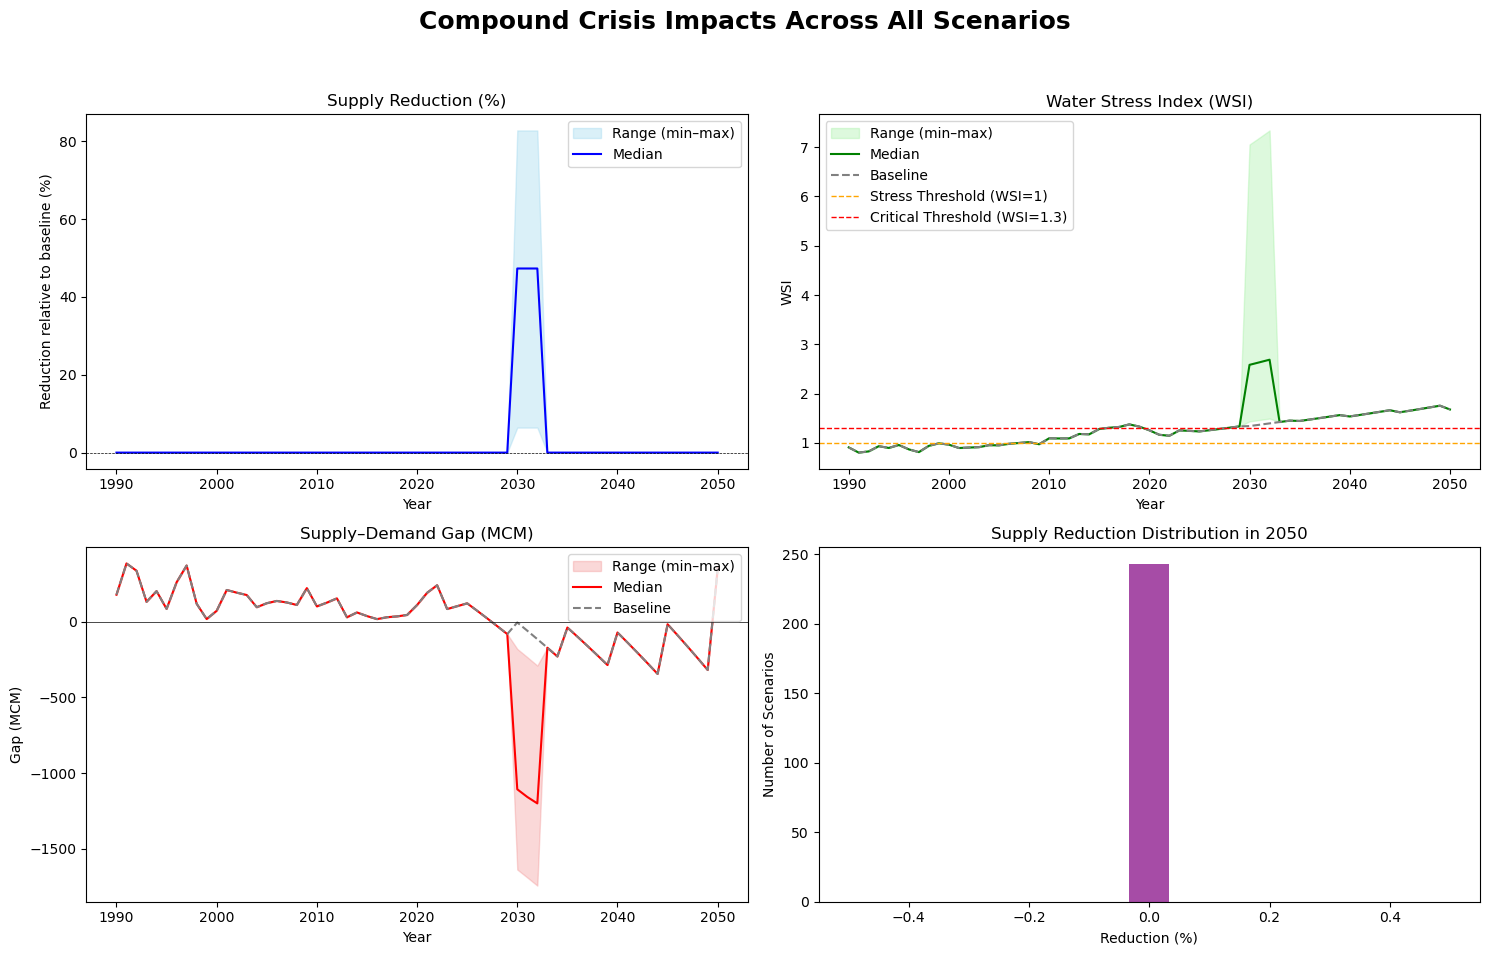

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# List of years (assumes baseline_data has a 'year' column)
years = baseline_data['year'].values

# Preallocate matrices to store each scenario's timeseries
num_scenarios = len(combination_results)
num_years = len(years)
supply_reduction_matrix = np.zeros((num_scenarios, num_years))
wsi_matrix = np.zeros((num_scenarios, num_years))
gap_matrix = np.zeros((num_scenarios, num_years))

# Populate matrices with values for each scenario
for idx, (name, df) in enumerate(combination_results.items()):
    # Supply reduction as percent difference vs baseline
    supply_reduction_matrix[idx, :] = (
        (baseline_data['total_supply_mcm'].values - df['total_supply_mcm'].values)
        / baseline_data['total_supply_mcm'].values
    ) * 100.0
    # WSI values directly from scenario
    wsi_matrix[idx, :] = df['wsi'].values
    # Gap between supply and demand (can use df['surplus_mcm'] for absolute gap)
    gap_matrix[idx, :] = df['surplus_mcm'].values  # or df['surplus_mcm'] - baseline_data['surplus_mcm']

# Compute per‑year min, max and median
sr_min, sr_max, sr_median = supply_reduction_matrix.min(axis=0), supply_reduction_matrix.max(axis=0), np.median(supply_reduction_matrix, axis=0)
wsi_min, wsi_max, wsi_median = wsi_matrix.min(axis=0), wsi_matrix.max(axis=0), np.median(wsi_matrix, axis=0)
gap_min, gap_max, gap_median = gap_matrix.min(axis=0), gap_matrix.max(axis=0), np.median(gap_matrix, axis=0)

# Create a 2×2 figure summarising ranges
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Compound Crisis Impacts Across All Scenarios', fontsize=18, fontweight='bold')

# Supply reduction range
ax = axes[0, 0]
ax.fill_between(years, sr_min, sr_max, color='skyblue', alpha=0.3, label='Range (min–max)')
ax.plot(years, sr_median, color='blue', label='Median')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title('Supply Reduction (%)')
ax.set_xlabel('Year')
ax.set_ylabel('Reduction relative to baseline (%)')
ax.legend(loc='upper right')

# WSI range
ax = axes[0, 1]
ax.fill_between(years, wsi_min, wsi_max, color='lightgreen', alpha=0.3, label='Range (min–max)')
ax.plot(years, wsi_median, color='green', label='Median')
ax.plot(years, baseline_data['wsi'], color='grey', linestyle='--', label='Baseline')
ax.axhline(1.0, color='orange', linestyle='--', linewidth=1, label='Stress Threshold (WSI=1)')
ax.axhline(1.3, color='red', linestyle='--', linewidth=1, label='Critical Threshold (WSI=1.3)')
ax.set_title('Water Stress Index (WSI)')
ax.set_xlabel('Year')
ax.set_ylabel('WSI')
ax.legend(loc='upper left')

# Supply–demand gap range (absolute)
ax = axes[1, 0]
ax.fill_between(years, gap_min, gap_max, color='lightcoral', alpha=0.3, label='Range (min–max)')
ax.plot(years, gap_median, color='red', label='Median')
ax.plot(years, baseline_data['surplus_mcm'], color='grey', linestyle='--', label='Baseline')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Supply–Demand Gap (MCM)')
ax.set_xlabel('Year')
ax.set_ylabel('Gap (MCM)')
ax.legend(loc='upper right')

# Empty or custom plot (e.g. show distribution of final‑year outcomes)
ax = axes[1, 1]
final_year = years[-1]
final_supply_reduction = supply_reduction_matrix[:, -1]
ax.hist(final_supply_reduction, bins=15, color='purple', alpha=0.7)
ax.set_title(f'Supply Reduction Distribution in {final_year}')
ax.set_xlabel('Reduction (%)')
ax.set_ylabel('Number of Scenarios')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


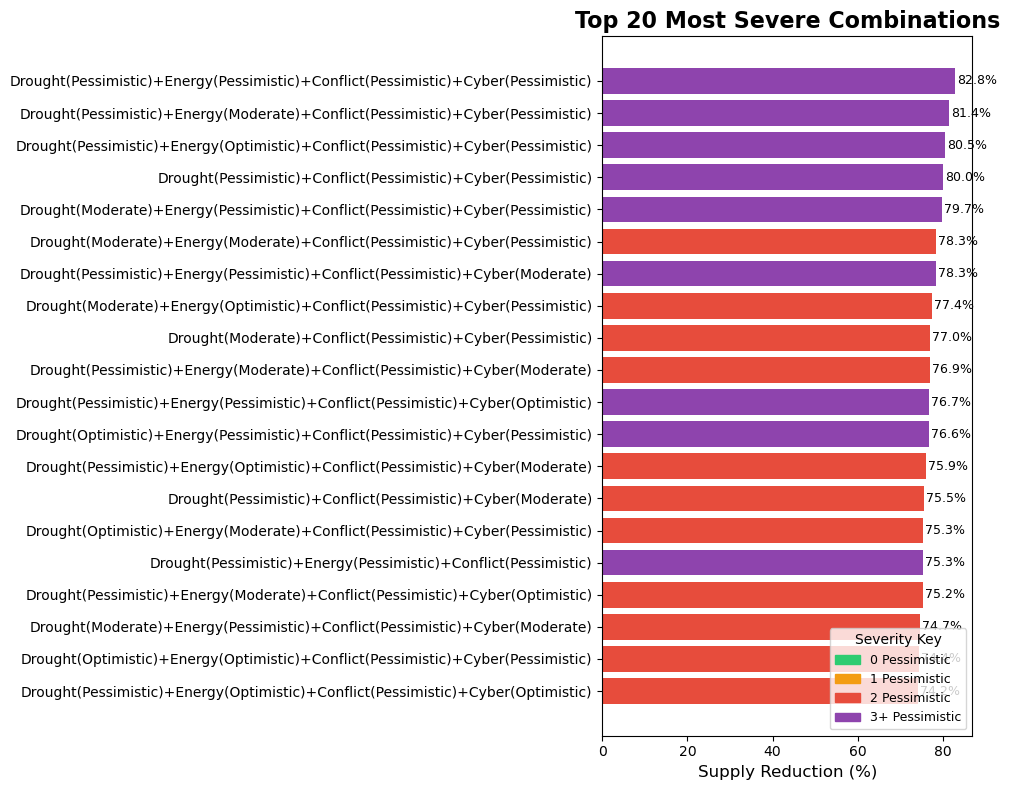

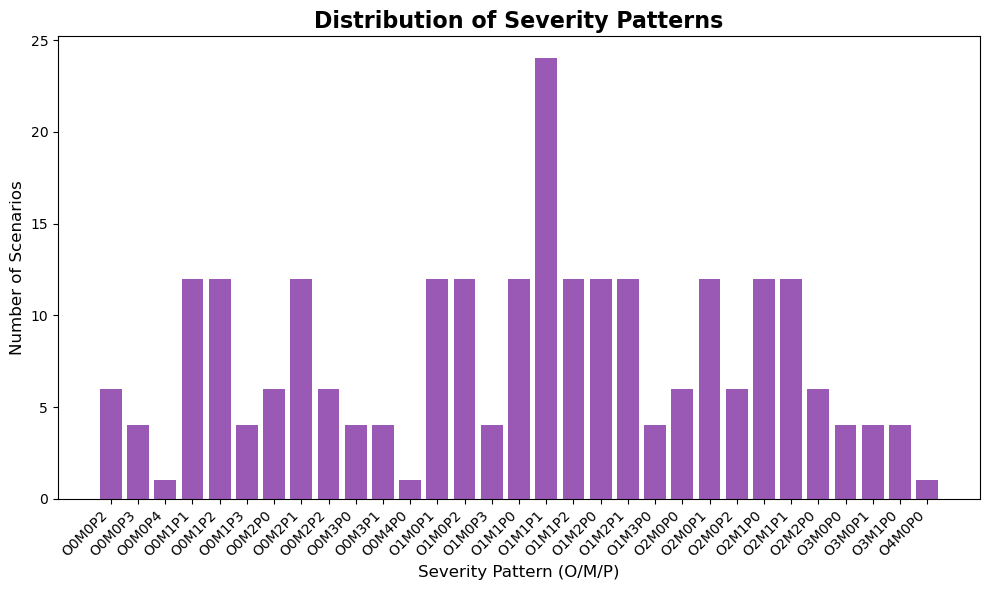

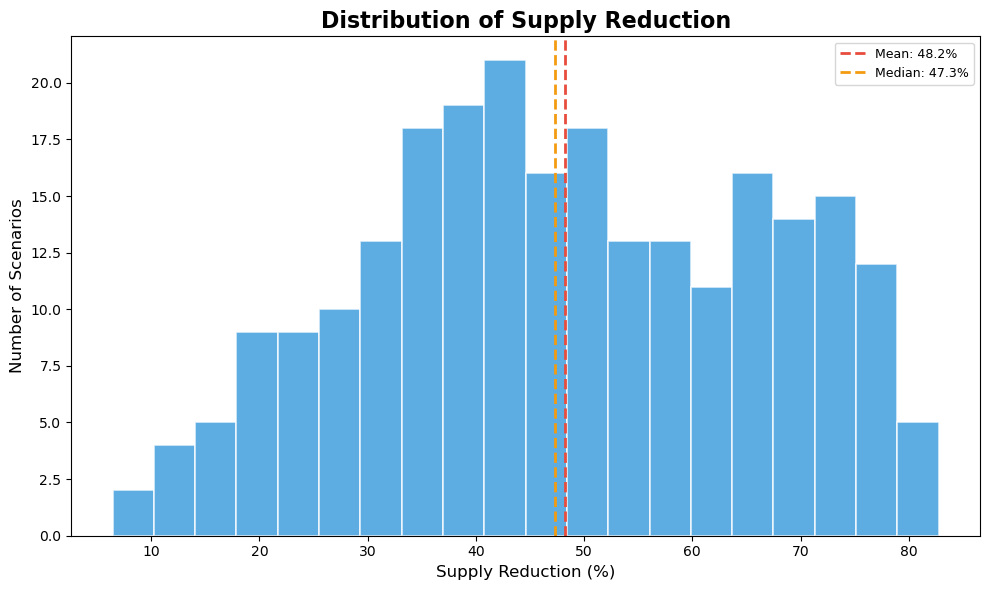

In [72]:
"""
Decision‑theater follow‑up visuals for the compound crisis analysis.

This script defines a single code block that can be pasted into the
bottom of the baseline Jupyter notebook to generate a compact
dashboard summarising the compound crisis results.  The code
assumes that a variable ``impact_data`` already exists in the
notebook’s scope—a list of dictionaries with at least the
following keys:

    name               – human‑readable description of the scenario
    supply_reduction   – percentage reduction in supply relative to
                         baseline during the crisis years
    wsi_increase       – change in Water Stress Index during the
                         crisis years
    gap_change         – change in the supply–demand gap during the
                         crisis years
    total_pessimistic  – number of pessimistic crises in the
                         combination (0–4)
    total_moderate     – number of moderate crises in the combination
    total_optimistic   – number of optimistic crises in the combination

The code converts ``impact_data`` into a DataFrame and produces
three visualisations:

1. **Top 20 Most Severe Combinations:** a horizontal bar chart
   sorted by supply reduction.  Bars are colour‑coded by the
   number of pessimistic crises (0→green, 1→amber, 2→red,
   3+→purple).  The plot also annotates each bar with its
   reduction percentage.

2. **Severity Pattern Distribution:** a pie chart showing how many
   scenarios fall into each pattern of optimistic, moderate and
   pessimistic counts (e.g. O2M1P1).  This highlights whether
   scenarios with lots of pessimistic events are common or rare.

3. **Supply Reduction Distribution:** a histogram of supply
   reductions across all 243 scenarios, with mean and median lines
   drawn to give a sense of typical versus extreme outcomes.

If you have ``impact_df`` already (a DataFrame version of
``impact_data``), you can skip the conversion step.  Otherwise,
the code below creates it for you.  To run these visuals in your
notebook, simply copy the contents of this file into a new cell
and execute it.  You can further tweak colours, labels or
thresholds to suit your presentation style.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Convert impact_data into a DataFrame (if not already a DataFrame)
# ---------------------------------------------------------------------------

# If 'impact_data' exists and isn't a DataFrame, convert it.  If it is
# already a DataFrame (named impact_df), you can comment out this block.
if 'impact_data' in globals() and not isinstance(globals().get('impact_data'), pd.DataFrame):
    impact_df = pd.DataFrame(impact_data)
elif 'impact_df' in globals():
    impact_df = impact_df  # reuse existing DataFrame
else:
    raise ValueError("impact_data or impact_df must be defined before running these visuals.")

# Ensure the required columns exist
required_cols = {'name', 'supply_reduction', 'wsi_increase', 'gap_change',
                 'total_pessimistic', 'total_moderate', 'total_optimistic'}
missing = required_cols - set(impact_df.columns)
if missing:
    raise KeyError(f"Missing expected columns in impact_df: {missing}")

# ---------------------------------------------------------------------------
# Create the severity pattern string (e.g. O2M1P1)
# ---------------------------------------------------------------------------

impact_df['pattern'] = impact_df.apply(
    lambda row: f"O{row['total_optimistic']}M{row['total_moderate']}P{row['total_pessimistic']}",
    axis=1
)

# ---------------------------------------------------------------------------
# Prepare top 20 scenarios by supply reduction
# ---------------------------------------------------------------------------

top_20 = impact_df.nlargest(20, 'supply_reduction').copy().reset_index(drop=True)

# Colour coding based on number of pessimistic crises
def assign_colour(n: int) -> str:
    """Assign a colour based on the number of pessimistic crises."""
    if n >= 3:
        return '#8E44AD'  # purple for 3 or more pessimistic crises
    elif n == 2:
        return '#E74C3C'  # red for exactly 2 pessimistic crises
    elif n == 1:
        return '#F39C12'  # orange for one pessimistic crisis
    else:
        return '#2ECC71'  # green for none pessimistic

bar_colours = top_20['total_pessimistic'].apply(assign_colour)

# ---------------------------------------------------------------------------
# Plotting: generate separate figures for each visual
# ---------------------------------------------------------------------------

# 1. Top 20 bar chart (most severe combinations)
plt.figure(figsize=(10, 8))
plt.barh(top_20['name'], top_20['supply_reduction'], color=bar_colours)
plt.xlabel('Supply Reduction (%)', fontsize=12)
plt.title('Top 20 Most Severe Combinations', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()  # Highest reductions at top
for i, val in enumerate(top_20['supply_reduction']):
    plt.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=9)

# Legend for colours
legend_labels = ['0 Pessimistic', '1 Pessimistic', '2 Pessimistic', '3+ Pessimistic']
legend_patches = [plt.Rectangle((0,0),1,1, color=c) for c in ['#2ECC71', '#F39C12', '#E74C3C', '#8E44AD']]
plt.legend(legend_patches, legend_labels, loc='lower right', fontsize=9, title='Severity Key')
plt.tight_layout()
plt.show()

# 2. Severity pattern distribution
plt.figure(figsize=(10, 6))
pattern_counts = impact_df['pattern'].value_counts().sort_index()

# Choose a bar chart for ease of interpretation; each bar corresponds to a severity pattern
plt.bar(pattern_counts.index, pattern_counts.values, color='#9B59B6')
plt.xlabel('Severity Pattern (O/M/P)', fontsize=12)
plt.ylabel('Number of Scenarios', fontsize=12)
plt.title('Distribution of Severity Patterns', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# If you prefer a pie chart instead of a bar chart, you may uncomment the following lines:
# plt.figure(figsize=(8, 8))
# plt.pie(pattern_counts.values, labels=pattern_counts.index, autopct='%1.1f%%',
#         startangle=90, counterclock=False, textprops={'fontsize': 9})
# plt.title('Severity Pattern Distribution (Pie Chart)', fontsize=16, fontweight='bold')
# plt.show()

# 3. Supply reduction histogram
plt.figure(figsize=(10, 6))
sr = impact_df['supply_reduction']
plt.hist(sr, bins=20, alpha=0.8, color='#3498DB', edgecolor='white', linewidth=1.2)
mean_sr = sr.mean()
median_sr = sr.median()
plt.axvline(mean_sr, color='#E74C3C', linestyle='--', linewidth=2, label=f'Mean: {mean_sr:.1f}%')
plt.axvline(median_sr, color='#F39C12', linestyle='--', linewidth=2, label=f'Median: {median_sr:.1f}%')
plt.xlabel('Supply Reduction (%)', fontsize=12)
plt.ylabel('Number of Scenarios', fontsize=12)
plt.title('Distribution of Supply Reduction', fontsize=16, fontweight='bold')
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

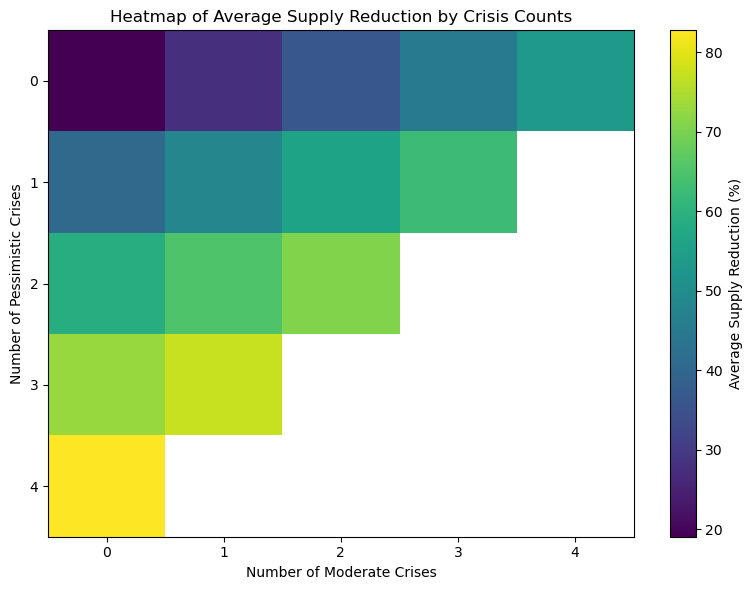


Summary statistics by impact cluster:

impact_cluster  n_scenarios  mean_reduction  median_reduction  min_reduction  max_reduction
   High Impact           61       71.859738         71.788023      64.443594      82.766123
    Low Impact           61       25.067008         25.807490       6.426357      34.791122
 Medium Impact          121       47.994593         47.299941      35.307004      64.080239

WSI increase statistics by impact cluster:

impact_cluster  mean_wsi_increase  median_wsi_increase  min_wsi_increase  max_wsi_increase
   High Impact           2.956999             2.834192          1.432610          5.828783
    Low Impact           0.487410             0.467196          0.096458          1.141502
 Medium Impact           1.382110             1.267422          0.381035          2.913067


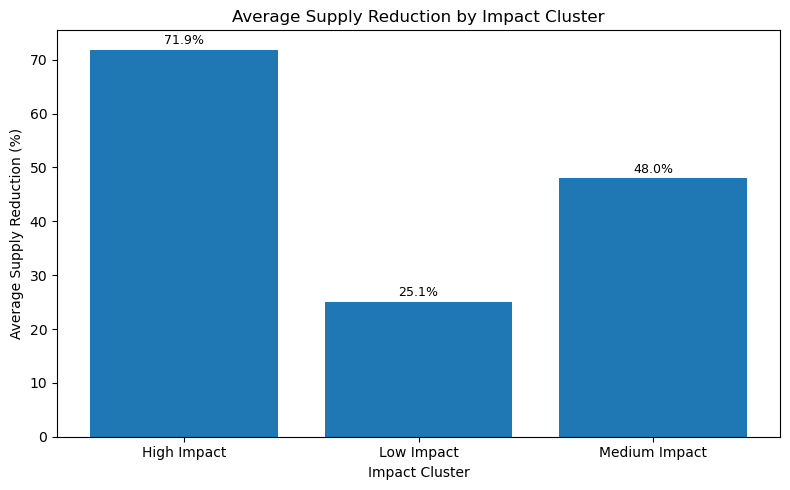

In [73]:
"""
Scenario clustering and heatmap visualisations for compound crisis analysis.

This script defines a set of code cells that you can paste into the bottom of
your Jupyter notebook after the compound crisis analysis.  The code relies
on an existing variable ``impact_data`` or ``impact_df``, which should
contain records of each crisis combination and its impact metrics.  It
produces two main analytical outputs:

1. **Heatmap of Average Supply Reduction by Crisis Counts** – a matrix
   where the x‑axis is the number of moderate crises, the y‑axis is the
   number of pessimistic crises, and each cell shows the mean supply
   reduction for scenarios with those counts.  This helps decision‑makers
   see how impacts scale as crises intensify.

2. **Impact Clustering (Low/Medium/High)** – scenarios are grouped
   into three clusters based on quartiles of supply reduction.  Summary
   statistics (count, mean, median, minimum, maximum) for each cluster
   are displayed, and a bar chart shows the average supply reduction per
   cluster.  This reduces complexity and highlights which scenarios are
   relatively benign versus severe.

Instructions: copy the contents of this file into a new cell in your
notebook and run it.  Make sure ``impact_data`` or ``impact_df`` is
available in the notebook’s environment.  You can adjust the quartile
thresholds or the metric used for clustering (e.g. use ``wsi_increase``
instead of ``supply_reduction``) by editing the code accordingly.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Step 1: Convert impact_data into a DataFrame (if needed)
# ---------------------------------------------------------------------------

# If 'impact_df' already exists, use it; otherwise, convert 'impact_data'.
if 'impact_df' in globals() and isinstance(globals()['impact_df'], pd.DataFrame):
    impact_df = globals()['impact_df']
elif 'impact_data' in globals():
    impact_df = pd.DataFrame(impact_data)
else:
    raise ValueError("impact_data or impact_df must be defined before running scenario clustering.")

# Ensure required columns are present
required_cols = {'name', 'supply_reduction', 'wsi_increase', 'gap_change',
                 'total_pessimistic', 'total_moderate', 'total_optimistic'}
missing = required_cols - set(impact_df.columns)
if missing:
    raise KeyError(f"Missing expected columns in impact_df: {missing}")

# ---------------------------------------------------------------------------
# Step 2: Create a heatmap of average supply reduction by crisis counts
# ---------------------------------------------------------------------------

# Create a pivot table: rows = number of pessimistic crises, columns = number of moderate crises
pivot_sr = impact_df.pivot_table(
    index='total_pessimistic',
    columns='total_moderate',
    values='supply_reduction',
    aggfunc=np.mean
)

# Plot heatmap using matplotlib (no seaborn)
plt.figure(figsize=(8, 6))
plt.imshow(pivot_sr, aspect='auto')
plt.colorbar(label='Average Supply Reduction (%)')
plt.xticks(range(len(pivot_sr.columns)), pivot_sr.columns)
plt.yticks(range(len(pivot_sr.index)), pivot_sr.index)
plt.xlabel('Number of Moderate Crises')
plt.ylabel('Number of Pessimistic Crises')
plt.title('Heatmap of Average Supply Reduction by Crisis Counts')
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Step 3: Cluster scenarios into Low/Medium/High impact groups
# ---------------------------------------------------------------------------

# Compute the 25th and 75th percentiles of supply reduction
q1, q3 = impact_df['supply_reduction'].quantile([0.25, 0.75])

def classify_impact(value: float) -> str:
    """Classify scenarios based on supply reduction quartiles."""
    if value <= q1:
        return 'Low Impact'
    elif value <= q3:
        return 'Medium Impact'
    else:
        return 'High Impact'

# Assign cluster labels
impact_df['impact_cluster'] = impact_df['supply_reduction'].apply(classify_impact)

# Summary statistics for each cluster
cluster_stats = impact_df.groupby('impact_cluster')['supply_reduction'].agg(
    n_scenarios='count',
    mean_reduction='mean',
    median_reduction='median',
    min_reduction='min',
    max_reduction='max'
).reset_index()

# Print summary table
print("\nSummary statistics by impact cluster:\n")
print(cluster_stats.to_string(index=False))

# Optional: also compute stats for WSI increase
wsi_stats = impact_df.groupby('impact_cluster')['wsi_increase'].agg(
    mean_wsi_increase='mean',
    median_wsi_increase='median',
    min_wsi_increase='min',
    max_wsi_increase='max'
).reset_index()

print("\nWSI increase statistics by impact cluster:\n")
print(wsi_stats.to_string(index=False))

# ---------------------------------------------------------------------------
# Step 4: Visualise the average supply reduction per cluster
# ---------------------------------------------------------------------------

plt.figure(figsize=(8, 5))
plt.bar(cluster_stats['impact_cluster'], cluster_stats['mean_reduction'])
plt.xlabel('Impact Cluster')
plt.ylabel('Average Supply Reduction (%)')
plt.title('Average Supply Reduction by Impact Cluster')
for i, val in enumerate(cluster_stats['mean_reduction']):
    plt.text(i, val + 0.5, f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

Recommended actions for sample scenarios (first 10):


name  supply_reduction  wsi_increase  \
0    Drought(Optimistic)+Energy(Optimistic)         11.464169      0.216225   
1      Drought(Optimistic)+Energy(Moderate)         13.991314      0.216225   
2   Drought(Optimistic)+Energy(Pessimistic)         17.782031      0.216225   
3      Drought(Moderate)+Energy(Optimistic)         21.664765      0.513647   
4        Drought(Moderate)+Energy(Moderate)         24.191910      0.513647   
5     Drought(Moderate)+Energy(Pessimistic)         27.982627      0.513647   
6   Drought(Pessimistic)+Energy(Optimistic)         31.865361      0.948577   
7     Drought(Pessimistic)+Energy(Moderate)         34.392506      0.948577   
8  Drought(Pessimistic)+Energy(Pessimistic)         38.183224      0.948577   
9  Drought(Optimistic)+Conflict(Optimistic)         23.670507      0.434264   

    gap_change                    actions  
0  -311.470000                         []  
1  -380.130000                         []  
2  -483.120000                         []  
3  -588.610000  [Sustainability Measures]  
4  -657.270000  [Sustainability Measures]  
5  -760.260000  [Sustainability Measures]  
6  -865.750000  [Sustainability Measures]  
7  -934.410000  [Sustainability Measures]  
8 -1037.400000  [Sustainability Measures]  
9  -551.460408                         []


Summary of recommended interventions across all scenarios:


Action  Count
0  Sustainability Measures    208
1     Resilience Hardening    188
2         Supply Expansion    157
3       Emergency Measures    136

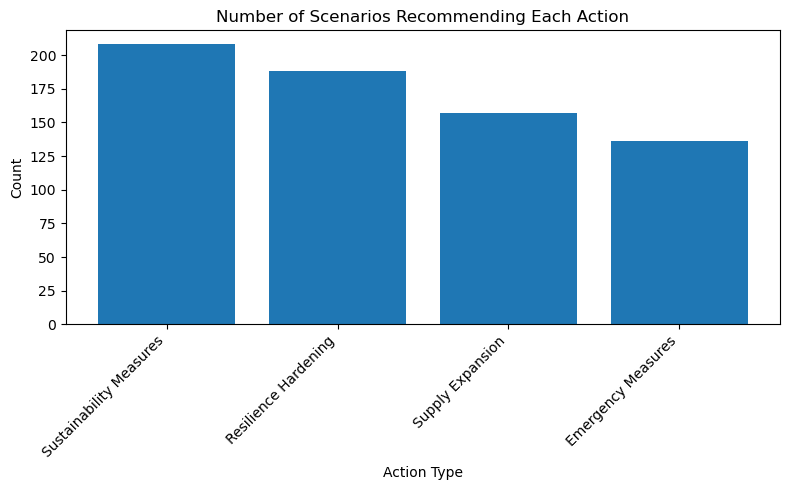

In [74]:
"""
Decision‑theater high‑level response recommendations (ASCII‑safe)
================================================================

This script provides a robust, ASCII‑only implementation of the
``Tie Impacts to High‑Level Response Options`` concept.  It examines
each scenario in your compound‐crisis analysis and assigns broad
recommendations based on the scenario's supply reduction, WSI increase
and gap change, as well as the presence of moderate or pessimistic
conflict/cyber events.

Usage
-----
Place this code in a cell at the end of your notebook after
``impact_data`` or ``impact_df`` is defined.  It will:

1. Load the impact data into a pandas DataFrame.
2. Compute a threshold for identifying scenarios with a large
   negative change in the supply–demand gap.
3. Apply a set of rules to recommend actions such as supply
   expansion, sustainability measures, emergency measures and
   resilience hardening.
4. Display a preview of the recommendations for the first 10
   scenarios.
5. Summarise how often each action is recommended across all
   scenarios, both in a DataFrame and a simple bar chart.

Because this code uses only ASCII characters, it avoids the
``UnicodeEncodeError`` that can occur when printing emoji or other
non‑standard characters in some environments.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display

# ---------------------------------------------------------------------------
# Step 1: Prepare the impact dataframe
# ---------------------------------------------------------------------------

# If ``impact_df`` is already defined, use it; otherwise build from ``impact_data``.
if 'impact_df' in globals() and isinstance(globals()['impact_df'], pd.DataFrame):
    impact_df = globals()['impact_df'].copy()
elif 'impact_data' in globals():
    impact_df = pd.DataFrame(impact_data)
else:
    raise ValueError("impact_data or impact_df must be defined to compute high‑level responses.")

required_cols = {'name', 'supply_reduction', 'wsi_increase', 'gap_change'}
missing = required_cols - set(impact_df.columns)
if missing:
    raise KeyError(f"impact_df is missing required columns: {missing}")

# ---------------------------------------------------------------------------
# Step 2: Compute threshold for large negative gap change
# ---------------------------------------------------------------------------

negative_gap_values = impact_df.loc[impact_df['gap_change'] < 0, 'gap_change']
if not negative_gap_values.empty:
    gap_threshold = negative_gap_values.mean()
else:
    # Set to negative infinity if no negative values exist, so no
    # scenario triggers emergency measures on gap change alone.
    gap_threshold = -np.inf

# ---------------------------------------------------------------------------
# Step 3: Define a function to determine recommended actions
# ---------------------------------------------------------------------------

def determine_actions(row: pd.Series) -> list:
    """Assign high‑level response options based on scenario metrics.

    Parameters
    ----------
    row : pd.Series
        A row from ``impact_df`` containing at least the columns
        ``supply_reduction``, ``wsi_increase``, ``gap_change`` and ``name``.

    Returns
    -------
    list
        A list of recommended interventions.
    """
    actions = []
    sr = float(row['supply_reduction'])
    wsi_inc = float(row['wsi_increase'])
    gap = float(row['gap_change'])
    name_str = str(row['name'])
    # Supply expansion if supply reduction is greater than 40 percent
    if sr > 40.0:
        actions.append('Supply Expansion')
    # Sustainability measures if WSI increases by more than 0.5
    if wsi_inc > 0.5:
        actions.append('Sustainability Measures')
    # Emergency measures if gap change is worse than the threshold
    if gap < gap_threshold:
        actions.append('Emergency Measures')
    # Resilience hardening if moderate or pessimistic conflict/cyber events occur
    severe_conflict_terms = ['Conflict(Pessimistic)', 'Conflict(Moderate)']
    severe_cyber_terms = ['Cyber(Pessimistic)', 'Cyber(Moderate)']
    if any(term in name_str for term in severe_conflict_terms + severe_cyber_terms):
        actions.append('Resilience Hardening')
    return actions

# Apply the function to each row and add the result to the DataFrame
impact_df = impact_df.copy()
impact_df['actions'] = impact_df.apply(determine_actions, axis=1)

# ---------------------------------------------------------------------------
# Step 4: Display a preview of recommended actions
# ---------------------------------------------------------------------------

print("Recommended actions for sample scenarios (first 10):")
preview_cols = ['name', 'supply_reduction', 'wsi_increase', 'gap_change', 'actions']
display(impact_df[preview_cols].head(10))

# ---------------------------------------------------------------------------
# Step 5: Summarise and plot action frequencies
# ---------------------------------------------------------------------------

all_actions = [a for sublist in impact_df['actions'] for a in sublist]
action_counts = Counter(all_actions)

print("\nSummary of recommended interventions across all scenarios:")
summary_df = pd.DataFrame({
    'Action': list(action_counts.keys()),
    'Count': list(action_counts.values())
}).sort_values('Count', ascending=False)
display(summary_df)

plt.figure(figsize=(8, 5))
plt.bar(summary_df['Action'], summary_df['Count'])
plt.title('Number of Scenarios Recommending Each Action')
plt.xlabel('Action Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Distribution of the number of recommended actions per scenario:


Count
NumActions       
0              21
1              38
2              26
3              33
4             125

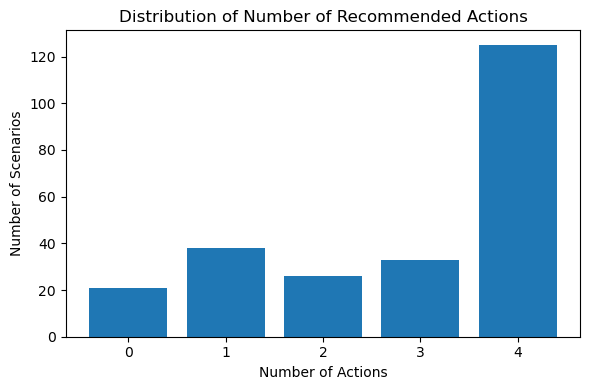


Top action combinations (by number of scenarios):


ActionCombination  Count
0  Emergency Measures; Resilience Hardening; Supp...    125
1      Resilience Hardening; Sustainability Measures     25
2                            Sustainability Measures     24
3  Resilience Hardening; Supply Expansion; Sustai...     22
4                                               None     21
5                               Resilience Hardening     14
6  Emergency Measures; Supply Expansion; Sustaina...      9
7  Emergency Measures; Resilience Hardening; Sust...      2
8          Supply Expansion; Sustainability Measures      1

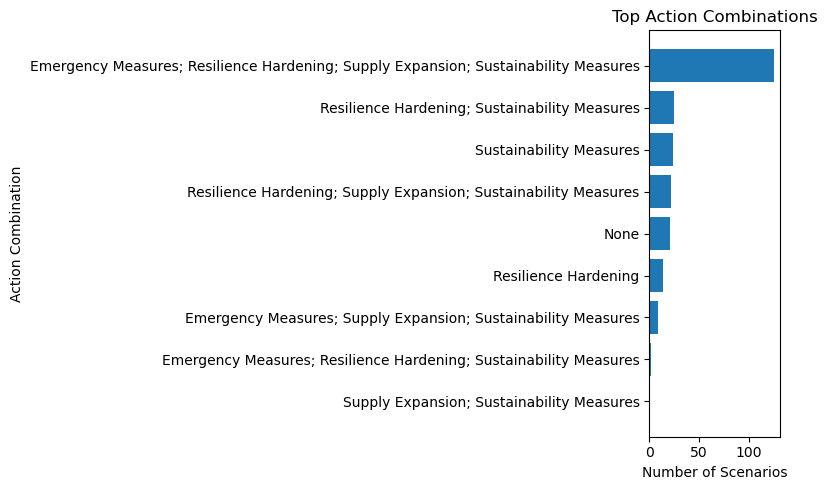


Action co‑occurrence matrix (counts of scenarios where actions co‑occur):


Emergency Measures  Resilience Hardening  \
Emergency Measures                      136                   127   
Resilience Hardening                    127                   188   
Supply Expansion                        134                   147   
Sustainability Measures                 136                   174   

                         Supply Expansion  Sustainability Measures  
Emergency Measures                    134                      136  
Resilience Hardening                  147                      174  
Supply Expansion                      157                      157  
Sustainability Measures               157                      208

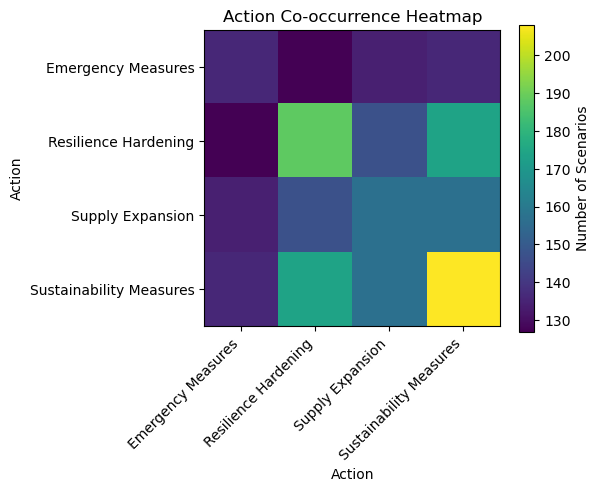

In [75]:
"""
Extended Analysis and Visualisations for High‑Level Response Options
==================================================================

This code builds upon the basic high‑level response recommendations to
provide deeper insights into how often actions are triggered and how
they co‑occur across all compound‑crisis scenarios.  The goal is to
help stakeholders see not only which broad interventions are needed
most often, but also how many actions each scenario requires and
which combinations of interventions are common or rare.

Specifically, this script:

1. **Ensures the presence of the `actions` column** in the
   `impact_df`.  If not present, it recomputes the actions using the
   same rules as the previous high‑level response code.
2. **Calculates the number of recommended actions per scenario** and
   plots a histogram to show the distribution (e.g. how many
   scenarios need one action vs. two, three or none).
3. **Identifies all unique action combinations** (e.g. "Supply
   Expansion; Resilience Hardening") and counts how many scenarios
   fall into each combination.  It displays the top combinations in a
   bar chart to highlight common patterns of response.
4. **Summarises action co‑occurrence in a contingency table**, where
   rows represent individual actions and columns represent whether an
   action appears alone or alongside others.  This helps identify
   actions that frequently occur together.

To use this script, ensure it is placed after the high‑level response
module has been executed, so that `impact_df` contains an
`actions` column (a list of recommended actions for each scenario).
If not, you may need to re‑run the high‑level response cell or
import and apply the `determine_actions` logic from that module.


"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display

# ---------------------------------------------------------------------------
# Step 1: Load or verify impact_df and actions column
# ---------------------------------------------------------------------------

if 'impact_df' not in globals() or not isinstance(globals()['impact_df'], pd.DataFrame):
    raise ValueError("impact_df must exist in the environment before running this analysis.")

impact_df = globals()['impact_df']

# Ensure the 'actions' column exists; if not, raise an informative error
if 'actions' not in impact_df.columns:
    raise KeyError("impact_df must contain an 'actions' column (list of recommendations).\n"
                   "Please run the high‑level response module first to compute actions.")

# Create a deep copy to avoid mutating the original
df_analysis = impact_df.copy()

# ---------------------------------------------------------------------------
# Step 2: Distribution of number of actions per scenario
# ---------------------------------------------------------------------------

df_analysis['num_actions'] = df_analysis['actions'].apply(lambda acts: len(acts))

print("Distribution of the number of recommended actions per scenario:")
display(df_analysis['num_actions'].value_counts().sort_index().rename_axis('NumActions').to_frame('Count'))

# Plot a histogram of the number of actions
plt.figure(figsize=(6, 4))
plt.hist(df_analysis['num_actions'], bins=np.arange(df_analysis['num_actions'].max() + 2) - 0.5, rwidth=0.8)
plt.title('Distribution of Number of Recommended Actions')
plt.xlabel('Number of Actions')
plt.ylabel('Number of Scenarios')
plt.xticks(range(df_analysis['num_actions'].max() + 1))
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Step 3: Analyse and visualise action combinations
# ---------------------------------------------------------------------------

# Combine action lists into a sorted, semicolon‑separated string to identify unique patterns
df_analysis['action_combo'] = df_analysis['actions'].apply(lambda acts: '; '.join(sorted(acts)) if acts else 'None')

combo_counts = Counter(df_analysis['action_combo'])

combo_df = pd.DataFrame({
    'ActionCombination': list(combo_counts.keys()),
    'Count': list(combo_counts.values())
}).sort_values('Count', ascending=False).reset_index(drop=True)

print("\nTop action combinations (by number of scenarios):")
display(combo_df.head(10))

# Plot the top 10 action combinations
top_n = min(10, len(combo_df))
plt.figure(figsize=(8, 5))
plt.barh(combo_df['ActionCombination'].head(top_n)[::-1], combo_df['Count'].head(top_n)[::-1])
plt.title('Top Action Combinations')
plt.xlabel('Number of Scenarios')
plt.ylabel('Action Combination')
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Step 4: Action co‑occurrence matrix
# ---------------------------------------------------------------------------

# Get list of unique actions
unique_actions = sorted({action for acts in df_analysis['actions'] for action in acts})

# Build a boolean matrix where each column is a unique action and each row is a scenario
action_matrix = pd.DataFrame(0, index=df_analysis.index, columns=unique_actions)
for idx, acts in enumerate(df_analysis['actions']):
    for act in acts:
        action_matrix.at[idx, act] = 1

# Compute co‑occurrence matrix: how often each pair of actions appears together
cooccurrence = action_matrix.T.dot(action_matrix)

print("\nAction co‑occurrence matrix (counts of scenarios where actions co‑occur):")
display(cooccurrence)

# ---------------------------------------------------------------------------
# Optional: Heatmap for co‑occurrence (single plot per figure)
# ---------------------------------------------------------------------------

plt.figure(figsize=(6, 5))
# Use imshow for a simple heatmap; values on diagonal represent solo occurrences
plt.imshow(cooccurrence, interpolation='nearest')
plt.xticks(range(len(unique_actions)), unique_actions, rotation=45, ha='right')
plt.yticks(range(len(unique_actions)), unique_actions)
plt.title('Action Co‑occurrence Heatmap')
plt.xlabel('Action')
plt.ylabel('Action')
plt.colorbar(label='Number of Scenarios')
plt.tight_layout()
plt.show()